In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import os
import cProfile, pstats, io
from pstats import SortKey
from random import randint
from Utillities import Utillities
from cnn_model import CNN6     


print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

if os.path.exists("checkpoint.pt"):
    os.remove("checkpoint.pt")

torch.manual_seed(5)   # reproducible

OPTIMIZATION_PLUGIN = 'Bayesian' # 'Bayesian' or 'Scikit' or 'GradDescent'
#Bayesian requires: $ conda install -c conda-forge bayesian-optimization

GET_STATS = False
GPU_SELECT = 2 # can be 0, 1, 2 (both)
PARALLEL_PROCESSES = 100
TRIALS = 120
RANDOM_STARTS = 500
LR  = 1e-5                    # learning rate
SCI_LR =  1e-5
LR2 = 1e-5
SCI_MM = 0.5                  # momentum - used only with SGD optimizer
MM = 0.5
L_FIRST = 1                  # initial number of channels
KERNEL_X = 5
patience = 7                 # if validation loss not going down, wait "patience" number of epochs
accuracy = 0
MaxCredit = -800

CreditVector = np.zeros(RANDOM_STARTS + TRIALS)
CreditVector = CreditVector - 800
CreditVec = np.zeros(RANDOM_STARTS + TRIALS)
count = 0

pr = cProfile.Profile()

if GET_STATS:
    pr.enable()
    

if GPU_SELECT == 2:
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Using", torch.cuda.device_count(), "NVIDIA 1080TI GPUs!")

if GPU_SELECT == 1:
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")    
    print("Using one (the second) NVIDIA 1080TI GPU!")

if GPU_SELECT == 0:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")       
    print("Using one (the first) NVIDIA 1080TI GPU!")


PyTorch Version:  1.2.0
Torchvision Version:  0.4.0a0+6b959ee
Using 2 NVIDIA 1080TI GPUs!


In [2]:
from early_stopping import EarlyStopping
from dataset2 import dataset


early_stopping = EarlyStopping(patience=patience, verbose=True)  # initialize the early_stopping object

# Counter for the execution time
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

/home/pauld/Development/German-Credit-Private--master/dataset2.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  if ((data[k,j] / i) > 1) :
/home/pauld/Development/German-Credit-Private--master/dataset2.py:66: RuntimeWarning: invalid value encountered in double_scalars
  if ((data[k,j] / i) > 1) :
/home/pauld/Development/German-Credit-Private--master/dataset2.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  if ((data[k,j] / i) > 1) :
/home/pauld/Development/German-Credit-Private--master/dataset2.py:66: RuntimeWarning: invalid value encountered in double_scalars
  if ((data[k,j] / i) > 1) :
/home/pauld/Development/German-Credit-Private--master/dataset2.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  if ((data[k,j] / i) > 1) :
/home/pauld/Development/German-Credit-Private--master/dataset2.py:66: RuntimeWarning: invalid value encountered in double_scalars
  if ((data[k,j] / i) > 1) :


In [3]:
if OPTIMIZATION_PLUGIN == 'Scikit' :
    from skopt import gp_minimize
    from sklearn.datasets import load_boston
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_val_score
    from skopt.space import Real, Integer
    from skopt.utils import use_named_args
    from skopt.plots import plot_convergence
    from functools import partial
    from skopt.plots import plot_evaluations
    from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize
    from skopt.plots import plot_objective
    from sklearn.preprocessing import LabelEncoder
    from skopt.space import Real, Categorical, Integer
    from sklearn.externals.joblib import Parallel, delayed

    SCI_LR = Categorical(categories=[1e-1, 3e-1, 5e-1, 7e-1, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.08, 0.09],name= 'SCI_LR')
    SCI_MM = Categorical(categories=[0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999], name='SCI_MM')
    SCI_REGULARIZATION = Categorical(categories=[0.0001, 0.0003, 0.0007, 0.001, 0.003, 0.007, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7], name='SCI_REGULARIZATION')
    SCI_EPOCHS = Categorical(categories=[2000, 1000], name='SCI_EPOCHS')
    SCI_optimizer = Categorical(categories=['Adam', 'AMSGrad', 'SGD', 'RMSprop', 'Rprop', 'AdamW', 'ASGD', 'Adadelta', 'Adamax'],name='SCI_optimizer') #
    SCI_loss_type = Categorical(categories=['CrossEntropyLoss', 'MultiMarginLoss','NLLLoss', 'L1Loss'],name='SCI_loss_type') # 
    SCI_BATCH_SIZE = Categorical(categories=[4, 8, 12, 16, 24, 32, 48, 64, 80, 96, 104, 128, 144, 160, 192, 224, 256], name='SCI_BATCH_SIZE')
    SCI_DROPOUT = Categorical(categories=[0, 0.01, 0.03, 0.07, 0.1, 0.13, 0.17, 0.2, 0.23, 0.27, 0.3, 0.33, 0.37, 0.4] , name = 'SCI_DROPOUT')
    SCI_RELU = Categorical(categories=['True', 'False'] , name = 'SCI_RELU')
    SCI_BIAS = Categorical(categories=['True', 'False'] , name = 'SCI_BIAS')
    SCI_L_SECOND = Categorical(categories=[2, 4, 6, 8, 12, 16, 20, 24], name='SCI_L_SECOND')
    SCI_BN_MOMENTUM = Categorical(categories=[0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99] , name = 'SCI_BN_MOMENTUM') 
    SCI_SGD_MOMENTUM = Categorical(categories=[0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99] , name = 'SCI_SGD_MOMENTUM') 
    SCI_LINEARITY = Categorical(categories=[1, 2],name= 'SCI_LINEARITY')
   

    dimensions = [SCI_BATCH_SIZE, SCI_MM, SCI_REGULARIZATION, SCI_optimizer, SCI_LR, SCI_loss_type, SCI_DROPOUT, SCI_RELU, SCI_BIAS, SCI_L_SECOND, SCI_EPOCHS, SCI_BN_MOMENTUM, SCI_SGD_MOMENTUM, SCI_LINEARITY]

    @use_named_args(dimensions = dimensions)

    def objective(SCI_BATCH_SIZE, SCI_MM, SCI_REGULARIZATION, SCI_optimizer, SCI_LR, SCI_loss_type, SCI_DROPOUT, SCI_RELU, SCI_BIAS, SCI_L_SECOND, SCI_EPOCHS, SCI_BN_MOMENTUM, SCI_SGD_MOMENTUM, SCI_LINEARITY):
        global device  

        loss_func = nn.CrossEntropyLoss()

        def create_loss(LOSS):   
            if LOSS == 'CrossEntropyLoss':
                loss_func = nn.CrossEntropyLoss()
            if LOSS == 'NLLLoss':
                loss_func = nn.NLLLoss()
            else:
                loss_func = nn.MultiMarginLoss()
            return loss_func

        MM = float(str(SCI_MM))
        REGULARIZATION = float(str(SCI_REGULARIZATION))
        optimizer = str(SCI_optimizer)
        LR = float(str(SCI_LR))
        train_losses = []         # to track the training loss as the model trains
        output = 0
        loss = 0
        accuracy = 0
        early_stopping.counter = 0
        early_stopping.best_score = None
        early_stopping.early_stop = False
        early_stopping.verbose = False  
        TEST_RESULTS = torch.zeros(1,2)
 
        loss_type = create_loss(SCI_loss_type)
                
        cnn = CNN6(L_FIRST, SCI_L_SECOND, KERNEL_X, SCI_BIAS, SCI_BN_MOMENTUM, SCI_RELU, SCI_DROPOUT, dataset.CLASSES, SCI_LINEARITY)     

        optimizer = Utillities.optimization_algorithms(SCI_optimizer,cnn, SCI_LR, SCI_SGD_MOMENTUM,
                                                       SCI_REGULARIZATION)
        
        if GPU_SELECT == 2:
            if torch.cuda.device_count() > 1:
                cnn = nn.DataParallel(cnn,device_ids=[0, 1], dim=0) 
            cnn = cnn.cuda()
        if GPU_SELECT == 1:
            cnn.to(device)  
        if GPU_SELECT == 0:
            cnn.to(device)        

        cnn.apply(CNN6.weights_reset)
        cnn.share_memory()
     

        Utillities.listing(optimizer, SCI_SGD_MOMENTUM, SCI_BN_MOMENTUM, SCI_L_SECOND, SCI_LR, SCI_RELU, SCI_BIAS, SCI_loss_type, REGULARIZATION, SCI_BATCH_SIZE, SCI_DROPOUT, SCI_LINEARITY)
    
        #SCI_BATCH_SIZE = 1
        # Data Loader for easy mini-batch return in training
        SCI_BATCH_SIZE = int(SCI_BATCH_SIZE)
        train_loader = Data.DataLoader(dataset = dataset.train_dataset, batch_size = SCI_BATCH_SIZE, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)
        validation_loader = Data.DataLoader(dataset = dataset.validation_dataset, batch_size = SCI_BATCH_SIZE, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)    
        test_loader = Data.DataLoader(dataset = dataset.test_dataset, batch_size = SCI_BATCH_SIZE, shuffle = False, num_workers = 0, pin_memory=True)
    
        for epoch in range(SCI_EPOCHS):
            loss = None        
            cnn.train().cuda()
            for step, (train_data, train_target) in enumerate(train_loader):   
                train_data, train_target = train_data.to(device), train_target.to(device)
                output, temp = cnn(train_data)                # forward pass: compute predicted outputs by passing inputs to the model     
                loss = loss_func(output, train_target)
                train_losses.append(loss.item())              # record training loss 
                loss.backward()                               # backward pass: compute gradient of the loss with respect to model parameters
                optimizer.zero_grad()
                optimizer.step()                              # perform a single optimization step (parameter update)
      
            cnn.eval().cuda()                 # switch to evaluation (no change) mode           
            valid_loss = 0
            accuracy = 0
            with torch.no_grad():
                for step, (validation_data, validation_target) in enumerate(validation_loader):
                    validation_data, validation_target = validation_data.to(device), validation_target.to(device)
                    output, temp = cnn(validation_data)            # forward pass: compute predicted outputs by passing inputs to the model
                    valid_loss += loss_func(output, validation_target).item()
                    #ps = torch.exp(output)
                    #equality = (validation_target[0].data == ps.max(dim=1)[1])
                    #accuracy += equality.type(torch.FloatTensor).mean()      
               
            train_losses = []
            early_stopping(valid_loss, cnn)
       
            if early_stopping.early_stop:
                if os.path.exists('checkpoint.pt'):
                    print("Loaded the model with the lowest Validation Loss!")
                    #nn.load_state_dict(torch.load('checkpoint.pt', map_location="cuda:1"))  # Choose whatever GPU device number you want
                    cnn.load_state_dict(torch.load('checkpoint.pt', map_location="cuda:1"))  # Choose whatever GPU device number you want
                    cnn.to(device)
                break
      
        cnn.eval()
        class_correct = list(0. for i in range(1000))
        class_total = list(0. for i in range(1000))
        with torch.no_grad():
            for (test_data, test_target) in test_loader:
                test_data, test_target = test_data.to(device), test_target.to(device)
                outputs, temp = cnn(test_data)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == test_target).squeeze()
                for i in range(test_target.size(0)):
                    label = test_target[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(dataset.CLASSES):
            TEST_RESULTS[0,i] = class_correct[i] / dataset.TESTED_ELEMENTS[i]
            print('Class: ',i,' accuracy: ', TEST_RESULTS[0,i])
            print('Class: ',i,' correct: ', class_correct[i])
        percent = (TEST_RESULTS[0,0]+TEST_RESULTS[0,1])/2
        print('Final percentage: ',percent)
    
        CreditCost = int((1 - TEST_RESULTS[0,0]) * dataset.TESTED_ELEMENTS[0] + (1 - TEST_RESULTS[0,1]) * dataset.TESTED_ELEMENTS[1] * 5)
    
        if TEST_RESULTS[0,0] == 0 or TEST_RESULTS[0,1] == 0 :
            CreditCost = CreditCost + 300
    
        print('Last epoch: ', epoch)
        print('Credit Cost: ',CreditCost)
    
        if os.path.exists('checkpoint.pt'):  
            os.remove('checkpoint.pt') 

        print()
        torch.cuda.empty_cache()
        print()
        
        return CreditCost
    
    #not working #res_gp = gp_minimize(objective, dimensions=dimensions, n_calls=TRIALS, random_state=1, verbose=True, acq_func='gp_hedge', acq_optimizer='auto', n_jobs=1)
    res_gp = forest_minimize(objective, dimensions=dimensions, base_estimator='RF', n_calls=TRIALS, n_random_starts=RANDOM_STARTS, acq_func='EI', x0=None, y0=None, random_state=None, verbose=True, callback=None, n_points=10000, xi=0.01, kappa=1.5, n_jobs=4)
    #res_gp = gbrt_minimize(objective, dimensions=dimensions, base_estimator='ET', n_calls=TRIALS+RANDOM_STARTS, n_random_starts=RANDOM_STARTS, acq_func='LCB', x0=None, y0=None, random_state=None, verbose=True, callback=None, n_points=100, xi=0.01, kappa=1.96, n_jobs=1)
    #res_gp = dummy_minimize(objective, dimensions=dimensions, n_calls=TRIALS, x0=None, y0=None, random_state=None, verbose=True, callback=None)      

    "Best score=%.4f" % res_gp.fun
    print("""Best parameters: - optimization=%d""" % (res_gp.x[0]))
  
    print(res_gp)
    plot_convergence(res_gp)
    #plot_evaluations(res_gp)
    #plot_objective(res_gp)
    

|   iter    |  target   | SCI_BA... | SCI_BIAS  | SCI_BN... | SCI_DR... | SCI_EP... | SCI_LI... |  SCI_LR   | SCI_L_... |  SCI_MM   | SCI_RE... | SCI_RELU  | SCI_SG... | SCI_lo... | SCI_op... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.11257
    weight_decay: 0.3772178321289495
)
Batch Normalization Momentum:  0.0
Nodes:  12
LR:  0.11257
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.3772178321289495
BATCH_SIZE:  55
Dropout:  0.09
Final Linear Layers:  1
average loss: 0.699206
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5271)
Class:  0  correct:  263.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7100)
Class:  1  correct:  71.0  of  tensor(100.)
Fina

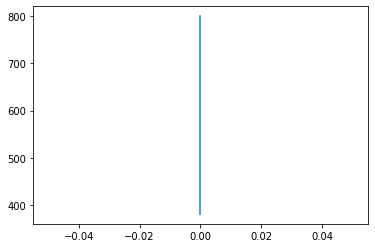

|  1        | -381.0    |  55.71    |  2.433    |  0.000113 |  0.0907   |  1.147e+0 |  1.276    |  0.1126   |  12.37    |  0.397    |  0.3772   |  1.834    |  0.6784   |  1.611    |  8.894    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.48065
    weight_decay: 0.4846565987069529
)
Batch Normalization Momentum:  0.41
Nodes:  31
LR:  0.48065
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.4846565987069529
BATCH_SIZE:  7
Dropout:  0.17
Final Linear Layers:  1
average loss: 0.713066
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5491)
Class:  0  correct:  274.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5595)
Last epoch:  8
Credit Cost:  -440


Best Score So Far:  -381


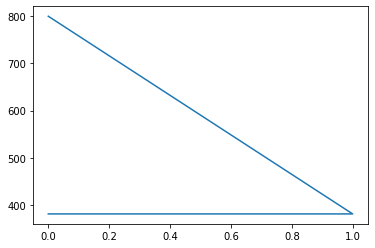

|  2        | -440.0    |  7.396    |  2.334    |  0.4131   |  0.1676   |  1.14e+03 |  1.592    |  0.4806   |  31.05    |  0.3138   |  0.4847   |  2.744    |  0.8857   |  1.254    |  1.351    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.41543
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.1
Nodes:  11
LR:  0.41543
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5842545077609712
BATCH_SIZE:  25
Dropout:  0.13
Final Linear Layers:  2
average loss: 0.691988
Class:  0  accuracy:  tensor(0.4649)
Class:  0  correct:  232.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5175)
Last epoch:  7
Credit Cost:  -482


Best Score So Far:  -381


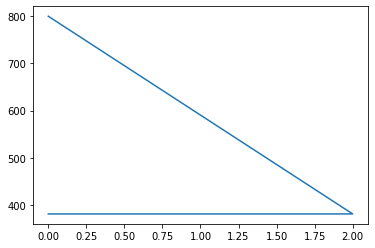

|  3        | -482.0    |  25.06    |  2.748    |  0.09736  |  0.1263   |  1.958e+0 |  2.594    |  0.4154   |  11.47    |  0.6861   |  0.5843   |  1.036    |  0.7426   |  3.957    |  7.726    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.17338
    weight_decay: 0.47521698950462965
)
Batch Normalization Momentum:  0.1
Nodes:  5
LR:  0.17338
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.47521698950462965
BATCH_SIZE:  38
Dropout:  0.13
Final Linear Layers:  1
average loss: 0.691055
Class:  0  accuracy:  tensor(0.5190)
Class:  0  correct:  259.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5595)
Last epoch:  7
Credit Cost:  -440


Best Score So Far:  -381


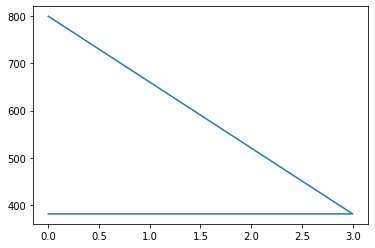

|  4        | -440.0    |  38.78    |  2.571    |  0.1022   |  0.1344   |  1.909e+0 |  1.878    |  0.1734   |  5.901    |  0.02033  |  0.4752   |  1.421    |  0.2629   |  2.47     |  1.48     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.41695
    rho: 0.9
    weight_decay: 0.3751738945002665
)
Batch Normalization Momentum:  0.58
Nodes:  14
LR:  0.41695
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.3751738945002665
BATCH_SIZE:  75
Dropout:  0.21
Final Linear Layers:  2
average loss: 0.693469
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4890)
Class:  0  correct:  244.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.4995)
Last epoch:  14
Credit Cost:  -500


Best Score So Far:  -381


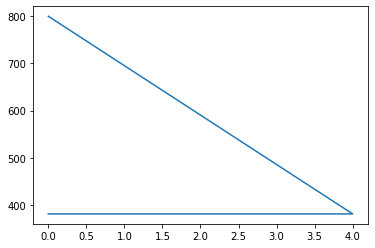

|  5        | -500.0    |  75.19    |  1.292    |  0.5834   |  0.2099   |  1.102e+0 |  2.238    |  0.4169   |  14.43    |  0.05085  |  0.3752   |  2.321    |  0.5097   |  3.824    |  6.273    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.55658
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.14
Nodes:  12
LR:  0.55658
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5082259899467809
BATCH_SIZE:  116
Dropout:  0.24
Final Linear Layers:  1
average loss: 0.692530
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4790)
Class:  0  correct:  239.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5145)
Last epoch:  8
Credit Cost:  -485


Best Score So Far:  -381


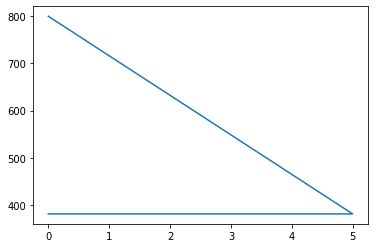

|  6        | -485.0    |  116.0    |  1.274    |  0.1379   |  0.2422   |  1.398e+0 |  1.494    |  0.5566   |  12.43    |  0.7503   |  0.5082   |  2.758    |  0.6174   |  3.245    |  4.137    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.06973
    rho: 0.9
    weight_decay: 0.4049148911095535
)
Batch Normalization Momentum:  0.42
Nodes:  30
LR:  0.06973
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4049148911095535
BATCH_SIZE:  37
Dropout:  0.29
Final Linear Layers:  2
average loss: 0.691875
Class:  0  accuracy:  tensor(0.5331)
Class:  0  correct:  266.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5265)
Last epoch:  7
Credit Cost:  -473


Best Score So Far:  -381


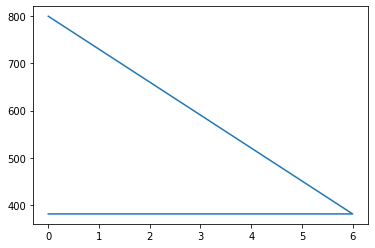

|  7        | -473.0    |  37.47    |  2.783    |  0.4238   |  0.2895   |  1.663e+0 |  2.859    |  0.06973  |  30.48    |  0.45     |  0.4049   |  1.812    |  0.2347   |  3.701    |  6.157    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.54521
    weight_decay: 0.6506131198972585
)
Batch Normalization Momentum:  0.32
Nodes:  20
LR:  0.54521
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.6506131198972585
BATCH_SIZE:  4
Dropout:  0.16
Final Linear Layers:  2
average loss: 0.693528
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.8898)
Class:  0  correct:  444.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.0700)
Class:  1  correct:  7.0  of  tensor(100.)
Final percentage:  tensor(0.4799)
Last epoch:  8
Credit Cost:  -520


Best Score So Far:  -381


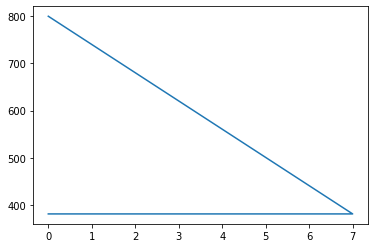

|  8        | -520.0    |  4.356    |  2.228    |  0.3234   |  0.1581   |  1.886e+0 |  2.068    |  0.5452   |  20.7     |  0.01679  |  0.6506   |  2.375    |  0.9873   |  1.515    |  2.233    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4272
    momentum: 0.24
    nesterov: False
    weight_decay: 0.01844506971571572
)
Batch Normalization Momentum:  0.07
Nodes:  5
LR:  0.4272
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.01844506971571572
BATCH_SIZE:  119
Dropout:  0.23
Final Linear Layers:  3
average loss: 0.693085
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5551)
Class:  0  correct:  277.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3700)
Class:  1  correct:  37.0  of  tensor(100.)
Final percentage:  tensor(0.4626)
Last epoch:  9
Credit Cost:  -537


Best Score So Far:  -381


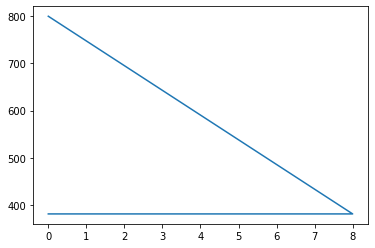

|  9        | -537.0    |  119.6    |  2.387    |  0.06534  |  0.2266   |  1.754e+0 |  3.76     |  0.4272   |  5.728    |  0.02084  |  0.01845  |  1.056    |  0.2437   |  3.571    |  5.844    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.33706
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.12
Nodes:  2
LR:  0.33706
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.16315869426133017
BATCH_SIZE:  72
Dropout:  0.08
Final Linear Layers:  3
average loss: 0.692597
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5210)
Class:  0  correct:  260.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.4905)
Last epoch:  13
Credit Cost:  -509


Best Score So Far:  -381


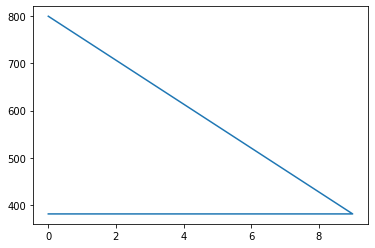

|  10       | -509.0    |  72.55    |  2.676    |  0.1229   |  0.08376  |  1.586e+0 |  3.899    |  0.3371   |  2.559    |  0.8      |  0.1632   |  2.606    |  0.384    |  3.582    |  7.717    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.1362
    weight_decay: 0.008887930513365184
)
Batch Normalization Momentum:  0.06
Nodes:  23
LR:  0.1362
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.008887930513365184
BATCH_SIZE:  72
Dropout:  0.04
Final Linear Layers:  1
average loss: 0.783374
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5331)
Class:  0  correct:  266.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5415)
Last epoch:  8
Credit Cost:  -458


Best Score So Far:  -381


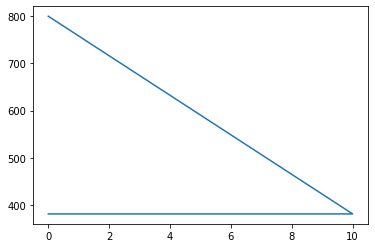

|  11       | -458.0    |  72.97    |  1.272    |  0.05932  |  0.0364   |  1.045e+0 |  1.321    |  0.1362   |  23.39    |  0.5596   |  0.008888 |  1.143    |  0.9576   |  2.699    |  2.828    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.14467
    momentum: 0.02
    nesterov: False
    weight_decay: 0.58030373159517
)
Batch Normalization Momentum:  0.19
Nodes:  16
LR:  0.14467
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.58030373159517
BATCH_SIZE:  35
Dropout:  0.17
Final Linear Layers:  3
average loss: 0.693342
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4850)
Class:  0  correct:  242.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3200)
Class:  1  correct:  32.0  of  tensor(100.)
Final percentage:  tensor(0.4025)
Last epoch:  9
Credit Cost:  -597


Best Score So Far:  -381


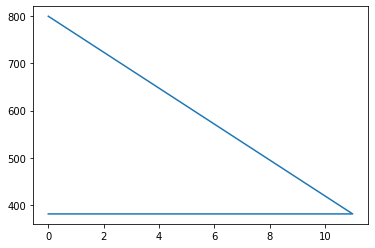

|  12       | -597.0    |  35.29    |  2.48     |  0.1935   |  0.1744   |  1.97e+03 |  3.532    |  0.1447   |  16.81    |  0.6197   |  0.5803   |  1.312    |  0.01839  |  1.209    |  5.372    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.33102
    weight_decay: 0.18551719840820027
)
Batch Normalization Momentum:  0.31
Nodes:  24
LR:  0.33102
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.18551719840820027
BATCH_SIZE:  79
Dropout:  0.3
Final Linear Layers:  2
average loss: 8.619982
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5210)
Class:  0  correct:  260.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.5405)
Last epoch:  15
Credit Cost:  -459


Best Score So Far:  -381


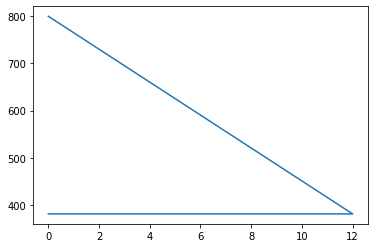

|  13       | -459.0    |  79.18    |  2.132    |  0.3142   |  0.2966   |  1.58e+03 |  2.137    |  0.331    |  24.36    |  0.6689   |  0.1855   |  1.132    |  0.3664   |  2.883    |  2.889    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.31528
    t0: 1000000.0
    weight_decay: 0.04626616736974824
)
Batch Normalization Momentum:  0.26
Nodes:  29
LR:  0.31528
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.04626616736974824
BATCH_SIZE:  97
Dropout:  0.24
Final Linear Layers:  2
average loss: 0.693038
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5190)
Class:  0  correct:  259.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3600)
Class:  1  correct:  36.0  of  tensor(100.)
Final percentage:  tensor(0.4395)
Last epoch:  11
Credit Cost:  -560


Best Score So Far:  -381


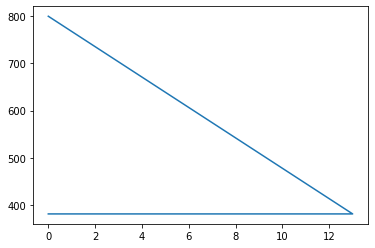

|  14       | -560.0    |  97.34    |  1.132    |  0.2577   |  0.2414   |  1.193e+0 |  2.912    |  0.3153   |  29.74    |  0.2638   |  0.04627  |  2.463    |  0.7645   |  3.714    |  9.378    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.54945
    t0: 1000000.0
    weight_decay: 0.3402448679011271
)
Batch Normalization Momentum:  0.61
Nodes:  21
LR:  0.54945
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.3402448679011271
BATCH_SIZE:  5
Dropout:  0.28
Final Linear Layers:  2
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -381


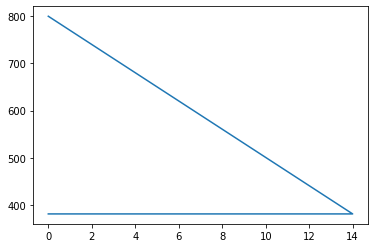

|  15       | -800.0    |  5.73     |  1.466    |  0.6106   |  0.2847   |  1.95e+03 |  2.664    |  0.5494   |  21.25    |  0.3902   |  0.3402   |  2.203    |  0.5441   |  3.769    |  9.259    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01389
    weight_decay: 0.010611784621411451
)
Batch Normalization Momentum:  0.17
Nodes:  30
LR:  0.01389
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.010611784621411451
BATCH_SIZE:  52
Dropout:  0.04
Final Linear Layers:  2
average loss: 0.693125
Class:  0  accuracy:  tensor(0.5471)
Class:  0  correct:  273.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.5085)
Last epoch:  7
Credit Cost:  -491


Best Score So Far:  -381


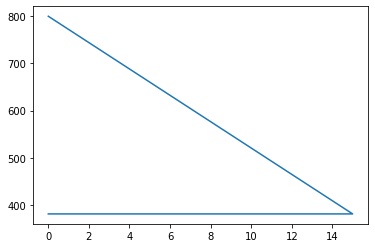

|  16       | -491.0    |  52.96    |  2.917    |  0.1722   |  0.0379   |  1.135e+0 |  2.512    |  0.01389  |  30.44    |  0.8265   |  0.01061  |  1.351    |  0.3287   |  1.392    |  8.277    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.27647
    rho: 0.9
    weight_decay: 0.20007462432872986
)
Batch Normalization Momentum:  0.58
Nodes:  18
LR:  0.27647
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.20007462432872986
BATCH_SIZE:  46
Dropout:  0.26
Final Linear Layers:  3
average loss: 0.692257
Class:  0  accuracy:  tensor(0.4609)
Class:  0  correct:  230.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7100)
Class:  1  correct:  71.0  of  tensor(100.)
Final percentage:  tensor(0.5855)
Last epoch:  7
Credit Cost:  -414


Best Score So Far:  -381


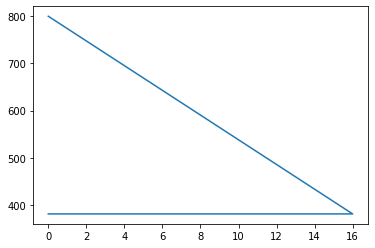

|  17       | -414.0    |  46.75    |  2.871    |  0.5762   |  0.2636   |  1.845e+0 |  3.707    |  0.2765   |  18.39    |  0.798    |  0.2001   |  1.976    |  0.5931   |  1.046    |  6.335    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.47297
    t0: 1000000.0
    weight_decay: 0.2941935566327924
)
Batch Normalization Momentum:  0.31
Nodes:  20
LR:  0.47297
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.2941935566327924
BATCH_SIZE:  57
Dropout:  0.27
Final Linear Layers:  1
average loss: 0.693356
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5050)
Class:  0  correct:  252.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3400)
Class:  1  correct:  34.0  of  tensor(100.)
Final percentage:  tensor(0.4225)
Last epoch:  9
Credit Cost:  -577


Best Score So Far:  -381


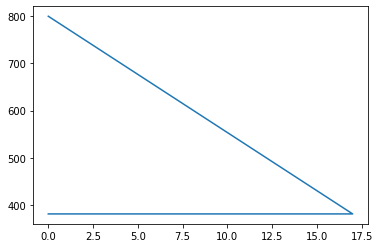

|  18       | -577.0    |  57.78    |  2.607    |  0.3121   |  0.2679   |  1.578e+0 |  1.55     |  0.473    |  20.36    |  0.0548   |  0.2942   |  2.351    |  0.9094   |  1.001    |  9.781    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.17206
    weight_decay: 0.6008338541166867
)
Batch Normalization Momentum:  0.6
Nodes:  19
LR:  0.17206
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.6008338541166867
BATCH_SIZE:  50
Dropout:  0.25
Final Linear Layers:  2
average loss: 0.693369
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4609)
Class:  0  correct:  230.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4000)
Class:  1  correct:  40.0  of  tensor(100.)
Final percentage:  tensor(0.4305)
Last epoch:  11
Credit Cost:  -569


Best Score So Far:  -381


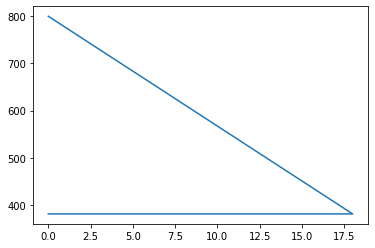

|  19       | -569.0    |  50.7     |  2.938    |  0.5987   |  0.2487   |  1.575e+0 |  2.878    |  0.1721   |  19.61    |  0.7495   |  0.6008   |  2.503    |  0.6911   |  3.585    |  3.901    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.37353
    weight_decay: 0.4744928439148743
)
Batch Normalization Momentum:  0.38
Nodes:  14
LR:  0.37353
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.4744928439148743
BATCH_SIZE:  87
Dropout:  0.12
Final Linear Layers:  1
average loss: 7.461318
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5411)
Class:  0  correct:  270.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4000)
Class:  1  correct:  40.0  of  tensor(100.)
Final percentage:  tensor(0.4705)
Last epoch:  18
Credit Cost:  -529


Best Score So Far:  -381


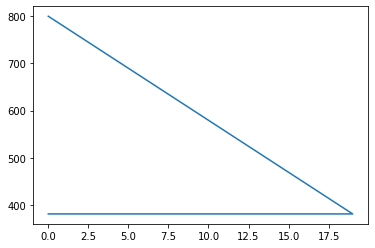

|  20       | -529.0    |  87.18    |  1.897    |  0.3783   |  0.1232   |  1.401e+0 |  1.949    |  0.3735   |  14.91    |  0.9729   |  0.4745   |  1.395    |  0.4224   |  2.027    |  8.171    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3171
    momentum: 0.76
    nesterov: False
    weight_decay: 0.513226453448729
)
Batch Normalization Momentum:  0.66
Nodes:  26
LR:  0.3171
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.513226453448729
BATCH_SIZE:  113
Dropout:  0.08
Final Linear Layers:  3
average loss: 0.693068
Class:  0  accuracy:  tensor(0.5371)
Class:  0  correct:  268.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4785)
Last epoch:  7
Credit Cost:  -521


Best Score So Far:  -381


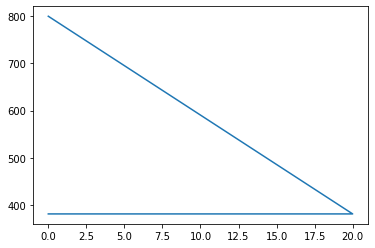

|  21       | -521.0    |  113.1    |  2.799    |  0.6561   |  0.08106  |  1.252e+0 |  3.556    |  0.3171   |  26.06    |  0.5723   |  0.5132   |  2.033    |  0.7632   |  2.701    |  5.187    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.4873
    weight_decay: 0.39868913948048845
)
Batch Normalization Momentum:  0.37
Nodes:  28
LR:  0.4873
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.39868913948048845
BATCH_SIZE:  46
Dropout:  0.02
Final Linear Layers:  1
average loss: 0.693108
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -381


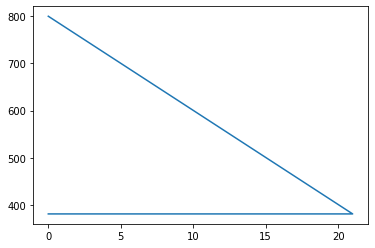

|  22       | -800.0    |  46.49    |  1.136    |  0.3741   |  0.02389  |  1.983e+0 |  1.543    |  0.4873   |  28.25    |  0.688    |  0.3987   |  1.32     |  0.4622   |  2.032    |  3.023    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.11658
    rho: 0.9
    weight_decay: 0.14581528744231315
)
Batch Normalization Momentum:  0.91
Nodes:  16
LR:  0.11658
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.14581528744231315
BATCH_SIZE:  77
Dropout:  0.27
Final Linear Layers:  1
average loss: 0.696380
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4970)
Class:  0  correct:  248.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.2700)
Class:  1  correct:  27.0  of  tensor(100.)
Final percentage:  tensor(0.3835)
Last epoch:  51
Credit Cost:  -616


Best Score So Far:  -381


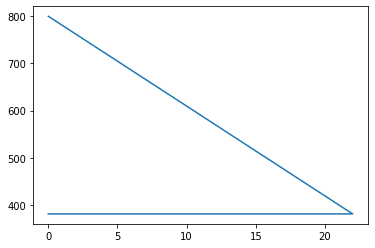

|  23       | -616.0    |  77.47    |  1.621    |  0.9071   |  0.2729   |  1.257e+0 |  1.332    |  0.1166   |  16.99    |  0.7281   |  0.1458   |  1.494    |  0.8432   |  2.243    |  6.544    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.32686
    weight_decay: 0.5260943192129571
)
Batch Normalization Momentum:  0.51
Nodes:  21
LR:  0.32686
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5260943192129571
BATCH_SIZE:  32
Dropout:  0.14
Final Linear Layers:  2
average loss: 3.026078
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4950)
Class:  0  correct:  247.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5075)
Last epoch:  9
Credit Cost:  -492


Best Score So Far:  -381


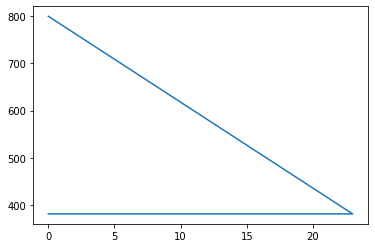

|  24       | -492.0    |  32.97    |  1.203    |  0.5107   |  0.1431   |  1.153e+0 |  2.859    |  0.3269   |  21.62    |  0.1453   |  0.5261   |  1.442    |  0.5142   |  3.348    |  1.201    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.49602
    weight_decay: 0.4559479022054596
)
Batch Normalization Momentum:  0.84
Nodes:  27
LR:  0.49602
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4559479022054596
BATCH_SIZE:  44
Dropout:  0.16
Final Linear Layers:  3
average loss: 199.418320
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5635)
Last epoch:  12
Credit Cost:  -436


Best Score So Far:  -381


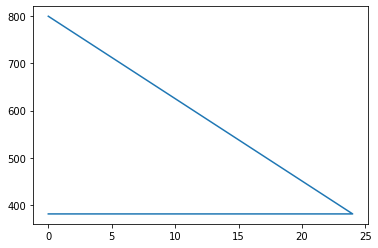

|  25       | -436.0    |  44.22    |  2.737    |  0.8363   |  0.1615   |  1.867e+0 |  3.84     |  0.496    |  27.62    |  0.09955  |  0.4559   |  2.4      |  0.6041   |  3.391    |  1.311    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.47816
    momentum: 0.14
    nesterov: False
    weight_decay: 0.693331201358326
)
Batch Normalization Momentum:  0.26
Nodes:  15
LR:  0.47816
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.693331201358326
BATCH_SIZE:  99
Dropout:  0.08
Final Linear Layers:  2
average loss: 0.693160
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5050)
Class:  0  correct:  252.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4000)
Class:  1  correct:  40.0  of  tensor(100.)
Final percentage:  tensor(0.4525)
Last epoch:  8
Credit Cost:  -547


Best Score So Far:  -381


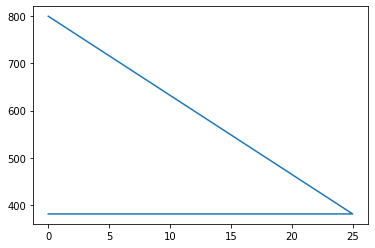

|  26       | -547.0    |  99.51    |  2.456    |  0.2571   |  0.07712  |  1.632e+0 |  2.032    |  0.4782   |  15.38    |  0.7822   |  0.6933   |  1.597    |  0.1416   |  3.695    |  5.869    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.21407
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.98
Nodes:  2
LR:  0.21407
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5219714711759764
BATCH_SIZE:  124
Dropout:  0.16
Final Linear Layers:  1
average loss: 0.694699
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4609)
Class:  0  correct:  230.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4100)
Class:  1  correct:  41.0  of  tensor(100.)
Final percentage:  tensor(0.4355)
Last epoch:  12
Credit Cost:  -564


Best Score So Far:  -381


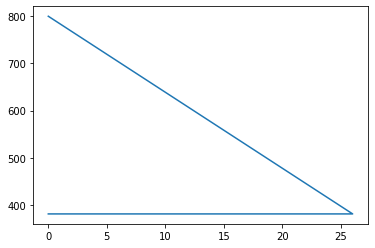

|  27       | -564.0    |  124.9    |  2.267    |  0.984    |  0.1638   |  1.526e+0 |  1.405    |  0.2141   |  2.787    |  0.1611   |  0.522    |  1.06     |  0.3629   |  3.578    |  7.227    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.14939
    weight_decay: 0.31993703167224136
)
Batch Normalization Momentum:  0.44
Nodes:  9
LR:  0.14939
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.31993703167224136
BATCH_SIZE:  89
Dropout:  0.17
Final Linear Layers:  1
average loss: 0.700872
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4609)
Class:  0  correct:  230.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5455)
Last epoch:  8
Credit Cost:  -453


Best Score So Far:  -381


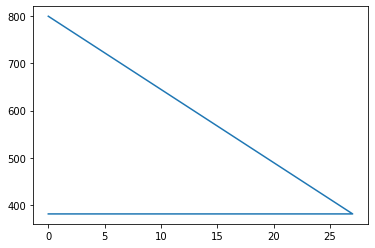

|  28       | -453.0    |  89.68    |  1.375    |  0.4375   |  0.1745   |  1.99e+03 |  1.61     |  0.1494   |  9.865    |  0.7497   |  0.3199   |  1.113    |  0.5034   |  1.634    |  8.179    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.30717
    t0: 1000000.0
    weight_decay: 0.5627922279599029
)
Batch Normalization Momentum:  0.59
Nodes:  18
LR:  0.30717
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5627922279599029
BATCH_SIZE:  40
Dropout:  0.25
Final Linear Layers:  3
average loss: 0.693184
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4910)
Class:  0  correct:  245.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4800)
Class:  1  correct:  48.0  of  tensor(100.)
Final percentage:  tensor(0.4855)
Last epoch:  8
Credit Cost:  -514


Best Score So Far:  -381


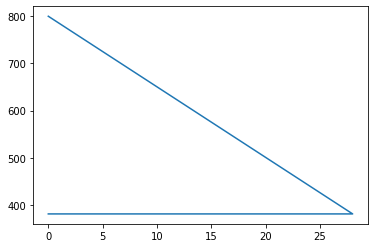

|  29       | -514.0    |  40.87    |  1.055    |  0.5875   |  0.2532   |  1.381e+0 |  3.242    |  0.3072   |  18.23    |  0.9585   |  0.5628   |  1.064    |  0.7023   |  2.39     |  9.518    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.48197
    rho: 0.9
    weight_decay: 0.2397836384784795
)
Batch Normalization Momentum:  0.08
Nodes:  22
LR:  0.48197
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.2397836384784795
BATCH_SIZE:  31
Dropout:  0.13
Final Linear Layers:  2
average loss: 0.693159
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5451)
Class:  0  correct:  272.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4925)
Last epoch:  8
Credit Cost:  -507


Best Score So Far:  -381


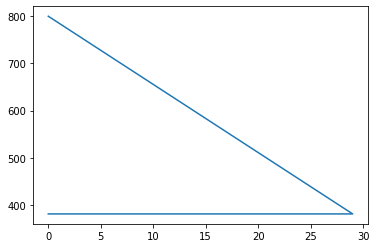

|  30       | -507.0    |  31.46    |  1.531    |  0.08066  |  0.1286   |  1.109e+0 |  2.895    |  0.482    |  22.9     |  0.7657   |  0.2398   |  2.683    |  0.4245   |  3.464    |  6.632    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01764
    momentum: 0.45
    nesterov: False
    weight_decay: 0.5228822530757068
)
Batch Normalization Momentum:  0.02
Nodes:  24
LR:  0.01764
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5228822530757068
BATCH_SIZE:  21
Dropout:  0.02
Final Linear Layers:  1
average loss: 0.693130
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5471)
Class:  0  correct:  273.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3400)
Class:  1  correct:  34.0  of  tensor(100.)
Final percentage:  tensor(0.4435)
Last epoch:  8
Credit Cost:  -556


Best Score So Far:  -381


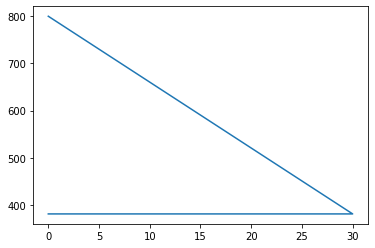

|  31       | -556.0    |  21.78    |  1.156    |  0.01815  |  0.02002  |  1.459e+0 |  1.339    |  0.01764  |  24.65    |  0.3951   |  0.5229   |  1.9      |  0.4456   |  2.429    |  5.261    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.37149
    t0: 1000000.0
    weight_decay: 0.002212267838055494
)
Batch Normalization Momentum:  0.9
Nodes:  2
LR:  0.37149
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.002212267838055494
BATCH_SIZE:  103
Dropout:  0.01
Final Linear Layers:  1
average loss: 0.692282
Class:  0  accuracy:  tensor(0.5611)
Class:  0  correct:  280.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.5606)
Last epoch:  7
Credit Cost:  -439


Best Score So Far:  -381


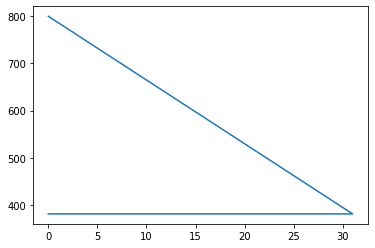

|  32       | -439.0    |  103.6    |  1.801    |  0.8956   |  0.01112  |  1.774e+0 |  1.376    |  0.3715   |  2.311    |  0.5386   |  0.002212 |  2.893    |  0.8963   |  3.38     |  9.228    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.42696
    weight_decay: 0.2806715252865475
)
Batch Normalization Momentum:  0.19
Nodes:  23
LR:  0.42696
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.2806715252865475
BATCH_SIZE:  22
Dropout:  0.19
Final Linear Layers:  3
average loss: 1.826473
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4329)
Class:  0  correct:  216.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.4964)
Last epoch:  10
Credit Cost:  -503


Best Score So Far:  -381


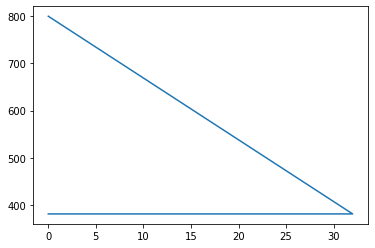

|  33       | -503.0    |  22.05    |  1.314    |  0.1858   |  0.1867   |  1.906e+0 |  3.96     |  0.427    |  23.95    |  0.9085   |  0.2807   |  1.497    |  0.1717   |  1.357    |  8.305    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.32066
    weight_decay: 0.256652995031479
)
Batch Normalization Momentum:  0.81
Nodes:  11
LR:  0.32066
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.256652995031479
BATCH_SIZE:  22
Dropout:  0.09
Final Linear Layers:  1
average loss: 0.818119
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4749)
Class:  0  correct:  237.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.4625)
Last epoch:  9
Credit Cost:  -537


Best Score So Far:  -381


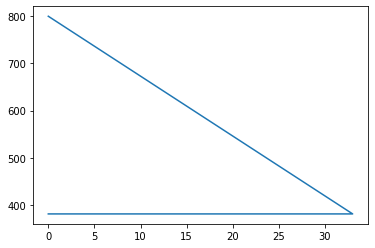

|  34       | -537.0    |  22.2     |  1.526    |  0.8109   |  0.09318  |  1.982e+0 |  1.797    |  0.3207   |  11.43    |  0.91     |  0.2567   |  1.863    |  0.5072   |  3.807    |  1.278    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.33555
    weight_decay: 0.43985349536119783
)
Batch Normalization Momentum:  0.03
Nodes:  22
LR:  0.33555
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.43985349536119783
BATCH_SIZE:  92
Dropout:  0.16
Final Linear Layers:  3
average loss: 0.693814
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4970)
Class:  0  correct:  248.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4635)
Last epoch:  11
Credit Cost:  -536


Best Score So Far:  -381


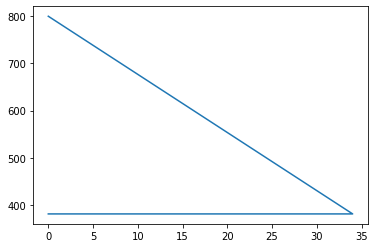

|  35       | -536.0    |  92.89    |  2.773    |  0.02701  |  0.1566   |  1.326e+0 |  3.57     |  0.3356   |  22.71    |  0.4529   |  0.4399   |  1.577    |  0.009255 |  2.725    |  3.8      |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.56218
    weight_decay: 0.1596074129369267
)
Batch Normalization Momentum:  0.42
Nodes:  27
LR:  0.56218
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.1596074129369267
BATCH_SIZE:  68
Dropout:  0.07
Final Linear Layers:  3
average loss: 120.032745
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4569)
Class:  0  correct:  228.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.4785)
Last epoch:  19
Credit Cost:  -521


Best Score So Far:  -381


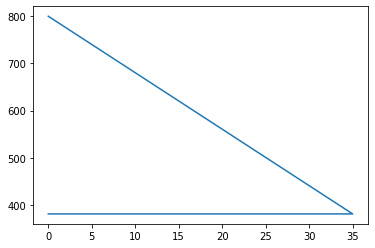

|  36       | -521.0    |  68.14    |  2.824    |  0.4222   |  0.07422  |  1.371e+0 |  3.786    |  0.5622   |  27.33    |  0.9194   |  0.1596   |  1.174    |  0.225    |  1.94     |  2.571    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.34496
    weight_decay: 0.16024668830516706
)
Batch Normalization Momentum:  0.81
Nodes:  12
LR:  0.34496
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.16024668830516706
BATCH_SIZE:  79
Dropout:  0.06
Final Linear Layers:  1
average loss: 3.016931
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5371)
Class:  0  correct:  268.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5900)
Class:  1  correct:  59.0  of  tensor(100.)
Final percentage:  tensor(0.5635)
Last epoch:  17
Credit Cost:  -436


Best Score So Far:  -381


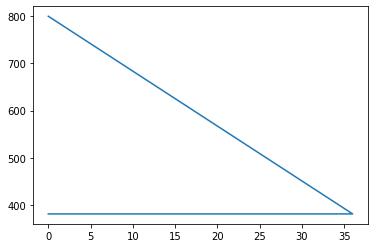

|  37       | -436.0    |  79.28    |  1.823    |  0.8082   |  0.05554  |  1.702e+0 |  1.719    |  0.345    |  12.47    |  0.05785  |  0.1602   |  2.322    |  0.4923   |  2.552    |  2.571    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.35777
    weight_decay: 0.04585366335805425
)
Batch Normalization Momentum:  0.81
Nodes:  2
LR:  0.35777
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.04585366335805425
BATCH_SIZE:  74
Dropout:  0.18
Final Linear Layers:  3
average loss: 0.687862
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5511)
Class:  0  correct:  275.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5306)
Last epoch:  11
Credit Cost:  -469


Best Score So Far:  -381


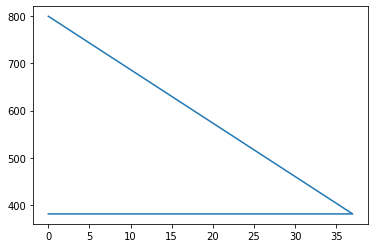

|  38       | -469.0    |  74.77    |  2.984    |  0.8087   |  0.1783   |  1.976e+0 |  3.696    |  0.3578   |  2.973    |  0.09439  |  0.04585  |  1.899    |  0.3717   |  3.916    |  2.51     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.00887
    weight_decay: 0.511090838641964
)
Batch Normalization Momentum:  0.82
Nodes:  12
LR:  0.00887
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.511090838641964
BATCH_SIZE:  124
Dropout:  0.19
Final Linear Layers:  2
average loss: 0.692858
Class:  0  accuracy:  tensor(0.5491)
Class:  0  correct:  274.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5945)
Last epoch:  7
Credit Cost:  -405


Best Score So Far:  -381


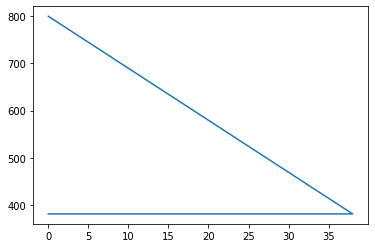

|  39       | -405.0    |  124.6    |  2.527    |  0.816    |  0.1898   |  1.669e+0 |  2.426    |  0.008869 |  12.59    |  0.4921   |  0.5111   |  1.933    |  0.4528   |  1.412    |  1.098    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.45318
    weight_decay: 0.21881971480658544
)
Batch Normalization Momentum:  0.97
Nodes:  15
LR:  0.45318
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.21881971480658544
BATCH_SIZE:  98
Dropout:  0.07
Final Linear Layers:  2
average loss: 1.423396
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5371)
Class:  0  correct:  268.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5235)
Last epoch:  12
Credit Cost:  -476


Best Score So Far:  -381


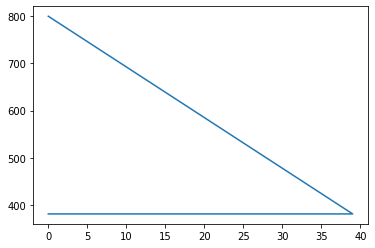

|  40       | -476.0    |  98.03    |  1.637    |  0.9745   |  0.06607  |  1.339e+0 |  2.566    |  0.4532   |  15.92    |  0.1256   |  0.2188   |  2.004    |  0.6671   |  3.303    |  2.172    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.2701
    rho: 0.9
    weight_decay: 0.0037673623722609484
)
Batch Normalization Momentum:  0.8
Nodes:  29
LR:  0.2701
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.0037673623722609484
BATCH_SIZE:  6
Dropout:  0.0
Final Linear Layers:  3
average loss: 0.690277
Class:  0  accuracy:  tensor(0.4870)
Class:  0  correct:  243.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6800)
Class:  1  correct:  68.0  of  tensor(100.)
Final percentage:  tensor(0.5835)
Last epoch:  7
Credit Cost:  -416


Best Score So Far:  -381


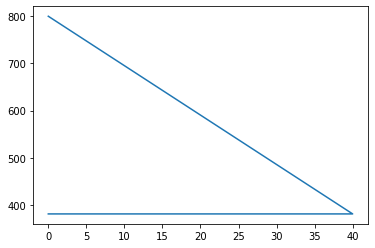

|  41       | -416.0    |  6.841    |  2.033    |  0.8019   |  0.003781 |  1.672e+0 |  3.054    |  0.2701   |  29.44    |  0.6441   |  0.003767 |  1.964    |  0.8507   |  3.483    |  6.836    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.51364
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.27
Nodes:  7
LR:  0.51364
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.20279296205619549
BATCH_SIZE:  87
Dropout:  0.17
Final Linear Layers:  2
average loss: 0.693068
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5110)
Class:  0  correct:  255.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.5055)
Last epoch:  9
Credit Cost:  -494


Best Score So Far:  -381


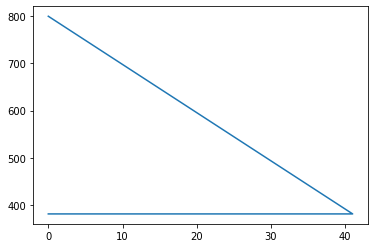

|  42       | -494.0    |  87.54    |  2.151    |  0.2714   |  0.1682   |  1.672e+0 |  2.054    |  0.5136   |  7.851    |  0.7468   |  0.2028   |  2.54     |  0.4235   |  3.415    |  4.178    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.12925
    weight_decay: 0.2640201111852131
)
Batch Normalization Momentum:  0.31
Nodes:  7
LR:  0.12925
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.2640201111852131
BATCH_SIZE:  30
Dropout:  0.22
Final Linear Layers:  1
average loss: 0.693077
Class:  0  accuracy:  tensor(0.4489)
Class:  0  correct:  224.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.5144)
Last epoch:  7
Credit Cost:  -484


Best Score So Far:  -381


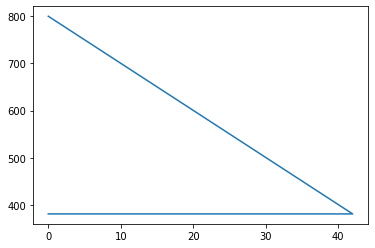

|  43       | -484.0    |  30.5     |  2.527    |  0.3056   |  0.22     |  1.744e+0 |  1.662    |  0.1293   |  7.968    |  0.1432   |  0.264    |  1.053    |  0.1098   |  3.017    |  8.19     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.18341
    t0: 1000000.0
    weight_decay: 0.6464270049616307
)
Batch Normalization Momentum:  0.21
Nodes:  27
LR:  0.18341
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6464270049616307
BATCH_SIZE:  13
Dropout:  0.28
Final Linear Layers:  2
average loss: 0.693146
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -381


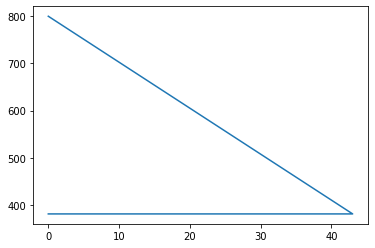

|  44       | -800.0    |  13.99    |  1.461    |  0.2055   |  0.2752   |  1.711e+0 |  2.656    |  0.1834   |  27.05    |  0.4354   |  0.6464   |  2.405    |  0.4733   |  1.377    |  9.775    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.11406
    rho: 0.9
    weight_decay: 0.14759160121911616
)
Batch Normalization Momentum:  0.43
Nodes:  21
LR:  0.11406
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.14759160121911616
BATCH_SIZE:  23
Dropout:  0.12
Final Linear Layers:  3
average loss: 0.693424
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4850)
Class:  0  correct:  242.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6200)
Class:  1  correct:  62.0  of  tensor(100.)
Final percentage:  tensor(0.5525)
Last epoch:  12
Credit Cost:  -446


Best Score So Far:  -381


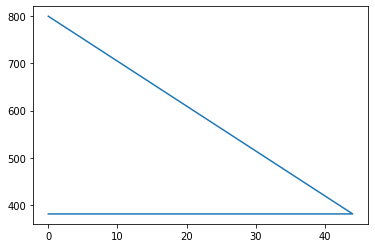

|  45       | -446.0    |  23.82    |  1.403    |  0.4269   |  0.1213   |  1.147e+0 |  3.181    |  0.1141   |  21.32    |  0.7538   |  0.1476   |  2.196    |  0.7414   |  2.908    |  6.368    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.50133
    momentum: 0.9
    nesterov: False
    weight_decay: 0.21012672404315696
)
Batch Normalization Momentum:  0.94
Nodes:  7
LR:  0.50133
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.21012672404315696
BATCH_SIZE:  40
Dropout:  0.13
Final Linear Layers:  1
average loss: 0.693153
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5010)
Class:  0  correct:  250.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5505)
Last epoch:  9
Credit Cost:  -449


Best Score So Far:  -381


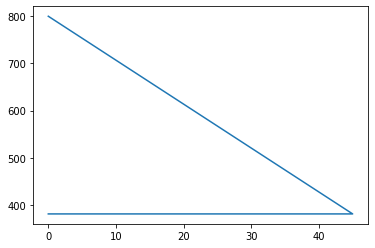

|  46       | -449.0    |  40.64    |  2.456    |  0.9359   |  0.1277   |  1.782e+0 |  1.168    |  0.5013   |  7.768    |  0.3953   |  0.2101   |  1.159    |  0.8956   |  2.107    |  5.771    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.21488
    weight_decay: 0.07469805536448189
)
Batch Normalization Momentum:  0.2
Nodes:  5
LR:  0.21488
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.07469805536448189
BATCH_SIZE:  65
Dropout:  0.02
Final Linear Layers:  1
average loss: 0.694620
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4810)
Class:  0  correct:  240.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6200)
Class:  1  correct:  62.0  of  tensor(100.)
Final percentage:  tensor(0.5505)
Last epoch:  11
Credit Cost:  -449


Best Score So Far:  -381


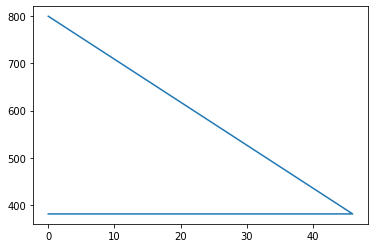

|  47       | -449.0    |  65.27    |  1.263    |  0.2044   |  0.02286  |  1.508e+0 |  1.782    |  0.2149   |  5.242    |  0.787    |  0.0747   |  2.962    |  0.1754   |  2.711    |  1.403    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.13075
    rho: 0.9
    weight_decay: 0.1236666690905304
)
Batch Normalization Momentum:  0.52
Nodes:  24
LR:  0.13075
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.1236666690905304
BATCH_SIZE:  101
Dropout:  0.22
Final Linear Layers:  2
average loss: 0.693955
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5070)
Class:  0  correct:  253.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5135)
Last epoch:  40
Credit Cost:  -486


Best Score So Far:  -381


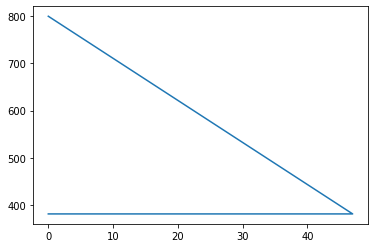

|  48       | -486.0    |  101.6    |  1.377    |  0.5226   |  0.222    |  1.15e+03 |  2.648    |  0.1308   |  24.78    |  0.7225   |  0.1237   |  2.715    |  0.01958  |  3.572    |  6.025    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.56041
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.71
Nodes:  27
LR:  0.56041
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.3617304791667847
BATCH_SIZE:  53
Dropout:  0.3
Final Linear Layers:  1
average loss: 0.691001
Class:  0  accuracy:  tensor(0.4850)
Class:  0  correct:  242.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6700)
Class:  1  correct:  67.0  of  tensor(100.)
Final percentage:  tensor(0.5775)
Last epoch:  7
Credit Cost:  -422


Best Score So Far:  -381


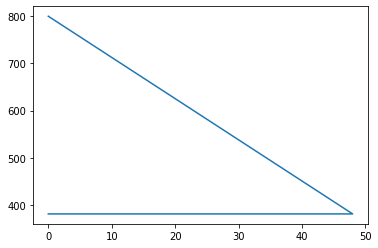

|  49       | -422.0    |  54.0     |  2.51     |  0.7098   |  0.2962   |  1.278e+0 |  1.011    |  0.5604   |  27.74    |  0.7284   |  0.3617   |  2.407    |  0.7727   |  2.121    |  7.925    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.53795
    weight_decay: 0.15427676305682994
)
Batch Normalization Momentum:  0.4
Nodes:  9
LR:  0.53795
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.15427676305682994
BATCH_SIZE:  97
Dropout:  0.21
Final Linear Layers:  3
average loss: 0.693159
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5311)
Class:  0  correct:  265.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.5155)
Last epoch:  8
Credit Cost:  -484


Best Score So Far:  -381


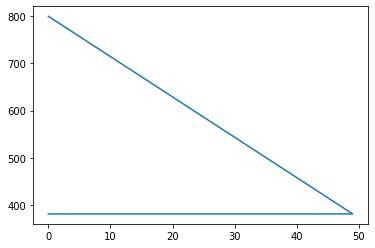

|  50       | -484.0    |  97.08    |  2.22     |  0.3978   |  0.2092   |  1.003e+0 |  3.317    |  0.538    |  9.179    |  0.1215   |  0.1543   |  1.601    |  0.8742   |  2.624    |  3.578    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.49705
    rho: 0.9
    weight_decay: 0.47251262620589274
)
Batch Normalization Momentum:  0.61
Nodes:  14
LR:  0.49705
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.47251262620589274
BATCH_SIZE:  21
Dropout:  0.1
Final Linear Layers:  2
average loss: 0.693254
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4890)
Class:  0  correct:  244.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3900)
Class:  1  correct:  39.0  of  tensor(100.)
Final percentage:  tensor(0.4395)
Last epoch:  8
Credit Cost:  -560


Best Score So Far:  -381


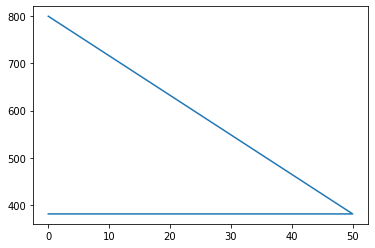

|  51       | -560.0    |  21.16    |  1.577    |  0.6077   |  0.09724  |  1.457e+0 |  2.328    |  0.4971   |  14.79    |  0.346    |  0.4725   |  1.441    |  0.4626   |  1.941    |  6.635    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.26036
    weight_decay: 0.5367655336072478
)
Batch Normalization Momentum:  0.78
Nodes:  29
LR:  0.26036
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5367655336072478
BATCH_SIZE:  112
Dropout:  0.14
Final Linear Layers:  1
average loss: 0.950009
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5150)
Class:  0  correct:  257.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5125)
Last epoch:  12
Credit Cost:  -487


Best Score So Far:  -381


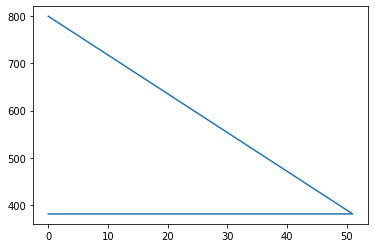

|  52       | -487.0    |  112.8    |  1.891    |  0.7766   |  0.1371   |  1.656e+0 |  1.394    |  0.2604   |  29.28    |  0.6053   |  0.5368   |  2.004    |  0.4931   |  3.52     |  1.61     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.42073
    weight_decay: 0.4370732580116328
)
Batch Normalization Momentum:  0.51
Nodes:  18
LR:  0.42073
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4370732580116328
BATCH_SIZE:  75
Dropout:  0.06
Final Linear Layers:  1
average loss: 10.489147
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5391)
Class:  0  correct:  269.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3400)
Class:  1  correct:  34.0  of  tensor(100.)
Final percentage:  tensor(0.4395)
Last epoch:  10
Credit Cost:  -560


Best Score So Far:  -381


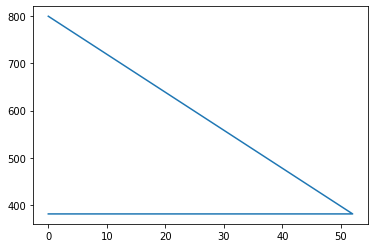

|  53       | -560.0    |  75.09    |  2.876    |  0.5127   |  0.05834  |  1.848e+0 |  1.752    |  0.4207   |  18.21    |  0.9479   |  0.4371   |  2.668    |  0.007854 |  3.958    |  1.699    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.15419
    weight_decay: 0.09412359219812172
)
Batch Normalization Momentum:  0.01
Nodes:  26
LR:  0.15419
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.09412359219812172
BATCH_SIZE:  43
Dropout:  0.25
Final Linear Layers:  2
average loss: 1.014155
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4930)
Class:  0  correct:  246.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6600)
Class:  1  correct:  66.0  of  tensor(100.)
Final percentage:  tensor(0.5765)
Last epoch:  9
Credit Cost:  -423


Best Score So Far:  -381


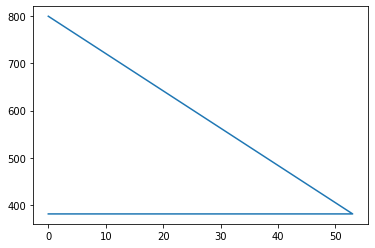

|  54       | -423.0    |  43.94    |  2.883    |  0.00885  |  0.2468   |  1.861e+0 |  2.315    |  0.1542   |  26.08    |  0.4779   |  0.09412  |  2.846    |  0.887    |  2.47     |  8.702    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.17724
    momentum: 0.56
    nesterov: False
    weight_decay: 0.009963196705290823
)
Batch Normalization Momentum:  0.39
Nodes:  5
LR:  0.17724
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.009963196705290823
BATCH_SIZE:  55
Dropout:  0.15
Final Linear Layers:  3
average loss: 0.691765
Class:  0  accuracy:  tensor(0.4609)
Class:  0  correct:  230.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.5105)
Last epoch:  7
Credit Cost:  -488


Best Score So Far:  -381


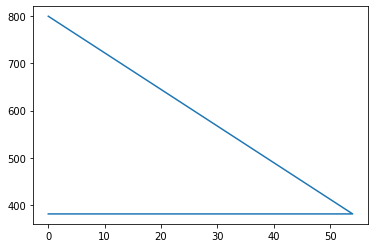

|  55       | -488.0    |  55.9     |  2.36     |  0.394    |  0.1517   |  1.19e+03 |  3.885    |  0.1772   |  5.104    |  0.145    |  0.009963 |  2.425    |  0.5589   |  3.376    |  5.559    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.19377
    t0: 1000000.0
    weight_decay: 0.16906898170112258
)
Batch Normalization Momentum:  0.77
Nodes:  7
LR:  0.19377
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.16906898170112258
BATCH_SIZE:  102
Dropout:  0.12
Final Linear Layers:  1
average loss: 0.694481
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4649)
Class:  0  correct:  232.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5325)
Last epoch:  25
Credit Cost:  -467


Best Score So Far:  -381


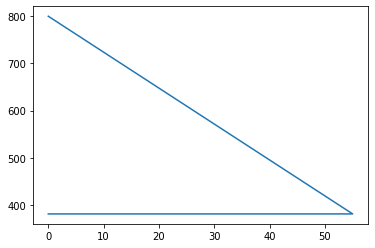

|  56       | -467.0    |  102.2    |  2.385    |  0.7701   |  0.1219   |  1.648e+0 |  1.538    |  0.1938   |  7.178    |  0.4088   |  0.1691   |  1.81     |  0.9655   |  1.958    |  9.833    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.26033
    momentum: 0.8
    nesterov: False
    weight_decay: 0.48818847604163623
)
Batch Normalization Momentum:  0.85
Nodes:  12
LR:  0.26033
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.48818847604163623
BATCH_SIZE:  82
Dropout:  0.19
Final Linear Layers:  3
average loss: 0.693142
Class:  0  accuracy:  tensor(0.5110)
Class:  0  correct:  255.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4100)
Class:  1  correct:  41.0  of  tensor(100.)
Final percentage:  tensor(0.4605)
Last epoch:  7
Credit Cost:  -539


Best Score So Far:  -381


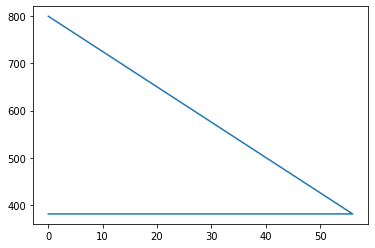

|  57       | -539.0    |  82.9     |  1.746    |  0.8489   |  0.1859   |  1.252e+0 |  3.371    |  0.2603   |  12.73    |  0.3306   |  0.4882   |  1.535    |  0.8002   |  1.883    |  5.892    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.26822
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.88
Nodes:  29
LR:  0.26822
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.4262209388182376
BATCH_SIZE:  64
Dropout:  0.06
Final Linear Layers:  3
average loss: 0.692774
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5371)
Class:  0  correct:  268.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5285)
Last epoch:  14
Credit Cost:  -471


Best Score So Far:  -381


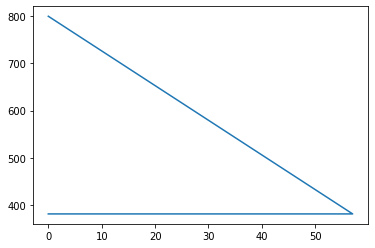

|  58       | -471.0    |  64.5     |  2.702    |  0.8795   |  0.05532  |  1.585e+0 |  3.686    |  0.2682   |  29.66    |  0.2794   |  0.4262   |  2.358    |  0.2259   |  1.041    |  4.746    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.43035
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.77
Nodes:  22
LR:  0.43035
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.17745188453696112
BATCH_SIZE:  120
Dropout:  0.05
Final Linear Layers:  1
average loss: 0.692876
Class:  0  accuracy:  tensor(0.5571)
Class:  0  correct:  278.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.5036)
Last epoch:  7
Credit Cost:  -496


Best Score So Far:  -381


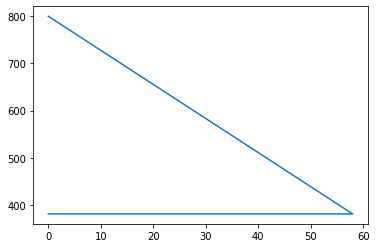

|  59       | -496.0    |  120.4    |  1.683    |  0.7719   |  0.05242  |  1.342e+0 |  1.432    |  0.4303   |  22.98    |  0.6881   |  0.1775   |  2.378    |  0.225    |  2.27     |  4.344    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.10279
    momentum: 0.46
    nesterov: False
    weight_decay: 0.6127453751755418
)
Batch Normalization Momentum:  0.63
Nodes:  6
LR:  0.10279
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.6127453751755418
BATCH_SIZE:  48
Dropout:  0.21
Final Linear Layers:  2
average loss: 0.693317
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4970)
Class:  0  correct:  248.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3800)
Class:  1  correct:  38.0  of  tensor(100.)
Final percentage:  tensor(0.4385)
Last epoch:  9
Credit Cost:  -561


Best Score So Far:  -381


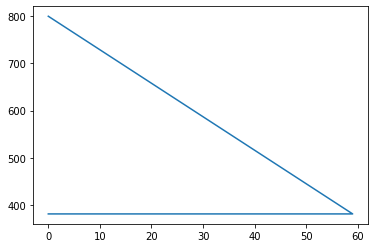

|  60       | -561.0    |  48.06    |  1.115    |  0.6253   |  0.2122   |  1.614e+0 |  2.938    |  0.1028   |  6.483    |  0.5141   |  0.6127   |  1.366    |  0.4582   |  2.283    |  5.471    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.3646
    weight_decay: 0.20793326534225448
)
Batch Normalization Momentum:  0.26
Nodes:  6
LR:  0.3646
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.20793326534225448
BATCH_SIZE:  24
Dropout:  0.25
Final Linear Layers:  2
average loss: 1.584587
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4830)
Class:  0  correct:  241.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5565)
Last epoch:  13
Credit Cost:  -443


Best Score So Far:  -381


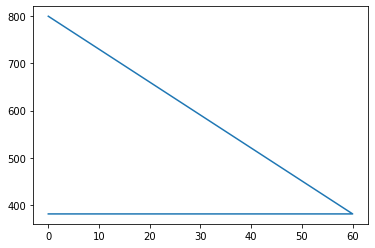

|  61       | -443.0    |  24.03    |  1.681    |  0.2593   |  0.2534   |  1.8e+03  |  2.276    |  0.3646   |  6.364    |  0.5096   |  0.2079   |  2.711    |  0.6649   |  2.894    |  2.122    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.33983
    t0: 1000000.0
    weight_decay: 0.4195289019850552
)
Batch Normalization Momentum:  0.94
Nodes:  16
LR:  0.33983
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.4195289019850552
BATCH_SIZE:  62
Dropout:  0.19
Final Linear Layers:  2
average loss: 0.693248
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5731)
Class:  0  correct:  286.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3200)
Class:  1  correct:  32.0  of  tensor(100.)
Final percentage:  tensor(0.4466)
Last epoch:  9
Credit Cost:  -553


Best Score So Far:  -381


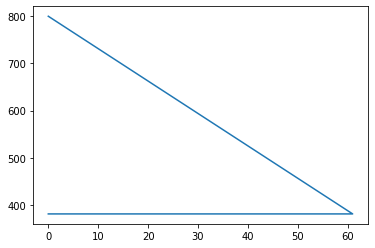

|  62       | -553.0    |  62.35    |  2.963    |  0.9388   |  0.1935   |  1.152e+0 |  2.911    |  0.3398   |  16.06    |  0.4282   |  0.4195   |  2.691    |  0.7436   |  2.732    |  9.313    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.37458
    weight_decay: 0.042819573115657796
)
Batch Normalization Momentum:  0.05
Nodes:  3
LR:  0.37458
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.042819573115657796
BATCH_SIZE:  12
Dropout:  0.06
Final Linear Layers:  1
average loss: 0.704805
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5190)
Class:  0  correct:  259.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4000)
Class:  1  correct:  40.0  of  tensor(100.)
Final percentage:  tensor(0.4595)
Last epoch:  9
Credit Cost:  -540


Best Score So Far:  -381


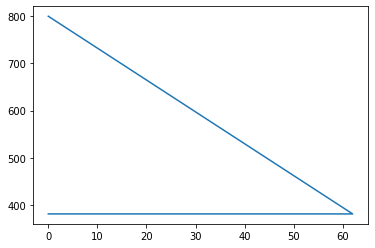

|  63       | -540.0    |  12.03    |  2.973    |  0.05246  |  0.05985  |  1.423e+0 |  1.321    |  0.3746   |  3.44     |  0.2851   |  0.04282  |  2.4      |  0.6618   |  2.132    |  2.692    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.38689
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.79
Nodes:  12
LR:  0.38689
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.3037749750105692
BATCH_SIZE:  96
Dropout:  0.15
Final Linear Layers:  1
average loss: 0.694153
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5311)
Class:  0  correct:  265.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.4955)
Last epoch:  14
Credit Cost:  -504


Best Score So Far:  -381


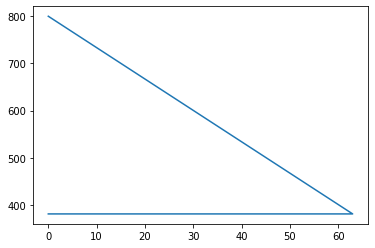

|  64       | -504.0    |  96.63    |  1.677    |  0.7873   |  0.1464   |  1.526e+0 |  1.085    |  0.3869   |  12.52    |  0.2297   |  0.3038   |  1.761    |  0.4651   |  3.929    |  4.276    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.02708
    weight_decay: 0.2635166153592925
)
Batch Normalization Momentum:  0.88
Nodes:  30
LR:  0.02708
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.2635166153592925
BATCH_SIZE:  100
Dropout:  0.11
Final Linear Layers:  3
average loss: 0.692498
Class:  0  accuracy:  tensor(0.4910)
Class:  0  correct:  245.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6500)
Class:  1  correct:  65.0  of  tensor(100.)
Final percentage:  tensor(0.5705)
Last epoch:  7
Credit Cost:  -429


Best Score So Far:  -381


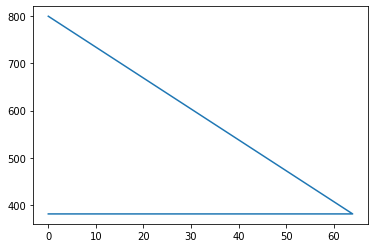

|  65       | -429.0    |  100.0    |  2.1      |  0.8802   |  0.1065   |  1.246e+0 |  3.724    |  0.02708  |  30.52    |  0.5563   |  0.2635   |  2.98     |  0.05778  |  2.545    |  1.28     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.42537
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.62
Nodes:  25
LR:  0.42537
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.3700205897752778
BATCH_SIZE:  74
Dropout:  0.29
Final Linear Layers:  2
average loss: 0.693790
Class:  0  accuracy:  tensor(0.5471)
Class:  0  correct:  273.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3600)
Class:  1  correct:  36.0  of  tensor(100.)
Final percentage:  tensor(0.4535)
Last epoch:  7
Credit Cost:  -546


Best Score So Far:  -381


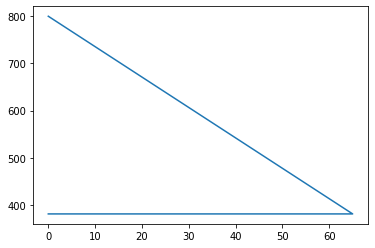

|  66       | -546.0    |  74.83    |  1.359    |  0.6246   |  0.2943   |  1.875e+0 |  2.351    |  0.4254   |  25.32    |  0.4949   |  0.37     |  1.3      |  0.3657   |  1.425    |  7.535    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.04414
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.88
Nodes:  14
LR:  0.04414
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.20387864299264438
BATCH_SIZE:  63
Dropout:  0.16
Final Linear Layers:  1
average loss: 0.693631
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4649)
Class:  0  correct:  232.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5375)
Last epoch:  11
Credit Cost:  -462


Best Score So Far:  -381


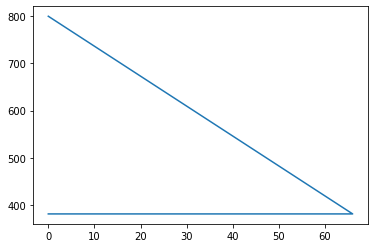

|  67       | -462.0    |  63.15    |  1.893    |  0.8771   |  0.1583   |  1.409e+0 |  1.804    |  0.04414  |  14.54    |  0.0267   |  0.2039   |  2.002    |  0.9563   |  1.327    |  7.051    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.11581
    rho: 0.9
    weight_decay: 0.15190235217949552
)
Batch Normalization Momentum:  0.14
Nodes:  25
LR:  0.11581
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.15190235217949552
BATCH_SIZE:  65
Dropout:  0.02
Final Linear Layers:  3
average loss: 0.694007
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5351)
Class:  0  correct:  267.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3200)
Class:  1  correct:  32.0  of  tensor(100.)
Final percentage:  tensor(0.4275)
Last epoch:  44
Credit Cost:  -572


Best Score So Far:  -381


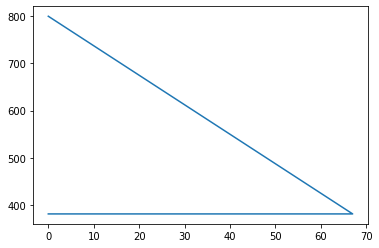

|  68       | -572.0    |  65.99    |  2.546    |  0.1422   |  0.02496  |  1.399e+0 |  3.383    |  0.1158   |  25.03    |  0.2907   |  0.1519   |  1.033    |  0.3947   |  2.139    |  6.928    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.19329
    weight_decay: 0.5841571111612189
)
Batch Normalization Momentum:  0.02
Nodes:  18
LR:  0.19329
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.5841571111612189
BATCH_SIZE:  12
Dropout:  0.03
Final Linear Layers:  2
average loss: 0.700905
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5411)
Class:  0  correct:  270.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.5205)
Last epoch:  9
Credit Cost:  -479


Best Score So Far:  -381


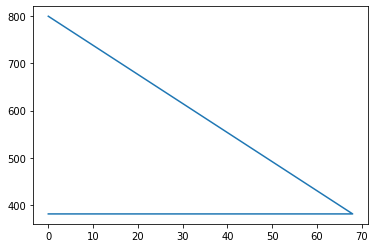

|  69       | -479.0    |  12.79    |  1.304    |  0.01641  |  0.03414  |  1.652e+0 |  2.204    |  0.1933   |  18.74    |  0.9925   |  0.5842   |  2.392    |  0.9091   |  1.119    |  1.632    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.26853
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.93
Nodes:  28
LR:  0.26853
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.19173941194026017
BATCH_SIZE:  62
Dropout:  0.15
Final Linear Layers:  3
average loss: 0.692204
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5431)
Class:  0  correct:  271.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4100)
Class:  1  correct:  41.0  of  tensor(100.)
Final percentage:  tensor(0.4765)
Last epoch:  14
Credit Cost:  -523


Best Score So Far:  -381


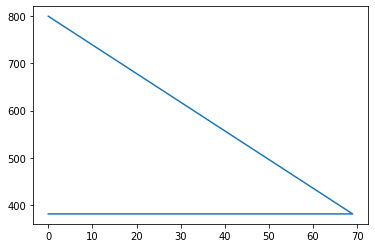

|  70       | -523.0    |  62.78    |  1.695    |  0.9279   |  0.1469   |  1.54e+03 |  3.677    |  0.2685   |  28.31    |  0.2541   |  0.1917   |  1.653    |  0.5421   |  1.658    |  7.036    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.31596
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.86
Nodes:  4
LR:  0.31596
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.6657998193312425
BATCH_SIZE:  21
Dropout:  0.07
Final Linear Layers:  2
average loss: 0.692720
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4729)
Class:  0  correct:  236.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4715)
Last epoch:  12
Credit Cost:  -527


Best Score So Far:  -381


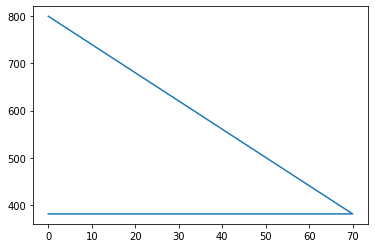

|  71       | -527.0    |  21.71    |  1.187    |  0.8615   |  0.07106  |  1.386e+0 |  2.709    |  0.316    |  4.281    |  0.8734   |  0.6658   |  2.617    |  0.281    |  2.578    |  4.051    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.19616
    weight_decay: 0.533866203602033
)
Batch Normalization Momentum:  0.31
Nodes:  28
LR:  0.19616
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.533866203602033
BATCH_SIZE:  72
Dropout:  0.2
Final Linear Layers:  3
average loss: 0.693442
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5331)
Class:  0  correct:  266.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5215)
Last epoch:  10
Credit Cost:  -478


Best Score So Far:  -381


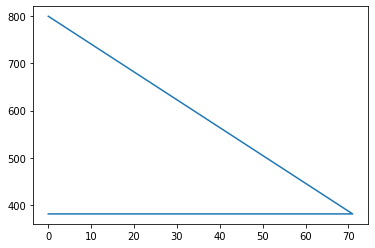

|  72       | -478.0    |  72.78    |  2.939    |  0.3086   |  0.2006   |  1.326e+0 |  3.316    |  0.1962   |  28.69    |  0.7512   |  0.5339   |  1.934    |  0.2087   |  1.124    |  3.893    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.02488
    rho: 0.9
    weight_decay: 0.23503109443513837
)
Batch Normalization Momentum:  0.66
Nodes:  6
LR:  0.02488
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.23503109443513837
BATCH_SIZE:  8
Dropout:  0.13
Final Linear Layers:  2
average loss: 0.693801
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5150)
Class:  0  correct:  257.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.4825)
Last epoch:  18
Credit Cost:  -517


Best Score So Far:  -381


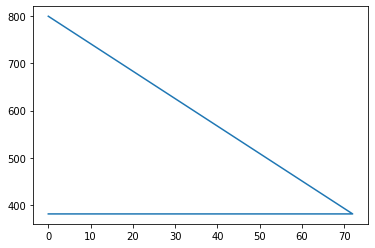

|  73       | -517.0    |  8.602    |  2.381    |  0.6636   |  0.1291   |  1.768e+0 |  2.603    |  0.02488  |  6.044    |  0.194    |  0.235    |  1.104    |  0.5991   |  2.531    |  6.551    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.49398
    weight_decay: 0.16462679767730107
)
Batch Normalization Momentum:  0.45
Nodes:  30
LR:  0.49398
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.16462679767730107
BATCH_SIZE:  57
Dropout:  0.0
Final Linear Layers:  2
average loss: 426.458435
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4850)
Class:  0  correct:  242.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5575)
Last epoch:  15
Credit Cost:  -441


Best Score So Far:  -381


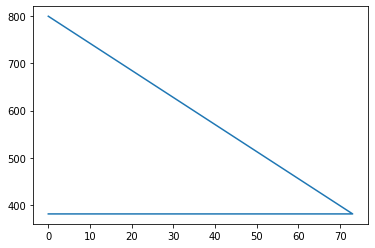

|  74       | -441.0    |  57.61    |  2.687    |  0.4495   |  0.004621 |  1.873e+0 |  2.962    |  0.494    |  30.55    |  0.05181  |  0.1646   |  1.126    |  0.4174   |  3.583    |  1.734    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.14441
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.77
Nodes:  30
LR:  0.14441
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.42979240826905213
BATCH_SIZE:  62
Dropout:  0.25
Final Linear Layers:  2
average loss: 0.694327
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4349)
Class:  0  correct:  217.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4524)
Last epoch:  9
Credit Cost:  -547


Best Score So Far:  -381


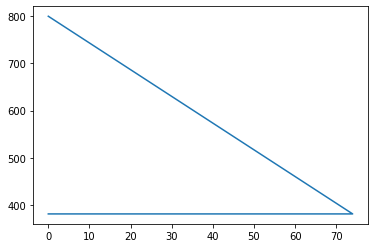

|  75       | -547.0    |  62.67    |  1.25     |  0.7652   |  0.2524   |  1.043e+0 |  2.454    |  0.1444   |  30.57    |  0.943    |  0.4298   |  2.937    |  0.3414   |  3.685    |  4.907    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.36335
    weight_decay: 0.4203822197966536
)
Batch Normalization Momentum:  0.68
Nodes:  23
LR:  0.36335
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.4203822197966536
BATCH_SIZE:  33
Dropout:  0.02
Final Linear Layers:  3
average loss: 9.476834
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4569)
Class:  0  correct:  228.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5485)
Last epoch:  11
Credit Cost:  -451


Best Score So Far:  -381


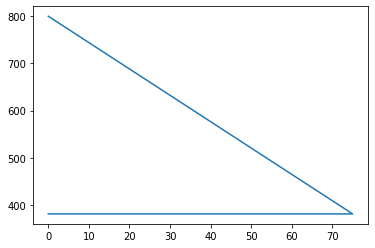

|  76       | -451.0    |  33.24    |  2.872    |  0.6774   |  0.01947  |  1.87e+03 |  3.097    |  0.3634   |  23.97    |  0.2539   |  0.4204   |  2.621    |  0.05357  |  1.39     |  8.574    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03959
    momentum: 0.48
    nesterov: False
    weight_decay: 0.5783766520911247
)
Batch Normalization Momentum:  0.25
Nodes:  28
LR:  0.03959
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.5783766520911247
BATCH_SIZE:  80
Dropout:  0.09
Final Linear Layers:  2
average loss: 0.692965
Class:  0  accuracy:  tensor(0.5230)
Class:  0  correct:  261.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.4865)
Last epoch:  7
Credit Cost:  -513


Best Score So Far:  -381


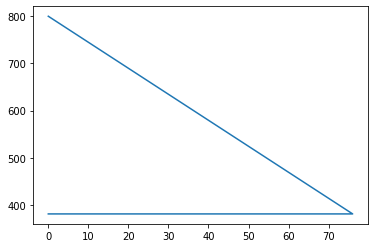

|  77       | -513.0    |  80.67    |  2.057    |  0.2458   |  0.08852  |  1.873e+0 |  2.261    |  0.03959  |  28.91    |  0.204    |  0.5784   |  2.755    |  0.4819   |  2.789    |  5.74     |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.13697
    t0: 1000000.0
    weight_decay: 0.09207782081016865
)
Batch Normalization Momentum:  0.28
Nodes:  19
LR:  0.13697
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.09207782081016865
BATCH_SIZE:  81
Dropout:  0.27
Final Linear Layers:  1
average loss: 0.692362
Class:  0  accuracy:  tensor(0.5852)
Class:  0  correct:  292.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.5276)
Last epoch:  7
Credit Cost:  -471


Best Score So Far:  -381


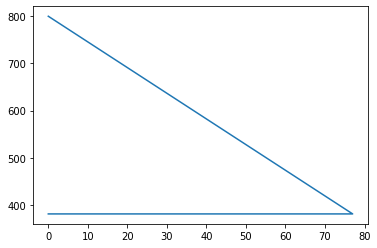

|  78       | -471.0    |  81.48    |  2.702    |  0.2793   |  0.2651   |  1.568e+0 |  1.344    |  0.137    |  19.88    |  0.24     |  0.09208  |  1.322    |  0.8364   |  2.801    |  9.662    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.56898
    rho: 0.9
    weight_decay: 0.5270728478944615
)
Batch Normalization Momentum:  0.59
Nodes:  18
LR:  0.56898
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5270728478944615
BATCH_SIZE:  46
Dropout:  0.18
Final Linear Layers:  3
average loss: 0.693794
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4489)
Class:  0  correct:  224.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3300)
Class:  1  correct:  33.0  of  tensor(100.)
Final percentage:  tensor(0.3894)
Last epoch:  10
Credit Cost:  -610


Best Score So Far:  -381


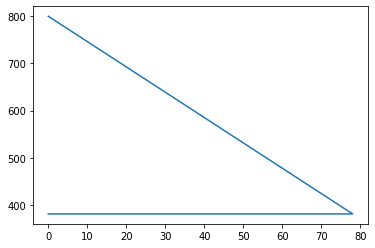

|  79       | -610.0    |  46.86    |  2.185    |  0.593    |  0.1847   |  1.059e+0 |  3.243    |  0.569    |  18.04    |  0.1932   |  0.5271   |  1.015    |  0.325    |  3.744    |  6.289    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.43306
    weight_decay: 0.41291757131211143
)
Batch Normalization Momentum:  0.81
Nodes:  15
LR:  0.43306
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.41291757131211143
BATCH_SIZE:  110
Dropout:  0.26
Final Linear Layers:  1
average loss: 1.046244
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5090)
Class:  0  correct:  254.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5145)
Last epoch:  12
Credit Cost:  -485


Best Score So Far:  -381


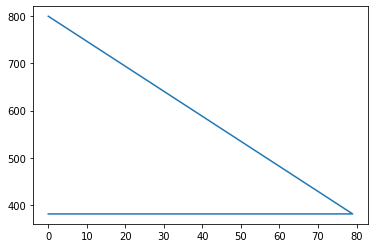

|  80       | -485.0    |  110.0    |  2.203    |  0.8144   |  0.2638   |  1.321e+0 |  1.368    |  0.4331   |  15.21    |  0.1275   |  0.4129   |  1.072    |  0.1982   |  3.357    |  1.109    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.30476
    rho: 0.9
    weight_decay: 0.18496993718297766
)
Batch Normalization Momentum:  0.99
Nodes:  15
LR:  0.30476
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.18496993718297766
BATCH_SIZE:  41
Dropout:  0.17
Final Linear Layers:  3
average loss: 0.693238
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4269)
Class:  0  correct:  213.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.4984)
Last epoch:  9
Credit Cost:  -501


Best Score So Far:  -381


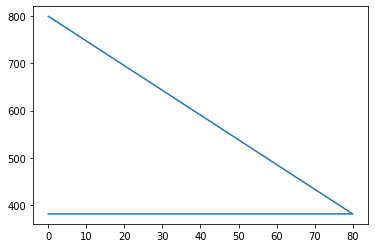

|  81       | -501.0    |  41.61    |  1.043    |  0.9875   |  0.1746   |  1.293e+0 |  3.778    |  0.3048   |  15.64    |  0.5877   |  0.185    |  1.608    |  0.3679   |  1.731    |  6.255    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.04896
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.96
Nodes:  16
LR:  0.04896
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.47076360810239837
BATCH_SIZE:  90
Dropout:  0.23
Final Linear Layers:  3
average loss: 0.694388
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5130)
Class:  0  correct:  256.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3400)
Class:  1  correct:  34.0  of  tensor(100.)
Final percentage:  tensor(0.4265)
Last epoch:  9
Credit Cost:  -573


Best Score So Far:  -381


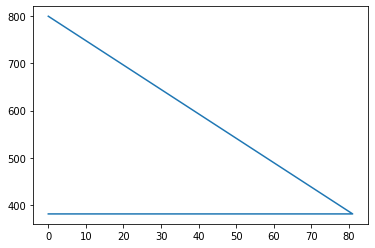

|  82       | -573.0    |  90.28    |  1.143    |  0.9614   |  0.2259   |  1.806e+0 |  3.247    |  0.04896  |  16.45    |  0.4458   |  0.4708   |  1.893    |  0.6973   |  3.038    |  7.267    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.10683
    weight_decay: 0.5708523026110377
)
Batch Normalization Momentum:  0.75
Nodes:  13
LR:  0.10683
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5708523026110377
BATCH_SIZE:  80
Dropout:  0.23
Final Linear Layers:  1
average loss: 0.694762
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5010)
Class:  0  correct:  250.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7300)
Class:  1  correct:  73.0  of  tensor(100.)
Final percentage:  tensor(0.6155)
Last epoch:  9
Credit Cost:  -384


Best Score So Far:  -381


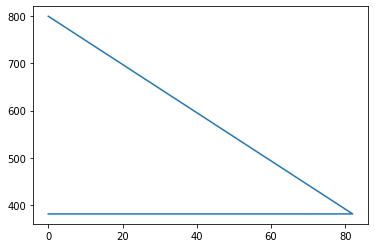

|  83       | -384.0    |  80.71    |  1.3      |  0.7532   |  0.2343   |  1.904e+0 |  1.699    |  0.1068   |  13.73    |  0.3209   |  0.5709   |  2.221    |  0.7524   |  2.279    |  1.894    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.29517
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.19
Nodes:  4
LR:  0.29517
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.32317529641604625
BATCH_SIZE:  18
Dropout:  0.25
Final Linear Layers:  3
average loss: 0.693745
Class:  0  accuracy:  tensor(0.4589)
Class:  0  correct:  229.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5295)
Last epoch:  7
Credit Cost:  -470


Best Score So Far:  -381


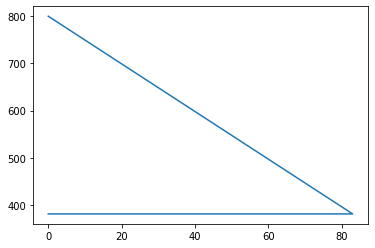

|  84       | -470.0    |  18.26    |  1.743    |  0.1919   |  0.2462   |  1.6e+03  |  3.06     |  0.2952   |  4.645    |  0.2356   |  0.3232   |  1.395    |  0.02522  |  3.181    |  7.517    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.12124
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.42
Nodes:  17
LR:  0.12124
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.21356528368706768
BATCH_SIZE:  44
Dropout:  0.26
Final Linear Layers:  2
average loss: 0.696056
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4709)
Class:  0  correct:  235.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4705)
Last epoch:  14
Credit Cost:  -529


Best Score So Far:  -381


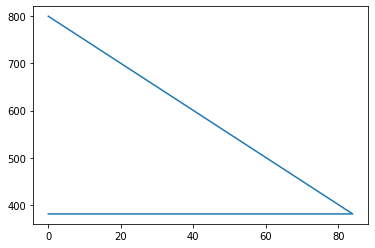

|  85       | -529.0    |  44.97    |  2.679    |  0.4242   |  0.2594   |  1.657e+0 |  2.737    |  0.1212   |  17.89    |  0.8936   |  0.2136   |  2.733    |  0.8997   |  1.986    |  7.141    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.20726
    rho: 0.9
    weight_decay: 0.5934668517959476
)
Batch Normalization Momentum:  0.87
Nodes:  6
LR:  0.20726
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5934668517959476
BATCH_SIZE:  115
Dropout:  0.06
Final Linear Layers:  2
average loss: 0.692590
Class:  0  accuracy:  tensor(0.4950)
Class:  0  correct:  247.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4575)
Last epoch:  7
Credit Cost:  -542


Best Score So Far:  -381


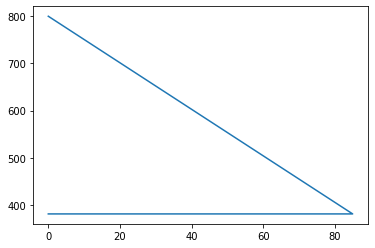

|  86       | -542.0    |  115.5    |  1.151    |  0.8698   |  0.05725  |  1.85e+03 |  2.995    |  0.2073   |  6.541    |  0.6351   |  0.5935   |  2.635    |  0.622    |  3.859    |  6.303    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.31176
    t0: 1000000.0
    weight_decay: 0.25927695507234394
)
Batch Normalization Momentum:  0.33
Nodes:  7
LR:  0.31176
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.25927695507234394
BATCH_SIZE:  28
Dropout:  0.3
Final Linear Layers:  3
average loss: 0.693079
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -381


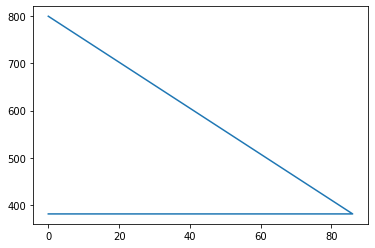

|  87       | -800.0    |  28.53    |  1.854    |  0.3334   |  0.2976   |  1.38e+03 |  3.968    |  0.3118   |  7.168    |  0.07542  |  0.2593   |  1.246    |  0.6282   |  2.238    |  9.908    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.29283
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.39
Nodes:  14
LR:  0.29283
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6375732167468222
BATCH_SIZE:  119
Dropout:  0.14
Final Linear Layers:  3
average loss: 0.693397
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5070)
Class:  0  correct:  253.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4100)
Class:  1  correct:  41.0  of  tensor(100.)
Final percentage:  tensor(0.4585)
Last epoch:  8
Credit Cost:  -541


Best Score So Far:  -381


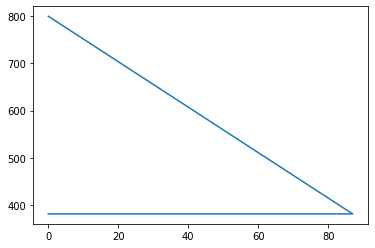

|  88       | -541.0    |  119.3    |  1.297    |  0.3909   |  0.1385   |  1.561e+0 |  3.333    |  0.2928   |  14.6     |  0.2625   |  0.6376   |  1.044    |  0.8129   |  1.564    |  7.165    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.18624
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.12
Nodes:  2
LR:  0.18624
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.10186800355644786
BATCH_SIZE:  48
Dropout:  0.06
Final Linear Layers:  2
average loss: 0.691701
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5150)
Class:  0  correct:  257.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5775)
Last epoch:  15
Credit Cost:  -422


Best Score So Far:  -381


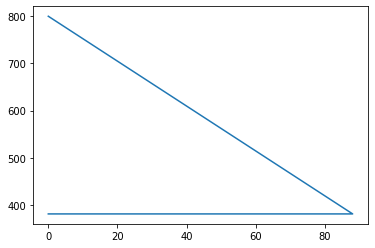

|  89       | -422.0    |  48.05    |  2.939    |  0.1215   |  0.05627  |  1.889e+0 |  2.744    |  0.1862   |  2.023    |  0.2281   |  0.1019   |  1.405    |  0.8874   |  3.611    |  7.296    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.23281
    weight_decay: 0.6194880665347605
)
Batch Normalization Momentum:  0.49
Nodes:  16
LR:  0.23281
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.6194880665347605
BATCH_SIZE:  62
Dropout:  0.11
Final Linear Layers:  3
average loss: 3.660710
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4068)
Class:  0  correct:  203.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6200)
Class:  1  correct:  62.0  of  tensor(100.)
Final percentage:  tensor(0.5134)
Last epoch:  11
Credit Cost:  -486


Best Score So Far:  -381


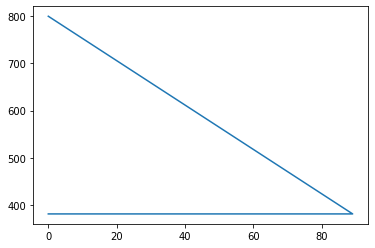

|  90       | -486.0    |  62.34    |  2.646    |  0.4909   |  0.109    |  1.276e+0 |  3.765    |  0.2328   |  16.79    |  0.2549   |  0.6195   |  1.763    |  0.2946   |  3.146    |  2.716    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.38337
    rho: 0.9
    weight_decay: 0.6163889644352722
)
Batch Normalization Momentum:  0.74
Nodes:  11
LR:  0.38337
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.6163889644352722
BATCH_SIZE:  18
Dropout:  0.18
Final Linear Layers:  2
average loss: 0.693222
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4870)
Class:  0  correct:  243.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3400)
Class:  1  correct:  34.0  of  tensor(100.)
Final percentage:  tensor(0.4135)
Last epoch:  8
Credit Cost:  -586


Best Score So Far:  -381


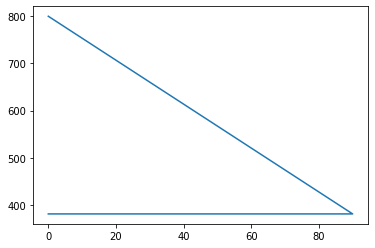

|  91       | -586.0    |  18.66    |  2.666    |  0.7367   |  0.1772   |  1.243e+0 |  2.864    |  0.3834   |  11.83    |  0.06835  |  0.6164   |  1.915    |  0.7562   |  1.759    |  6.317    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.44528
    weight_decay: 0.005967317359569609
)
Batch Normalization Momentum:  0.13
Nodes:  20
LR:  0.44528
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.005967317359569609
BATCH_SIZE:  57
Dropout:  0.07
Final Linear Layers:  1
average loss: 178.552963
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4669)
Class:  0  correct:  233.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6200)
Class:  1  correct:  62.0  of  tensor(100.)
Final percentage:  tensor(0.5435)
Last epoch:  14
Credit Cost:  -456


Best Score So Far:  -381


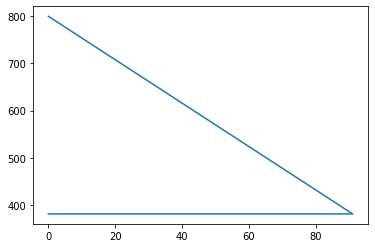

|  92       | -456.0    |  57.17    |  1.76     |  0.1254   |  0.07328  |  1.079e+0 |  1.906    |  0.4453   |  20.45    |  0.6721   |  0.005967 |  2.35     |  0.4981   |  1.69     |  2.572    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.32833
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.97
Nodes:  26
LR:  0.32833
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.4130069136797526
BATCH_SIZE:  26
Dropout:  0.27
Final Linear Layers:  3
average loss: 0.692736
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4529)
Class:  0  correct:  226.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5465)
Last epoch:  10
Credit Cost:  -453


Best Score So Far:  -381


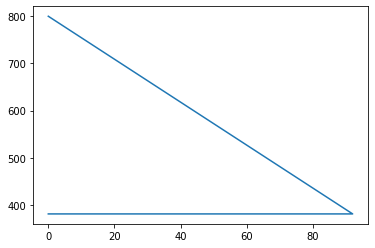

|  93       | -453.0    |  26.94    |  2.68     |  0.9728   |  0.2741   |  1.347e+0 |  3.333    |  0.3283   |  26.49    |  0.4838   |  0.413    |  2.567    |  0.09923  |  2.606    |  4.29     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.23694
    t0: 1000000.0
    weight_decay: 0.09536559665826065
)
Batch Normalization Momentum:  0.39
Nodes:  22
LR:  0.23694
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.09536559665826065
BATCH_SIZE:  78
Dropout:  0.12
Final Linear Layers:  2
average loss: 0.693015
Class:  0  accuracy:  tensor(0.4870)
Class:  0  correct:  243.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.4735)
Last epoch:  7
Credit Cost:  -526


Best Score So Far:  -381


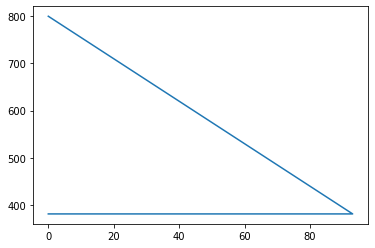

|  94       | -526.0    |  78.93    |  2.908    |  0.3889   |  0.1179   |  1.791e+0 |  2.929    |  0.2369   |  22.67    |  0.4042   |  0.09537  |  1.897    |  0.3311   |  1.652    |  9.323    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.51771
    weight_decay: 0.050220034581319
)
Batch Normalization Momentum:  0.74
Nodes:  7
LR:  0.51771
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.050220034581319
BATCH_SIZE:  89
Dropout:  0.16
Final Linear Layers:  3
average loss: 1.144693
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5331)
Class:  0  correct:  266.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4100)
Class:  1  correct:  41.0  of  tensor(100.)
Final percentage:  tensor(0.4715)
Last epoch:  21
Credit Cost:  -528


Best Score So Far:  -381


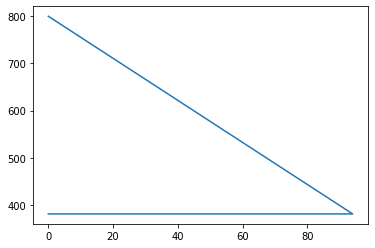

|  95       | -528.0    |  89.52    |  2.192    |  0.7392   |  0.1626   |  1.701e+0 |  3.782    |  0.5177   |  7.023    |  0.2636   |  0.05022  |  2.948    |  0.234    |  2.975    |  1.806    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.33398
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.1
Nodes:  18
LR:  0.33398
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.4874194311624619
BATCH_SIZE:  30
Dropout:  0.12
Final Linear Layers:  2
average loss: 0.695518
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4569)
Class:  0  correct:  228.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3400)
Class:  1  correct:  34.0  of  tensor(100.)
Final percentage:  tensor(0.3985)
Last epoch:  9
Credit Cost:  -601


Best Score So Far:  -381


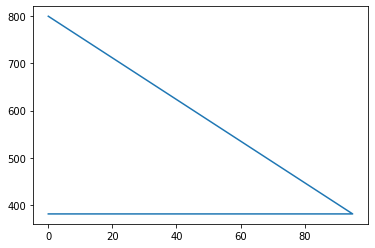

|  96       | -601.0    |  30.14    |  2.001    |  0.1039   |  0.1167   |  1.538e+0 |  2.014    |  0.334    |  18.1     |  0.3908   |  0.4874   |  2.35     |  0.6804   |  2.679    |  4.219    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.02352
    weight_decay: 0.0038210414194761555
)
Batch Normalization Momentum:  0.59
Nodes:  24
LR:  0.02352
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.0038210414194761555
BATCH_SIZE:  80
Dropout:  0.29
Final Linear Layers:  3
average loss: 0.692796
Class:  0  accuracy:  tensor(0.4850)
Class:  0  correct:  242.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6900)
Class:  1  correct:  69.0  of  tensor(100.)
Final percentage:  tensor(0.5875)
Last epoch:  7
Credit Cost:  -411


Best Score So Far:  -381


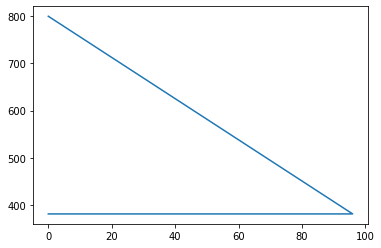

|  97       | -411.0    |  80.03    |  2.862    |  0.5909   |  0.2939   |  1.441e+0 |  3.211    |  0.02352  |  24.94    |  0.5182   |  0.003821 |  1.552    |  0.5295   |  3.296    |  1.477    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.55162
    weight_decay: 0.5830944038715655
)
Batch Normalization Momentum:  0.64
Nodes:  24
LR:  0.55162
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5830944038715655
BATCH_SIZE:  72
Dropout:  0.28
Final Linear Layers:  1
average loss: 167.341919
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4609)
Class:  0  correct:  230.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5355)
Last epoch:  16
Credit Cost:  -463


Best Score So Far:  -381


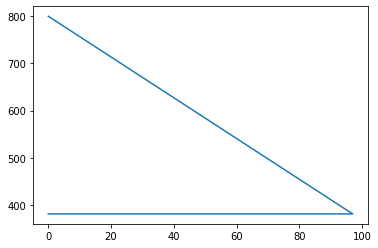

|  98       | -463.0    |  72.08    |  2.594    |  0.6431   |  0.2794   |  1.075e+0 |  1.828    |  0.5516   |  24.95    |  0.5995   |  0.5831   |  2.783    |  0.963    |  3.986    |  2.255    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.41142
    weight_decay: 0.2476180861681968
)
Batch Normalization Momentum:  0.01
Nodes:  16
LR:  0.41142
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.2476180861681968
BATCH_SIZE:  12
Dropout:  0.29
Final Linear Layers:  3
average loss: 1.717080
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4930)
Class:  0  correct:  246.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5315)
Last epoch:  9
Credit Cost:  -468


Best Score So Far:  -381


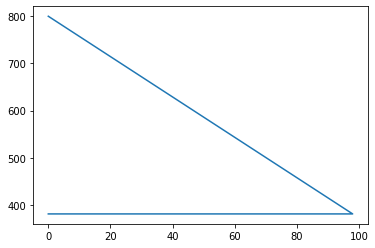

|  99       | -468.0    |  12.75    |  1.146    |  0.0146   |  0.2915   |  1.095e+0 |  3.517    |  0.4114   |  16.63    |  0.347    |  0.2476   |  1.505    |  0.9019   |  3.17     |  1.233    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.47814
    weight_decay: 0.6496835440426583
)
Batch Normalization Momentum:  0.03
Nodes:  11
LR:  0.47814
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.6496835440426583
BATCH_SIZE:  61
Dropout:  0.27
Final Linear Layers:  1
average loss: 5.933017
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4569)
Class:  0  correct:  228.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6500)
Class:  1  correct:  65.0  of  tensor(100.)
Final percentage:  tensor(0.5535)
Last epoch:  17
Credit Cost:  -446


Best Score So Far:  -381


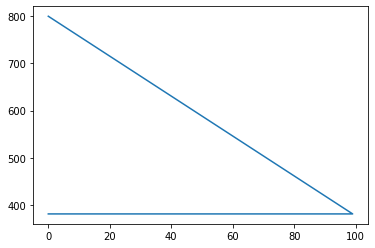

|  100      | -446.0    |  61.23    |  1.56     |  0.02868  |  0.2654   |  1.771e+0 |  1.986    |  0.4781   |  11.74    |  0.3083   |  0.6497   |  2.944    |  0.5183   |  3.846    |  8.983    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.46458
    t0: 1000000.0
    weight_decay: 0.129515422635858
)
Batch Normalization Momentum:  0.7
Nodes:  12
LR:  0.46458
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.129515422635858
BATCH_SIZE:  68
Dropout:  0.14
Final Linear Layers:  3
average loss: 0.692858
Class:  0  accuracy:  tensor(0.4429)
Class:  0  correct:  221.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5900)
Class:  1  correct:  59.0  of  tensor(100.)
Final percentage:  tensor(0.5164)
Last epoch:  7
Credit Cost:  -483


Best Score So Far:  -381


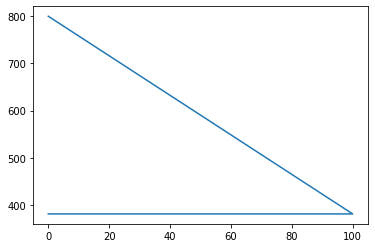

|  101      | -483.0    |  68.24    |  1.742    |  0.7033   |  0.1367   |  1.605e+0 |  3.961    |  0.4646   |  12.03    |  0.08982  |  0.1295   |  2.048    |  0.4129   |  3.394    |  9.389    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.00447
    weight_decay: 0.20577435358083385
)
Batch Normalization Momentum:  0.95
Nodes:  11
LR:  0.00447
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.20577435358083385
BATCH_SIZE:  26
Dropout:  0.29
Final Linear Layers:  1
average loss: 0.693589
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5050)
Class:  0  correct:  252.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4725)
Last epoch:  35
Credit Cost:  -527


Best Score So Far:  -381


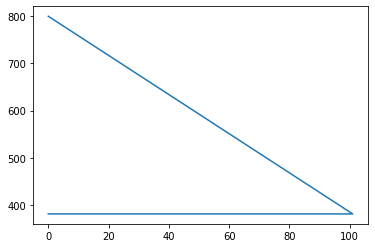

|  102      | -527.0    |  26.06    |  2.712    |  0.9478   |  0.2878   |  1.038e+0 |  1.172    |  0.004473 |  11.38    |  0.05659  |  0.2058   |  1.708    |  0.9441   |  2.426    |  3.501    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.53441
    t0: 1000000.0
    weight_decay: 0.0711968750147217
)
Batch Normalization Momentum:  0.11
Nodes:  13
LR:  0.53441
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.0711968750147217
BATCH_SIZE:  66
Dropout:  0.23
Final Linear Layers:  3
average loss: 0.694121
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4409)
Class:  0  correct:  220.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4100)
Class:  1  correct:  41.0  of  tensor(100.)
Final percentage:  tensor(0.4254)
Last epoch:  22
Credit Cost:  -574


Best Score So Far:  -381


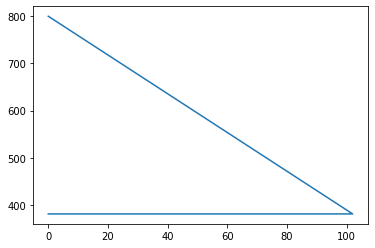

|  103      | -574.0    |  66.37    |  2.28     |  0.1101   |  0.2274   |  1.852e+0 |  3.524    |  0.5344   |  13.46    |  0.4439   |  0.0712   |  1.449    |  0.9616   |  1.851    |  9.157    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.20772
    rho: 0.9
    weight_decay: 0.05873409019643782
)
Batch Normalization Momentum:  0.15
Nodes:  6
LR:  0.20772
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.05873409019643782
BATCH_SIZE:  114
Dropout:  0.26
Final Linear Layers:  1
average loss: 0.694458
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4990)
Class:  0  correct:  249.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5345)
Last epoch:  64
Credit Cost:  -464


Best Score So Far:  -381


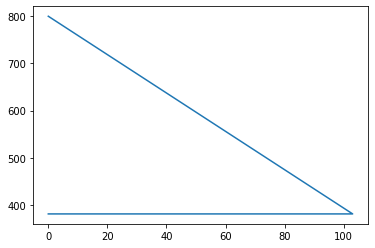

|  104      | -464.0    |  114.4    |  2.836    |  0.1546   |  0.2639   |  1.632e+0 |  1.63     |  0.2077   |  6.798    |  0.4445   |  0.05873  |  1.329    |  0.1952   |  3.066    |  6.158    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.59049
    weight_decay: 0.15677238426223497
)
Batch Normalization Momentum:  0.62
Nodes:  2
LR:  0.59049
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.15677238426223497
BATCH_SIZE:  112
Dropout:  0.01
Final Linear Layers:  3
average loss: 0.724987
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5130)
Class:  0  correct:  256.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5715)
Last epoch:  17
Credit Cost:  -428


Best Score So Far:  -381


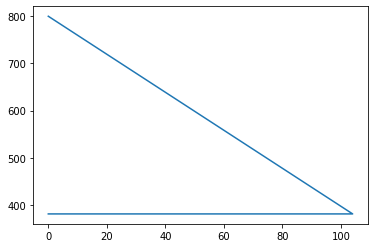

|  105      | -428.0    |  112.3    |  1.487    |  0.6233   |  0.01033  |  1.516e+0 |  3.581    |  0.5905   |  2.296    |  0.2533   |  0.1568   |  1.095    |  0.01007  |  2.466    |  1.409    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.42181
    weight_decay: 0.2474407034664404
)
Batch Normalization Momentum:  0.29
Nodes:  16
LR:  0.42181
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.2474407034664404
BATCH_SIZE:  38
Dropout:  0.08
Final Linear Layers:  2
average loss: 16.840082
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5331)
Class:  0  correct:  266.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4865)
Last epoch:  9
Credit Cost:  -513


Best Score So Far:  -381


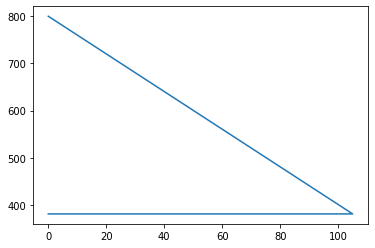

|  106      | -513.0    |  38.51    |  2.274    |  0.2917   |  0.0809   |  1.591e+0 |  2.138    |  0.4218   |  16.88    |  0.6329   |  0.2474   |  1.571    |  0.1319   |  3.802    |  8.235    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.33131
    rho: 0.9
    weight_decay: 0.12980382039178529
)
Batch Normalization Momentum:  0.92
Nodes:  7
LR:  0.33131
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.12980382039178529
BATCH_SIZE:  120
Dropout:  0.28
Final Linear Layers:  1
average loss: 0.692029
Class:  0  accuracy:  tensor(0.4870)
Class:  0  correct:  243.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4785)
Last epoch:  7
Credit Cost:  -521


Best Score So Far:  -381


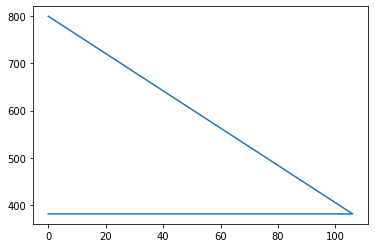

|  107      | -521.0    |  120.3    |  1.369    |  0.9238   |  0.2807   |  1.284e+0 |  1.821    |  0.3313   |  7.559    |  0.4422   |  0.1298   |  2.885    |  0.4889   |  3.882    |  6.798    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.03655
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.14
Nodes:  16
LR:  0.03655
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.5647420928613269
BATCH_SIZE:  64
Dropout:  0.19
Final Linear Layers:  2
average loss: 0.693854
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5070)
Class:  0  correct:  253.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4885)
Last epoch:  9
Credit Cost:  -510


Best Score So Far:  -381


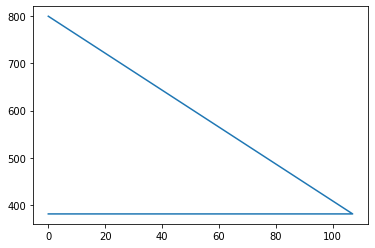

|  108      | -510.0    |  64.06    |  2.926    |  0.1418   |  0.1897   |  1.662e+0 |  2.297    |  0.03655  |  16.78    |  0.4652   |  0.5647   |  1.511    |  0.3875   |  1.718    |  7.171    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.56116
    rho: 0.9
    weight_decay: 0.6634400698645146
)
Batch Normalization Momentum:  0.81
Nodes:  28
LR:  0.56116
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.6634400698645146
BATCH_SIZE:  126
Dropout:  0.07
Final Linear Layers:  1
average loss: 0.693536
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.5085)
Last epoch:  15
Credit Cost:  -491


Best Score So Far:  -381


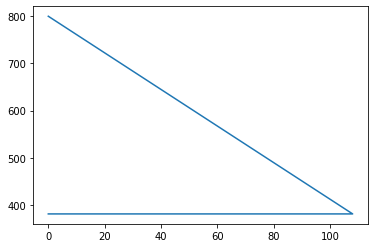

|  109      | -491.0    |  126.7    |  1.353    |  0.8132   |  0.0693   |  1.058e+0 |  1.415    |  0.5612   |  28.66    |  0.2897   |  0.6634   |  2.691    |  0.4303   |  2.399    |  6.662    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.19367
    weight_decay: 0.1714919590694423
)
Batch Normalization Momentum:  0.26
Nodes:  25
LR:  0.19367
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.1714919590694423
BATCH_SIZE:  23
Dropout:  0.0
Final Linear Layers:  2
average loss: 0.688785
Class:  0  accuracy:  tensor(0.5832)
Class:  0  correct:  291.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.5366)
Last epoch:  7
Credit Cost:  -463


Best Score So Far:  -381


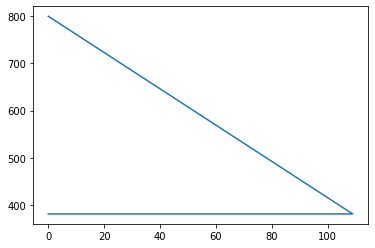

|  110      | -463.0    |  23.6     |  1.029    |  0.2629   |  0.004633 |  1.674e+0 |  2.649    |  0.1937   |  25.41    |  0.1465   |  0.1715   |  1.582    |  0.194    |  1.263    |  8.821    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.51641
    weight_decay: 0.5606214626555102
)
Batch Normalization Momentum:  0.12
Nodes:  12
LR:  0.51641
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5606214626555102
BATCH_SIZE:  14
Dropout:  0.0
Final Linear Layers:  3
average loss: 0.693168
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5331)
Class:  0  correct:  266.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4865)
Last epoch:  10
Credit Cost:  -513


Best Score So Far:  -381


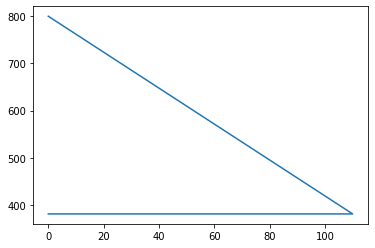

|  111      | -513.0    |  14.94    |  2.361    |  0.1192   |  0.00321  |  1.557e+0 |  3.712    |  0.5164   |  12.15    |  0.0281   |  0.5606   |  2.604    |  0.8598   |  3.002    |  8.262    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.31267
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.55
Nodes:  26
LR:  0.31267
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5774185078134237
BATCH_SIZE:  115
Dropout:  0.15
Final Linear Layers:  3
average loss: 0.694971
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5010)
Class:  0  correct:  250.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3900)
Class:  1  correct:  39.0  of  tensor(100.)
Final percentage:  tensor(0.4455)
Last epoch:  12
Credit Cost:  -554


Best Score So Far:  -381


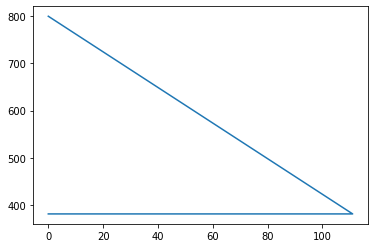

|  112      | -554.0    |  115.3    |  1.903    |  0.5522   |  0.1518   |  1.692e+0 |  3.042    |  0.3127   |  26.85    |  0.5058   |  0.5774   |  1.561    |  0.1767   |  3.9      |  7.67     |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.13547
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.95
Nodes:  24
LR:  0.13547
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.46636504434742426
BATCH_SIZE:  36
Dropout:  0.02
Final Linear Layers:  2
average loss: 0.693727
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3200)
Class:  1  correct:  32.0  of  tensor(100.)
Final percentage:  tensor(0.4115)
Last epoch:  9
Credit Cost:  -588


Best Score So Far:  -381


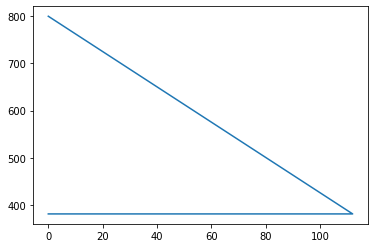

|  113      | -588.0    |  36.21    |  2.157    |  0.9457   |  0.02423  |  1.084e+0 |  2.851    |  0.1355   |  24.96    |  0.568    |  0.4664   |  1.215    |  0.08344  |  2.869    |  4.683    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.57698
    rho: 0.9
    weight_decay: 0.5206500625262186
)
Batch Normalization Momentum:  0.67
Nodes:  23
LR:  0.57698
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5206500625262186
BATCH_SIZE:  14
Dropout:  0.06
Final Linear Layers:  3
average loss: 0.693145
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -381


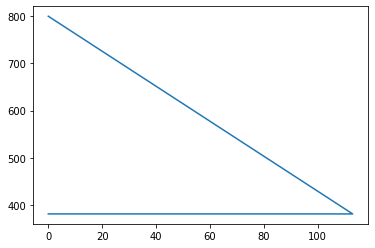

|  114      | -800.0    |  14.82    |  1.738    |  0.6654   |  0.05688  |  1.896e+0 |  3.84     |  0.577    |  23.9     |  0.4065   |  0.5207   |  1.573    |  0.3113   |  2.812    |  6.348    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.39457
    weight_decay: 0.5993258506673614
)
Batch Normalization Momentum:  0.76
Nodes:  27
LR:  0.39457
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.5993258506673614
BATCH_SIZE:  112
Dropout:  0.28
Final Linear Layers:  2
average loss: 2.275324
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5900)
Class:  1  correct:  59.0  of  tensor(100.)
Final percentage:  tensor(0.5465)
Last epoch:  25
Credit Cost:  -453


Best Score So Far:  -381


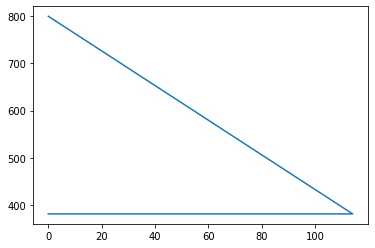

|  115      | -453.0    |  113.0    |  1.507    |  0.7585   |  0.2823   |  1.001e+0 |  2.424    |  0.3946   |  27.3     |  0.1844   |  0.5993   |  1.725    |  0.8834   |  1.083    |  1.768    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.18766
    rho: 0.9
    weight_decay: 0.45561679654732035
)
Batch Normalization Momentum:  0.41
Nodes:  11
LR:  0.18766
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.45561679654732035
BATCH_SIZE:  125
Dropout:  0.05
Final Linear Layers:  1
average loss: 0.693700
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5691)
Class:  0  correct:  284.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4800)
Class:  1  correct:  48.0  of  tensor(100.)
Final percentage:  tensor(0.5246)
Last epoch:  15
Credit Cost:  -475


Best Score So Far:  -381


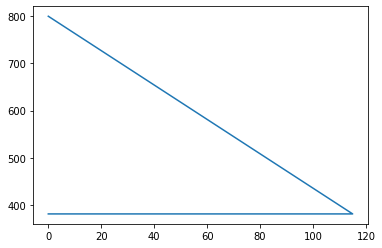

|  116      | -475.0    |  125.7    |  2.213    |  0.4135   |  0.05076  |  1.65e+03 |  1.111    |  0.1877   |  11.7     |  0.6072   |  0.4556   |  2.684    |  0.9183   |  2.975    |  6.198    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.40956
    t0: 1000000.0
    weight_decay: 0.3559865611993882
)
Batch Normalization Momentum:  0.15
Nodes:  9
LR:  0.40956
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.3559865611993882
BATCH_SIZE:  53
Dropout:  0.27
Final Linear Layers:  2
average loss: 0.692844
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -381


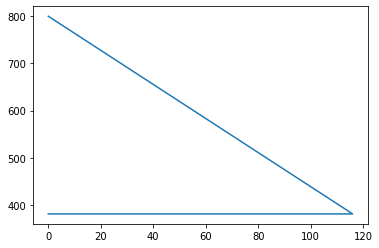

|  117      | -800.0    |  53.44    |  2.924    |  0.1525   |  0.2685   |  1.311e+0 |  2.64     |  0.4096   |  9.094    |  0.1684   |  0.356    |  2.576    |  0.6855   |  1.356    |  9.098    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.42385
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.55
Nodes:  28
LR:  0.42385
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.3696481775066745
BATCH_SIZE:  63
Dropout:  0.03
Final Linear Layers:  3
average loss: 0.693994
Class:  0  accuracy:  tensor(0.5110)
Class:  0  correct:  255.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3100)
Class:  1  correct:  31.0  of  tensor(100.)
Final percentage:  tensor(0.4105)
Last epoch:  7
Credit Cost:  -589


Best Score So Far:  -381


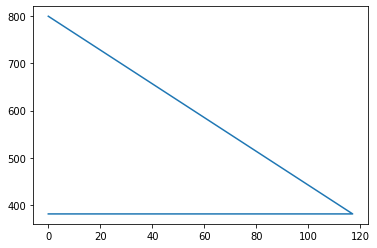

|  118      | -589.0    |  63.49    |  2.884    |  0.5479   |  0.02544  |  1.202e+0 |  3.554    |  0.4239   |  28.85    |  0.3295   |  0.3696   |  2.294    |  0.5883   |  1.692    |  4.837    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.37564
    rho: 0.9
    weight_decay: 0.25986591440546436
)
Batch Normalization Momentum:  0.98
Nodes:  9
LR:  0.37564
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.25986591440546436
BATCH_SIZE:  34
Dropout:  0.02
Final Linear Layers:  1
average loss: 0.692591
Class:  0  accuracy:  tensor(0.5511)
Class:  0  correct:  275.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6500)
Class:  1  correct:  65.0  of  tensor(100.)
Final percentage:  tensor(0.6006)
Last epoch:  7
Credit Cost:  -399


Best Score So Far:  -381


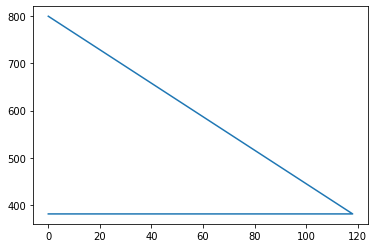

|  119      | -399.0    |  34.77    |  2.683    |  0.9768   |  0.01997  |  1.714e+0 |  1.987    |  0.3756   |  9.744    |  0.6507   |  0.2599   |  1.587    |  0.9026   |  3.818    |  6.516    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.14482
    rho: 0.9
    weight_decay: 0.5196941624520004
)
Batch Normalization Momentum:  0.74
Nodes:  20
LR:  0.14482
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5196941624520004
BATCH_SIZE:  30
Dropout:  0.23
Final Linear Layers:  3
average loss: 0.695046
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4609)
Class:  0  correct:  230.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3900)
Class:  1  correct:  39.0  of  tensor(100.)
Final percentage:  tensor(0.4255)
Last epoch:  14
Credit Cost:  -574


Best Score So Far:  -381


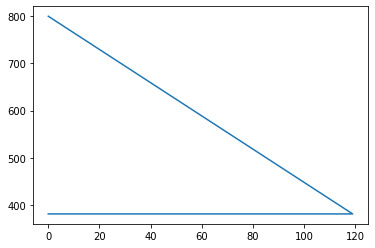

|  120      | -574.0    |  30.59    |  2.869    |  0.7429   |  0.2253   |  1.212e+0 |  3.482    |  0.1448   |  20.95    |  0.7103   |  0.5197   |  1.777    |  0.7522   |  3.7      |  6.281    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.02461
    t0: 1000000.0
    weight_decay: 0.6814658506993219
)
Batch Normalization Momentum:  0.1
Nodes:  9
LR:  0.02461
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6814658506993219
BATCH_SIZE:  15
Dropout:  0.05
Final Linear Layers:  3
average loss: 0.693395
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4529)
Class:  0  correct:  226.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5300)
Class:  1  correct:  53.0  of  tensor(100.)
Final percentage:  tensor(0.4915)
Last epoch:  13
Credit Cost:  -508


Best Score So Far:  -381


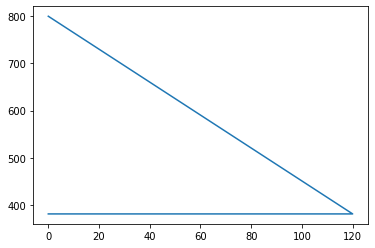

|  121      | -508.0    |  15.21    |  1.257    |  0.1042   |  0.05182  |  1.126e+0 |  3.327    |  0.02461  |  9.247    |  0.8783   |  0.6815   |  2.205    |  0.9665   |  1.13     |  9.528    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.15548
    momentum: 0.72
    nesterov: False
    weight_decay: 0.6898128959698868
)
Batch Normalization Momentum:  0.8
Nodes:  30
LR:  0.15548
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6898128959698868
BATCH_SIZE:  42
Dropout:  0.26
Final Linear Layers:  3
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -381


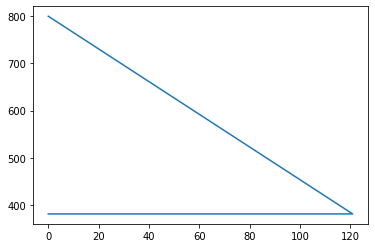

|  122      | -800.0    |  42.6     |  2.59     |  0.8025   |  0.258    |  1.459e+0 |  3.783    |  0.1555   |  30.03    |  0.6189   |  0.6898   |  1.065    |  0.7179   |  2.691    |  5.427    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.05083
    weight_decay: 0.5175975123637327
)
Batch Normalization Momentum:  0.25
Nodes:  25
LR:  0.05083
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5175975123637327
BATCH_SIZE:  36
Dropout:  0.07
Final Linear Layers:  2
average loss: 0.693238
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4950)
Class:  0  correct:  247.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5400)
Class:  1  correct:  54.0  of  tensor(100.)
Final percentage:  tensor(0.5175)
Last epoch:  8
Credit Cost:  -482


Best Score So Far:  -381


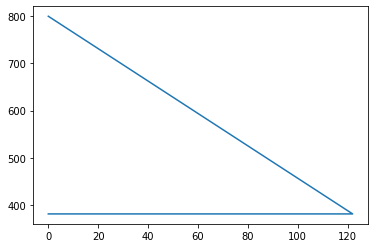

|  123      | -482.0    |  36.14    |  1.65     |  0.247    |  0.06578  |  1.8e+03  |  2.502    |  0.05083  |  25.31    |  0.5336   |  0.5176   |  2.026    |  0.3959   |  3.949    |  1.254    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.48212
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.39
Nodes:  9
LR:  0.48212
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.6411494614279689
BATCH_SIZE:  119
Dropout:  0.06
Final Linear Layers:  1
average loss: 0.691818
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4770)
Class:  0  correct:  238.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5385)
Last epoch:  12
Credit Cost:  -461


Best Score So Far:  -381


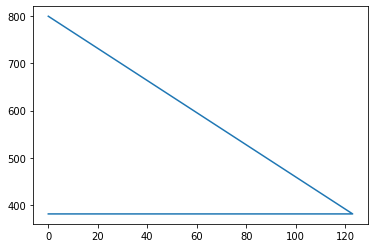

|  124      | -461.0    |  119.7    |  2.852    |  0.387    |  0.06434  |  1.619e+0 |  1.532    |  0.4821   |  9.618    |  0.2912   |  0.6411   |  2.797    |  0.53     |  3.58     |  4.169    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.44102
    t0: 1000000.0
    weight_decay: 0.03587252158789878
)
Batch Normalization Momentum:  0.29
Nodes:  21
LR:  0.44102
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.03587252158789878
BATCH_SIZE:  127
Dropout:  0.01
Final Linear Layers:  2
average loss: 0.690843
Class:  0  accuracy:  tensor(0.4709)
Class:  0  correct:  235.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5555)
Last epoch:  7
Credit Cost:  -444


Best Score So Far:  -381


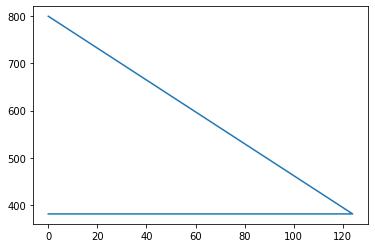

|  125      | -444.0    |  127.7    |  1.863    |  0.2919   |  0.01247  |  1.99e+03 |  2.39     |  0.441    |  21.22    |  0.7226   |  0.03587  |  2.831    |  0.9176   |  2.65     |  9.666    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.0428
    rho: 0.9
    weight_decay: 0.10540347435452764
)
Batch Normalization Momentum:  0.39
Nodes:  3
LR:  0.0428
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.10540347435452764
BATCH_SIZE:  38
Dropout:  0.19
Final Linear Layers:  3
average loss: 0.693866
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4770)
Class:  0  correct:  238.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4535)
Last epoch:  70
Credit Cost:  -546


Best Score So Far:  -381


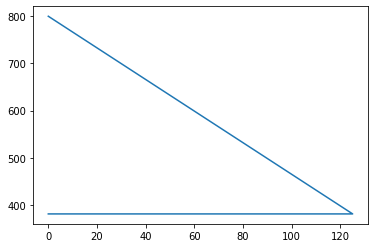

|  126      | -546.0    |  38.84    |  2.198    |  0.3925   |  0.1884   |  1.301e+0 |  3.45     |  0.0428   |  3.256    |  0.0503   |  0.1054   |  1.787    |  0.9458   |  1.331    |  6.822    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.39265
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.2
Nodes:  15
LR:  0.39265
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.07707218311447976
BATCH_SIZE:  69
Dropout:  0.07
Final Linear Layers:  3
average loss: 0.692580
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4830)
Class:  0  correct:  241.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5415)
Last epoch:  10
Credit Cost:  -458


Best Score So Far:  -381


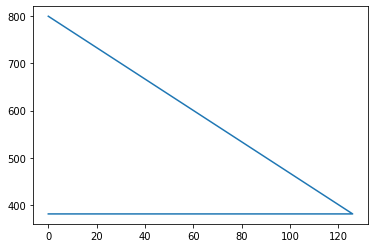

|  127      | -458.0    |  69.43    |  1.703    |  0.1962   |  0.06618  |  1.044e+0 |  3.132    |  0.3927   |  15.31    |  0.7185   |  0.07707  |  2.868    |  0.8392   |  2.971    |  4.406    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.52537
    momentum: 0.91
    nesterov: False
    weight_decay: 0.5239893720308185
)
Batch Normalization Momentum:  0.93
Nodes:  30
LR:  0.52537
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5239893720308185
BATCH_SIZE:  55
Dropout:  0.26
Final Linear Layers:  2
average loss: 0.693206
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.4965)
Last epoch:  8
Credit Cost:  -503


Best Score So Far:  -381


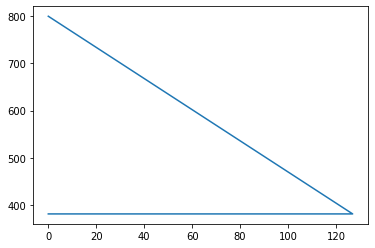

|  128      | -503.0    |  55.65    |  1.959    |  0.9259   |  0.2591   |  1.478e+0 |  2.658    |  0.5254   |  30.48    |  0.6389   |  0.524    |  1.7      |  0.9088   |  3.502    |  5.963    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.46273
    t0: 1000000.0
    weight_decay: 0.17561613235543427
)
Batch Normalization Momentum:  0.8
Nodes:  14
LR:  0.46273
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.17561613235543427
BATCH_SIZE:  111
Dropout:  0.04
Final Linear Layers:  3
average loss: 0.692907
Class:  0  accuracy:  tensor(0.4810)
Class:  0  correct:  240.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4555)
Last epoch:  7
Credit Cost:  -544


Best Score So Far:  -381


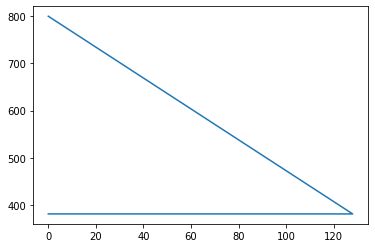

|  129      | -544.0    |  111.6    |  2.691    |  0.8003   |  0.03921  |  1.536e+0 |  3.693    |  0.4627   |  14.62    |  0.9769   |  0.1756   |  1.664    |  0.9447   |  3.418    |  9.094    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.27762
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.23
Nodes:  12
LR:  0.27762
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.37364205746852996
BATCH_SIZE:  5
Dropout:  0.09
Final Linear Layers:  3
average loss: 0.694279
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4729)
Class:  0  correct:  236.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.4815)
Last epoch:  11
Credit Cost:  -518


Best Score So Far:  -381


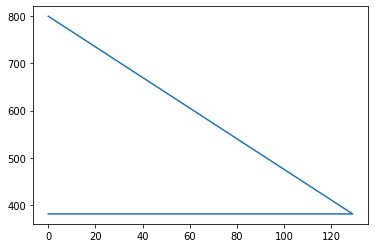

|  130      | -518.0    |  5.437    |  1.756    |  0.2332   |  0.08878  |  1.738e+0 |  3.165    |  0.2776   |  12.96    |  0.5845   |  0.3736   |  2.096    |  0.6093   |  2.183    |  7.938    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.32673
    weight_decay: 0.639699328285101
)
Batch Normalization Momentum:  0.95
Nodes:  20
LR:  0.32673
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.639699328285101
BATCH_SIZE:  35
Dropout:  0.0
Final Linear Layers:  1
average loss: 0.694198
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5631)
Class:  0  correct:  281.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6800)
Class:  1  correct:  68.0  of  tensor(100.)
Final percentage:  tensor(0.6216)
Last epoch:  10
Credit Cost:  -378


Best Score So Far:  -378


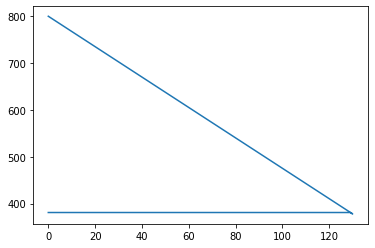

|  131      | -378.0    |  35.15    |  2.305    |  0.9508   |  0.001066 |  1.723e+0 |  1.326    |  0.3267   |  20.81    |  0.2435   |  0.6397   |  2.238    |  0.2294   |  3.303    |  1.949    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.31499
    weight_decay: 0.5652778389229581
)
Batch Normalization Momentum:  0.58
Nodes:  21
LR:  0.31499
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5652778389229581
BATCH_SIZE:  72
Dropout:  0.08
Final Linear Layers:  3
average loss: 0.693103
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5230)
Class:  0  correct:  261.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4765)
Last epoch:  14
Credit Cost:  -523


Best Score So Far:  -378


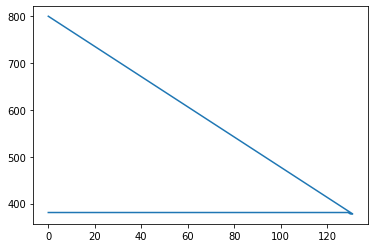

|  132      | -523.0    |  72.85    |  1.189    |  0.5752   |  0.07589  |  1.649e+0 |  3.14     |  0.315    |  21.73    |  0.8127   |  0.5653   |  2.233    |  0.4466   |  2.22     |  8.864    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.4923
    rho: 0.9
    weight_decay: 0.1033370035273151
)
Batch Normalization Momentum:  0.56
Nodes:  16
LR:  0.4923
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.1033370035273151
BATCH_SIZE:  91
Dropout:  0.27
Final Linear Layers:  3
average loss: 0.694296
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4609)
Class:  0  correct:  230.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.4555)
Last epoch:  29
Credit Cost:  -544


Best Score So Far:  -378


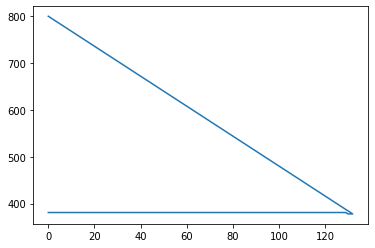

|  133      | -544.0    |  91.16    |  1.368    |  0.5601   |  0.2726   |  1.151e+0 |  3.528    |  0.4923   |  16.98    |  0.03851  |  0.1033   |  2.836    |  0.04371  |  2.114    |  6.565    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.28032
    momentum: 0.66
    nesterov: False
    weight_decay: 0.444033098866434
)
Batch Normalization Momentum:  0.15
Nodes:  16
LR:  0.28032
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.444033098866434
BATCH_SIZE:  28
Dropout:  0.16
Final Linear Layers:  1
average loss: 0.693143
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


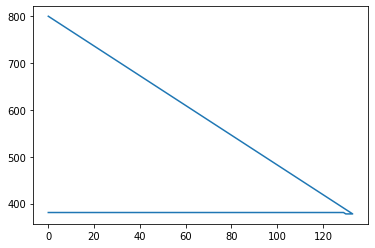

|  134      | -800.0    |  28.42    |  2.952    |  0.1544   |  0.1619   |  1.618e+0 |  1.691    |  0.2803   |  16.73    |  0.7663   |  0.444    |  1.93     |  0.6603   |  2.356    |  5.726    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.28029
    weight_decay: 0.5081985962095855
)
Batch Normalization Momentum:  0.78
Nodes:  28
LR:  0.28029
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5081985962095855
BATCH_SIZE:  85
Dropout:  0.18
Final Linear Layers:  1
average loss: 5.776090
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5531)
Class:  0  correct:  276.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5816)
Last epoch:  12
Credit Cost:  -418


Best Score So Far:  -378


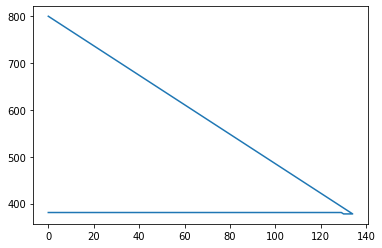

|  135      | -418.0    |  85.66    |  1.361    |  0.7802   |  0.1809   |  1.98e+03 |  1.665    |  0.2803   |  28.87    |  0.6012   |  0.5082   |  1.823    |  0.6775   |  3.829    |  2.8      |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.04965
    rho: 0.9
    weight_decay: 0.633651415876535
)
Batch Normalization Momentum:  0.01
Nodes:  31
LR:  0.04965
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.633651415876535
BATCH_SIZE:  104
Dropout:  0.06
Final Linear Layers:  3
average loss: 0.694399
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4529)
Class:  0  correct:  226.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5015)
Last epoch:  60
Credit Cost:  -498


Best Score So Far:  -378


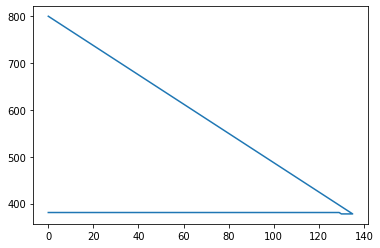

|  136      | -498.0    |  104.1    |  2.929    |  0.01442  |  0.06456  |  1.117e+0 |  3.295    |  0.04965  |  31.95    |  0.3898   |  0.6337   |  1.375    |  0.4365   |  3.526    |  6.351    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.09159
    rho: 0.9
    weight_decay: 0.5934199377238039
)
Batch Normalization Momentum:  0.57
Nodes:  3
LR:  0.09159
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.5934199377238039
BATCH_SIZE:  61
Dropout:  0.13
Final Linear Layers:  1
average loss: 0.693594
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5311)
Class:  0  correct:  265.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.5005)
Last epoch:  24
Credit Cost:  -498


Best Score So Far:  -378


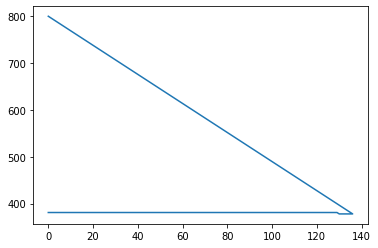

|  137      | -498.0    |  61.31    |  2.02     |  0.5681   |  0.1321   |  1.194e+0 |  1.341    |  0.09159  |  3.575    |  0.5586   |  0.5934   |  1.715    |  0.07456  |  2.273    |  6.412    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.40994
    weight_decay: 0.12053692454704427
)
Batch Normalization Momentum:  0.93
Nodes:  2
LR:  0.40994
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.12053692454704427
BATCH_SIZE:  56
Dropout:  0.26
Final Linear Layers:  2
average loss: 0.692542
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5065)
Last epoch:  7
Credit Cost:  -493


Best Score So Far:  -378


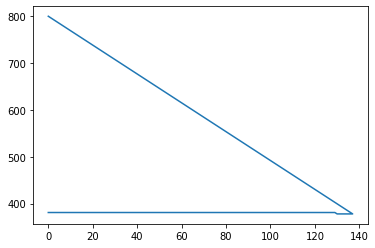

|  138      | -493.0    |  56.75    |  2.613    |  0.9325   |  0.261    |  1.704e+0 |  2.406    |  0.4099   |  2.403    |  0.9815   |  0.1205   |  2.803    |  0.799    |  3.392    |  3.418    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.37202
    weight_decay: 0.031944201406818584
)
Batch Normalization Momentum:  0.84
Nodes:  31
LR:  0.37202
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.031944201406818584
BATCH_SIZE:  31
Dropout:  0.14
Final Linear Layers:  2
average loss: 0.694195
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4970)
Class:  0  correct:  248.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3600)
Class:  1  correct:  36.0  of  tensor(100.)
Final percentage:  tensor(0.4285)
Last epoch:  30
Credit Cost:  -571


Best Score So Far:  -378


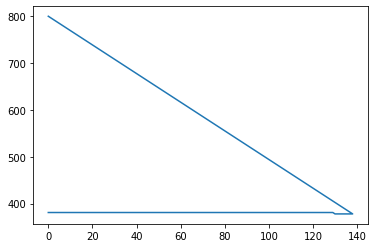

|  139      | -571.0    |  31.18    |  1.853    |  0.8409   |  0.1351   |  1.935e+0 |  2.055    |  0.372    |  31.42    |  0.6432   |  0.03194  |  1.922    |  0.3314   |  2.591    |  3.56     |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.49623
    momentum: 0.54
    nesterov: False
    weight_decay: 0.18306835801264593
)
Batch Normalization Momentum:  0.67
Nodes:  21
LR:  0.49623
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.18306835801264593
BATCH_SIZE:  19
Dropout:  0.26
Final Linear Layers:  3
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


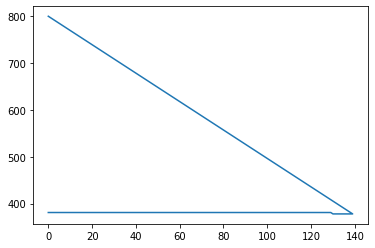

|  140      | -800.0    |  19.16    |  2.33     |  0.6745   |  0.2601   |  1.132e+0 |  3.388    |  0.4962   |  21.4     |  0.2055   |  0.1831   |  1.833    |  0.5364   |  2.428    |  5.202    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.36432
    rho: 0.9
    weight_decay: 0.47687480846350155
)
Batch Normalization Momentum:  0.81
Nodes:  20
LR:  0.36432
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.47687480846350155
BATCH_SIZE:  108
Dropout:  0.26
Final Linear Layers:  3
average loss: 0.693642
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4689)
Class:  0  correct:  234.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5195)
Last epoch:  10
Credit Cost:  -480


Best Score So Far:  -378


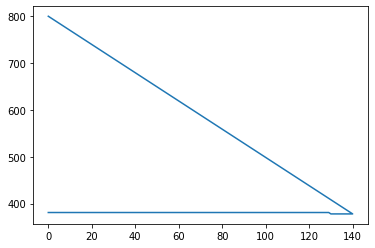

|  141      | -480.0    |  108.1    |  2.732    |  0.8086   |  0.2633   |  1.571e+0 |  3.882    |  0.3643   |  20.12    |  0.3197   |  0.4769   |  1.103    |  0.1332   |  1.389    |  6.89     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.09149
    weight_decay: 0.6059936412030331
)
Batch Normalization Momentum:  0.04
Nodes:  17
LR:  0.09149
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.6059936412030331
BATCH_SIZE:  25
Dropout:  0.07
Final Linear Layers:  2
average loss: 0.693225
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5130)
Class:  0  correct:  256.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5415)
Last epoch:  8
Credit Cost:  -458


Best Score So Far:  -378


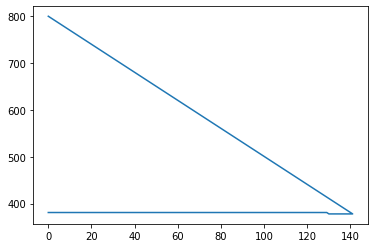

|  142      | -458.0    |  25.74    |  1.679    |  0.04387  |  0.07012  |  1.964e+0 |  2.522    |  0.09149  |  17.69    |  0.9426   |  0.606    |  1.78     |  0.281    |  3.278    |  3.162    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.4781
    weight_decay: 0.5801301227846584
)
Batch Normalization Momentum:  0.86
Nodes:  15
LR:  0.4781
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5801301227846584
BATCH_SIZE:  35
Dropout:  0.13
Final Linear Layers:  3
average loss: 31.933968
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6200)
Class:  1  correct:  62.0  of  tensor(100.)
Final percentage:  tensor(0.5685)
Last epoch:  12
Credit Cost:  -431


Best Score So Far:  -378


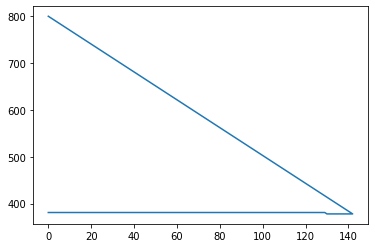

|  143      | -431.0    |  35.52    |  1.167    |  0.8555   |  0.1344   |  1.562e+0 |  3.203    |  0.4781   |  15.43    |  0.1848   |  0.5801   |  1.062    |  0.9373   |  2.725    |  8.87     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.30643
    weight_decay: 0.5620262538540535
)
Batch Normalization Momentum:  0.29
Nodes:  12
LR:  0.30643
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.5620262538540535
BATCH_SIZE:  79
Dropout:  0.16
Final Linear Layers:  1
average loss: 2.264638
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5531)
Class:  0  correct:  276.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6500)
Class:  1  correct:  65.0  of  tensor(100.)
Final percentage:  tensor(0.6016)
Last epoch:  13
Credit Cost:  -398


Best Score So Far:  -378


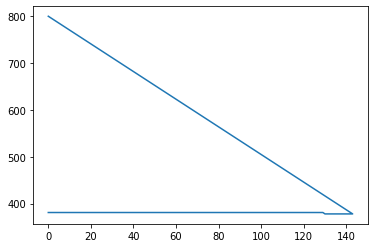

|  144      | -398.0    |  79.46    |  1.501    |  0.2932   |  0.1599   |  1.962e+0 |  1.552    |  0.3064   |  12.31    |  0.7692   |  0.562    |  1.845    |  0.2021   |  1.201    |  2.786    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.44544
    weight_decay: 0.37215526778054164
)
Batch Normalization Momentum:  0.86
Nodes:  31
LR:  0.44544
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.37215526778054164
BATCH_SIZE:  37
Dropout:  0.04
Final Linear Layers:  3
average loss: 11.558341
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5311)
Class:  0  correct:  265.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.5155)
Last epoch:  13
Credit Cost:  -484


Best Score So Far:  -378


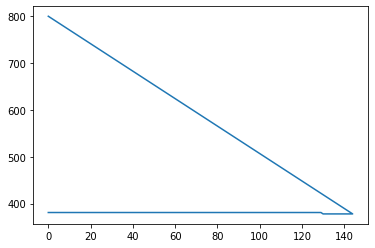

|  145      | -484.0    |  37.78    |  2.192    |  0.8644   |  0.03847  |  1.958e+0 |  3.043    |  0.4454   |  31.49    |  0.4163   |  0.3722   |  2.352    |  0.5077   |  1.894    |  1.947    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.37715
    t0: 1000000.0
    weight_decay: 0.6323414906541311
)
Batch Normalization Momentum:  0.63
Nodes:  11
LR:  0.37715
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.6323414906541311
BATCH_SIZE:  39
Dropout:  0.24
Final Linear Layers:  1
average loss: 0.693142
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


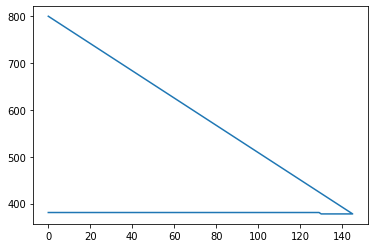

|  146      | -800.0    |  39.33    |  2.53     |  0.6344   |  0.2404   |  1.517e+0 |  1.694    |  0.3771   |  11.12    |  0.03047  |  0.6323   |  1.837    |  0.4219   |  3.216    |  9.527    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.51253
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.32
Nodes:  19
LR:  0.51253
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.1306262325220524
BATCH_SIZE:  12
Dropout:  0.07
Final Linear Layers:  3
average loss: 0.693018
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5210)
Class:  0  correct:  260.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6500)
Class:  1  correct:  65.0  of  tensor(100.)
Final percentage:  tensor(0.5855)
Last epoch:  14
Credit Cost:  -414


Best Score So Far:  -378


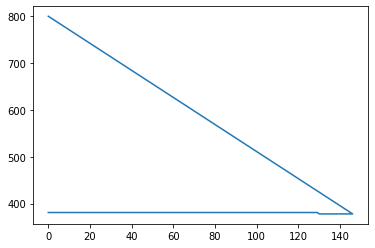

|  147      | -414.0    |  12.99    |  1.344    |  0.3191   |  0.07453  |  1.495e+0 |  3.465    |  0.5125   |  19.87    |  0.2407   |  0.1306   |  2.479    |  0.2348   |  2.613    |  7.736    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.13496
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.04
Nodes:  2
LR:  0.13496
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.16226902871115723
BATCH_SIZE:  32
Dropout:  0.04
Final Linear Layers:  1
average loss: 0.692748
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4810)
Class:  0  correct:  240.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6500)
Class:  1  correct:  65.0  of  tensor(100.)
Final percentage:  tensor(0.5655)
Last epoch:  16
Credit Cost:  -434


Best Score So Far:  -378


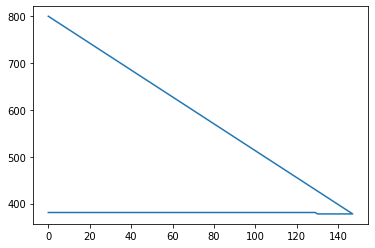

|  148      | -434.0    |  32.3     |  1.347    |  0.03934  |  0.04427  |  1.851e+0 |  1.313    |  0.135    |  2.983    |  0.676    |  0.1623   |  1.823    |  0.1379   |  2.128    |  4.816    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.1639
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.1
Nodes:  11
LR:  0.1639
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.3624989279970088
BATCH_SIZE:  62
Dropout:  0.23
Final Linear Layers:  2
average loss: 0.693620
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4990)
Class:  0  correct:  249.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.4795)
Last epoch:  17
Credit Cost:  -520


Best Score So Far:  -378


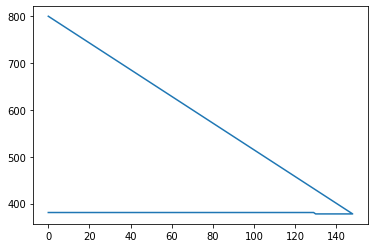

|  149      | -520.0    |  62.65    |  1.841    |  0.1017   |  0.2318   |  1.137e+0 |  2.269    |  0.1639   |  11.03    |  0.6721   |  0.3625   |  1.378    |  0.4644   |  2.015    |  7.333    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.28362
    weight_decay: 0.19849535645639715
)
Batch Normalization Momentum:  0.52
Nodes:  31
LR:  0.28362
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.19849535645639715
BATCH_SIZE:  32
Dropout:  0.15
Final Linear Layers:  1
average loss: 0.693742
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3500)
Class:  1  correct:  35.0  of  tensor(100.)
Final percentage:  tensor(0.4335)
Last epoch:  10
Credit Cost:  -566


Best Score So Far:  -378


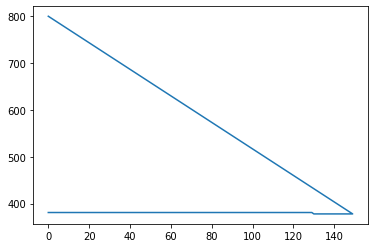

|  150      | -566.0    |  32.04    |  2.682    |  0.521    |  0.1502   |  1.254e+0 |  1.557    |  0.2836   |  31.45    |  0.1336   |  0.1985   |  2.593    |  0.6581   |  1.833    |  3.829    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.55551
    weight_decay: 0.21354545258528002
)
Batch Normalization Momentum:  0.71
Nodes:  25
LR:  0.55551
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.21354545258528002
BATCH_SIZE:  56
Dropout:  0.26
Final Linear Layers:  1
average loss: 0.693385
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5271)
Class:  0  correct:  263.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3300)
Class:  1  correct:  33.0  of  tensor(100.)
Final percentage:  tensor(0.4285)
Last epoch:  10
Credit Cost:  -571


Best Score So Far:  -378


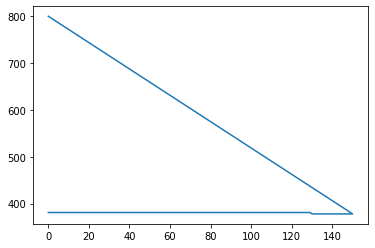

|  151      | -571.0    |  56.07    |  2.2      |  0.7121   |  0.2572   |  1.681e+0 |  1.709    |  0.5555   |  25.44    |  0.3078   |  0.2135   |  2.754    |  0.1248   |  2.894    |  3.497    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.2388
    weight_decay: 0.5273527315454851
)
Batch Normalization Momentum:  0.73
Nodes:  6
LR:  0.2388
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5273527315454851
BATCH_SIZE:  106
Dropout:  0.06
Final Linear Layers:  3
average loss: 0.708879
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4790)
Class:  0  correct:  239.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4545)
Last epoch:  13
Credit Cost:  -545


Best Score So Far:  -378


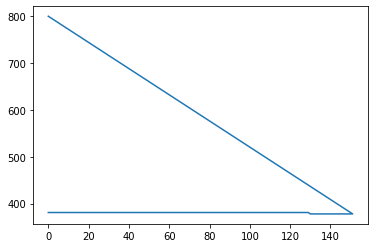

|  152      | -545.0    |  106.6    |  1.725    |  0.726    |  0.05773  |  1.481e+0 |  3.403    |  0.2388   |  6.847    |  0.6487   |  0.5274   |  1.558    |  0.4468   |  3.692    |  8.839    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.33728
    rho: 0.9
    weight_decay: 0.27988851587783703
)
Batch Normalization Momentum:  0.81
Nodes:  24
LR:  0.33728
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.27988851587783703
BATCH_SIZE:  91
Dropout:  0.27
Final Linear Layers:  2
average loss: 0.692922
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4830)
Class:  0  correct:  241.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5465)
Last epoch:  8
Credit Cost:  -453


Best Score So Far:  -378


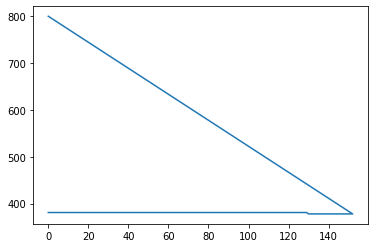

|  153      | -453.0    |  91.69    |  2.176    |  0.8092   |  0.2723   |  1.003e+0 |  2.188    |  0.3373   |  24.02    |  0.0883   |  0.2799   |  1.556    |  0.4193   |  2.489    |  6.934    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.1928
    weight_decay: 0.42808848371405567
)
Batch Normalization Momentum:  0.58
Nodes:  6
LR:  0.1928
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.42808848371405567
BATCH_SIZE:  65
Dropout:  0.13
Final Linear Layers:  1
average loss: 0.704267
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5190)
Class:  0  correct:  259.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5900)
Class:  1  correct:  59.0  of  tensor(100.)
Final percentage:  tensor(0.5545)
Last epoch:  13
Credit Cost:  -445


Best Score So Far:  -378


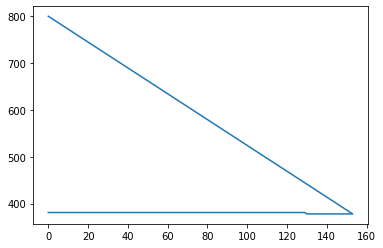

|  154      | -445.0    |  65.53    |  2.235    |  0.5766   |  0.1285   |  1.005e+0 |  1.582    |  0.1928   |  6.409    |  0.5985   |  0.4281   |  1.995    |  0.3176   |  2.953    |  2.711    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.22749
    weight_decay: 0.13716438014912719
)
Batch Normalization Momentum:  0.44
Nodes:  22
LR:  0.22749
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.13716438014912719
BATCH_SIZE:  4
Dropout:  0.21
Final Linear Layers:  1
average loss: 0.693152
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6200)
Class:  1  correct:  62.0  of  tensor(100.)
Final percentage:  tensor(0.5685)
Last epoch:  13
Credit Cost:  -431


Best Score So Far:  -378


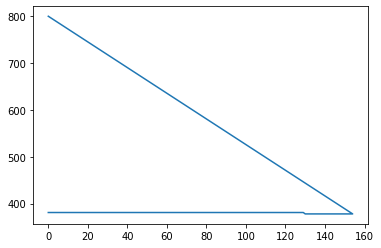

|  155      | -431.0    |  4.729    |  2.463    |  0.4391   |  0.2094   |  1.185e+0 |  1.187    |  0.2275   |  22.88    |  0.1036   |  0.1372   |  1.903    |  0.6149   |  3.243    |  1.987    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.01219
    t0: 1000000.0
    weight_decay: 0.4468764966693709
)
Batch Normalization Momentum:  0.66
Nodes:  16
LR:  0.01219
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.4468764966693709
BATCH_SIZE:  81
Dropout:  0.06
Final Linear Layers:  1
average loss: 0.691797
Class:  0  accuracy:  tensor(0.5391)
Class:  0  correct:  269.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5400)
Class:  1  correct:  54.0  of  tensor(100.)
Final percentage:  tensor(0.5395)
Last epoch:  7
Credit Cost:  -460


Best Score So Far:  -378


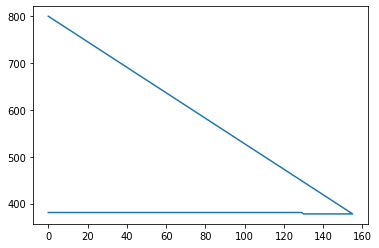

|  156      | -460.0    |  81.45    |  1.771    |  0.6634   |  0.06107  |  1.528e+0 |  1.515    |  0.01219  |  16.61    |  0.1848   |  0.4469   |  2.068    |  0.7672   |  2.175    |  9.895    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.11429
    momentum: 0.52
    nesterov: False
    weight_decay: 0.32382408933350776
)
Batch Normalization Momentum:  0.74
Nodes:  13
LR:  0.11429
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.32382408933350776
BATCH_SIZE:  67
Dropout:  0.17
Final Linear Layers:  2
average loss: 0.693276
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4749)
Class:  0  correct:  237.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.5275)
Last epoch:  9
Credit Cost:  -472


Best Score So Far:  -378


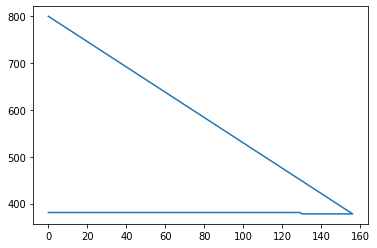

|  157      | -472.0    |  67.89    |  1.953    |  0.7419   |  0.1718   |  1.362e+0 |  2.463    |  0.1143   |  13.81    |  0.0309   |  0.3238   |  1.546    |  0.5214   |  1.088    |  5.99     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.59916
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.73
Nodes:  9
LR:  0.59916
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.15213210329867344
BATCH_SIZE:  40
Dropout:  0.13
Final Linear Layers:  1
average loss: 0.694480
Class:  0  accuracy:  tensor(0.4810)
Class:  0  correct:  240.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4605)
Last epoch:  7
Credit Cost:  -539


Best Score So Far:  -378


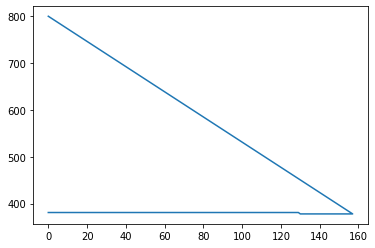

|  158      | -539.0    |  40.33    |  2.149    |  0.7254   |  0.1321   |  1.663e+0 |  1.714    |  0.5992   |  9.286    |  0.9399   |  0.1521   |  1.99     |  0.813    |  3.143    |  7.343    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.23507
    weight_decay: 0.07747915243478332
)
Batch Normalization Momentum:  0.91
Nodes:  16
LR:  0.23507
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.07747915243478332
BATCH_SIZE:  58
Dropout:  0.13
Final Linear Layers:  1
average loss: 8.900586
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5210)
Class:  0  correct:  260.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6600)
Class:  1  correct:  66.0  of  tensor(100.)
Final percentage:  tensor(0.5905)
Last epoch:  19
Credit Cost:  -409


Best Score So Far:  -378


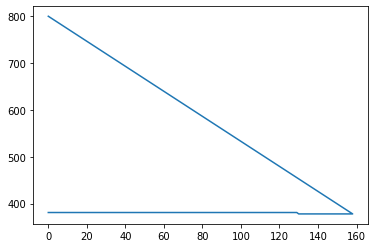

|  159      | -409.0    |  58.61    |  2.501    |  0.9108   |  0.1324   |  1.528e+0 |  1.197    |  0.2351   |  16.02    |  0.8943   |  0.07748  |  2.455    |  0.54     |  2.814    |  1.268    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.32636
    weight_decay: 0.25677571396449306
)
Batch Normalization Momentum:  0.0
Nodes:  20
LR:  0.32636
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.25677571396449306
BATCH_SIZE:  22
Dropout:  0.2
Final Linear Layers:  2
average loss: 0.693160
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5411)
Class:  0  correct:  270.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5755)
Last epoch:  8
Credit Cost:  -424


Best Score So Far:  -378


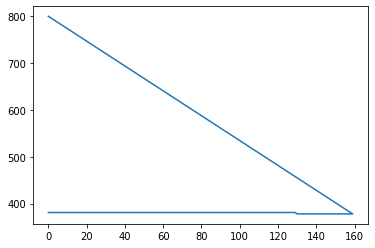

|  160      | -424.0    |  22.2     |  1.565    |  0.004823 |  0.2007   |  1.87e+03 |  2.635    |  0.3264   |  20.47    |  0.3026   |  0.2568   |  2.144    |  0.8011   |  1.603    |  3.944    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.38144
    weight_decay: 0.21508182186271796
)
Batch Normalization Momentum:  0.05
Nodes:  28
LR:  0.38144
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.21508182186271796
BATCH_SIZE:  96
Dropout:  0.05
Final Linear Layers:  2
average loss: 0.692494
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.5385)
Last epoch:  7
Credit Cost:  -461


Best Score So Far:  -378


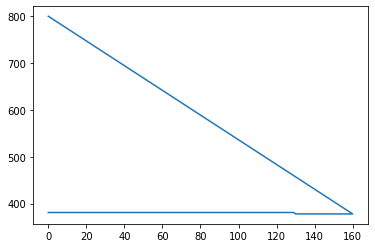

|  161      | -461.0    |  96.12    |  1.678    |  0.04713  |  0.04691  |  1.194e+0 |  2.48     |  0.3814   |  28.41    |  0.9017   |  0.2151   |  2.499    |  0.2796   |  2.102    |  3.632    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.55394
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.32
Nodes:  24
LR:  0.55394
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5282600954931613
BATCH_SIZE:  55
Dropout:  0.04
Final Linear Layers:  2
average loss: 0.692995
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4649)
Class:  0  correct:  232.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.4775)
Last epoch:  11
Credit Cost:  -522


Best Score So Far:  -378


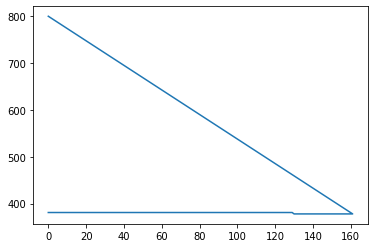

|  162      | -522.0    |  55.3     |  1.427    |  0.3158   |  0.03658  |  1.963e+0 |  2.507    |  0.5539   |  24.38    |  0.4578   |  0.5283   |  2.25     |  0.3007   |  2.56     |  7.404    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.08055
    weight_decay: 0.5277329632276869
)
Batch Normalization Momentum:  0.27
Nodes:  24
LR:  0.08055
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5277329632276869
BATCH_SIZE:  41
Dropout:  0.24
Final Linear Layers:  2
average loss: 0.695356
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5190)
Class:  0  correct:  259.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6500)
Class:  1  correct:  65.0  of  tensor(100.)
Final percentage:  tensor(0.5845)
Last epoch:  8
Credit Cost:  -415


Best Score So Far:  -378


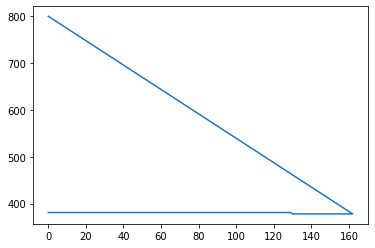

|  163      | -415.0    |  41.86    |  1.025    |  0.2656   |  0.239    |  1.93e+03 |  2.87     |  0.08055  |  24.73    |  0.5269   |  0.5277   |  2.709    |  0.9381   |  2.957    |  8.68     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.05133
    weight_decay: 0.3794991007019121
)
Batch Normalization Momentum:  0.85
Nodes:  26
LR:  0.05133
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.3794991007019121
BATCH_SIZE:  96
Dropout:  0.28
Final Linear Layers:  2
average loss: 0.692661
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5130)
Class:  0  correct:  256.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5400)
Class:  1  correct:  54.0  of  tensor(100.)
Final percentage:  tensor(0.5265)
Last epoch:  11
Credit Cost:  -473


Best Score So Far:  -378


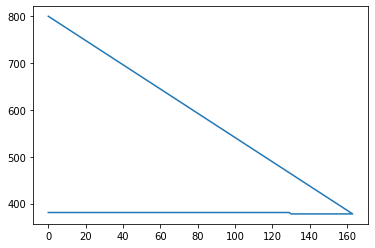

|  164      | -473.0    |  96.08    |  2.447    |  0.8502   |  0.2769   |  1.902e+0 |  2.183    |  0.05133  |  26.89    |  0.5389   |  0.3795   |  2.642    |  0.03166  |  3.625    |  1.311    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.53161
    rho: 0.9
    weight_decay: 0.3090213237443552
)
Batch Normalization Momentum:  0.64
Nodes:  18
LR:  0.53161
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.3090213237443552
BATCH_SIZE:  89
Dropout:  0.11
Final Linear Layers:  2
average loss: 0.692042
Class:  0  accuracy:  tensor(0.5391)
Class:  0  correct:  269.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5845)
Last epoch:  7
Credit Cost:  -415


Best Score So Far:  -378


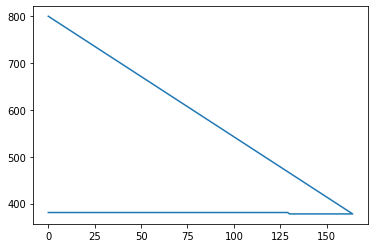

|  165      | -415.0    |  89.96    |  2.169    |  0.6353   |  0.1122   |  1.275e+0 |  2.523    |  0.5316   |  18.96    |  0.6628   |  0.309    |  2.935    |  0.7351   |  2.061    |  6.875    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.51258
    weight_decay: 0.4365239055517862
)
Batch Normalization Momentum:  0.27
Nodes:  10
LR:  0.51258
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4365239055517862
BATCH_SIZE:  71
Dropout:  0.03
Final Linear Layers:  2
average loss: 0.693178
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5271)
Class:  0  correct:  263.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4985)
Last epoch:  8
Credit Cost:  -500


Best Score So Far:  -378


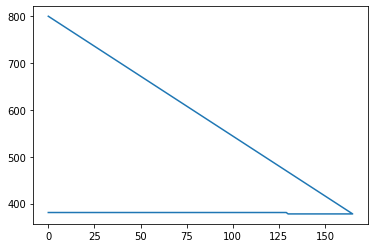

|  166      | -500.0    |  71.28    |  2.759    |  0.2723   |  0.03242  |  1.191e+0 |  2.157    |  0.5126   |  10.13    |  0.6261   |  0.4365   |  1.812    |  0.04983  |  3.227    |  3.659    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.58984
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.66
Nodes:  19
LR:  0.58984
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.10280887671616515
BATCH_SIZE:  53
Dropout:  0.03
Final Linear Layers:  1
average loss: 0.690642
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5571)
Class:  0  correct:  278.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5786)
Last epoch:  8
Credit Cost:  -421


Best Score So Far:  -378


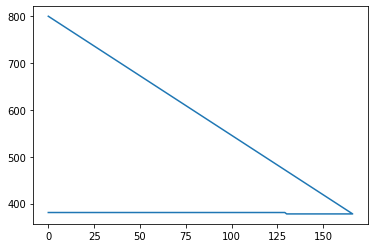

|  167      | -421.0    |  53.41    |  1.751    |  0.657    |  0.0259   |  1.55e+03 |  1.046    |  0.5898   |  19.95    |  0.3843   |  0.1028   |  2.387    |  0.8968   |  1.951    |  7.891    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.55425
    rho: 0.9
    weight_decay: 0.40018757197082244
)
Batch Normalization Momentum:  0.7
Nodes:  22
LR:  0.55425
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.40018757197082244
BATCH_SIZE:  39
Dropout:  0.19
Final Linear Layers:  1
average loss: 0.693010
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


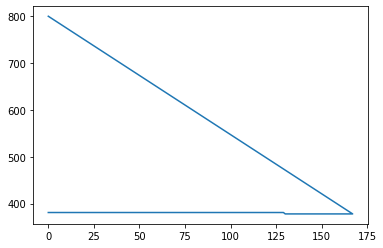

|  168      | -800.0    |  39.65    |  2.905    |  0.6953   |  0.1875   |  1.931e+0 |  1.804    |  0.5542   |  22.34    |  0.7708   |  0.4002   |  2.659    |  0.6913   |  1.438    |  6.506    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.335
    rho: 0.9
    weight_decay: 0.24325501156714346
)
Batch Normalization Momentum:  0.2
Nodes:  19
LR:  0.335
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.24325501156714346
BATCH_SIZE:  38
Dropout:  0.09
Final Linear Layers:  2
average loss: 0.693566
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5451)
Class:  0  correct:  272.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4825)
Last epoch:  11
Credit Cost:  -517


Best Score So Far:  -378


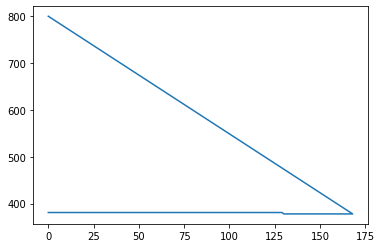

|  169      | -517.0    |  38.64    |  2.823    |  0.1962   |  0.08571  |  1.048e+0 |  2.338    |  0.335    |  19.21    |  0.9046   |  0.2433   |  1.891    |  0.8427   |  2.725    |  6.879    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.287
    weight_decay: 0.06839807432146153
)
Batch Normalization Momentum:  0.61
Nodes:  2
LR:  0.287
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.06839807432146153
BATCH_SIZE:  38
Dropout:  0.04
Final Linear Layers:  1
average loss: 0.692182
Class:  0  accuracy:  tensor(0.5210)
Class:  0  correct:  260.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5900)
Class:  1  correct:  59.0  of  tensor(100.)
Final percentage:  tensor(0.5555)
Last epoch:  7
Credit Cost:  -444


Best Score So Far:  -378


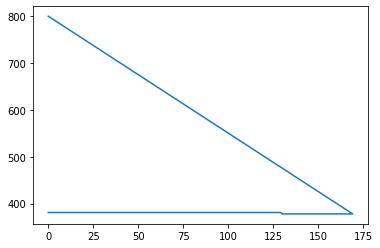

|  170      | -444.0    |  38.52    |  1.97     |  0.6147   |  0.04002  |  1.033e+0 |  1.339    |  0.287    |  2.721    |  0.626    |  0.0684   |  1.499    |  0.4222   |  1.346    |  3.432    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.27208
    weight_decay: 0.43038584556920095
)
Batch Normalization Momentum:  0.61
Nodes:  29
LR:  0.27208
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.43038584556920095
BATCH_SIZE:  6
Dropout:  0.11
Final Linear Layers:  2
average loss: 0.692881
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


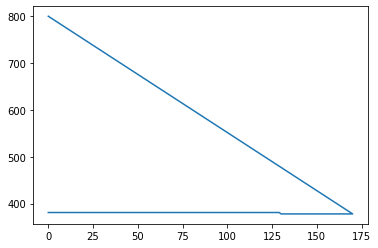

|  171      | -800.0    |  6.614    |  2.96     |  0.6055   |  0.1135   |  1.027e+0 |  2.166    |  0.2721   |  29.93    |  0.2789   |  0.4304   |  2.324    |  0.1841   |  2.512    |  8.071    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.5555
    t0: 1000000.0
    weight_decay: 0.6029605968906718
)
Batch Normalization Momentum:  0.03
Nodes:  14
LR:  0.5555
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.6029605968906718
BATCH_SIZE:  15
Dropout:  0.0
Final Linear Layers:  2
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


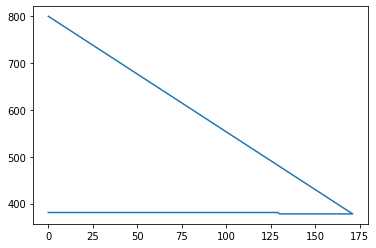

|  172      | -800.0    |  15.98    |  2.206    |  0.0258   |  0.002114 |  1.06e+03 |  2.439    |  0.5555   |  14.17    |  0.07588  |  0.603    |  2.033    |  0.3157   |  3.879    |  9.435    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.09818
    weight_decay: 0.10515391310029977
)
Batch Normalization Momentum:  0.58
Nodes:  7
LR:  0.09818
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.10515391310029977
BATCH_SIZE:  36
Dropout:  0.25
Final Linear Layers:  2
average loss: 0.693227
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4910)
Class:  0  correct:  245.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6200)
Class:  1  correct:  62.0  of  tensor(100.)
Final percentage:  tensor(0.5555)
Last epoch:  8
Credit Cost:  -444


Best Score So Far:  -378


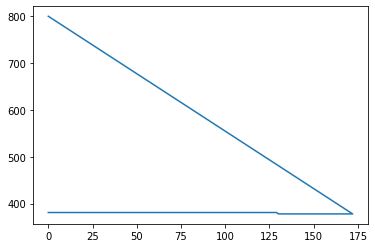

|  173      | -444.0    |  36.24    |  1.401    |  0.583    |  0.2528   |  1.337e+0 |  2.753    |  0.09818  |  7.838    |  0.7608   |  0.1052   |  1.529    |  0.6826   |  1.045    |  1.289    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.38333
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.36
Nodes:  6
LR:  0.38333
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.45193052935057554
BATCH_SIZE:  39
Dropout:  0.24
Final Linear Layers:  2
average loss: 0.692532
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4830)
Class:  0  correct:  241.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.4965)
Last epoch:  9
Credit Cost:  -503


Best Score So Far:  -378


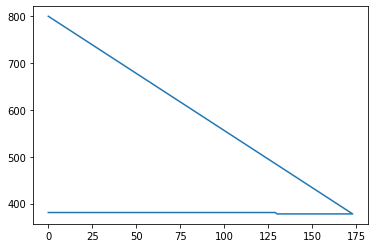

|  174      | -503.0    |  39.65    |  1.67     |  0.3586   |  0.2422   |  1.036e+0 |  2.072    |  0.3833   |  6.29     |  0.857    |  0.4519   |  1.229    |  0.206    |  3.229    |  4.627    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.13472
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.14
Nodes:  26
LR:  0.13472
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.45731047446869744
BATCH_SIZE:  64
Dropout:  0.29
Final Linear Layers:  1
average loss: 0.693512
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5491)
Class:  0  correct:  274.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4895)
Last epoch:  12
Credit Cost:  -510


Best Score So Far:  -378


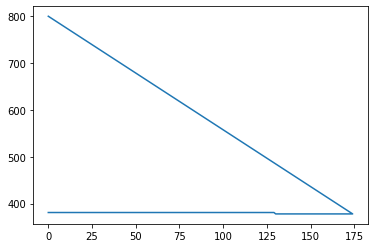

|  175      | -510.0    |  64.07    |  2.766    |  0.1361   |  0.2893   |  1.043e+0 |  1.297    |  0.1347   |  26.2     |  0.456    |  0.4573   |  1.347    |  0.1651   |  2.557    |  7.655    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.45421
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.65
Nodes:  30
LR:  0.45421
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.18320139379877692
BATCH_SIZE:  61
Dropout:  0.07
Final Linear Layers:  2
average loss: 0.694408
Class:  0  accuracy:  tensor(0.4168)
Class:  0  correct:  208.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4800)
Class:  1  correct:  48.0  of  tensor(100.)
Final percentage:  tensor(0.4484)
Last epoch:  7
Credit Cost:  -551


Best Score So Far:  -378


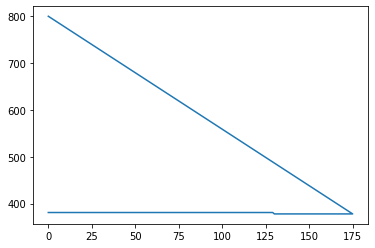

|  176      | -551.0    |  61.35    |  2.731    |  0.6538   |  0.07473  |  1.235e+0 |  2.118    |  0.4542   |  30.14    |  0.8612   |  0.1832   |  1.82     |  0.6054   |  2.635    |  4.5      |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.29237
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.09
Nodes:  22
LR:  0.29237
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.5582674394069147
BATCH_SIZE:  16
Dropout:  0.26
Final Linear Layers:  3
average loss: 0.695195
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4509)
Class:  0  correct:  225.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4000)
Class:  1  correct:  40.0  of  tensor(100.)
Final percentage:  tensor(0.4255)
Last epoch:  12
Credit Cost:  -574


Best Score So Far:  -378


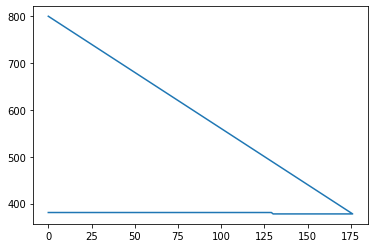

|  177      | -574.0    |  16.58    |  2.417    |  0.08725  |  0.2598   |  1.863e+0 |  3.118    |  0.2924   |  22.97    |  0.3952   |  0.5583   |  2.565    |  0.154    |  1.95     |  4.092    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.27108
    weight_decay: 0.12629621198734675
)
Batch Normalization Momentum:  0.04
Nodes:  12
LR:  0.27108
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.12629621198734675
BATCH_SIZE:  49
Dropout:  0.2
Final Linear Layers:  2
average loss: 6.488399
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5651)
Class:  0  correct:  282.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5826)
Last epoch:  12
Credit Cost:  -417


Best Score So Far:  -378


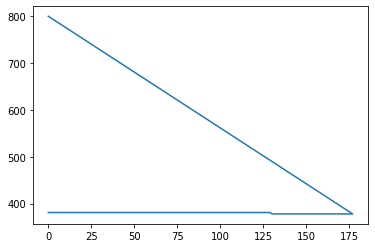

|  178      | -417.0    |  49.16    |  2.128    |  0.04127  |  0.198    |  1.202e+0 |  2.245    |  0.2711   |  12.46    |  0.3835   |  0.1263   |  1.136    |  0.5457   |  2.782    |  2.308    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.20671
    rho: 0.9
    weight_decay: 0.3873854302267185
)
Batch Normalization Momentum:  0.82
Nodes:  12
LR:  0.20671
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.3873854302267185
BATCH_SIZE:  32
Dropout:  0.05
Final Linear Layers:  2
average loss: 0.693418
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4950)
Class:  0  correct:  247.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4575)
Last epoch:  13
Credit Cost:  -542


Best Score So Far:  -378


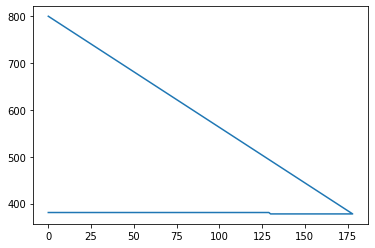

|  179      | -542.0    |  32.64    |  1.57     |  0.8224   |  0.04603  |  1.552e+0 |  2.699    |  0.2067   |  12.52    |  0.9582   |  0.3874   |  2.299    |  0.4858   |  2.933    |  6.441    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.50865
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.46
Nodes:  12
LR:  0.50865
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.2857861638563123
BATCH_SIZE:  22
Dropout:  0.04
Final Linear Layers:  1
average loss: 0.693079
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5190)
Class:  0  correct:  259.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5145)
Last epoch:  13
Credit Cost:  -485


Best Score So Far:  -378


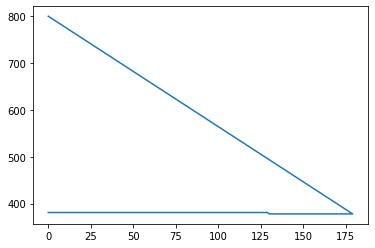

|  180      | -485.0    |  22.0     |  1.666    |  0.4558   |  0.03835  |  1.363e+0 |  1.682    |  0.5087   |  12.24    |  0.2273   |  0.2858   |  2.359    |  0.06497  |  1.54     |  7.242    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.09129
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.87
Nodes:  9
LR:  0.09129
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.24094912394950063
BATCH_SIZE:  97
Dropout:  0.05
Final Linear Layers:  3
average loss: 0.693383
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4369)
Class:  0  correct:  218.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4284)
Last epoch:  12
Credit Cost:  -571


Best Score So Far:  -378


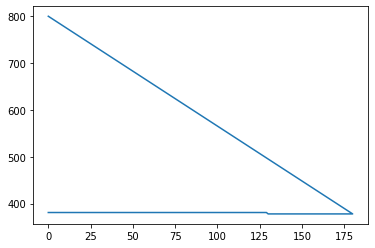

|  181      | -571.0    |  97.28    |  2.229    |  0.8704   |  0.05064  |  1.704e+0 |  3.743    |  0.09129  |  9.313    |  0.5466   |  0.2409   |  2.374    |  0.05699  |  1.481    |  7.439    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.32598
    weight_decay: 0.5472225282486183
)
Batch Normalization Momentum:  0.89
Nodes:  28
LR:  0.32598
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.5472225282486183
BATCH_SIZE:  124
Dropout:  0.04
Final Linear Layers:  1
average loss: 1.191112
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4950)
Class:  0  correct:  247.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.4925)
Last epoch:  19
Credit Cost:  -507


Best Score So Far:  -378


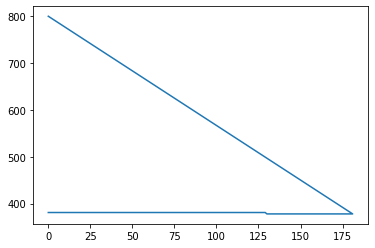

|  182      | -507.0    |  124.4    |  2.85     |  0.8921   |  0.03832  |  1.146e+0 |  1.216    |  0.326    |  28.47    |  0.5317   |  0.5472   |  1.375    |  0.8545   |  1.56     |  1.492    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.23487
    weight_decay: 0.24384485155734778
)
Batch Normalization Momentum:  0.96
Nodes:  10
LR:  0.23487
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.24384485155734778
BATCH_SIZE:  56
Dropout:  0.03
Final Linear Layers:  1
average loss: 2.468455
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5331)
Class:  0  correct:  266.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7100)
Class:  1  correct:  71.0  of  tensor(100.)
Final percentage:  tensor(0.6215)
Last epoch:  11
Credit Cost:  -378


Best Score So Far:  -378


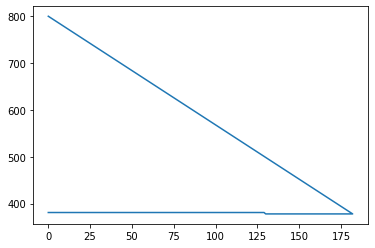

|  183      | -378.0    |  56.26    |  2.105    |  0.961    |  0.02753  |  1.274e+0 |  1.314    |  0.2349   |  10.67    |  0.5133   |  0.2438   |  2.847    |  0.782    |  3.574    |  2.164    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.24185
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.86
Nodes:  10
LR:  0.24185
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.08319941053830425
BATCH_SIZE:  75
Dropout:  0.0
Final Linear Layers:  2
average loss: 0.692099
Class:  0  accuracy:  tensor(0.4810)
Class:  0  correct:  240.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5155)
Last epoch:  7
Credit Cost:  -484


Best Score So Far:  -378


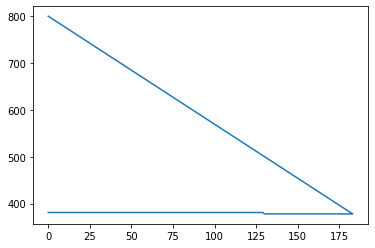

|  184      | -484.0    |  75.31    |  1.427    |  0.8596   |  0.004506 |  1.106e+0 |  2.124    |  0.2419   |  10.32    |  0.09687  |  0.0832   |  1.633    |  0.9413   |  1.62     |  7.718    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.43756
    weight_decay: 0.5698702199876281
)
Batch Normalization Momentum:  0.02
Nodes:  12
LR:  0.43756
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.5698702199876281
BATCH_SIZE:  36
Dropout:  0.05
Final Linear Layers:  3
average loss: 0.694907
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4689)
Class:  0  correct:  234.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5395)
Last epoch:  11
Credit Cost:  -460


Best Score So Far:  -378


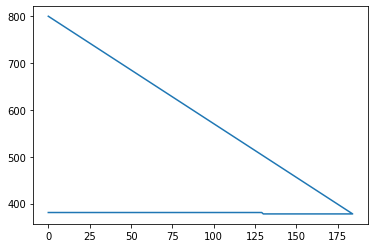

|  185      | -460.0    |  36.02    |  1.074    |  0.01589  |  0.04581  |  1.462e+0 |  3.26     |  0.4376   |  12.57    |  0.4792   |  0.5699   |  2.668    |  0.3167   |  1.013    |  1.422    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.31677
    weight_decay: 0.0014743554032257686
)
Batch Normalization Momentum:  0.48
Nodes:  10
LR:  0.31677
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.0014743554032257686
BATCH_SIZE:  95
Dropout:  0.06
Final Linear Layers:  2
average loss: 0.662559
Class:  0  accuracy:  tensor(0.5070)
Class:  0  correct:  253.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.5335)
Last epoch:  7
Credit Cost:  -466


Best Score So Far:  -378


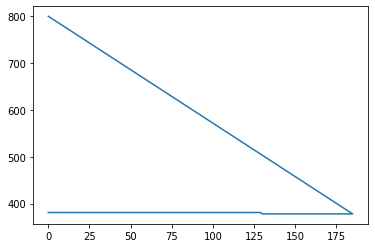

|  186      | -466.0    |  95.49    |  1.543    |  0.4767   |  0.05761  |  1.847e+0 |  2.505    |  0.3168   |  10.64    |  0.512    |  0.001474 |  1.552    |  0.3453   |  1.849    |  1.773    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.09035
    weight_decay: 0.5141551578014191
)
Batch Normalization Momentum:  0.93
Nodes:  5
LR:  0.09035
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.5141551578014191
BATCH_SIZE:  68
Dropout:  0.15
Final Linear Layers:  1
average loss: 0.693959
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4549)
Class:  0  correct:  227.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6600)
Class:  1  correct:  66.0  of  tensor(100.)
Final percentage:  tensor(0.5575)
Last epoch:  12
Credit Cost:  -442


Best Score So Far:  -378


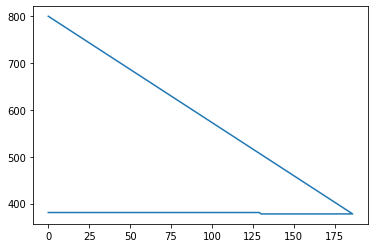

|  187      | -442.0    |  68.7     |  2.569    |  0.9332   |  0.1492   |  1.594e+0 |  1.87     |  0.09035  |  5.956    |  0.7319   |  0.5142   |  1.357    |  0.4094   |  2.776    |  2.126    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.51879
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.61
Nodes:  14
LR:  0.51879
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6476903053823504
BATCH_SIZE:  101
Dropout:  0.21
Final Linear Layers:  2
average loss: 0.695176
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4870)
Class:  0  correct:  243.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3800)
Class:  1  correct:  38.0  of  tensor(100.)
Final percentage:  tensor(0.4335)
Last epoch:  25
Credit Cost:  -566


Best Score So Far:  -378


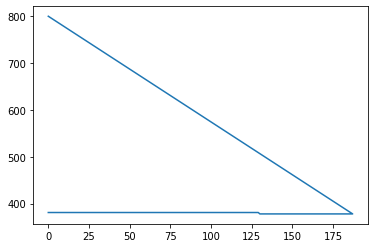

|  188      | -566.0    |  101.4    |  2.234    |  0.6091   |  0.2104   |  1.987e+0 |  2.682    |  0.5188   |  14.56    |  0.6542   |  0.6477   |  2.322    |  0.3      |  2.854    |  4.158    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.11419
    t0: 1000000.0
    weight_decay: 0.5898831390442633
)
Batch Normalization Momentum:  0.16
Nodes:  16
LR:  0.11419
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.5898831390442633
BATCH_SIZE:  43
Dropout:  0.15
Final Linear Layers:  2
average loss: 0.693283
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4890)
Class:  0  correct:  244.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.4945)
Last epoch:  12
Credit Cost:  -505


Best Score So Far:  -378


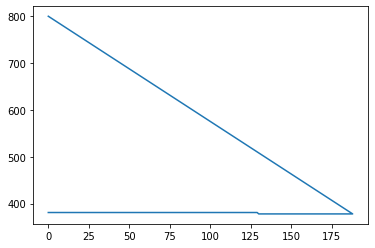

|  189      | -505.0    |  43.97    |  2.214    |  0.1587   |  0.146    |  1.946e+0 |  2.148    |  0.1142   |  16.07    |  0.8402   |  0.5899   |  2.647    |  0.01136  |  1.798    |  9.989    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.11738
    weight_decay: 0.4473730962204132
)
Batch Normalization Momentum:  0.78
Nodes:  28
LR:  0.11738
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.4473730962204132
BATCH_SIZE:  18
Dropout:  0.04
Final Linear Layers:  2
average loss: 0.686640
Class:  0  accuracy:  tensor(0.4188)
Class:  0  correct:  209.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4444)
Last epoch:  7
Credit Cost:  -555


Best Score So Far:  -378


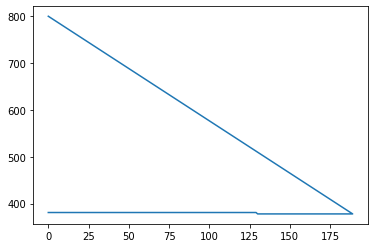

|  190      | -555.0    |  18.84    |  1.975    |  0.7821   |  0.03666  |  1.662e+0 |  2.459    |  0.1174   |  28.36    |  0.1821   |  0.4474   |  2.474    |  0.557    |  2.88     |  2.069    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.54206
    weight_decay: 0.43220588088617307
)
Batch Normalization Momentum:  0.39
Nodes:  13
LR:  0.54206
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.43220588088617307
BATCH_SIZE:  42
Dropout:  0.2
Final Linear Layers:  1
average loss: 0.693162
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5611)
Class:  0  correct:  280.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.1900)
Class:  1  correct:  19.0  of  tensor(100.)
Final percentage:  tensor(0.3756)
Last epoch:  8
Credit Cost:  -624


Best Score So Far:  -378


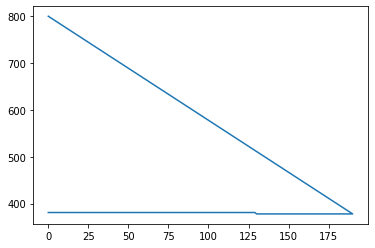

|  191      | -624.0    |  42.2     |  2.168    |  0.3915   |  0.1992   |  1.852e+0 |  1.569    |  0.5421   |  13.5     |  0.9422   |  0.4322   |  2.572    |  0.5096   |  2.588    |  3.945    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.52544
    t0: 1000000.0
    weight_decay: 0.4928510838058803
)
Batch Normalization Momentum:  0.21
Nodes:  4
LR:  0.52544
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.4928510838058803
BATCH_SIZE:  20
Dropout:  0.01
Final Linear Layers:  1
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


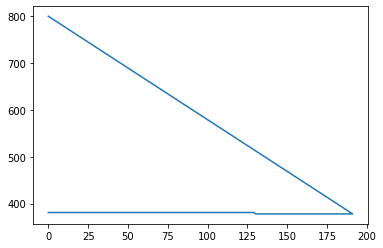

|  192      | -800.0    |  20.04    |  1.764    |  0.2128   |  0.00986  |  1.275e+0 |  1.54     |  0.5254   |  4.437    |  0.1845   |  0.4929   |  2.829    |  0.2489   |  1.064    |  9.635    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.43598
    weight_decay: 0.6560281446963745
)
Batch Normalization Momentum:  0.47
Nodes:  30
LR:  0.43598
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.6560281446963745
BATCH_SIZE:  88
Dropout:  0.18
Final Linear Layers:  3
average loss: 57.112839
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5150)
Class:  0  correct:  257.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5625)
Last epoch:  20
Credit Cost:  -437


Best Score So Far:  -378


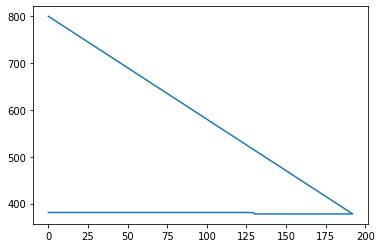

|  193      | -437.0    |  88.6     |  1.618    |  0.4676   |  0.1798   |  1.374e+0 |  3.615    |  0.436    |  30.63    |  0.3514   |  0.656    |  1.953    |  0.6359   |  3.203    |  8.276    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.10817
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.81
Nodes:  8
LR:  0.10817
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.523193175984505
BATCH_SIZE:  53
Dropout:  0.22
Final Linear Layers:  3
average loss: 0.689729
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5271)
Class:  0  correct:  263.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.5135)
Last epoch:  8
Credit Cost:  -486


Best Score So Far:  -378


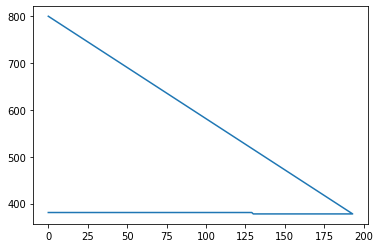

|  194      | -486.0    |  53.14    |  1.891    |  0.8091   |  0.2153   |  1.941e+0 |  3.929    |  0.1082   |  8.838    |  0.7156   |  0.5232   |  2.2      |  0.8685   |  1.753    |  4.052    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.5958
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.54
Nodes:  11
LR:  0.5958
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5721644753258808
BATCH_SIZE:  65
Dropout:  0.2
Final Linear Layers:  2
average loss: 0.692498
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5371)
Class:  0  correct:  268.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.5185)
Last epoch:  11
Credit Cost:  -481


Best Score So Far:  -378


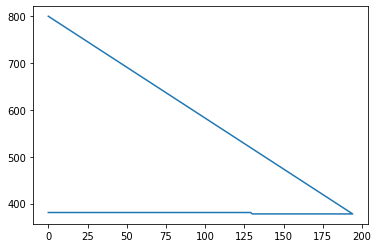

|  195      | -481.0    |  65.34    |  1.627    |  0.54     |  0.2047   |  1.22e+03 |  2.451    |  0.5958   |  11.72    |  0.03629  |  0.5722   |  2.002    |  0.05226  |  3.662    |  4.637    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.11166
    t0: 1000000.0
    weight_decay: 0.37367938785181093
)
Batch Normalization Momentum:  0.08
Nodes:  14
LR:  0.11166
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.37367938785181093
BATCH_SIZE:  119
Dropout:  0.07
Final Linear Layers:  3
average loss: 0.694267
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4870)
Class:  0  correct:  243.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4785)
Last epoch:  28
Credit Cost:  -521


Best Score So Far:  -378


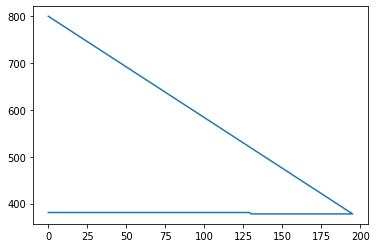

|  196      | -521.0    |  119.2    |  1.8      |  0.07606  |  0.07359  |  1.35e+03 |  3.245    |  0.1117   |  14.93    |  0.8725   |  0.3737   |  1.205    |  0.02428  |  3.11     |  9.802    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.41754
    weight_decay: 0.12347566197560379
)
Batch Normalization Momentum:  0.67
Nodes:  28
LR:  0.41754
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.12347566197560379
BATCH_SIZE:  101
Dropout:  0.24
Final Linear Layers:  1
average loss: 4.629721
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4850)
Class:  0  correct:  242.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5425)
Last epoch:  12
Credit Cost:  -457


Best Score So Far:  -378


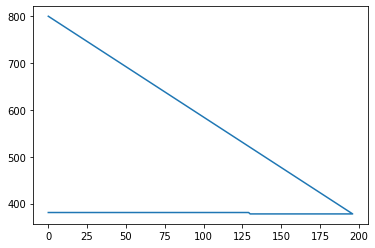

|  197      | -457.0    |  101.4    |  2.522    |  0.6687   |  0.2387   |  1.04e+03 |  1.791    |  0.4175   |  28.01    |  0.6743   |  0.1235   |  2.863    |  0.8943   |  1.259    |  2.735    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.08358
    weight_decay: 0.35719866228087366
)
Batch Normalization Momentum:  0.85
Nodes:  29
LR:  0.08358
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.35719866228087366
BATCH_SIZE:  38
Dropout:  0.17
Final Linear Layers:  2
average loss: 0.694956
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4890)
Class:  0  correct:  244.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.4695)
Last epoch:  9
Credit Cost:  -530


Best Score So Far:  -378


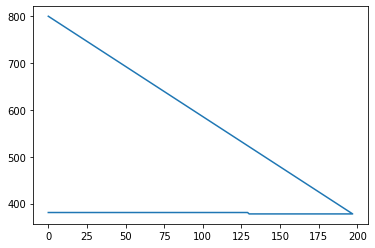

|  198      | -530.0    |  38.12    |  2.469    |  0.8508   |  0.1735   |  1.2e+03  |  2.241    |  0.08358  |  29.52    |  0.764    |  0.3572   |  1.903    |  0.09686  |  1.953    |  2.084    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.23324
    weight_decay: 0.024648026151624727
)
Batch Normalization Momentum:  0.23
Nodes:  10
LR:  0.23324
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.024648026151624727
BATCH_SIZE:  101
Dropout:  0.07
Final Linear Layers:  1
average loss: 0.716261
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4790)
Class:  0  correct:  239.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6500)
Class:  1  correct:  65.0  of  tensor(100.)
Final percentage:  tensor(0.5645)
Last epoch:  12
Credit Cost:  -435


Best Score So Far:  -378


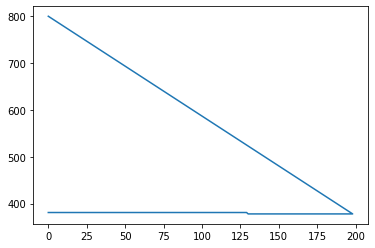

|  199      | -435.0    |  101.0    |  2.084    |  0.225    |  0.06726  |  1.26e+03 |  1.924    |  0.2332   |  10.93    |  0.6792   |  0.02465  |  1.653    |  0.7378   |  3.819    |  8.217    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.15737
    weight_decay: 0.5083686466756611
)
Batch Normalization Momentum:  0.19
Nodes:  2
LR:  0.15737
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5083686466756611
BATCH_SIZE:  33
Dropout:  0.26
Final Linear Layers:  3
average loss: 0.693057
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4729)
Class:  0  correct:  236.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6200)
Class:  1  correct:  62.0  of  tensor(100.)
Final percentage:  tensor(0.5465)
Last epoch:  10
Credit Cost:  -452


Best Score So Far:  -378


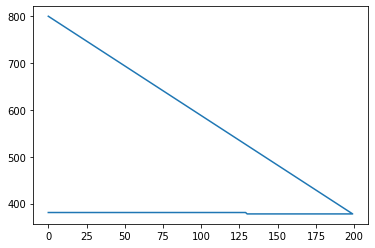

|  200      | -452.0    |  33.86    |  1.464    |  0.1884   |  0.2647   |  1.238e+0 |  3.267    |  0.1574   |  2.992    |  0.733    |  0.5084   |  1.177    |  0.3234   |  3.836    |  2.465    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.10393
    weight_decay: 0.024758366330286323
)
Batch Normalization Momentum:  0.92
Nodes:  2
LR:  0.10393
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.024758366330286323
BATCH_SIZE:  14
Dropout:  0.04
Final Linear Layers:  3
average loss: 0.693140
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


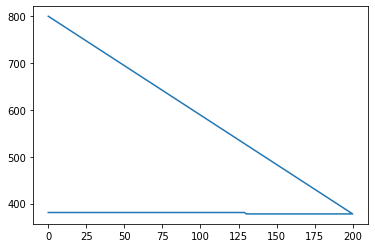

|  201      | -800.0    |  14.75    |  2.183    |  0.9217   |  0.04013  |  1.513e+0 |  3.045    |  0.1039   |  2.338    |  0.8869   |  0.02476  |  1.512    |  0.6452   |  1.854    |  1.087    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.53454
    rho: 0.9
    weight_decay: 0.16584229273259804
)
Batch Normalization Momentum:  0.15
Nodes:  27
LR:  0.53454
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.16584229273259804
BATCH_SIZE:  75
Dropout:  0.29
Final Linear Layers:  3
average loss: 0.694187
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4790)
Class:  0  correct:  239.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4595)
Last epoch:  16
Credit Cost:  -540


Best Score So Far:  -378


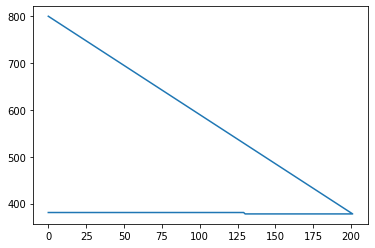

|  202      | -540.0    |  75.36    |  1.613    |  0.15     |  0.2914   |  1.165e+0 |  3.174    |  0.5345   |  27.76    |  0.1849   |  0.1658   |  1.037    |  0.9221   |  3.652    |  6.353    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.11457
    weight_decay: 0.3581547647763463
)
Batch Normalization Momentum:  0.57
Nodes:  15
LR:  0.11457
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.3581547647763463
BATCH_SIZE:  17
Dropout:  0.08
Final Linear Layers:  1
average loss: 0.692200
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


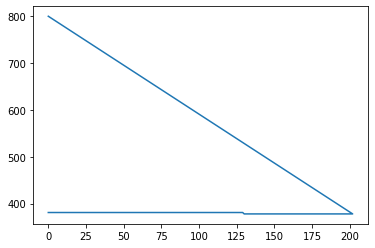

|  203      | -800.0    |  17.56    |  1.345    |  0.5712   |  0.0755   |  1.3e+03  |  1.511    |  0.1146   |  15.9     |  0.5099   |  0.3582   |  2.984    |  0.1283   |  3.261    |  8.136    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.0054
    weight_decay: 0.5840823273868827
)
Batch Normalization Momentum:  0.88
Nodes:  19
LR:  0.0054
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5840823273868827
BATCH_SIZE:  76
Dropout:  0.25
Final Linear Layers:  3
average loss: 0.693215
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5565)
Last epoch:  8
Credit Cost:  -443


Best Score So Far:  -378


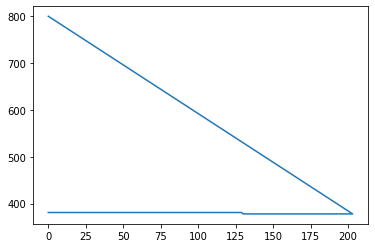

|  204      | -443.0    |  76.53    |  1.921    |  0.8845   |  0.2485   |  1.05e+03 |  3.879    |  0.005397 |  19.19    |  0.5723   |  0.5841   |  1.766    |  0.09013  |  2.739    |  1.223    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.557
    weight_decay: 0.579228119578612
)
Batch Normalization Momentum:  0.86
Nodes:  8
LR:  0.557
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.579228119578612
BATCH_SIZE:  48
Dropout:  0.05
Final Linear Layers:  3
average loss: 0.693145
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


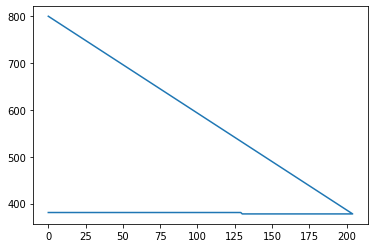

|  205      | -800.0    |  48.86    |  2.961    |  0.8601   |  0.04575  |  1.799e+0 |  3.425    |  0.557    |  8.732    |  0.499    |  0.5792   |  2.328    |  0.588    |  2.949    |  3.144    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.12254
    rho: 0.9
    weight_decay: 0.44225791151012384
)
Batch Normalization Momentum:  0.32
Nodes:  26
LR:  0.12254
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.44225791151012384
BATCH_SIZE:  7
Dropout:  0.11
Final Linear Layers:  2
average loss: 0.693065
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


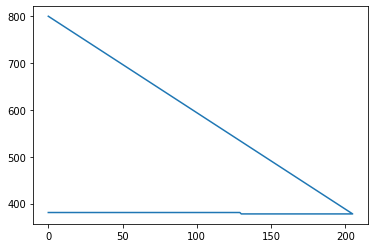

|  206      | -800.0    |  7.167    |  2.465    |  0.3235   |  0.113    |  1.613e+0 |  2.965    |  0.1225   |  26.78    |  0.3804   |  0.4423   |  2.923    |  0.5591   |  2.073    |  6.565    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.34222
    weight_decay: 0.5517193306299137
)
Batch Normalization Momentum:  0.72
Nodes:  9
LR:  0.34222
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5517193306299137
BATCH_SIZE:  66
Dropout:  0.28
Final Linear Layers:  1
average loss: 0.692874
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


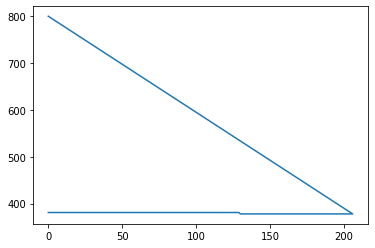

|  207      | -800.0    |  66.22    |  1.9      |  0.7249   |  0.2774   |  1.479e+0 |  1.264    |  0.3422   |  9.349    |  0.0405   |  0.5517   |  1.543    |  0.7693   |  2.46     |  3.858    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.31802
    weight_decay: 0.2193238644333055
)
Batch Normalization Momentum:  0.53
Nodes:  21
LR:  0.31802
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.2193238644333055
BATCH_SIZE:  42
Dropout:  0.25
Final Linear Layers:  1
average loss: 1.654860
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5271)
Class:  0  correct:  263.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5485)
Last epoch:  12
Credit Cost:  -451


Best Score So Far:  -378


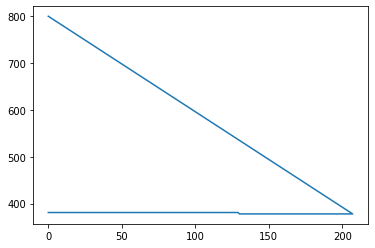

|  208      | -451.0    |  42.94    |  1.084    |  0.5291   |  0.2471   |  1.084e+0 |  1.325    |  0.318    |  21.8     |  0.6944   |  0.2193   |  1.075    |  0.4104   |  1.676    |  1.01     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.47719
    t0: 1000000.0
    weight_decay: 0.4833347704960341
)
Batch Normalization Momentum:  0.39
Nodes:  22
LR:  0.47719
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4833347704960341
BATCH_SIZE:  89
Dropout:  0.09
Final Linear Layers:  3
average loss: 0.693426
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4870)
Class:  0  correct:  243.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3800)
Class:  1  correct:  38.0  of  tensor(100.)
Final percentage:  tensor(0.4335)
Last epoch:  9
Credit Cost:  -566


Best Score So Far:  -378


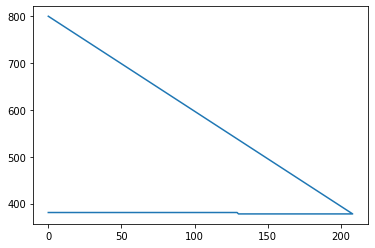

|  209      | -566.0    |  89.03    |  2.895    |  0.3872   |  0.09009  |  1.554e+0 |  3.547    |  0.4772   |  22.54    |  0.4322   |  0.4833   |  1.43     |  0.2811   |  3.326    |  9.361    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.42604
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.01
Nodes:  5
LR:  0.42604
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.634443915199277
BATCH_SIZE:  27
Dropout:  0.13
Final Linear Layers:  2
average loss: 0.691915
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4870)
Class:  0  correct:  243.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5435)
Last epoch:  9
Credit Cost:  -456


Best Score So Far:  -378


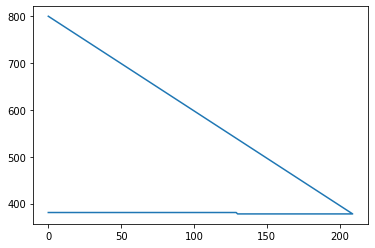

|  210      | -456.0    |  27.57    |  1.589    |  0.006148 |  0.1295   |  1.21e+03 |  2.918    |  0.426    |  5.563    |  0.08298  |  0.6344   |  1.775    |  0.5281   |  3.88     |  7.824    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.23156
    weight_decay: 0.6585991091887419
)
Batch Normalization Momentum:  0.53
Nodes:  19
LR:  0.23156
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6585991091887419
BATCH_SIZE:  44
Dropout:  0.1
Final Linear Layers:  3
average loss: 3.013496
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5010)
Class:  0  correct:  250.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5655)
Last epoch:  11
Credit Cost:  -434


Best Score So Far:  -378


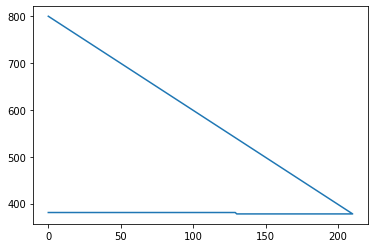

|  211      | -434.0    |  44.37    |  1.171    |  0.5307   |  0.1008   |  1.022e+0 |  3.306    |  0.2316   |  19.14    |  0.7552   |  0.6586   |  2.219    |  0.3122   |  1.329    |  1.665    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.329
    weight_decay: 0.20095992854767747
)
Batch Normalization Momentum:  0.69
Nodes:  24
LR:  0.329
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.20095992854767747
BATCH_SIZE:  43
Dropout:  0.06
Final Linear Layers:  1
average loss: 15.876406
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5230)
Class:  0  correct:  261.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.5415)
Last epoch:  14
Credit Cost:  -458


Best Score So Far:  -378


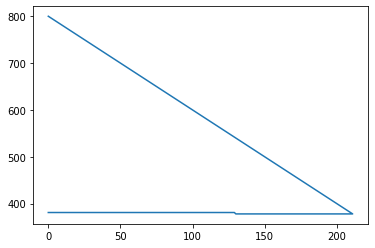

|  212      | -458.0    |  43.64    |  2.315    |  0.6882   |  0.06232  |  1.083e+0 |  1.913    |  0.329    |  24.64    |  0.5296   |  0.201    |  2.242    |  0.2622   |  2.952    |  8.569    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.34461
    weight_decay: 0.25686483708196944
)
Batch Normalization Momentum:  0.3
Nodes:  6
LR:  0.34461
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.25686483708196944
BATCH_SIZE:  83
Dropout:  0.26
Final Linear Layers:  3
average loss: 1.196067
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5651)
Class:  0  correct:  282.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6200)
Class:  1  correct:  62.0  of  tensor(100.)
Final percentage:  tensor(0.5926)
Last epoch:  13
Credit Cost:  -407


Best Score So Far:  -378


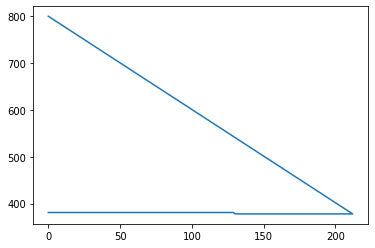

|  213      | -407.0    |  83.23    |  2.126    |  0.3041   |  0.263    |  1.989e+0 |  3.325    |  0.3446   |  6.238    |  0.3153   |  0.2569   |  1.581    |  0.4415   |  2.826    |  2.914    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.58868
    weight_decay: 0.15015709313265224
)
Batch Normalization Momentum:  0.3
Nodes:  15
LR:  0.58868
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.15015709313265224
BATCH_SIZE:  34
Dropout:  0.15
Final Linear Layers:  3
average loss: 33.768719
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5150)
Class:  0  correct:  257.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6900)
Class:  1  correct:  69.0  of  tensor(100.)
Final percentage:  tensor(0.6025)
Last epoch:  12
Credit Cost:  -397


Best Score So Far:  -378


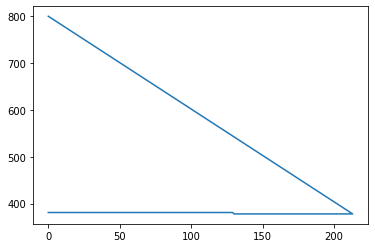

|  214      | -397.0    |  34.97    |  1.223    |  0.3045   |  0.1492   |  1.49e+03 |  3.977    |  0.5887   |  15.1     |  0.9711   |  0.1502   |  2.077    |  0.4489   |  3.893    |  8.517    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.11562
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.17
Nodes:  31
LR:  0.11562
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.38965850220556103
BATCH_SIZE:  30
Dropout:  0.16
Final Linear Layers:  1
average loss: 0.693009
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4990)
Class:  0  correct:  249.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4645)
Last epoch:  12
Credit Cost:  -535


Best Score So Far:  -378


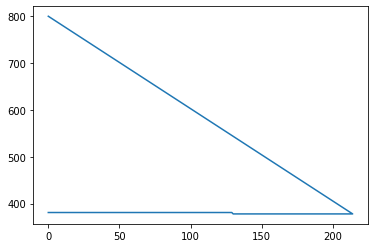

|  215      | -535.0    |  30.55    |  1.875    |  0.1668   |  0.1587   |  1.793e+0 |  1.107    |  0.1156   |  31.32    |  0.9599   |  0.3897   |  2.286    |  0.2694   |  3.847    |  7.021    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.09479
    weight_decay: 0.49489391868224
)
Batch Normalization Momentum:  0.84
Nodes:  23
LR:  0.09479
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.49489391868224
BATCH_SIZE:  86
Dropout:  0.23
Final Linear Layers:  3
average loss: 0.695126
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5371)
Class:  0  correct:  268.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5535)
Last epoch:  9
Credit Cost:  -446


Best Score So Far:  -378


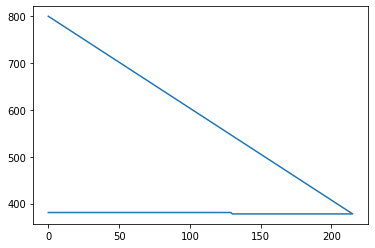

|  216      | -446.0    |  86.68    |  1.022    |  0.8444   |  0.2335   |  1.685e+0 |  3.215    |  0.09479  |  23.56    |  0.09762  |  0.4949   |  1.005    |  0.7684   |  2.47     |  2.837    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.18339
    weight_decay: 0.29728643579521247
)
Batch Normalization Momentum:  0.87
Nodes:  27
LR:  0.18339
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.29728643579521247
BATCH_SIZE:  94
Dropout:  0.05
Final Linear Layers:  3
average loss: 0.693603
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4830)
Class:  0  correct:  241.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3800)
Class:  1  correct:  38.0  of  tensor(100.)
Final percentage:  tensor(0.4315)
Last epoch:  27
Credit Cost:  -568


Best Score So Far:  -378


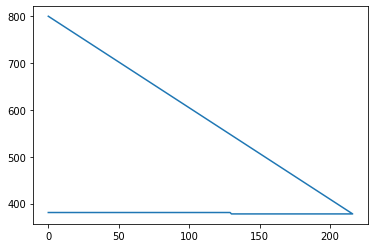

|  217      | -568.0    |  94.43    |  1.628    |  0.875    |  0.05407  |  1.939e+0 |  3.903    |  0.1834   |  27.87    |  0.8415   |  0.2973   |  1.724    |  0.2796   |  3.97     |  3.299    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.40443
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.93
Nodes:  14
LR:  0.40443
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.22779939770529536
BATCH_SIZE:  118
Dropout:  0.25
Final Linear Layers:  2
average loss: 0.695144
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4689)
Class:  0  correct:  234.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3700)
Class:  1  correct:  37.0  of  tensor(100.)
Final percentage:  tensor(0.4195)
Last epoch:  15
Credit Cost:  -580


Best Score So Far:  -378


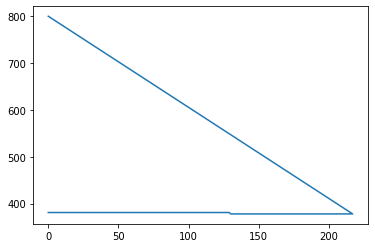

|  218      | -580.0    |  118.2    |  1.852    |  0.9261   |  0.2517   |  1.156e+0 |  2.717    |  0.4044   |  14.17    |  0.005867 |  0.2278   |  2.67     |  0.0622   |  1.315    |  7.309    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.50701
    rho: 0.9
    weight_decay: 0.5107634026598693
)
Batch Normalization Momentum:  0.37
Nodes:  14
LR:  0.50701
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5107634026598693
BATCH_SIZE:  67
Dropout:  0.18
Final Linear Layers:  1
average loss: 0.693198
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4689)
Class:  0  correct:  234.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4545)
Last epoch:  12
Credit Cost:  -545


Best Score So Far:  -378


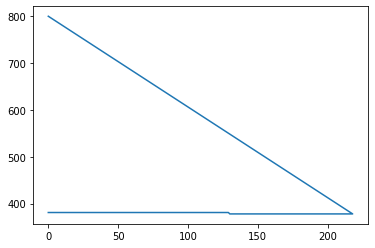

|  219      | -545.0    |  67.76    |  1.991    |  0.3699   |  0.1811   |  1.851e+0 |  1.828    |  0.507    |  14.5     |  0.501    |  0.5108   |  1.515    |  0.9124   |  3.099    |  6.564    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.33514
    momentum: 0.46
    nesterov: False
    weight_decay: 0.614478870085817
)
Batch Normalization Momentum:  0.25
Nodes:  23
LR:  0.33514
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.614478870085817
BATCH_SIZE:  37
Dropout:  0.24
Final Linear Layers:  1
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


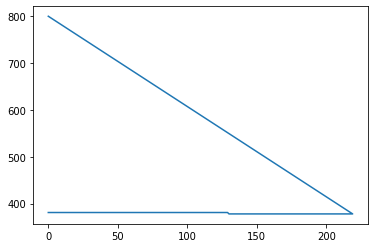

|  220      | -800.0    |  37.85    |  2.385    |  0.2546   |  0.2449   |  1.011e+0 |  1.498    |  0.3351   |  23.37    |  0.4925   |  0.6145   |  2.942    |  0.4596   |  3.296    |  5.448    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.35191
    t0: 1000000.0
    weight_decay: 0.29324271662243967
)
Batch Normalization Momentum:  0.11
Nodes:  13
LR:  0.35191
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.29324271662243967
BATCH_SIZE:  86
Dropout:  0.29
Final Linear Layers:  1
average loss: 0.692464
Class:  0  accuracy:  tensor(0.5150)
Class:  0  correct:  257.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5625)
Last epoch:  7
Credit Cost:  -437


Best Score So Far:  -378


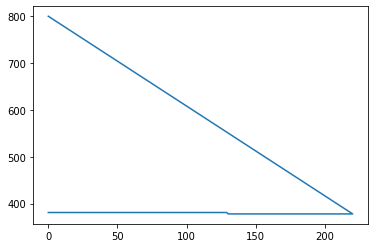

|  221      | -437.0    |  86.47    |  1.448    |  0.1084   |  0.2937   |  1.815e+0 |  1.853    |  0.3519   |  13.4     |  0.177    |  0.2932   |  1.591    |  0.01646  |  2.158    |  9.279    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.13135
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.32
Nodes:  9
LR:  0.13135
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.16724601189414476
BATCH_SIZE:  106
Dropout:  0.07
Final Linear Layers:  2
average loss: 0.692371
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4990)
Class:  0  correct:  249.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5695)
Last epoch:  8
Credit Cost:  -429


Best Score So Far:  -378


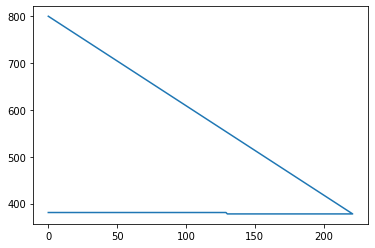

|  222      | -429.0    |  106.7    |  2.142    |  0.3155   |  0.06938  |  1.956e+0 |  2.688    |  0.1313   |  9.484    |  0.9587   |  0.1672   |  1.212    |  0.1821   |  3.291    |  7.372    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.16608
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.51
Nodes:  20
LR:  0.16608
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.13267367362842328
BATCH_SIZE:  58
Dropout:  0.12
Final Linear Layers:  3
average loss: 0.693457
Class:  0  accuracy:  tensor(0.5110)
Class:  0  correct:  255.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3400)
Class:  1  correct:  34.0  of  tensor(100.)
Final percentage:  tensor(0.4255)
Last epoch:  7
Credit Cost:  -574


Best Score So Far:  -378


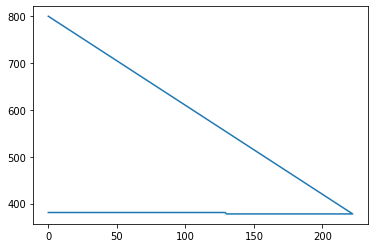

|  223      | -574.0    |  58.3     |  2.58     |  0.5123   |  0.1241   |  1.117e+0 |  3.643    |  0.1661   |  20.49    |  0.9836   |  0.1327   |  2.921    |  0.6462   |  1.385    |  7.94     |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01532
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.68
Nodes:  26
LR:  0.01532
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.516338198090685
BATCH_SIZE:  122
Dropout:  0.01
Final Linear Layers:  1
average loss: 0.695199
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5792)
Class:  0  correct:  289.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3800)
Class:  1  correct:  38.0  of  tensor(100.)
Final percentage:  tensor(0.4796)
Last epoch:  11
Credit Cost:  -520


Best Score So Far:  -378


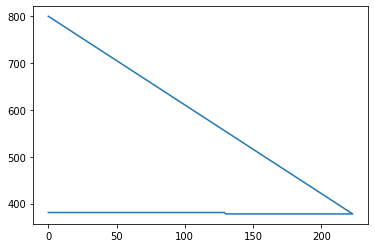

|  224      | -520.0    |  122.0    |  2.12     |  0.6817   |  0.007904 |  1.989e+0 |  1.952    |  0.01532  |  26.26    |  0.9723   |  0.5163   |  1.005    |  0.06273  |  2.747    |  4.018    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.06759
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.98
Nodes:  27
LR:  0.06759
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.2935906754870036
BATCH_SIZE:  113
Dropout:  0.21
Final Linear Layers:  1
average loss: 0.691828
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5731)
Class:  0  correct:  286.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5616)
Last epoch:  12
Credit Cost:  -438


Best Score So Far:  -378


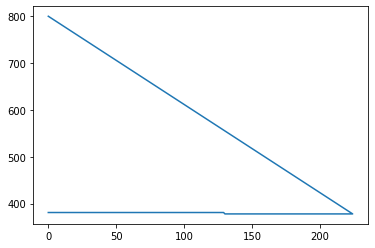

|  225      | -438.0    |  113.3    |  2.739    |  0.9776   |  0.2147   |  1.877e+0 |  1.956    |  0.06759  |  27.96    |  0.3039   |  0.2936   |  2.286    |  0.599    |  2.259    |  4.471    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.59357
    rho: 0.9
    weight_decay: 0.021616898562952968
)
Batch Normalization Momentum:  0.23
Nodes:  25
LR:  0.59357
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.021616898562952968
BATCH_SIZE:  19
Dropout:  0.23
Final Linear Layers:  1
average loss: 0.692178
Class:  0  accuracy:  tensor(0.5130)
Class:  0  correct:  256.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5765)
Last epoch:  7
Credit Cost:  -423


Best Score So Far:  -378


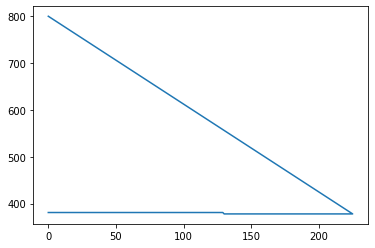

|  226      | -423.0    |  19.21    |  2.062    |  0.2305   |  0.2264   |  1.675e+0 |  1.215    |  0.5936   |  25.41    |  0.2284   |  0.02162  |  1.952    |  0.3492   |  2.634    |  6.93     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.33668
    momentum: 0.37
    nesterov: False
    weight_decay: 0.15845348685208713
)
Batch Normalization Momentum:  0.71
Nodes:  19
LR:  0.33668
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.15845348685208713
BATCH_SIZE:  102
Dropout:  0.09
Final Linear Layers:  3
average loss: 0.691317
Class:  0  accuracy:  tensor(0.5050)
Class:  0  correct:  252.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6200)
Class:  1  correct:  62.0  of  tensor(100.)
Final percentage:  tensor(0.5625)
Last epoch:  7
Credit Cost:  -437


Best Score So Far:  -378


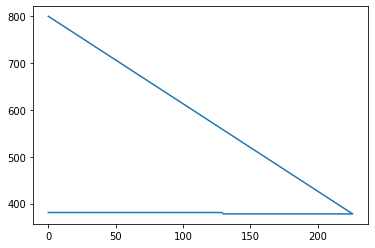

|  227      | -437.0    |  102.9    |  1.027    |  0.7072   |  0.08859  |  1.986e+0 |  3.53     |  0.3367   |  19.93    |  0.1927   |  0.1585   |  1.306    |  0.374    |  1.335    |  5.596    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.36967
    weight_decay: 0.43276547110412783
)
Batch Normalization Momentum:  0.34
Nodes:  26
LR:  0.36967
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.43276547110412783
BATCH_SIZE:  83
Dropout:  0.02
Final Linear Layers:  2
average loss: 11.039579
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5070)
Class:  0  correct:  253.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6200)
Class:  1  correct:  62.0  of  tensor(100.)
Final percentage:  tensor(0.5635)
Last epoch:  22
Credit Cost:  -436


Best Score So Far:  -378


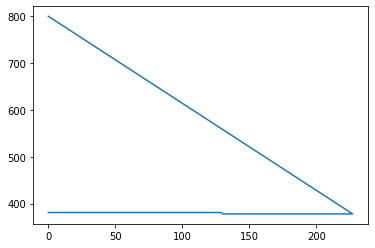

|  228      | -436.0    |  83.17    |  1.243    |  0.3408   |  0.0211   |  1.526e+0 |  2.944    |  0.3697   |  26.42    |  0.2361   |  0.4328   |  1.603    |  0.08788  |  1.913    |  1.641    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.2978
    rho: 0.9
    weight_decay: 0.2570979088996955
)
Batch Normalization Momentum:  0.1
Nodes:  28
LR:  0.2978
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.2570979088996955
BATCH_SIZE:  122
Dropout:  0.24
Final Linear Layers:  3
average loss: 0.693427
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4369)
Class:  0  correct:  218.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4800)
Class:  1  correct:  48.0  of  tensor(100.)
Final percentage:  tensor(0.4584)
Last epoch:  23
Credit Cost:  -541


Best Score So Far:  -378


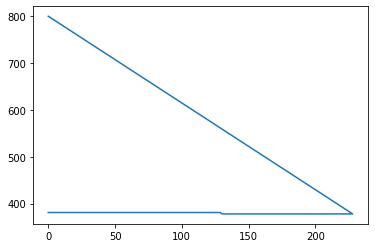

|  229      | -541.0    |  122.9    |  2.447    |  0.1004   |  0.2359   |  1.352e+0 |  3.725    |  0.2978   |  28.18    |  0.2211   |  0.2571   |  1.73     |  0.09616  |  1.99     |  6.931    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.11374
    weight_decay: 0.2637157348510563
)
Batch Normalization Momentum:  0.27
Nodes:  7
LR:  0.11374
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.2637157348510563
BATCH_SIZE:  61
Dropout:  0.11
Final Linear Layers:  2
average loss: 0.685525
Class:  0  accuracy:  tensor(0.5491)
Class:  0  correct:  274.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.5045)
Last epoch:  7
Credit Cost:  -495


Best Score So Far:  -378


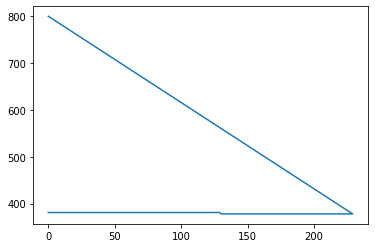

|  230      | -495.0    |  61.85    |  2.75     |  0.267    |  0.1064   |  1.32e+03 |  2.65     |  0.1137   |  7.197    |  0.9386   |  0.2637   |  2.168    |  0.0546   |  1.421    |  1.866    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.37932
    momentum: 0.02
    nesterov: False
    weight_decay: 0.006762849379968947
)
Batch Normalization Momentum:  0.51
Nodes:  30
LR:  0.37932
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.006762849379968947
BATCH_SIZE:  104
Dropout:  0.05
Final Linear Layers:  3
average loss: 0.693943
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4615)
Last epoch:  31
Credit Cost:  -538


Best Score So Far:  -378


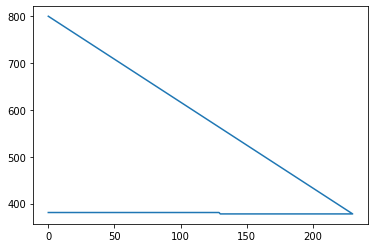

|  231      | -538.0    |  104.7    |  1.205    |  0.5112   |  0.04667  |  1.279e+0 |  3.639    |  0.3793   |  30.91    |  0.5995   |  0.006763 |  1.827    |  0.02222  |  1.939    |  5.33     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.09489
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.55
Nodes:  24
LR:  0.09489
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.4509725652074976
BATCH_SIZE:  75
Dropout:  0.12
Final Linear Layers:  1
average loss: 0.693873
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3400)
Class:  1  correct:  34.0  of  tensor(100.)
Final percentage:  tensor(0.4215)
Last epoch:  7
Credit Cost:  -578


Best Score So Far:  -378


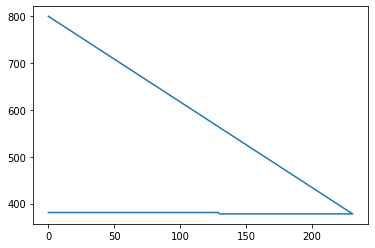

|  232      | -578.0    |  75.36    |  1.475    |  0.5527   |  0.1185   |  1.507e+0 |  1.586    |  0.09489  |  24.64    |  0.3303   |  0.451    |  2.125    |  0.8905   |  3.633    |  4.984    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.37555
    rho: 0.9
    weight_decay: 0.4559906168623078
)
Batch Normalization Momentum:  0.63
Nodes:  20
LR:  0.37555
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4559906168623078
BATCH_SIZE:  29
Dropout:  0.21
Final Linear Layers:  3
average loss: 0.692998
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


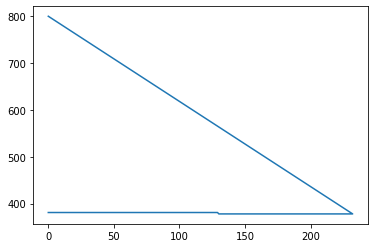

|  233      | -800.0    |  29.39    |  2.258    |  0.6305   |  0.2077   |  1.907e+0 |  3.34     |  0.3755   |  20.03    |  0.2133   |  0.456    |  2.621    |  0.9131   |  3.741    |  6.044    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.30465
    weight_decay: 0.004813621425242897
)
Batch Normalization Momentum:  0.99
Nodes:  12
LR:  0.30465
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.004813621425242897
BATCH_SIZE:  36
Dropout:  0.16
Final Linear Layers:  2
average loss: 1.575683
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5251)
Class:  0  correct:  262.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5825)
Last epoch:  10
Credit Cost:  -417


Best Score So Far:  -378


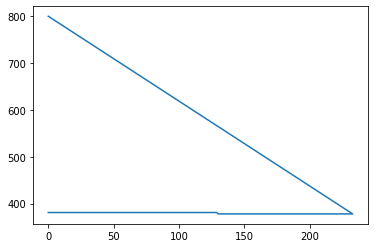

|  234      | -417.0    |  36.22    |  1.664    |  0.9878   |  0.1577   |  1.816e+0 |  2.785    |  0.3047   |  12.46    |  0.5377   |  0.004814 |  2.745    |  0.5559   |  1.073    |  8.355    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.52808
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.46
Nodes:  26
LR:  0.52808
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.32752585166597864
BATCH_SIZE:  20
Dropout:  0.29
Final Linear Layers:  1
average loss: 0.694177
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4269)
Class:  0  correct:  213.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.4984)
Last epoch:  19
Credit Cost:  -501


Best Score So Far:  -378


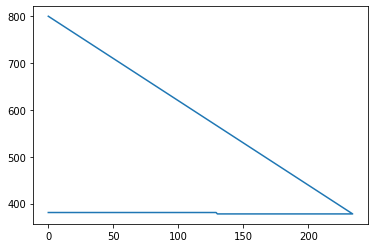

|  235      | -501.0    |  20.78    |  1.061    |  0.4577   |  0.2882   |  1.094e+0 |  1.196    |  0.5281   |  26.64    |  0.8193   |  0.3275   |  1.851    |  0.3971   |  2.741    |  7.553    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.17841
    t0: 1000000.0
    weight_decay: 0.4183740889142843
)
Batch Normalization Momentum:  0.56
Nodes:  22
LR:  0.17841
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4183740889142843
BATCH_SIZE:  101
Dropout:  0.12
Final Linear Layers:  1
average loss: 0.693582
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5451)
Class:  0  correct:  272.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.5025)
Last epoch:  16
Credit Cost:  -497


Best Score So Far:  -378


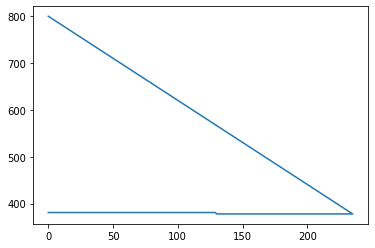

|  236      | -497.0    |  101.3    |  2.303    |  0.5568   |  0.1237   |  1.32e+03 |  1.856    |  0.1784   |  22.48    |  0.7619   |  0.4184   |  1.443    |  0.1925   |  3.289    |  9.798    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.35177
    rho: 0.9
    weight_decay: 0.2834534452187536
)
Batch Normalization Momentum:  0.78
Nodes:  23
LR:  0.35177
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.2834534452187536
BATCH_SIZE:  5
Dropout:  0.22
Final Linear Layers:  2
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


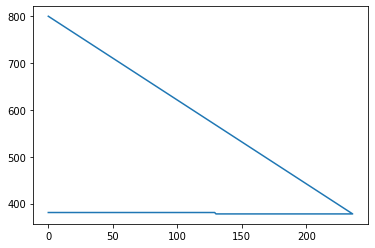

|  237      | -800.0    |  5.973    |  1.495    |  0.7844   |  0.2157   |  1.246e+0 |  2.659    |  0.3518   |  23.64    |  0.4637   |  0.2835   |  1.613    |  0.2359   |  1.277    |  6.806    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.58786
    t0: 1000000.0
    weight_decay: 0.5697066106769774
)
Batch Normalization Momentum:  0.0
Nodes:  16
LR:  0.58786
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5697066106769774
BATCH_SIZE:  87
Dropout:  0.13
Final Linear Layers:  2
average loss: 0.693164
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4729)
Class:  0  correct:  236.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.4915)
Last epoch:  8
Credit Cost:  -507


Best Score So Far:  -378


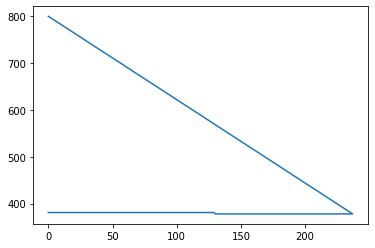

|  238      | -507.0    |  87.03    |  2.368    |  0.003114 |  0.1315   |  1.123e+0 |  2.575    |  0.5879   |  16.98    |  0.3749   |  0.5697   |  2.927    |  0.2843   |  3.401    |  9.955    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.05991
    momentum: 0.76
    nesterov: False
    weight_decay: 0.16708605860021436
)
Batch Normalization Momentum:  0.81
Nodes:  12
LR:  0.05991
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.16708605860021436
BATCH_SIZE:  17
Dropout:  0.11
Final Linear Layers:  3
average loss: 0.693125
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


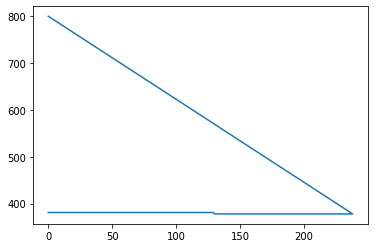

|  239      | -800.0    |  17.87    |  2.057    |  0.8054   |  0.1129   |  1.446e+0 |  3.245    |  0.05991  |  12.82    |  0.5636   |  0.1671   |  2.672    |  0.7582   |  3.887    |  5.702    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.46587
    momentum: 0.2
    nesterov: False
    weight_decay: 0.5910890387820867
)
Batch Normalization Momentum:  0.83
Nodes:  19
LR:  0.46587
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5910890387820867
BATCH_SIZE:  17
Dropout:  0.16
Final Linear Layers:  3
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


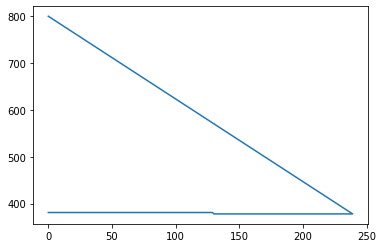

|  240      | -800.0    |  17.21    |  2.864    |  0.8259   |  0.1633   |  1.836e+0 |  3.636    |  0.4659   |  19.14    |  0.6151   |  0.5911   |  2.238    |  0.2044   |  3.068    |  5.783    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.06576
    weight_decay: 0.19945487714560287
)
Batch Normalization Momentum:  0.23
Nodes:  4
LR:  0.06576
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.19945487714560287
BATCH_SIZE:  36
Dropout:  0.2
Final Linear Layers:  3
average loss: 0.693200
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5371)
Class:  0  correct:  268.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.4935)
Last epoch:  8
Credit Cost:  -506


Best Score So Far:  -378


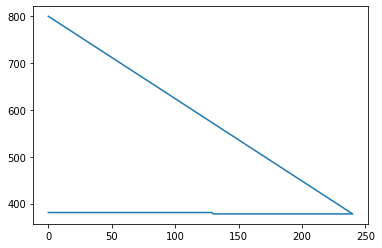

|  241      | -506.0    |  36.64    |  1.002    |  0.2331   |  0.2021   |  1.878e+0 |  3.484    |  0.06576  |  4.134    |  0.7611   |  0.1995   |  1.541    |  0.00198  |  1.295    |  2.219    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.42552
    weight_decay: 0.05639396063528602
)
Batch Normalization Momentum:  0.81
Nodes:  16
LR:  0.42552
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.05639396063528602
BATCH_SIZE:  23
Dropout:  0.24
Final Linear Layers:  2
average loss: 0.693582
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5451)
Class:  0  correct:  272.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3300)
Class:  1  correct:  33.0  of  tensor(100.)
Final percentage:  tensor(0.4375)
Last epoch:  17
Credit Cost:  -562


Best Score So Far:  -378


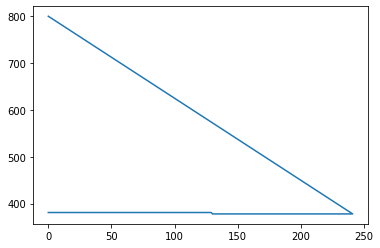

|  242      | -562.0    |  23.76    |  1.886    |  0.806    |  0.2437   |  1.91e+03 |  2.326    |  0.4255   |  16.65    |  0.05074  |  0.05639  |  1.489    |  0.9718   |  3.069    |  3.409    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.53075
    weight_decay: 0.0822525851102535
)
Batch Normalization Momentum:  0.04
Nodes:  29
LR:  0.53075
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.0822525851102535
BATCH_SIZE:  91
Dropout:  0.11
Final Linear Layers:  1
average loss: 7.767806
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5010)
Class:  0  correct:  250.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5105)
Last epoch:  24
Credit Cost:  -489


Best Score So Far:  -378


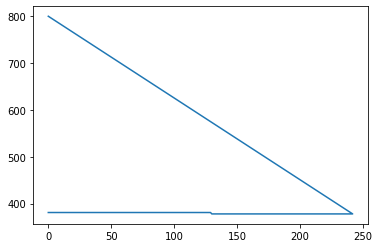

|  243      | -489.0    |  91.58    |  2.316    |  0.04286  |  0.1084   |  1.774e+0 |  1.235    |  0.5307   |  29.93    |  0.8524   |  0.08225  |  2.125    |  0.7005   |  3.655    |  1.861    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.36482
    t0: 1000000.0
    weight_decay: 0.5701724749988513
)
Batch Normalization Momentum:  0.59
Nodes:  10
LR:  0.36482
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5701724749988513
BATCH_SIZE:  105
Dropout:  0.22
Final Linear Layers:  1
average loss: 0.692762
Class:  0  accuracy:  tensor(0.9299)
Class:  0  correct:  464.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.0900)
Class:  1  correct:  9.0  of  tensor(100.)
Final percentage:  tensor(0.5099)
Last epoch:  7
Credit Cost:  -489


Best Score So Far:  -378


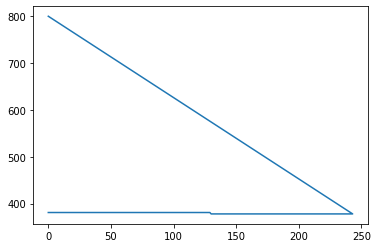

|  244      | -489.0    |  105.2    |  1.553    |  0.5864   |  0.2159   |  1.777e+0 |  1.881    |  0.3648   |  10.62    |  0.9973   |  0.5702   |  1.824    |  0.8704   |  3.19     |  9.349    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.28344
    t0: 1000000.0
    weight_decay: 0.1212223977556109
)
Batch Normalization Momentum:  0.09
Nodes:  23
LR:  0.28344
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.1212223977556109
BATCH_SIZE:  25
Dropout:  0.1
Final Linear Layers:  2
average loss: 0.692764
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5900)
Class:  1  correct:  59.0  of  tensor(100.)
Final percentage:  tensor(0.5465)
Last epoch:  7
Credit Cost:  -453


Best Score So Far:  -378


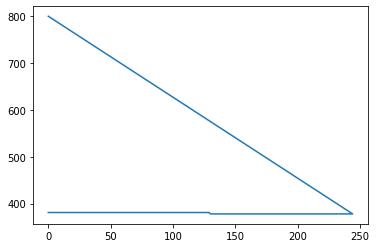

|  245      | -453.0    |  25.28    |  1.587    |  0.0928   |  0.09539  |  1.381e+0 |  2.892    |  0.2834   |  23.53    |  0.2697   |  0.1212   |  1.754    |  0.4337   |  2.262    |  9.213    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.16774
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.21
Nodes:  9
LR:  0.16774
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6371340774300238
BATCH_SIZE:  37
Dropout:  0.11
Final Linear Layers:  2
average loss: 0.692339
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4870)
Class:  0  correct:  243.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5635)
Last epoch:  13
Credit Cost:  -436


Best Score So Far:  -378


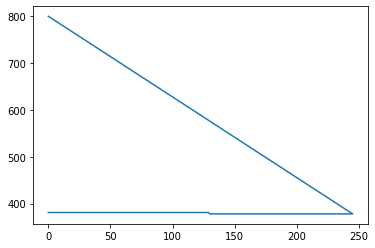

|  246      | -436.0    |  37.43    |  1.701    |  0.2131   |  0.1116   |  1.39e+03 |  2.721    |  0.1677   |  9.785    |  0.7186   |  0.6371   |  1.243    |  0.1805   |  1.398    |  7.146    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.09009
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.2
Nodes:  11
LR:  0.09009
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.4445924447882797
BATCH_SIZE:  30
Dropout:  0.25
Final Linear Layers:  3
average loss: 0.692123
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5090)
Class:  0  correct:  254.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4745)
Last epoch:  16
Credit Cost:  -525


Best Score So Far:  -378


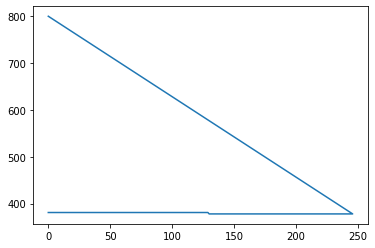

|  247      | -525.0    |  30.54    |  2.203    |  0.1997   |  0.2453   |  1.316e+0 |  3.002    |  0.09009  |  11.18    |  0.2976   |  0.4446   |  2.355    |  0.8368   |  1.548    |  7.836    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.42711
    t0: 1000000.0
    weight_decay: 0.3486123731258095
)
Batch Normalization Momentum:  0.64
Nodes:  7
LR:  0.42711
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.3486123731258095
BATCH_SIZE:  92
Dropout:  0.03
Final Linear Layers:  2
average loss: 0.692963
Class:  0  accuracy:  tensor(0.5832)
Class:  0  correct:  291.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4800)
Class:  1  correct:  48.0  of  tensor(100.)
Final percentage:  tensor(0.5316)
Last epoch:  7
Credit Cost:  -468


Best Score So Far:  -378


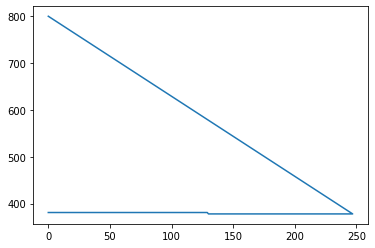

|  248      | -468.0    |  92.28    |  2.11     |  0.6437   |  0.027    |  1.147e+0 |  2.243    |  0.4271   |  7.035    |  0.3892   |  0.3486   |  2.861    |  0.05464  |  3.479    |  9.848    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.14276
    weight_decay: 0.39182458065134085
)
Batch Normalization Momentum:  0.29
Nodes:  22
LR:  0.14276
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.39182458065134085
BATCH_SIZE:  37
Dropout:  0.24
Final Linear Layers:  2
average loss: 0.858113
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5150)
Class:  0  correct:  257.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5325)
Last epoch:  9
Credit Cost:  -467


Best Score So Far:  -378


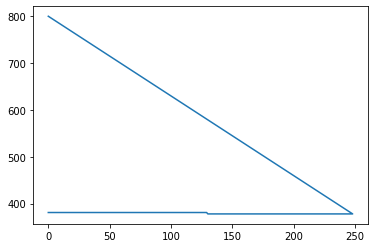

|  249      | -467.0    |  37.14    |  2.771    |  0.2874   |  0.2397   |  1.46e+03 |  2.787    |  0.1428   |  22.63    |  0.1494   |  0.3918   |  1.984    |  0.8288   |  2.44     |  8.055    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.49198
    momentum: 0.87
    nesterov: False
    weight_decay: 0.11249472127361901
)
Batch Normalization Momentum:  0.78
Nodes:  19
LR:  0.49198
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.11249472127361901
BATCH_SIZE:  53
Dropout:  0.13
Final Linear Layers:  2
average loss: 0.692903
Class:  0  accuracy:  tensor(0.5491)
Class:  0  correct:  274.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4800)
Class:  1  correct:  48.0  of  tensor(100.)
Final percentage:  tensor(0.5145)
Last epoch:  7
Credit Cost:  -485


Best Score So Far:  -378


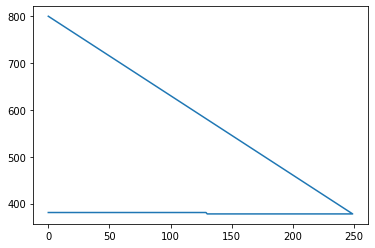

|  250      | -485.0    |  53.64    |  1.613    |  0.7794   |  0.1255   |  1.497e+0 |  2.726    |  0.492    |  19.44    |  0.4063   |  0.1125   |  2.397    |  0.8744   |  1.324    |  5.191    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.08881
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.54
Nodes:  30
LR:  0.08881
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.4717808028912036
BATCH_SIZE:  119
Dropout:  0.02
Final Linear Layers:  2
average loss: 0.694274
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4770)
Class:  0  correct:  238.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4535)
Last epoch:  10
Credit Cost:  -546


Best Score So Far:  -378


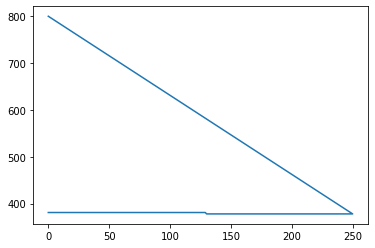

|  251      | -546.0    |  119.9    |  2.121    |  0.5398   |  0.01904  |  1.535e+0 |  2.957    |  0.08881  |  30.69    |  0.1968   |  0.4718   |  1.546    |  0.1073   |  1.78     |  4.004    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.16252
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.72
Nodes:  8
LR:  0.16252
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.27773710287178677
BATCH_SIZE:  61
Dropout:  0.24
Final Linear Layers:  3
average loss: 0.691340
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4489)
Class:  0  correct:  224.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6500)
Class:  1  correct:  65.0  of  tensor(100.)
Final percentage:  tensor(0.5494)
Last epoch:  8
Credit Cost:  -450


Best Score So Far:  -378


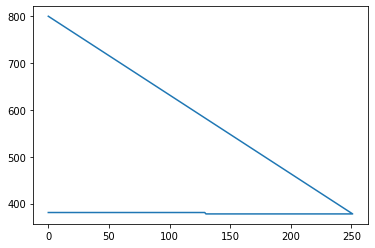

|  252      | -450.0    |  61.63    |  1.466    |  0.7202   |  0.2422   |  1.791e+0 |  3.14     |  0.1625   |  8.314    |  0.1099   |  0.2777   |  1.174    |  0.6488   |  3.84     |  7.793    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.4302
    weight_decay: 0.14586515925165863
)
Batch Normalization Momentum:  0.33
Nodes:  19
LR:  0.4302
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.14586515925165863
BATCH_SIZE:  18
Dropout:  0.3
Final Linear Layers:  3
average loss: 0.693074
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


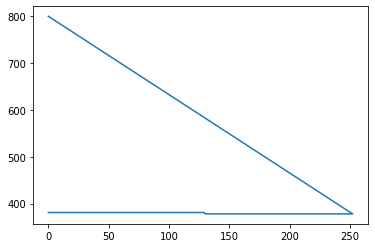

|  253      | -800.0    |  18.49    |  1.041    |  0.3315   |  0.2979   |  1.313e+0 |  3.205    |  0.4302   |  19.18    |  0.3679   |  0.1459   |  2.95     |  0.06523  |  1.706    |  3.777    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.02399
    weight_decay: 0.3203302841707618
)
Batch Normalization Momentum:  0.26
Nodes:  28
LR:  0.02399
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.3203302841707618
BATCH_SIZE:  116
Dropout:  0.05
Final Linear Layers:  3
average loss: 0.693353
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4910)
Class:  0  correct:  245.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5305)
Last epoch:  9
Credit Cost:  -469


Best Score So Far:  -378


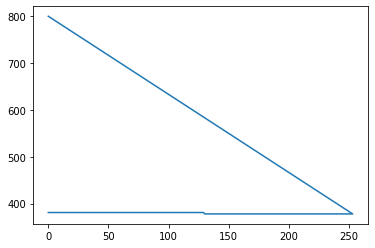

|  254      | -469.0    |  116.8    |  2.42     |  0.2627   |  0.04935  |  1.88e+03 |  3.373    |  0.02399  |  28.38    |  0.5878   |  0.3203   |  2.341    |  0.03905  |  1.988    |  1.792    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.16939
    weight_decay: 0.42115937520477675
)
Batch Normalization Momentum:  0.47
Nodes:  19
LR:  0.16939
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.42115937520477675
BATCH_SIZE:  88
Dropout:  0.09
Final Linear Layers:  1
average loss: 0.694614
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5371)
Class:  0  correct:  268.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5435)
Last epoch:  14
Credit Cost:  -456


Best Score So Far:  -378


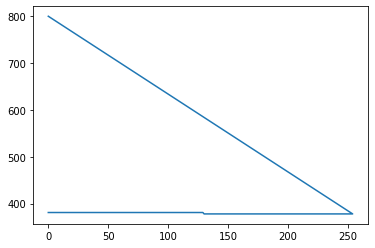

|  255      | -456.0    |  88.77    |  1.792    |  0.4742   |  0.08694  |  1.788e+0 |  1.139    |  0.1694   |  19.72    |  0.7896   |  0.4212   |  2.454    |  0.02329  |  1.762    |  1.378    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.11083
    weight_decay: 0.580020101095729
)
Batch Normalization Momentum:  0.01
Nodes:  23
LR:  0.11083
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.580020101095729
BATCH_SIZE:  66
Dropout:  0.13
Final Linear Layers:  2
average loss: 0.693083
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5311)
Class:  0  correct:  265.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5205)
Last epoch:  10
Credit Cost:  -479


Best Score So Far:  -378


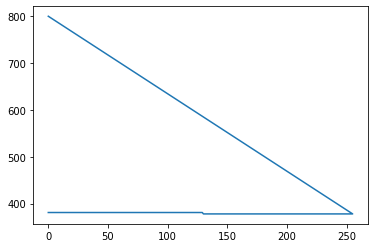

|  256      | -479.0    |  66.0     |  2.968    |  0.0134   |  0.1323   |  1.005e+0 |  2.833    |  0.1108   |  23.38    |  0.1603   |  0.58     |  1.41     |  0.3487   |  1.689    |  8.261    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.40435
    momentum: 0.82
    nesterov: False
    weight_decay: 0.052337187064490476
)
Batch Normalization Momentum:  0.13
Nodes:  7
LR:  0.40435
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.052337187064490476
BATCH_SIZE:  64
Dropout:  0.15
Final Linear Layers:  3
average loss: 0.693825
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4770)
Class:  0  correct:  238.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3400)
Class:  1  correct:  34.0  of  tensor(100.)
Final percentage:  tensor(0.4085)
Last epoch:  9
Credit Cost:  -591


Best Score So Far:  -378


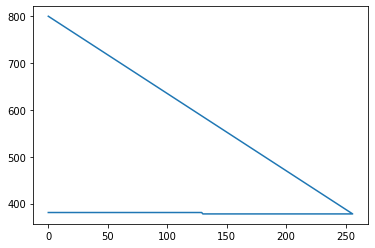

|  257      | -591.0    |  64.79    |  2.739    |  0.1288   |  0.1497   |  1.777e+0 |  3.934    |  0.4044   |  7.49     |  0.7593   |  0.05234  |  2.518    |  0.8195   |  2.672    |  5.43     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.2234
    rho: 0.9
    weight_decay: 0.5602172978878472
)
Batch Normalization Momentum:  0.01
Nodes:  10
LR:  0.2234
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5602172978878472
BATCH_SIZE:  120
Dropout:  0.08
Final Linear Layers:  2
average loss: 0.693845
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4549)
Class:  0  correct:  227.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.4725)
Last epoch:  34
Credit Cost:  -527


Best Score So Far:  -378


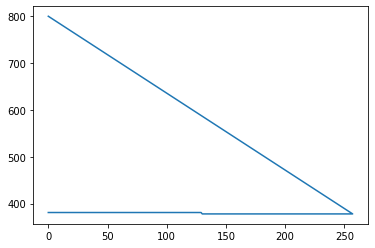

|  258      | -527.0    |  120.1    |  1.0      |  0.009471 |  0.07559  |  1.506e+0 |  2.616    |  0.2234   |  10.78    |  0.203    |  0.5602   |  1.629    |  0.4875   |  3.426    |  6.505    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.10022
    weight_decay: 0.053325778633275624
)
Batch Normalization Momentum:  0.39
Nodes:  8
LR:  0.10022
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.053325778633275624
BATCH_SIZE:  54
Dropout:  0.15
Final Linear Layers:  1
average loss: 0.694115
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5511)
Class:  0  correct:  275.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4906)
Last epoch:  9
Credit Cost:  -509


Best Score So Far:  -378


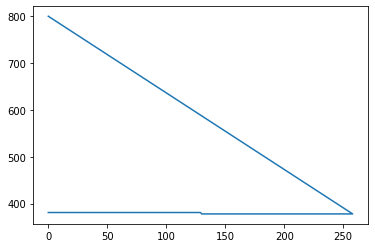

|  259      | -509.0    |  54.67    |  1.352    |  0.3937   |  0.1456   |  1.991e+0 |  1.85     |  0.1002   |  8.617    |  0.212    |  0.05333  |  1.726    |  0.2819   |  3.654    |  8.015    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.54329
    weight_decay: 0.2587601918466088
)
Batch Normalization Momentum:  0.11
Nodes:  28
LR:  0.54329
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.2587601918466088
BATCH_SIZE:  17
Dropout:  0.22
Final Linear Layers:  1
average loss: 78.647720
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4689)
Class:  0  correct:  234.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6600)
Class:  1  correct:  66.0  of  tensor(100.)
Final percentage:  tensor(0.5645)
Last epoch:  9
Credit Cost:  -435


Best Score So Far:  -378


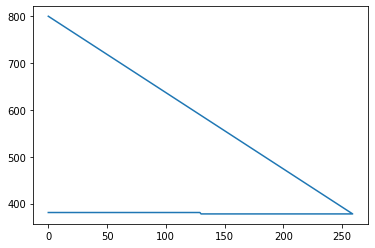

|  260      | -435.0    |  17.52    |  2.693    |  0.1085   |  0.2161   |  1.573e+0 |  1.26     |  0.5433   |  28.24    |  0.8432   |  0.2588   |  1.444    |  0.9871   |  3.444    |  1.379    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.00124
    rho: 0.9
    weight_decay: 0.4593749639560401
)
Batch Normalization Momentum:  0.52
Nodes:  8
LR:  0.00124
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4593749639560401
BATCH_SIZE:  50
Dropout:  0.07
Final Linear Layers:  1
average loss: 0.692352
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4930)
Class:  0  correct:  246.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4565)
Last epoch:  9
Credit Cost:  -543


Best Score So Far:  -378


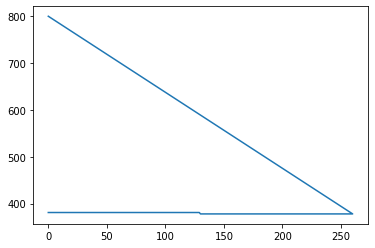

|  261      | -543.0    |  50.29    |  2.616    |  0.5231   |  0.07414  |  1.793e+0 |  1.783    |  0.001239 |  8.94     |  0.9924   |  0.4594   |  1.439    |  0.6793   |  3.054    |  6.76     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.33807
    weight_decay: 0.07125553902807685
)
Batch Normalization Momentum:  0.86
Nodes:  26
LR:  0.33807
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.07125553902807685
BATCH_SIZE:  12
Dropout:  0.22
Final Linear Layers:  1
average loss: 1.079775
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5511)
Class:  0  correct:  275.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5956)
Last epoch:  9
Credit Cost:  -404


Best Score So Far:  -378


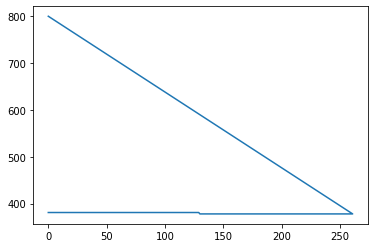

|  262      | -404.0    |  12.75    |  1.483    |  0.8621   |  0.2204   |  1.168e+0 |  1.893    |  0.3381   |  26.79    |  0.2011   |  0.07126  |  1.76     |  0.9032   |  1.779    |  1.974    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.44493
    momentum: 0.5
    nesterov: False
    weight_decay: 0.16152557005548493
)
Batch Normalization Momentum:  0.04
Nodes:  17
LR:  0.44493
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.16152557005548493
BATCH_SIZE:  10
Dropout:  0.17
Final Linear Layers:  2
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


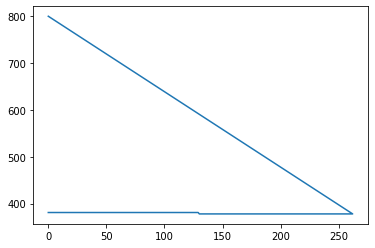

|  263      | -800.0    |  10.94    |  1.7      |  0.03725  |  0.1749   |  1.673e+0 |  2.377    |  0.4449   |  17.03    |  0.7019   |  0.1615   |  2.482    |  0.4966   |  3.109    |  5.016    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.34615
    weight_decay: 0.519013150844268
)
Batch Normalization Momentum:  0.48
Nodes:  12
LR:  0.34615
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.519013150844268
BATCH_SIZE:  66
Dropout:  0.04
Final Linear Layers:  2
average loss: 0.692915
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5050)
Class:  0  correct:  252.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5400)
Class:  1  correct:  54.0  of  tensor(100.)
Final percentage:  tensor(0.5225)
Last epoch:  13
Credit Cost:  -477


Best Score So Far:  -378


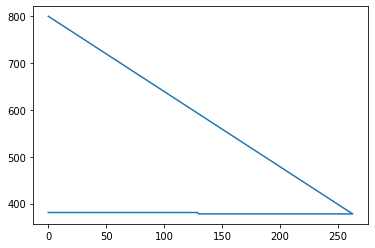

|  264      | -477.0    |  66.74    |  1.083    |  0.4844   |  0.04269  |  1.142e+0 |  2.296    |  0.3462   |  12.29    |  0.1612   |  0.519    |  2.917    |  0.7263   |  1.23     |  8.56     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.55724
    weight_decay: 0.12782158494055798
)
Batch Normalization Momentum:  0.92
Nodes:  11
LR:  0.55724
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.12782158494055798
BATCH_SIZE:  12
Dropout:  0.08
Final Linear Layers:  3
average loss: 0.693145
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


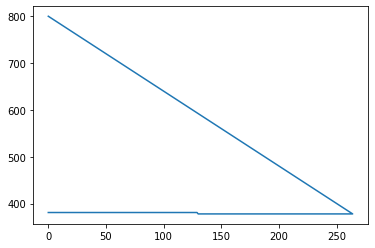

|  265      | -800.0    |  12.37    |  1.868    |  0.9196   |  0.07895  |  1.128e+0 |  3.279    |  0.5572   |  11.77    |  0.233    |  0.1278   |  2.917    |  0.5709   |  3.572    |  3.772    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.18516
    weight_decay: 0.22665022061976883
)
Batch Normalization Momentum:  0.21
Nodes:  2
LR:  0.18516
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.22665022061976883
BATCH_SIZE:  10
Dropout:  0.16
Final Linear Layers:  1
average loss: 0.693065
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


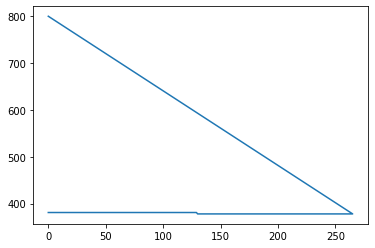

|  266      | -800.0    |  11.0     |  1.903    |  0.205    |  0.1557   |  1.538e+0 |  1.88     |  0.1852   |  2.725    |  0.4206   |  0.2267   |  2.233    |  0.8512   |  2.473    |  1.744    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.38185
    weight_decay: 0.2203102216063299
)
Batch Normalization Momentum:  0.36
Nodes:  31
LR:  0.38185
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.2203102216063299
BATCH_SIZE:  119
Dropout:  0.1
Final Linear Layers:  2
average loss: 4.074817
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4810)
Class:  0  correct:  240.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5405)
Last epoch:  12
Credit Cost:  -459


Best Score So Far:  -378


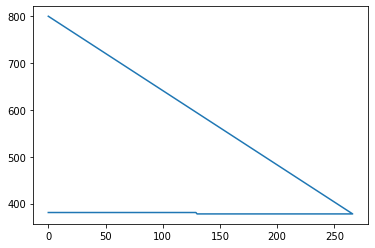

|  267      | -459.0    |  119.8    |  2.609    |  0.3619   |  0.09922  |  1.938e+0 |  2.121    |  0.3818   |  31.56    |  0.03767  |  0.2203   |  1.46     |  0.9131   |  2.648    |  1.483    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.13438
    weight_decay: 0.14393635177944708
)
Batch Normalization Momentum:  0.66
Nodes:  6
LR:  0.13438
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.14393635177944708
BATCH_SIZE:  97
Dropout:  0.29
Final Linear Layers:  3
average loss: 0.694123
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4489)
Class:  0  correct:  224.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4394)
Last epoch:  10
Credit Cost:  -560


Best Score So Far:  -378


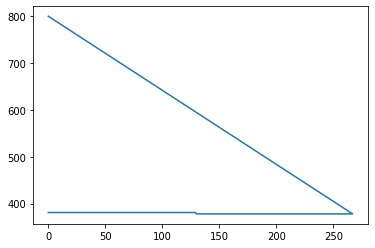

|  268      | -560.0    |  97.65    |  2.361    |  0.6556   |  0.2867   |  1.875e+0 |  3.252    |  0.1344   |  6.14     |  0.2214   |  0.1439   |  2.13     |  0.6564   |  2.577    |  1.507    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.04741
    weight_decay: 0.3372081617683491
)
Batch Normalization Momentum:  0.69
Nodes:  17
LR:  0.04741
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.3372081617683491
BATCH_SIZE:  49
Dropout:  0.11
Final Linear Layers:  1
average loss: 0.694091
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5391)
Class:  0  correct:  269.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.4945)
Last epoch:  8
Credit Cost:  -505


Best Score So Far:  -378


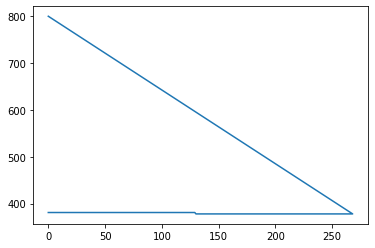

|  269      | -505.0    |  49.03    |  2.926    |  0.6886   |  0.1109   |  1.672e+0 |  1.793    |  0.04741  |  17.84    |  0.2902   |  0.3372   |  2.795    |  0.6452   |  3.163    |  1.922    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.06977
    weight_decay: 0.4876882748881172
)
Batch Normalization Momentum:  0.64
Nodes:  7
LR:  0.06977
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.4876882748881172
BATCH_SIZE:  63
Dropout:  0.09
Final Linear Layers:  3
average loss: 0.693248
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4850)
Class:  0  correct:  242.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6900)
Class:  1  correct:  69.0  of  tensor(100.)
Final percentage:  tensor(0.5875)
Last epoch:  8
Credit Cost:  -411


Best Score So Far:  -378


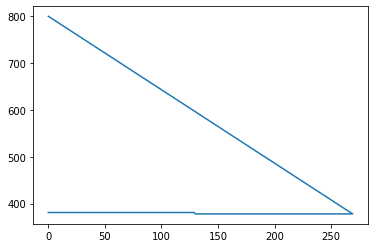

|  270      | -411.0    |  63.48    |  1.805    |  0.6404   |  0.08632  |  1.383e+0 |  3.933    |  0.06977  |  7.997    |  0.2396   |  0.4877   |  2.42     |  0.7769   |  2.139    |  8.663    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.35768
    weight_decay: 0.22606514272673253
)
Batch Normalization Momentum:  0.81
Nodes:  18
LR:  0.35768
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.22606514272673253
BATCH_SIZE:  90
Dropout:  0.19
Final Linear Layers:  1
average loss: 0.987786
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5531)
Class:  0  correct:  276.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.5566)
Last epoch:  12
Credit Cost:  -443


Best Score So Far:  -378


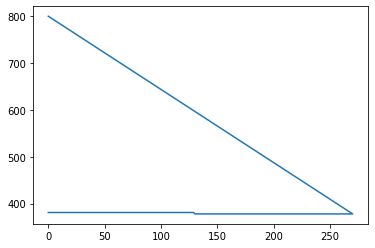

|  271      | -443.0    |  90.47    |  2.419    |  0.8138   |  0.1887   |  1.422e+0 |  1.092    |  0.3577   |  18.91    |  0.6006   |  0.2261   |  2.104    |  0.1699   |  2.943    |  1.644    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.19683
    weight_decay: 0.46069227839192983
)
Batch Normalization Momentum:  0.29
Nodes:  29
LR:  0.19683
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.46069227839192983
BATCH_SIZE:  112
Dropout:  0.27
Final Linear Layers:  3
average loss: 0.693730
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3800)
Class:  1  correct:  38.0  of  tensor(100.)
Final percentage:  tensor(0.4415)
Last epoch:  16
Credit Cost:  -558


Best Score So Far:  -378


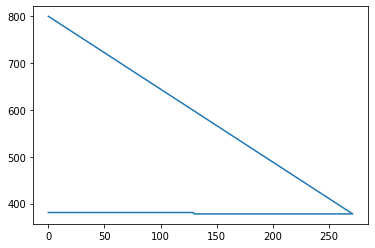

|  272      | -558.0    |  112.5    |  1.43     |  0.2909   |  0.2654   |  1.884e+0 |  3.5      |  0.1968   |  29.07    |  0.7713   |  0.4607   |  2.791    |  0.7753   |  2.27     |  3.915    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.57787
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.36
Nodes:  11
LR:  0.57787
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.44318308090021025
BATCH_SIZE:  52
Dropout:  0.11
Final Linear Layers:  3
average loss: 0.694278
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5110)
Class:  0  correct:  255.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4705)
Last epoch:  17
Credit Cost:  -529


Best Score So Far:  -378


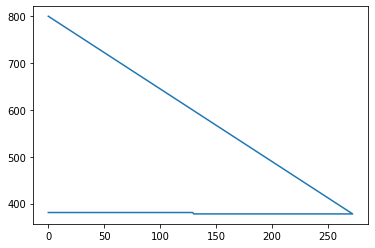

|  273      | -529.0    |  52.84    |  1.122    |  0.3598   |  0.1059   |  1.866e+0 |  3.657    |  0.5779   |  11.85    |  0.6929   |  0.4432   |  1.482    |  0.8613   |  1.64     |  7.722    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.21589
    t0: 1000000.0
    weight_decay: 0.6853899329527855
)
Batch Normalization Momentum:  0.71
Nodes:  27
LR:  0.21589
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.6853899329527855
BATCH_SIZE:  21
Dropout:  0.16
Final Linear Layers:  3
average loss: 0.693145
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


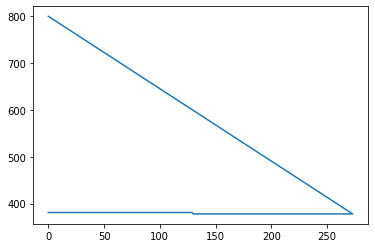

|  274      | -800.0    |  21.94    |  1.213    |  0.7131   |  0.1579   |  1.443e+0 |  3.327    |  0.2159   |  27.6     |  0.9612   |  0.6854   |  1.552    |  0.4109   |  3.168    |  9.045    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.3889
    t0: 1000000.0
    weight_decay: 0.6789599825474311
)
Batch Normalization Momentum:  0.87
Nodes:  28
LR:  0.3889
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6789599825474311
BATCH_SIZE:  92
Dropout:  0.11
Final Linear Layers:  2
average loss: 0.693093
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


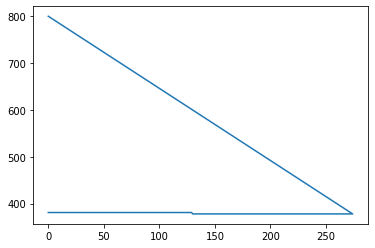

|  275      | -800.0    |  92.2     |  2.509    |  0.8746   |  0.1101   |  1.543e+0 |  2.599    |  0.3889   |  28.86    |  0.6006   |  0.679    |  2.457    |  0.4111   |  2.738    |  9.292    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.09131
    t0: 1000000.0
    weight_decay: 0.2807992269684201
)
Batch Normalization Momentum:  0.65
Nodes:  26
LR:  0.09131
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.2807992269684201
BATCH_SIZE:  80
Dropout:  0.1
Final Linear Layers:  2
average loss: 0.693017
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5431)
Class:  0  correct:  271.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.4965)
Last epoch:  8
Credit Cost:  -503


Best Score So Far:  -378


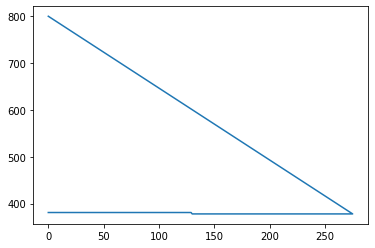

|  276      | -503.0    |  80.69    |  2.413    |  0.6547   |  0.1008   |  1.203e+0 |  2.219    |  0.09131  |  26.79    |  0.71     |  0.2808   |  1.341    |  0.867    |  2.911    |  9.959    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.2954
    weight_decay: 0.4298761396485657
)
Batch Normalization Momentum:  0.08
Nodes:  17
LR:  0.2954
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.4298761396485657
BATCH_SIZE:  16
Dropout:  0.22
Final Linear Layers:  3
average loss: 0.693221
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5190)
Class:  0  correct:  259.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5145)
Last epoch:  10
Credit Cost:  -485


Best Score So Far:  -378


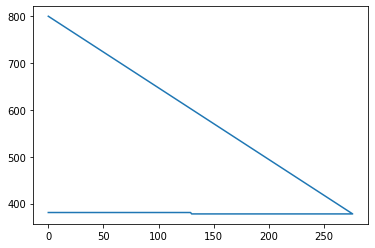

|  277      | -485.0    |  16.54    |  1.487    |  0.08282  |  0.2234   |  1.16e+03 |  3.636    |  0.2954   |  17.79    |  0.04344  |  0.4299   |  1.453    |  0.2114   |  3.677    |  8.983    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.41158
    weight_decay: 0.4018841962681342
)
Batch Normalization Momentum:  0.89
Nodes:  15
LR:  0.41158
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4018841962681342
BATCH_SIZE:  4
Dropout:  0.15
Final Linear Layers:  3
average loss: 0.693143
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


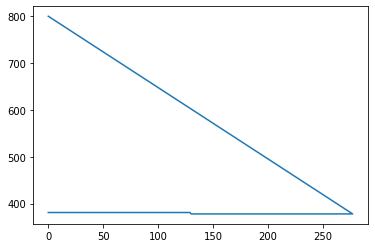

|  278      | -800.0    |  4.653    |  2.656    |  0.8933   |  0.1536   |  1.656e+0 |  3.296    |  0.4116   |  15.77    |  0.5733   |  0.4019   |  2.676    |  0.238    |  3.264    |  8.303    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.46209
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.82
Nodes:  30
LR:  0.46209
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.3953577408771376
BATCH_SIZE:  102
Dropout:  0.13
Final Linear Layers:  3
average loss: 0.695281
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4970)
Class:  0  correct:  248.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3700)
Class:  1  correct:  37.0  of  tensor(100.)
Final percentage:  tensor(0.4335)
Last epoch:  12
Credit Cost:  -566


Best Score So Far:  -378


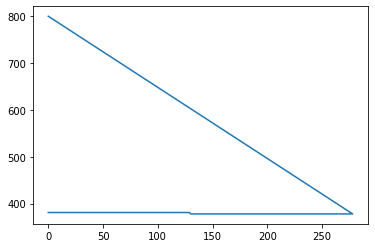

|  279      | -566.0    |  102.8    |  2.607    |  0.821    |  0.1253   |  1.618e+0 |  3.258    |  0.4621   |  30.76    |  0.9741   |  0.3954   |  1.927    |  0.8272   |  1.658    |  7.89     |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.29615
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.6
Nodes:  14
LR:  0.29615
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.2535684070028333
BATCH_SIZE:  27
Dropout:  0.13
Final Linear Layers:  2
average loss: 0.693400
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5331)
Class:  0  correct:  266.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4000)
Class:  1  correct:  40.0  of  tensor(100.)
Final percentage:  tensor(0.4665)
Last epoch:  13
Credit Cost:  -533


Best Score So Far:  -378


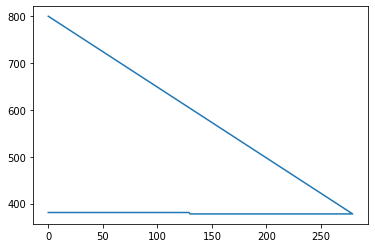

|  280      | -533.0    |  27.81    |  2.177    |  0.6008   |  0.1326   |  1.865e+0 |  2.625    |  0.2961   |  14.54    |  0.0631   |  0.2536   |  1.185    |  0.56     |  2.915    |  7.902    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.17995
    weight_decay: 0.6765513907560856
)
Batch Normalization Momentum:  0.74
Nodes:  22
LR:  0.17995
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.6765513907560856
BATCH_SIZE:  82
Dropout:  0.16
Final Linear Layers:  1
average loss: 0.692808
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4785)
Last epoch:  7
Credit Cost:  -521


Best Score So Far:  -378


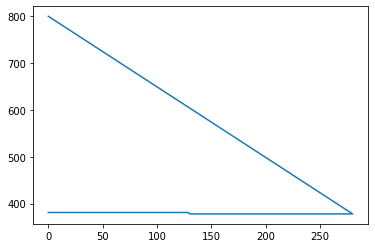

|  281      | -521.0    |  82.43    |  1.372    |  0.7427   |  0.1647   |  1.102e+0 |  1.074    |  0.1799   |  22.7     |  0.9319   |  0.6766   |  2.521    |  0.2903   |  2.86     |  3.078    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.26989
    t0: 1000000.0
    weight_decay: 0.02708748697783019
)
Batch Normalization Momentum:  0.75
Nodes:  27
LR:  0.26989
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.02708748697783019
BATCH_SIZE:  97
Dropout:  0.26
Final Linear Layers:  1
average loss: 0.692973
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4770)
Class:  0  correct:  238.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3700)
Class:  1  correct:  37.0  of  tensor(100.)
Final percentage:  tensor(0.4235)
Last epoch:  11
Credit Cost:  -576


Best Score So Far:  -378


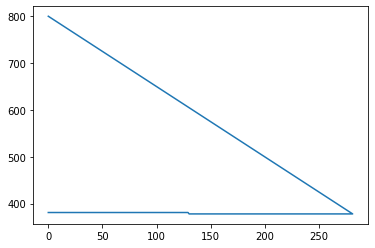

|  282      | -576.0    |  97.09    |  1.33     |  0.7489   |  0.2606   |  1.52e+03 |  1.196    |  0.2699   |  27.13    |  0.1804   |  0.02709  |  2.458    |  0.5574   |  1.126    |  9.854    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.12086
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.78
Nodes:  15
LR:  0.12086
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.04775323339038256
BATCH_SIZE:  74
Dropout:  0.27
Final Linear Layers:  2
average loss: 0.691954
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5491)
Class:  0  correct:  274.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.5095)
Last epoch:  9
Credit Cost:  -489


Best Score So Far:  -378


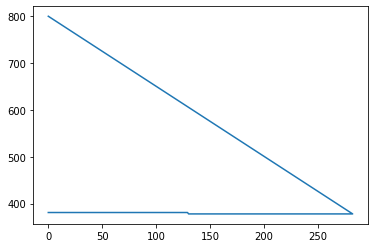

|  283      | -489.0    |  74.6     |  2.164    |  0.782    |  0.2708   |  1.061e+0 |  2.042    |  0.1209   |  15.95    |  0.09229  |  0.04775  |  1.599    |  0.8953   |  3.917    |  7.866    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.41282
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.02
Nodes:  23
LR:  0.41282
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.5118604578578352
BATCH_SIZE:  4
Dropout:  0.05
Final Linear Layers:  1
average loss: 0.693530
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4569)
Class:  0  correct:  228.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4435)
Last epoch:  16
Credit Cost:  -556


Best Score So Far:  -378


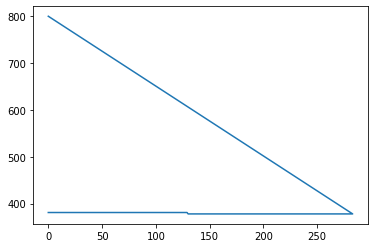

|  284      | -556.0    |  4.092    |  2.463    |  0.02177  |  0.05057  |  1.011e+0 |  1.446    |  0.4128   |  23.06    |  0.3713   |  0.5119   |  2.686    |  0.1291   |  1.261    |  4.344    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.30838
    momentum: 0.24
    nesterov: False
    weight_decay: 0.191646744933096
)
Batch Normalization Momentum:  0.75
Nodes:  14
LR:  0.30838
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.191646744933096
BATCH_SIZE:  54
Dropout:  0.1
Final Linear Layers:  3
average loss: 0.693258
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5411)
Class:  0  correct:  270.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5305)
Last epoch:  9
Credit Cost:  -469


Best Score So Far:  -378


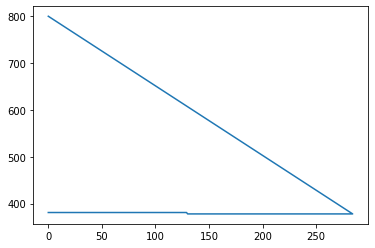

|  285      | -469.0    |  54.08    |  1.55     |  0.7466   |  0.09654  |  1.8e+03  |  3.725    |  0.3084   |  14.88    |  0.09241  |  0.1916   |  2.764    |  0.2435   |  2.857    |  5.45     |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.19622
    weight_decay: 0.51348856107534
)
Batch Normalization Momentum:  0.07
Nodes:  4
LR:  0.19622
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.51348856107534
BATCH_SIZE:  15
Dropout:  0.2
Final Linear Layers:  3
average loss: 0.693776
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5752)
Class:  0  correct:  287.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.5076)
Last epoch:  8
Credit Cost:  -492


Best Score So Far:  -378


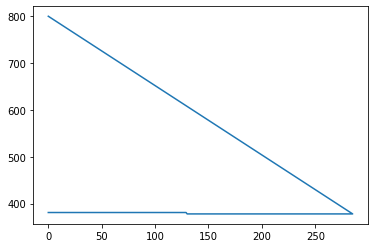

|  286      | -492.0    |  15.7     |  2.79     |  0.06709  |  0.2042   |  1.972e+0 |  3.121    |  0.1962   |  4.203    |  0.5796   |  0.5135   |  1.714    |  0.6472   |  2.694    |  1.307    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.38427
    weight_decay: 0.4680311102385725
)
Batch Normalization Momentum:  0.38
Nodes:  8
LR:  0.38427
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.4680311102385725
BATCH_SIZE:  118
Dropout:  0.25
Final Linear Layers:  2
average loss: 2.766967
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4569)
Class:  0  correct:  228.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6600)
Class:  1  correct:  66.0  of  tensor(100.)
Final percentage:  tensor(0.5585)
Last epoch:  14
Credit Cost:  -441


Best Score So Far:  -378


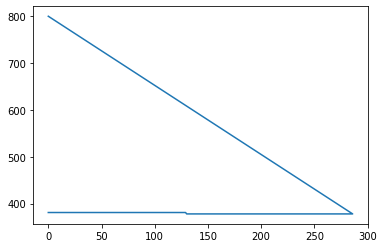

|  287      | -441.0    |  118.2    |  1.756    |  0.3756   |  0.2539   |  1.484e+0 |  2.349    |  0.3843   |  8.353    |  0.5282   |  0.468    |  2.072    |  0.7017   |  2.79     |  8.564    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.04805
    weight_decay: 0.31108319164320775
)
Batch Normalization Momentum:  0.26
Nodes:  6
LR:  0.04805
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.31108319164320775
BATCH_SIZE:  113
Dropout:  0.02
Final Linear Layers:  3
average loss: 0.693570
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5210)
Class:  0  correct:  260.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4805)
Last epoch:  8
Credit Cost:  -519


Best Score So Far:  -378


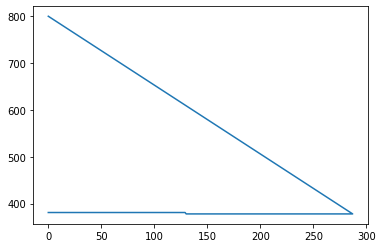

|  288      | -519.0    |  113.0    |  1.195    |  0.256    |  0.0164   |  1.229e+0 |  3.156    |  0.04805  |  6.654    |  0.7702   |  0.3111   |  1.577    |  0.6375   |  3.652    |  1.338    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.03492
    t0: 1000000.0
    weight_decay: 0.031104932252606406
)
Batch Normalization Momentum:  0.86
Nodes:  22
LR:  0.03492
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.031104932252606406
BATCH_SIZE:  89
Dropout:  0.06
Final Linear Layers:  1
average loss: 0.693804
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4810)
Class:  0  correct:  240.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.4955)
Last epoch:  9
Credit Cost:  -504


Best Score So Far:  -378


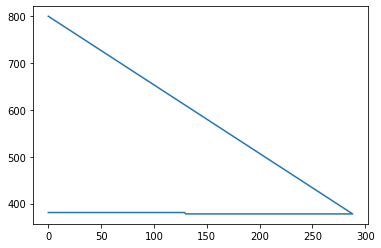

|  289      | -504.0    |  89.94    |  2.33     |  0.8593   |  0.05891  |  1.713e+0 |  1.311    |  0.03492  |  22.42    |  0.02359  |  0.0311   |  1.074    |  0.4608   |  3.266    |  9.92     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.47822
    momentum: 0.31
    nesterov: False
    weight_decay: 0.04114330986246096
)
Batch Normalization Momentum:  0.79
Nodes:  19
LR:  0.47822
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.04114330986246096
BATCH_SIZE:  32
Dropout:  0.26
Final Linear Layers:  1
average loss: 0.693139
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5251)
Class:  0  correct:  262.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4825)
Last epoch:  8
Credit Cost:  -517


Best Score So Far:  -378


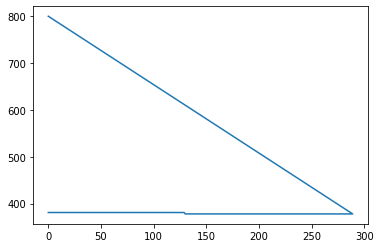

|  290      | -517.0    |  32.1     |  2.577    |  0.7873   |  0.2617   |  1.314e+0 |  1.397    |  0.4782   |  19.02    |  0.4148   |  0.04114  |  1.013    |  0.3129   |  1.812    |  5.277    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.51818
    weight_decay: 0.1102102245915392
)
Batch Normalization Momentum:  0.29
Nodes:  21
LR:  0.51818
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.1102102245915392
BATCH_SIZE:  118
Dropout:  0.25
Final Linear Layers:  3
average loss: 0.694537
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4930)
Class:  0  correct:  246.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4665)
Last epoch:  21
Credit Cost:  -533


Best Score So Far:  -378


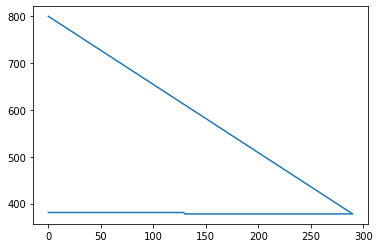

|  291      | -533.0    |  118.5    |  1.829    |  0.285    |  0.2536   |  1.307e+0 |  3.738    |  0.5182   |  21.16    |  0.7472   |  0.1102   |  2.2      |  0.3238   |  2.461    |  3.026    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.48808
    weight_decay: 0.4974947111266714
)
Batch Normalization Momentum:  0.47
Nodes:  22
LR:  0.48808
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.4974947111266714
BATCH_SIZE:  115
Dropout:  0.22
Final Linear Layers:  2
average loss: 0.693108
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


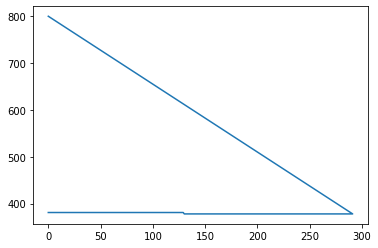

|  292      | -800.0    |  115.8    |  1.819    |  0.472    |  0.2164   |  1.122e+0 |  2.504    |  0.4881   |  22.32    |  0.322    |  0.4975   |  2.86     |  0.8858   |  3.219    |  3.392    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.58382
    weight_decay: 0.547197869754617
)
Batch Normalization Momentum:  0.38
Nodes:  23
LR:  0.58382
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.547197869754617
BATCH_SIZE:  50
Dropout:  0.14
Final Linear Layers:  1
average loss: 222.886322
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4810)
Class:  0  correct:  240.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5405)
Last epoch:  15
Credit Cost:  -459


Best Score So Far:  -378


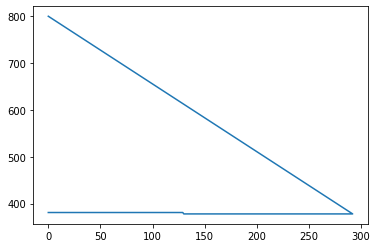

|  293      | -459.0    |  50.19    |  2.111    |  0.3772   |  0.1367   |  1.794e+0 |  1.311    |  0.5838   |  23.14    |  0.864    |  0.5472   |  1.86     |  0.9331   |  1.757    |  1.416    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.44779
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.53
Nodes:  31
LR:  0.44779
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.43670847294924753
BATCH_SIZE:  16
Dropout:  0.07
Final Linear Layers:  1
average loss: 0.693644
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4950)
Class:  0  correct:  247.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4100)
Class:  1  correct:  41.0  of  tensor(100.)
Final percentage:  tensor(0.4525)
Last epoch:  8
Credit Cost:  -547


Best Score So Far:  -378


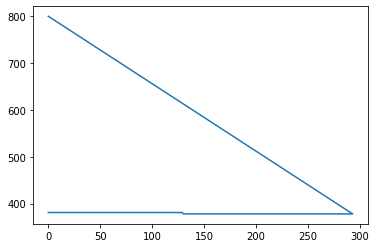

|  294      | -547.0    |  16.01    |  1.399    |  0.5337   |  0.06708  |  1.835e+0 |  1.028    |  0.4478   |  31.07    |  0.2676   |  0.4367   |  2.422    |  0.3237   |  2.295    |  7.602    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.05888
    weight_decay: 0.3962197830888894
)
Batch Normalization Momentum:  0.37
Nodes:  29
LR:  0.05888
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.3962197830888894
BATCH_SIZE:  20
Dropout:  0.07
Final Linear Layers:  1
average loss: 0.694010
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6212)
Class:  0  correct:  310.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.2900)
Class:  1  correct:  29.0  of  tensor(100.)
Final percentage:  tensor(0.4556)
Last epoch:  15
Credit Cost:  -544


Best Score So Far:  -378


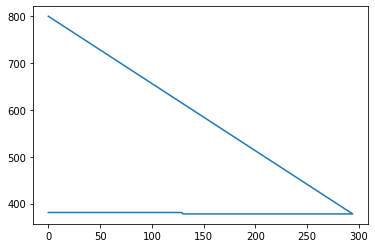

|  295      | -544.0    |  20.26    |  1.286    |  0.3717   |  0.06852  |  1.307e+0 |  1.449    |  0.05888  |  29.48    |  0.3462   |  0.3962   |  2.089    |  0.4459   |  3.236    |  3.981    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.36255
    weight_decay: 0.1999176639224124
)
Batch Normalization Momentum:  0.57
Nodes:  9
LR:  0.36255
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.1999176639224124
BATCH_SIZE:  114
Dropout:  0.1
Final Linear Layers:  1
average loss: 12.979246
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5792)
Class:  0  correct:  289.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.5396)
Last epoch:  17
Credit Cost:  -460


Best Score So Far:  -378


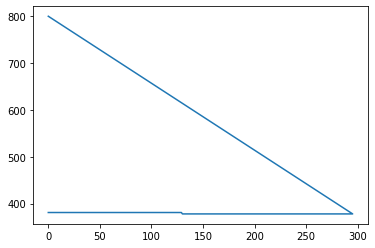

|  296      | -460.0    |  114.7    |  1.135    |  0.5691   |  0.1017   |  1.364e+0 |  1.912    |  0.3625   |  9.032    |  0.2947   |  0.1999   |  1.014    |  0.3679   |  1.146    |  8.861    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.07543
    weight_decay: 0.42203077163681085
)
Batch Normalization Momentum:  0.74
Nodes:  14
LR:  0.07543
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.42203077163681085
BATCH_SIZE:  93
Dropout:  0.27
Final Linear Layers:  2
average loss: 0.692448
Class:  0  accuracy:  tensor(0.4409)
Class:  0  correct:  220.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.4954)
Last epoch:  7
Credit Cost:  -504


Best Score So Far:  -378


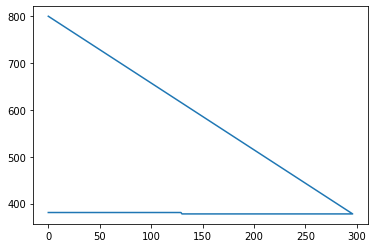

|  297      | -504.0    |  93.51    |  2.185    |  0.7364   |  0.2703   |  1.694e+0 |  2.766    |  0.07543  |  14.14    |  0.5788   |  0.422    |  2.912    |  0.2034   |  2.983    |  3.305    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.23974
    weight_decay: 0.6114015681793649
)
Batch Normalization Momentum:  0.33
Nodes:  20
LR:  0.23974
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6114015681793649
BATCH_SIZE:  55
Dropout:  0.11
Final Linear Layers:  1
average loss: 7.222557
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5110)
Class:  0  correct:  255.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5405)
Last epoch:  16
Credit Cost:  -459


Best Score So Far:  -378


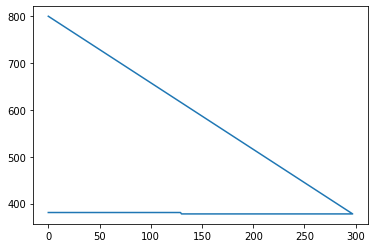

|  298      | -459.0    |  55.8     |  2.934    |  0.3278   |  0.1086   |  1.44e+03 |  1.122    |  0.2397   |  20.57    |  0.5779   |  0.6114   |  2.276    |  0.5514   |  2.916    |  1.428    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.21192
    weight_decay: 0.6228999699176647
)
Batch Normalization Momentum:  0.41
Nodes:  31
LR:  0.21192
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.6228999699176647
BATCH_SIZE:  127
Dropout:  0.09
Final Linear Layers:  2
average loss: 0.692911
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3800)
Class:  1  correct:  38.0  of  tensor(100.)
Final percentage:  tensor(0.4415)
Last epoch:  7
Credit Cost:  -558


Best Score So Far:  -378


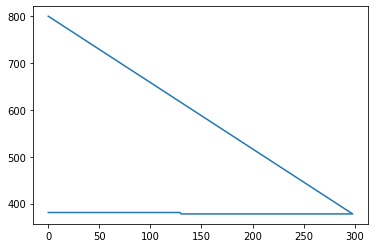

|  299      | -558.0    |  127.5    |  1.302    |  0.4143   |  0.08858  |  1.577e+0 |  2.673    |  0.2119   |  31.21    |  0.7508   |  0.6229   |  1.906    |  0.5934   |  2.236    |  3.735    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.59802
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.21
Nodes:  26
LR:  0.59802
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.4591576328796153
BATCH_SIZE:  69
Dropout:  0.15
Final Linear Layers:  2
average loss: 0.694074
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5411)
Class:  0  correct:  270.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3400)
Class:  1  correct:  34.0  of  tensor(100.)
Final percentage:  tensor(0.4405)
Last epoch:  11
Credit Cost:  -559


Best Score So Far:  -378


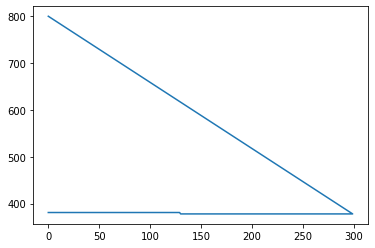

|  300      | -559.0    |  69.16    |  1.38     |  0.212    |  0.1532   |  1.014e+0 |  2.332    |  0.598    |  26.68    |  0.08429  |  0.4592   |  1.449    |  0.1168   |  2.043    |  7.088    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.05116
    weight_decay: 0.009824689852994234
)
Batch Normalization Momentum:  0.85
Nodes:  17
LR:  0.05116
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.009824689852994234
BATCH_SIZE:  72
Dropout:  0.14
Final Linear Layers:  1
average loss: 0.693252
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4850)
Class:  0  correct:  242.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5575)
Last epoch:  9
Credit Cost:  -441


Best Score So Far:  -378


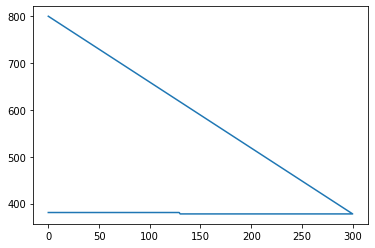

|  301      | -441.0    |  72.29    |  1.087    |  0.8482   |  0.1433   |  1.857e+0 |  1.561    |  0.05116  |  17.48    |  0.4546   |  0.009825 |  1.078    |  0.0927   |  1.122    |  2.58     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.52601
    rho: 0.9
    weight_decay: 0.6041799929510933
)
Batch Normalization Momentum:  0.97
Nodes:  3
LR:  0.52601
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6041799929510933
BATCH_SIZE:  75
Dropout:  0.02
Final Linear Layers:  2
average loss: 0.693624
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5070)
Class:  0  correct:  253.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4635)
Last epoch:  21
Credit Cost:  -536


Best Score So Far:  -378


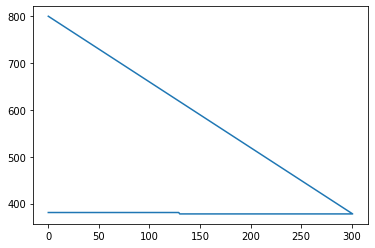

|  302      | -536.0    |  75.37    |  1.949    |  0.97     |  0.02122  |  1.867e+0 |  2.73     |  0.526    |  3.671    |  0.09996  |  0.6042   |  2.135    |  0.5529   |  1.039    |  6.774    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.13643
    weight_decay: 0.46255002828589104
)
Batch Normalization Momentum:  0.43
Nodes:  15
LR:  0.13643
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.46255002828589104
BATCH_SIZE:  109
Dropout:  0.09
Final Linear Layers:  1
average loss: 0.737900
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4830)
Class:  0  correct:  241.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.5315)
Last epoch:  13
Credit Cost:  -468


Best Score So Far:  -378


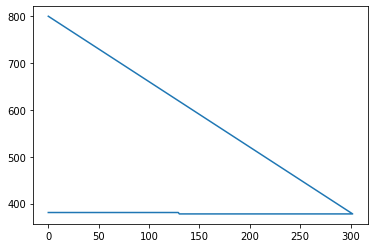

|  303      | -468.0    |  109.1    |  2.982    |  0.4286   |  0.09342  |  1.405e+0 |  1.682    |  0.1364   |  15.01    |  0.6842   |  0.4626   |  2.537    |  0.2146   |  3.179    |  8.149    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.12832
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.16
Nodes:  13
LR:  0.12832
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.6684372792608719
BATCH_SIZE:  73
Dropout:  0.01
Final Linear Layers:  2
average loss: 0.688957
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4208)
Class:  0  correct:  210.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7600)
Class:  1  correct:  76.0  of  tensor(100.)
Final percentage:  tensor(0.5904)
Last epoch:  8
Credit Cost:  -409


Best Score So Far:  -378


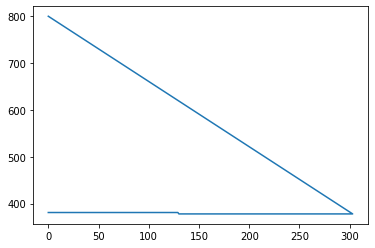

|  304      | -409.0    |  73.66    |  1.927    |  0.1566   |  0.01394  |  1.464e+0 |  2.956    |  0.1283   |  14.0     |  0.4976   |  0.6684   |  2.746    |  0.8653   |  3.98     |  7.953    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.36413
    momentum: 0.7
    nesterov: False
    weight_decay: 0.2668113817859194
)
Batch Normalization Momentum:  0.16
Nodes:  3
LR:  0.36413
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.2668113817859194
BATCH_SIZE:  29
Dropout:  0.27
Final Linear Layers:  1
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


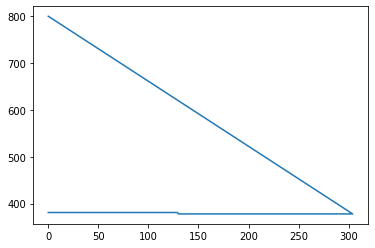

|  305      | -800.0    |  29.18    |  2.671    |  0.1646   |  0.2667   |  1.339e+0 |  1.861    |  0.3641   |  3.818    |  0.9063   |  0.2668   |  2.572    |  0.7034   |  3.105    |  5.788    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.48924
    t0: 1000000.0
    weight_decay: 0.0049677467858702164
)
Batch Normalization Momentum:  0.68
Nodes:  23
LR:  0.48924
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.0049677467858702164
BATCH_SIZE:  61
Dropout:  0.07
Final Linear Layers:  3
average loss: 0.694371
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4770)
Class:  0  correct:  238.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4735)
Last epoch:  70
Credit Cost:  -526


Best Score So Far:  -378


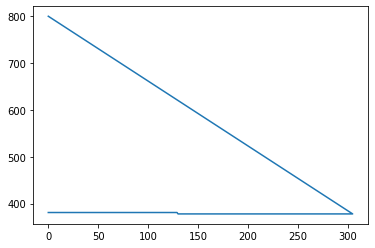

|  306      | -526.0    |  61.87    |  2.284    |  0.6847   |  0.07075  |  1.754e+0 |  3.8      |  0.4892   |  23.92    |  0.8211   |  0.004968 |  1.348    |  0.3386   |  3.193    |  9.796    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.10844
    momentum: 0.28
    nesterov: False
    weight_decay: 0.321928372830523
)
Batch Normalization Momentum:  0.91
Nodes:  10
LR:  0.10844
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.321928372830523
BATCH_SIZE:  94
Dropout:  0.11
Final Linear Layers:  1
average loss: 0.692583
Class:  0  accuracy:  tensor(0.4770)
Class:  0  correct:  238.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6200)
Class:  1  correct:  62.0  of  tensor(100.)
Final percentage:  tensor(0.5485)
Last epoch:  7
Credit Cost:  -451


Best Score So Far:  -378


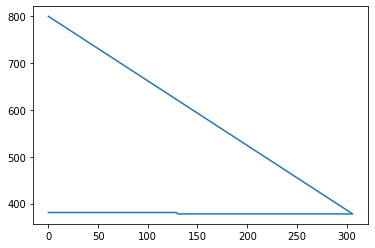

|  307      | -451.0    |  94.88    |  1.953    |  0.9118   |  0.1133   |  1.642e+0 |  1.004    |  0.1084   |  10.85    |  0.3872   |  0.3219   |  2.585    |  0.277    |  1.247    |  5.687    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.59174
    weight_decay: 0.46558742798208796
)
Batch Normalization Momentum:  0.25
Nodes:  16
LR:  0.59174
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.46558742798208796
BATCH_SIZE:  125
Dropout:  0.23
Final Linear Layers:  1
average loss: 3.813221
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.4885)
Last epoch:  18
Credit Cost:  -511


Best Score So Far:  -378


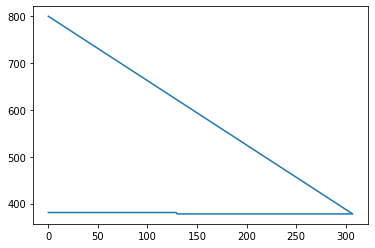

|  308      | -511.0    |  125.7    |  1.798    |  0.2546   |  0.2329   |  1.616e+0 |  1.023    |  0.5917   |  16.67    |  0.3044   |  0.4656   |  1.568    |  0.4589   |  2.949    |  2.096    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.5915
    weight_decay: 0.6202255337416891
)
Batch Normalization Momentum:  0.95
Nodes:  30
LR:  0.5915
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6202255337416891
BATCH_SIZE:  61
Dropout:  0.01
Final Linear Layers:  3
average loss: 0.693149
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


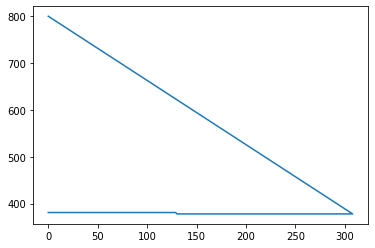

|  309      | -800.0    |  61.94    |  2.463    |  0.9509   |  0.006417 |  1.832e+0 |  3.808    |  0.5915   |  30.13    |  0.13     |  0.6202   |  1.304    |  0.3569   |  2.08     |  3.515    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.14655
    weight_decay: 0.5654027876318667
)
Batch Normalization Momentum:  0.08
Nodes:  11
LR:  0.14655
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.5654027876318667
BATCH_SIZE:  47
Dropout:  0.11
Final Linear Layers:  1
average loss: 0.692727
Class:  0  accuracy:  tensor(0.8196)
Class:  0  correct:  409.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3700)
Class:  1  correct:  37.0  of  tensor(100.)
Final percentage:  tensor(0.5948)
Last epoch:  7
Credit Cost:  -405


Best Score So Far:  -378


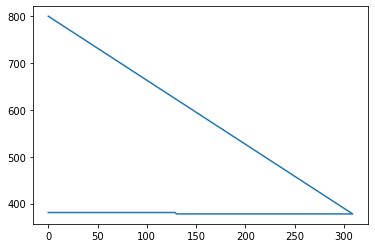

|  310      | -405.0    |  48.0     |  2.081    |  0.07773  |  0.1119   |  1.583e+0 |  1.401    |  0.1465   |  11.38    |  0.07538  |  0.5654   |  1.524    |  0.4065   |  2.212    |  3.74     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.16659
    rho: 0.9
    weight_decay: 0.33257318034448236
)
Batch Normalization Momentum:  0.67
Nodes:  3
LR:  0.16659
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.33257318034448236
BATCH_SIZE:  19
Dropout:  0.08
Final Linear Layers:  1
average loss: 0.692882
Class:  0  accuracy:  tensor(0.4529)
Class:  0  correct:  226.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6800)
Class:  1  correct:  68.0  of  tensor(100.)
Final percentage:  tensor(0.5665)
Last epoch:  7
Credit Cost:  -433


Best Score So Far:  -378


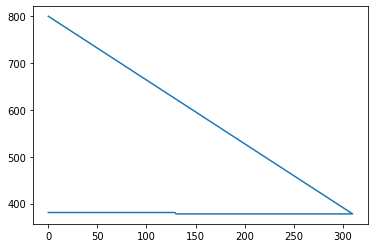

|  311      | -433.0    |  19.84    |  2.778    |  0.6746   |  0.08007  |  1.092e+0 |  1.369    |  0.1666   |  3.471    |  0.1459   |  0.3326   |  2.863    |  0.4297   |  3.12     |  6.127    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.58729
    weight_decay: 0.01931082489543752
)
Batch Normalization Momentum:  0.73
Nodes:  27
LR:  0.58729
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.01931082489543752
BATCH_SIZE:  125
Dropout:  0.11
Final Linear Layers:  2
average loss: 18.857782
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5431)
Class:  0  correct:  271.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.5615)
Last epoch:  30
Credit Cost:  -438


Best Score So Far:  -378


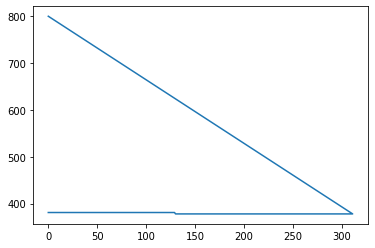

|  312      | -438.0    |  125.1    |  1.355    |  0.7317   |  0.1051   |  1.991e+0 |  2.055    |  0.5873   |  27.81    |  0.5975   |  0.01931  |  1.369    |  0.05595  |  3.369    |  1.665    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.53255
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.25
Nodes:  21
LR:  0.53255
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.018993655567778073
BATCH_SIZE:  101
Dropout:  0.09
Final Linear Layers:  2
average loss: 0.692355
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5090)
Class:  0  correct:  254.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5095)
Last epoch:  12
Credit Cost:  -490


Best Score So Far:  -378


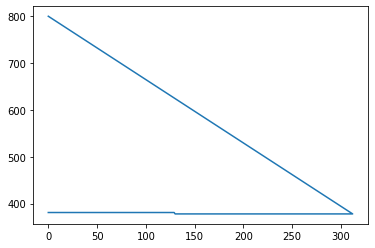

|  313      | -490.0    |  101.5    |  1.056    |  0.2527   |  0.08928  |  1.565e+0 |  2.681    |  0.5326   |  21.12    |  0.1621   |  0.01899  |  2.516    |  0.5302   |  2.73     |  4.723    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.5861
    weight_decay: 0.3826127374193676
)
Batch Normalization Momentum:  0.44
Nodes:  27
LR:  0.5861
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.3826127374193676
BATCH_SIZE:  77
Dropout:  0.18
Final Linear Layers:  1
average loss: 105.119926
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4389)
Class:  0  correct:  219.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5244)
Last epoch:  14
Credit Cost:  -475


Best Score So Far:  -378


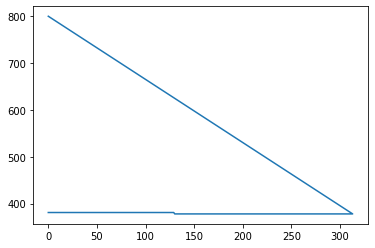

|  314      | -475.0    |  77.14    |  1.807    |  0.4412   |  0.1778   |  1.492e+0 |  1.177    |  0.5861   |  27.65    |  0.3793   |  0.3826   |  2.856    |  0.394    |  3.825    |  1.274    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.35234
    momentum: 0.71
    nesterov: False
    weight_decay: 0.04886368527466408
)
Batch Normalization Momentum:  0.19
Nodes:  5
LR:  0.35234
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.04886368527466408
BATCH_SIZE:  96
Dropout:  0.05
Final Linear Layers:  2
average loss: 0.692832
Class:  0  accuracy:  tensor(0.4529)
Class:  0  correct:  226.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5415)
Last epoch:  7
Credit Cost:  -458


Best Score So Far:  -378


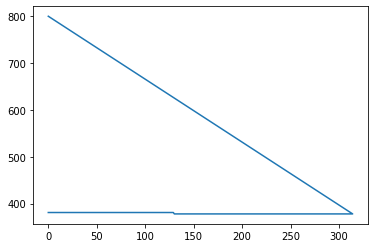

|  315      | -458.0    |  96.48    |  2.586    |  0.1919   |  0.04886  |  1.591e+0 |  2.434    |  0.3523   |  5.968    |  0.2782   |  0.04886  |  1.215    |  0.7092   |  1.079    |  5.851    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.20173
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.54
Nodes:  9
LR:  0.20173
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.15910003061180075
BATCH_SIZE:  41
Dropout:  0.3
Final Linear Layers:  2
average loss: 0.693556
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5070)
Class:  0  correct:  253.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.4985)
Last epoch:  10
Credit Cost:  -501


Best Score So Far:  -378


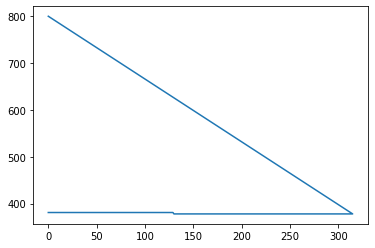

|  316      | -501.0    |  41.03    |  2.728    |  0.5396   |  0.2993   |  1.561e+0 |  2.681    |  0.2017   |  9.57     |  0.4275   |  0.1591   |  1.141    |  0.4208   |  1.318    |  7.501    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.00568
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.19
Nodes:  9
LR:  0.00568
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.21764069738348554
BATCH_SIZE:  41
Dropout:  0.2
Final Linear Layers:  1
average loss: 0.693898
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5010)
Class:  0  correct:  250.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4655)
Last epoch:  20
Credit Cost:  -534


Best Score So Far:  -378


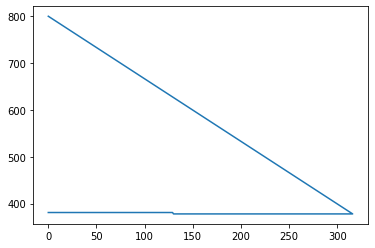

|  317      | -534.0    |  41.0     |  1.976    |  0.1936   |  0.2042   |  1.831e+0 |  1.659    |  0.005677 |  9.527    |  0.6274   |  0.2176   |  2.664    |  0.8442   |  2.112    |  4.284    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0944
    weight_decay: 0.4608473205989901
)
Batch Normalization Momentum:  0.15
Nodes:  3
LR:  0.0944
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.4608473205989901
BATCH_SIZE:  6
Dropout:  0.03
Final Linear Layers:  1
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


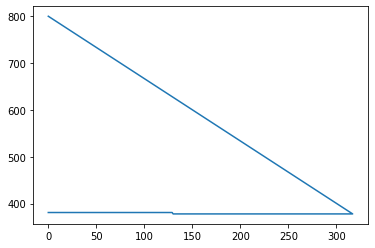

|  318      | -800.0    |  6.054    |  2.094    |  0.1527   |  0.0338   |  1.053e+0 |  1.536    |  0.0944   |  3.065    |  0.9815   |  0.4608   |  1.77     |  0.06186  |  1.141    |  8.237    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.23581
    momentum: 0.76
    nesterov: False
    weight_decay: 0.3522054809434716
)
Batch Normalization Momentum:  0.17
Nodes:  3
LR:  0.23581
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.3522054809434716
BATCH_SIZE:  56
Dropout:  0.2
Final Linear Layers:  1
average loss: 0.693181
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5210)
Class:  0  correct:  260.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5355)
Last epoch:  8
Credit Cost:  -464


Best Score So Far:  -378


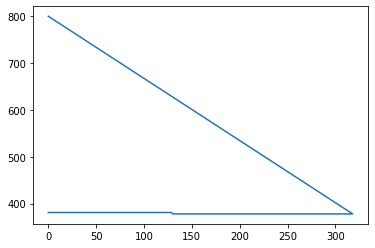

|  319      | -464.0    |  56.42    |  1.215    |  0.1654   |  0.2041   |  1.427e+0 |  1.289    |  0.2358   |  3.343    |  0.2715   |  0.3522   |  1.91     |  0.7609   |  1.479    |  5.585    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.56532
    weight_decay: 0.4250140881046363
)
Batch Normalization Momentum:  0.41
Nodes:  22
LR:  0.56532
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.4250140881046363
BATCH_SIZE:  21
Dropout:  0.04
Final Linear Layers:  2
average loss: 0.721591
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5130)
Class:  0  correct:  256.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5415)
Last epoch:  8
Credit Cost:  -458


Best Score So Far:  -378


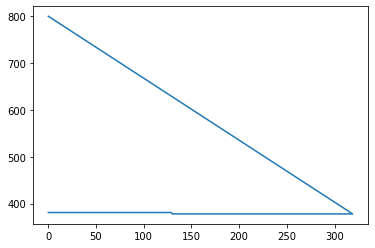

|  320      | -458.0    |  21.55    |  1.377    |  0.4058   |  0.04376  |  1.562e+0 |  2.361    |  0.5653   |  22.1     |  0.1039   |  0.425    |  1.836    |  0.4956   |  2.961    |  2.67     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.34386
    momentum: 0.15
    nesterov: False
    weight_decay: 0.4801703727621375
)
Batch Normalization Momentum:  0.61
Nodes:  12
LR:  0.34386
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.4801703727621375
BATCH_SIZE:  48
Dropout:  0.09
Final Linear Layers:  1
average loss: 0.693115
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


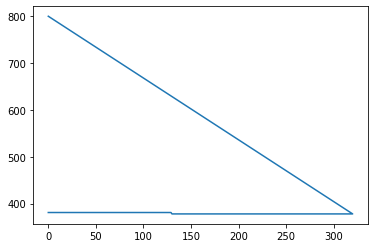

|  321      | -800.0    |  48.58    |  1.956    |  0.6086   |  0.08567  |  1.503e+0 |  1.833    |  0.3439   |  12.27    |  0.8385   |  0.4802   |  2.624    |  0.1527   |  1.554    |  5.878    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.41256
    weight_decay: 0.3289155526209923
)
Batch Normalization Momentum:  0.33
Nodes:  24
LR:  0.41256
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.3289155526209923
BATCH_SIZE:  11
Dropout:  0.1
Final Linear Layers:  1
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


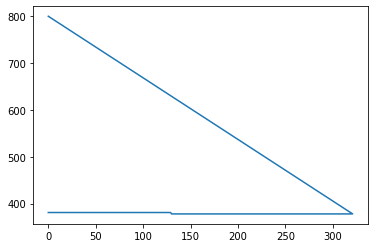

|  322      | -800.0    |  11.61    |  2.071    |  0.3326   |  0.09734  |  1.23e+03 |  1.014    |  0.4126   |  24.58    |  0.3386   |  0.3289   |  2.587    |  0.641    |  1.069    |  3.553    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.1636
    weight_decay: 0.30605156425898966
)
Batch Normalization Momentum:  0.32
Nodes:  9
LR:  0.1636
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.30605156425898966
BATCH_SIZE:  122
Dropout:  0.27
Final Linear Layers:  1
average loss: 0.693171
Class:  0  accuracy:  tensor(0.4509)
Class:  0  correct:  225.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.4505)
Last epoch:  7
Credit Cost:  -549


Best Score So Far:  -378


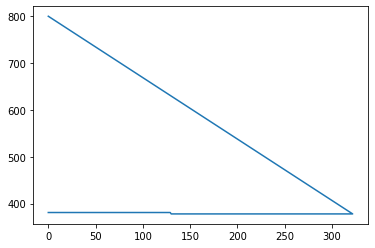

|  323      | -549.0    |  122.3    |  2.757    |  0.322    |  0.2732   |  1.479e+0 |  1.604    |  0.1636   |  9.229    |  0.05646  |  0.3061   |  2.8      |  0.5205   |  2.631    |  3.041    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.26654
    weight_decay: 0.4316043207654932
)
Batch Normalization Momentum:  0.21
Nodes:  13
LR:  0.26654
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.4316043207654932
BATCH_SIZE:  9
Dropout:  0.26
Final Linear Layers:  1
average loss: 0.694486
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4369)
Class:  0  correct:  218.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5334)
Last epoch:  8
Credit Cost:  -465


Best Score So Far:  -378


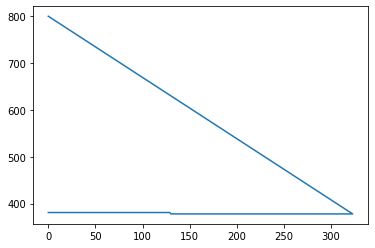

|  324      | -465.0    |  9.754    |  1.25     |  0.213    |  0.262    |  1.988e+0 |  1.053    |  0.2665   |  13.08    |  0.5364   |  0.4316   |  1.788    |  0.182    |  2.75     |  1.299    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.16006
    weight_decay: 0.39124060889058343
)
Batch Normalization Momentum:  0.09
Nodes:  24
LR:  0.16006
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.39124060889058343
BATCH_SIZE:  114
Dropout:  0.17
Final Linear Layers:  1
average loss: 0.698594
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4369)
Class:  0  correct:  218.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6700)
Class:  1  correct:  67.0  of  tensor(100.)
Final percentage:  tensor(0.5534)
Last epoch:  13
Credit Cost:  -446


Best Score So Far:  -378


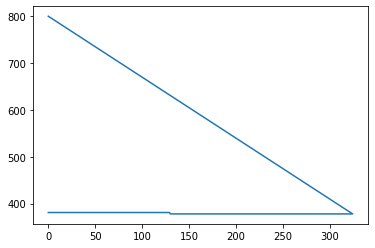

|  325      | -446.0    |  114.9    |  2.282    |  0.0936   |  0.1654   |  1.129e+0 |  1.355    |  0.1601   |  24.89    |  0.6978   |  0.3912   |  1.508    |  0.5127   |  3.78     |  2.666    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.07905
    weight_decay: 0.20406743884267367
)
Batch Normalization Momentum:  0.66
Nodes:  26
LR:  0.07905
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.20406743884267367
BATCH_SIZE:  95
Dropout:  0.06
Final Linear Layers:  2
average loss: 0.694060
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3500)
Class:  1  correct:  35.0  of  tensor(100.)
Final percentage:  tensor(0.4265)
Last epoch:  39
Credit Cost:  -573


Best Score So Far:  -378


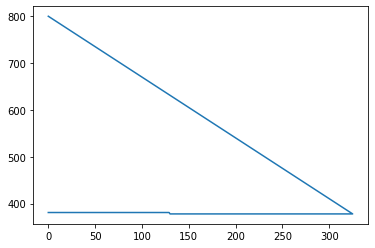

|  326      | -573.0    |  95.04    |  2.736    |  0.6628   |  0.06111  |  1.129e+0 |  2.54     |  0.07905  |  26.77    |  0.5236   |  0.2041   |  2.131    |  0.258    |  2.748    |  3.087    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.23479
    weight_decay: 0.6239149124366533
)
Batch Normalization Momentum:  0.83
Nodes:  11
LR:  0.23479
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6239149124366533
BATCH_SIZE:  31
Dropout:  0.19
Final Linear Layers:  1
average loss: 0.728194
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5331)
Class:  0  correct:  266.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5215)
Last epoch:  9
Credit Cost:  -478


Best Score So Far:  -378


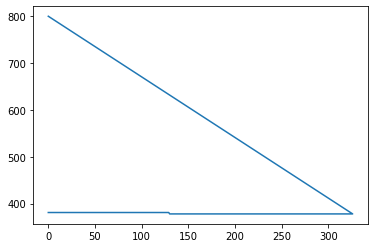

|  327      | -478.0    |  31.16    |  2.032    |  0.8271   |  0.1934   |  1.094e+0 |  1.401    |  0.2348   |  11.59    |  0.8904   |  0.6239   |  1.059    |  0.2084   |  2.161    |  2.586    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.2575
    weight_decay: 0.6717265930497175
)
Batch Normalization Momentum:  0.73
Nodes:  26
LR:  0.2575
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.6717265930497175
BATCH_SIZE:  117
Dropout:  0.29
Final Linear Layers:  3
average loss: 5.180150
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4950)
Class:  0  correct:  247.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5525)
Last epoch:  11
Credit Cost:  -447


Best Score So Far:  -378


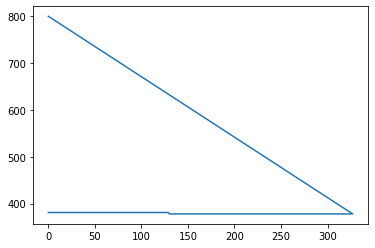

|  328      | -447.0    |  117.9    |  1.377    |  0.7266   |  0.2871   |  1.478e+0 |  3.435    |  0.2575   |  26.4     |  0.7612   |  0.6717   |  1.67     |  0.7589   |  3.756    |  8.289    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.20688
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.29
Nodes:  29
LR:  0.20688
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.24478911010325494
BATCH_SIZE:  104
Dropout:  0.13
Final Linear Layers:  3
average loss: 0.693336
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4469)
Class:  0  correct:  223.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5234)
Last epoch:  12
Credit Cost:  -476


Best Score So Far:  -378


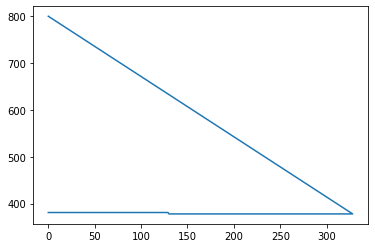

|  329      | -476.0    |  105.0    |  2.887    |  0.2878   |  0.132    |  1.106e+0 |  3.623    |  0.2069   |  29.16    |  0.2044   |  0.2448   |  2.374    |  0.9135   |  3.057    |  4.057    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.04696
    weight_decay: 0.37509634022324795
)
Batch Normalization Momentum:  0.47
Nodes:  10
LR:  0.04696
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.37509634022324795
BATCH_SIZE:  8
Dropout:  0.22
Final Linear Layers:  1
average loss: 0.693130
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


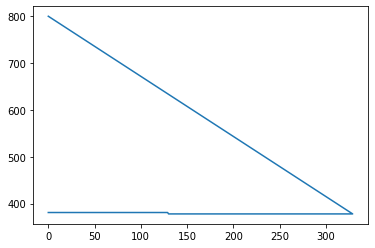

|  330      | -800.0    |  8.965    |  1.66     |  0.4714   |  0.2191   |  1.894e+0 |  1.019    |  0.04696  |  10.45    |  0.5355   |  0.3751   |  1.846    |  0.8748   |  3.175    |  2.222    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.11029
    momentum: 0.2
    nesterov: False
    weight_decay: 0.046108655353414664
)
Batch Normalization Momentum:  0.36
Nodes:  16
LR:  0.11029
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.046108655353414664
BATCH_SIZE:  33
Dropout:  0.24
Final Linear Layers:  3
average loss: 0.692360
Class:  0  accuracy:  tensor(0.4689)
Class:  0  correct:  234.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5095)
Last epoch:  7
Credit Cost:  -490


Best Score So Far:  -378


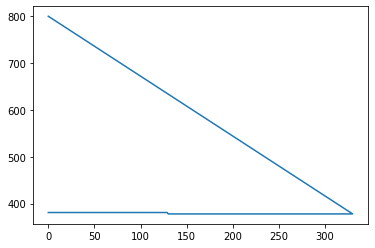

|  331      | -490.0    |  33.16    |  2.006    |  0.3589   |  0.2426   |  1.419e+0 |  3.814    |  0.1103   |  16.48    |  0.8935   |  0.04611  |  1.556    |  0.2007   |  3.945    |  5.211    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.58913
    rho: 0.9
    weight_decay: 0.601116263611695
)
Batch Normalization Momentum:  0.1
Nodes:  12
LR:  0.58913
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.601116263611695
BATCH_SIZE:  114
Dropout:  0.1
Final Linear Layers:  3
average loss: 0.691395
Class:  0  accuracy:  tensor(0.5571)
Class:  0  correct:  278.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5300)
Class:  1  correct:  53.0  of  tensor(100.)
Final percentage:  tensor(0.5436)
Last epoch:  7
Credit Cost:  -456


Best Score So Far:  -378


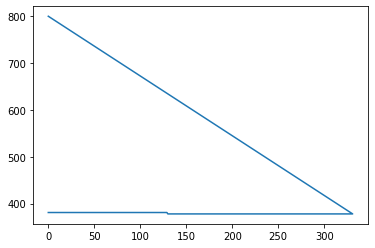

|  332      | -456.0    |  114.1    |  2.699    |  0.1029   |  0.105    |  1.497e+0 |  3.628    |  0.5891   |  12.11    |  0.7814   |  0.6011   |  1.56     |  0.1969   |  2.933    |  6.072    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.44032
    t0: 1000000.0
    weight_decay: 0.2989363877961503
)
Batch Normalization Momentum:  0.36
Nodes:  12
LR:  0.44032
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.2989363877961503
BATCH_SIZE:  23
Dropout:  0.18
Final Linear Layers:  2
average loss: 0.693162
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6573)
Class:  0  correct:  328.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.2100)
Class:  1  correct:  21.0  of  tensor(100.)
Final percentage:  tensor(0.4337)
Last epoch:  8
Credit Cost:  -566


Best Score So Far:  -378


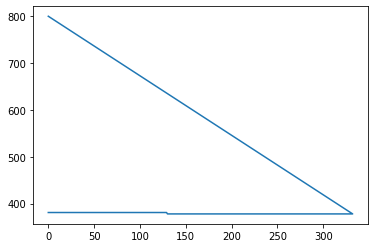

|  333      | -566.0    |  23.17    |  2.477    |  0.3565   |  0.1814   |  1.006e+0 |  2.766    |  0.4403   |  12.37    |  0.7588   |  0.2989   |  1.842    |  0.2964   |  3.216    |  9.245    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.2434
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.79
Nodes:  16
LR:  0.2434
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.5887147344964853
BATCH_SIZE:  58
Dropout:  0.09
Final Linear Layers:  2
average loss: 0.693492
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4629)
Class:  0  correct:  231.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3300)
Class:  1  correct:  33.0  of  tensor(100.)
Final percentage:  tensor(0.3965)
Last epoch:  21
Credit Cost:  -603


Best Score So Far:  -378


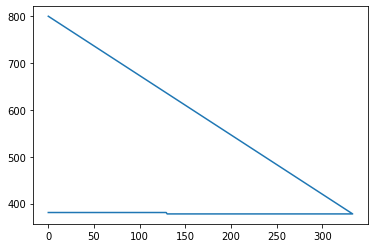

|  334      | -603.0    |  58.94    |  2.964    |  0.7915   |  0.09337  |  1.233e+0 |  2.073    |  0.2434   |  16.88    |  0.7011   |  0.5887   |  1.118    |  0.4485   |  2.278    |  4.812    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.42833
    weight_decay: 0.6760363051653856
)
Batch Normalization Momentum:  0.33
Nodes:  28
LR:  0.42833
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6760363051653856
BATCH_SIZE:  73
Dropout:  0.28
Final Linear Layers:  2
average loss: 23.010880
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5291)
Class:  0  correct:  264.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6500)
Class:  1  correct:  65.0  of  tensor(100.)
Final percentage:  tensor(0.5895)
Last epoch:  20
Credit Cost:  -410


Best Score So Far:  -378


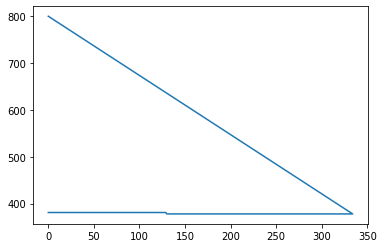

|  335      | -410.0    |  73.9     |  2.87     |  0.327    |  0.2847   |  1.246e+0 |  2.64     |  0.4283   |  28.42    |  0.7811   |  0.676    |  2.097    |  0.8964   |  2.958    |  2.519    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.44992
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.67
Nodes:  18
LR:  0.44992
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.28290228127280154
BATCH_SIZE:  7
Dropout:  0.09
Final Linear Layers:  3
average loss: 0.695112
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4709)
Class:  0  correct:  235.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4505)
Last epoch:  15
Credit Cost:  -549


Best Score So Far:  -378


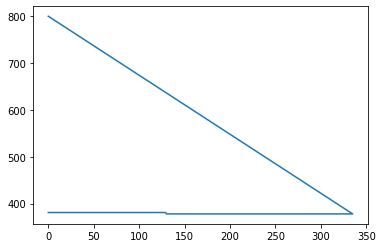

|  336      | -549.0    |  7.802    |  2.514    |  0.6708   |  0.08649  |  1.106e+0 |  3.061    |  0.4499   |  18.75    |  0.6649   |  0.2829   |  2.724    |  0.5271   |  3.676    |  7.65     |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.01927
    t0: 1000000.0
    weight_decay: 0.07874006276017222
)
Batch Normalization Momentum:  0.88
Nodes:  5
LR:  0.01927
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.07874006276017222
BATCH_SIZE:  68
Dropout:  0.06
Final Linear Layers:  3
average loss: 0.692896
Class:  0  accuracy:  tensor(0.4749)
Class:  0  correct:  237.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5425)
Last epoch:  7
Credit Cost:  -457


Best Score So Far:  -378


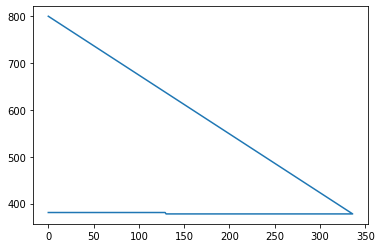

|  337      | -457.0    |  68.84    |  2.432    |  0.8779   |  0.05835  |  1.43e+03 |  3.569    |  0.01927  |  5.992    |  0.4055   |  0.07874  |  2.445    |  0.9651   |  2.462    |  9.633    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.26435
    weight_decay: 0.296766384059555
)
Batch Normalization Momentum:  0.58
Nodes:  30
LR:  0.26435
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.296766384059555
BATCH_SIZE:  20
Dropout:  0.24
Final Linear Layers:  3
average loss: 0.690051
Class:  0  accuracy:  tensor(0.6032)
Class:  0  correct:  301.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.5266)
Last epoch:  7
Credit Cost:  -473


Best Score So Far:  -378


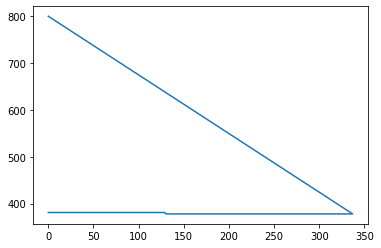

|  338      | -473.0    |  20.84    |  2.394    |  0.577    |  0.2375   |  1.538e+0 |  3.93     |  0.2644   |  30.51    |  0.9174   |  0.2968   |  1.817    |  0.01975  |  2.341    |  2.793    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.49983
    weight_decay: 0.28034713899014513
)
Batch Normalization Momentum:  0.66
Nodes:  19
LR:  0.49983
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.28034713899014513
BATCH_SIZE:  45
Dropout:  0.13
Final Linear Layers:  3
average loss: 139.750641
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5631)
Class:  0  correct:  281.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5416)
Last epoch:  12
Credit Cost:  -458


Best Score So Far:  -378


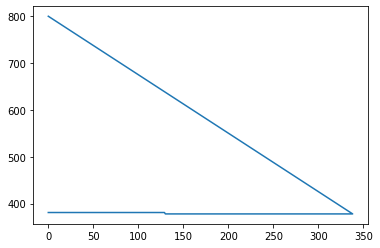

|  339      | -458.0    |  45.65    |  1.562    |  0.6635   |  0.1321   |  1.6e+03  |  3.522    |  0.4998   |  19.57    |  0.4407   |  0.2803   |  1.142    |  0.4627   |  2.205    |  2.812    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.21262
    weight_decay: 0.5113905187326534
)
Batch Normalization Momentum:  0.97
Nodes:  18
LR:  0.21262
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5113905187326534
BATCH_SIZE:  103
Dropout:  0.12
Final Linear Layers:  2
average loss: 0.895965
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4930)
Class:  0  correct:  246.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5665)
Last epoch:  12
Credit Cost:  -433


Best Score So Far:  -378


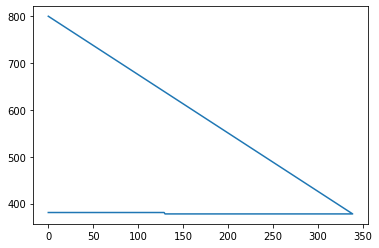

|  340      | -433.0    |  103.5    |  2.389    |  0.9657   |  0.1157   |  1.417e+0 |  2.554    |  0.2126   |  18.36    |  0.889    |  0.5114   |  1.411    |  0.7922   |  3.378    |  8.184    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.41334
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.65
Nodes:  29
LR:  0.41334
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.6569403411679224
BATCH_SIZE:  43
Dropout:  0.04
Final Linear Layers:  2
average loss: 0.693176
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5110)
Class:  0  correct:  255.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5405)
Last epoch:  10
Credit Cost:  -459


Best Score So Far:  -378


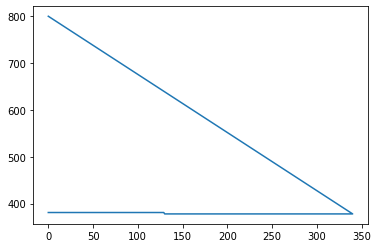

|  341      | -459.0    |  43.28    |  2.22     |  0.6458   |  0.03607  |  1.919e+0 |  2.101    |  0.4133   |  29.85    |  0.6745   |  0.6569   |  2.391    |  0.1691   |  3.179    |  4.647    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.4635
    weight_decay: 0.6967036748913981
)
Batch Normalization Momentum:  0.78
Nodes:  17
LR:  0.4635
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6967036748913981
BATCH_SIZE:  43
Dropout:  0.28
Final Linear Layers:  2
average loss: 30.445848
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4850)
Class:  0  correct:  242.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5300)
Class:  1  correct:  53.0  of  tensor(100.)
Final percentage:  tensor(0.5075)
Last epoch:  12
Credit Cost:  -492


Best Score So Far:  -378


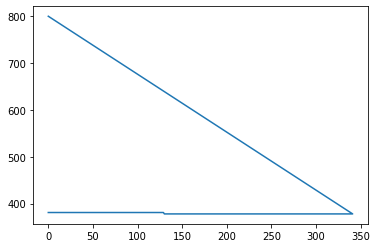

|  342      | -492.0    |  43.5     |  2.553    |  0.7826   |  0.2847   |  1.203e+0 |  2.593    |  0.4635   |  17.49    |  0.2293   |  0.6967   |  2.77     |  0.5714   |  2.609    |  8.551    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.18978
    momentum: 0.64
    nesterov: False
    weight_decay: 0.65562971189973
)
Batch Normalization Momentum:  0.43
Nodes:  5
LR:  0.18978
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.65562971189973
BATCH_SIZE:  117
Dropout:  0.26
Final Linear Layers:  2
average loss: 0.693349
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  9
Credit Cost:  -800


Best Score So Far:  -378


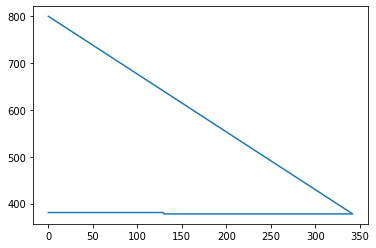

|  343      | -800.0    |  117.4    |  2.631    |  0.4285   |  0.2567   |  1.226e+0 |  2.616    |  0.1898   |  5.589    |  0.1462   |  0.6556   |  1.388    |  0.6434   |  1.715    |  5.724    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.42858
    weight_decay: 0.31373190230235254
)
Batch Normalization Momentum:  0.4
Nodes:  6
LR:  0.42858
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.31373190230235254
BATCH_SIZE:  20
Dropout:  0.21
Final Linear Layers:  2
average loss: 0.693153
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


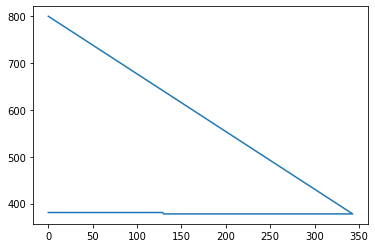

|  344      | -800.0    |  20.2     |  1.576    |  0.3965   |  0.212    |  1.901e+0 |  2.281    |  0.4286   |  6.173    |  0.1014   |  0.3137   |  2.513    |  0.2293   |  3.419    |  3.269    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.39824
    weight_decay: 0.3740530894831534
)
Batch Normalization Momentum:  0.0
Nodes:  16
LR:  0.39824
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.3740530894831534
BATCH_SIZE:  14
Dropout:  0.21
Final Linear Layers:  3
average loss: 0.692361
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


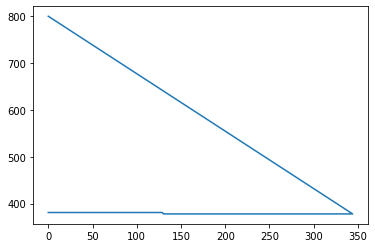

|  345      | -800.0    |  14.39    |  2.021    |  0.000968 |  0.2124   |  1.739e+0 |  3.91     |  0.3982   |  16.83    |  0.07448  |  0.3741   |  1.282    |  0.7944   |  2.723    |  2.914    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0631
    weight_decay: 0.4504864831781306
)
Batch Normalization Momentum:  0.66
Nodes:  21
LR:  0.0631
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.4504864831781306
BATCH_SIZE:  91
Dropout:  0.23
Final Linear Layers:  2
average loss: 0.690098
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5010)
Class:  0  correct:  250.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5355)
Last epoch:  9
Credit Cost:  -464


Best Score So Far:  -378


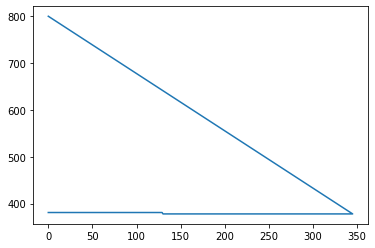

|  346      | -464.0    |  91.67    |  1.663    |  0.6624   |  0.2339   |  1.087e+0 |  2.527    |  0.0631   |  21.48    |  0.3159   |  0.4505   |  1.097    |  0.8583   |  2.43     |  8.134    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.34819
    weight_decay: 0.11236399242474394
)
Batch Normalization Momentum:  0.76
Nodes:  3
LR:  0.34819
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.11236399242474394
BATCH_SIZE:  32
Dropout:  0.26
Final Linear Layers:  3
average loss: 0.695110
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5130)
Class:  0  correct:  256.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4800)
Class:  1  correct:  48.0  of  tensor(100.)
Final percentage:  tensor(0.4965)
Last epoch:  8
Credit Cost:  -503


Best Score So Far:  -378


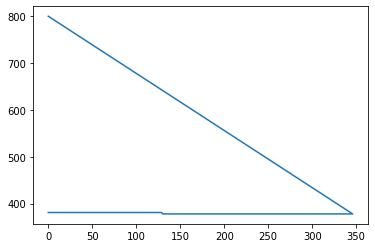

|  347      | -503.0    |  32.1     |  1.667    |  0.7561   |  0.256    |  1.437e+0 |  3.782    |  0.3482   |  3.473    |  0.453    |  0.1124   |  2.458    |  0.3439   |  1.602    |  8.577    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.34011
    momentum: 0.56
    nesterov: False
    weight_decay: 0.537526904731262
)
Batch Normalization Momentum:  0.4
Nodes:  26
LR:  0.34011
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.537526904731262
BATCH_SIZE:  105
Dropout:  0.02
Final Linear Layers:  3
average loss: 0.693281
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5090)
Class:  0  correct:  254.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4695)
Last epoch:  8
Credit Cost:  -530


Best Score So Far:  -378


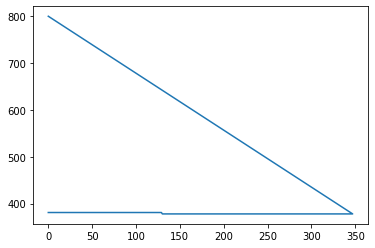

|  348      | -530.0    |  105.4    |  1.684    |  0.3996   |  0.01818  |  1.179e+0 |  3.2      |  0.3401   |  26.7     |  0.5011   |  0.5375   |  2.015    |  0.5624   |  1.552    |  5.894    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.22222
    weight_decay: 0.25147133536099925
)
Batch Normalization Momentum:  0.14
Nodes:  28
LR:  0.22222
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.25147133536099925
BATCH_SIZE:  28
Dropout:  0.06
Final Linear Layers:  1
average loss: 0.693125
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


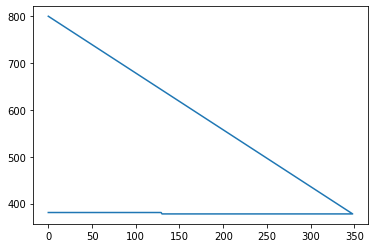

|  349      | -800.0    |  28.93    |  2.107    |  0.14     |  0.0558   |  1.765e+0 |  1.212    |  0.2222   |  28.34    |  0.1051   |  0.2515   |  1.227    |  0.8678   |  1.377    |  3.288    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.59446
    rho: 0.9
    weight_decay: 0.494394054045045
)
Batch Normalization Momentum:  0.34
Nodes:  11
LR:  0.59446
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.494394054045045
BATCH_SIZE:  56
Dropout:  0.06
Final Linear Layers:  2
average loss: 0.693407
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5190)
Class:  0  correct:  259.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5300)
Class:  1  correct:  53.0  of  tensor(100.)
Final percentage:  tensor(0.5245)
Last epoch:  9
Credit Cost:  -475


Best Score So Far:  -378


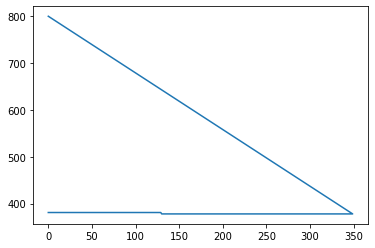

|  350      | -475.0    |  56.32    |  2.324    |  0.3413   |  0.06405  |  1.373e+0 |  2.707    |  0.5945   |  11.81    |  0.3625   |  0.4944   |  1.595    |  0.3462   |  3.974    |  6.432    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.29788
    weight_decay: 0.4131574945518032
)
Batch Normalization Momentum:  0.14
Nodes:  13
LR:  0.29788
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.4131574945518032
BATCH_SIZE:  106
Dropout:  0.22
Final Linear Layers:  3
average loss: 0.844037
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5411)
Class:  0  correct:  270.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5900)
Class:  1  correct:  59.0  of  tensor(100.)
Final percentage:  tensor(0.5655)
Last epoch:  12
Credit Cost:  -434


Best Score So Far:  -378


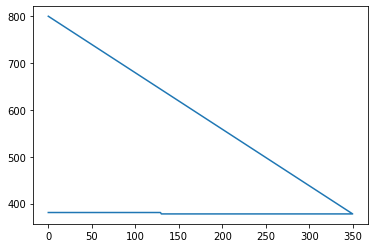

|  351      | -434.0    |  106.8    |  1.063    |  0.144    |  0.2183   |  1.54e+03 |  3.976    |  0.2979   |  13.52    |  0.195    |  0.4132   |  2.526    |  0.9152   |  1.412    |  1.073    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.1206
    t0: 1000000.0
    weight_decay: 0.12038611487151978
)
Batch Normalization Momentum:  0.6
Nodes:  26
LR:  0.1206
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.12038611487151978
BATCH_SIZE:  63
Dropout:  0.19
Final Linear Layers:  3
average loss: 0.693589
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5391)
Class:  0  correct:  269.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4895)
Last epoch:  27
Credit Cost:  -510


Best Score So Far:  -378


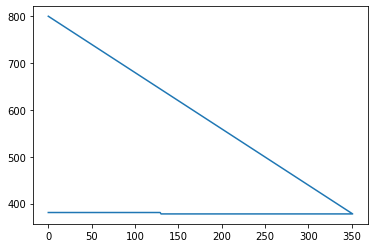

|  352      | -510.0    |  63.27    |  1.364    |  0.6042   |  0.1861   |  1.41e+03 |  3.025    |  0.1206   |  26.26    |  0.05124  |  0.1204   |  2.951    |  0.8914   |  3.81     |  9.167    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.31971
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.24
Nodes:  16
LR:  0.31971
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.39909726279554064
BATCH_SIZE:  58
Dropout:  0.01
Final Linear Layers:  1
average loss: 0.692494
Class:  0  accuracy:  tensor(0.4569)
Class:  0  correct:  228.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5400)
Class:  1  correct:  54.0  of  tensor(100.)
Final percentage:  tensor(0.4985)
Last epoch:  7
Credit Cost:  -501


Best Score So Far:  -378


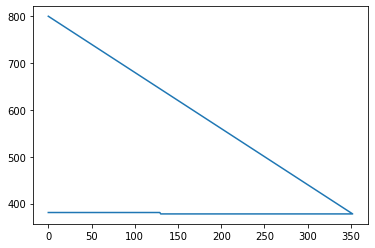

|  353      | -501.0    |  58.74    |  2.868    |  0.235    |  0.01485  |  1.557e+0 |  1.937    |  0.3197   |  16.15    |  0.4832   |  0.3991   |  2.838    |  0.2338   |  3.619    |  7.597    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.41308
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.39
Nodes:  27
LR:  0.41308
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.2597207453799556
BATCH_SIZE:  13
Dropout:  0.1
Final Linear Layers:  1
average loss: 0.695696
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4409)
Class:  0  correct:  220.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.2900)
Class:  1  correct:  29.0  of  tensor(100.)
Final percentage:  tensor(0.3654)
Last epoch:  14
Credit Cost:  -634


Best Score So Far:  -378


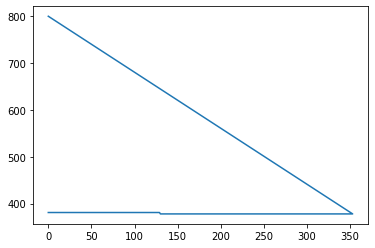

|  354      | -634.0    |  13.82    |  2.662    |  0.3937   |  0.1007   |  1e+03    |  1.735    |  0.4131   |  27.54    |  0.2416   |  0.2597   |  1.299    |  0.7955   |  3.144    |  7.297    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01835
    weight_decay: 0.6357287593882963
)
Batch Normalization Momentum:  0.87
Nodes:  29
LR:  0.01835
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.6357287593882963
BATCH_SIZE:  88
Dropout:  0.19
Final Linear Layers:  2
average loss: 0.693099
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5785)
Last epoch:  9
Credit Cost:  -421


Best Score So Far:  -378


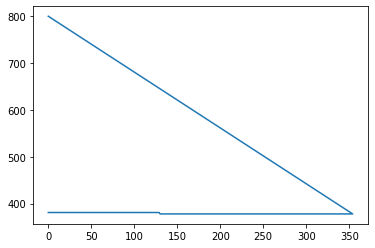

|  355      | -421.0    |  88.18    |  2.775    |  0.8742   |  0.1876   |  1.289e+0 |  2.205    |  0.01835  |  29.49    |  0.6871   |  0.6357   |  1.601    |  0.9354   |  3.583    |  8.965    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.29267
    weight_decay: 0.6419858915182445
)
Batch Normalization Momentum:  0.12
Nodes:  19
LR:  0.29267
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6419858915182445
BATCH_SIZE:  4
Dropout:  0.28
Final Linear Layers:  2
average loss: 0.693146
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


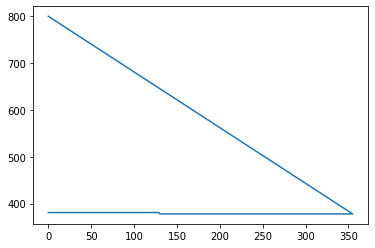

|  356      | -800.0    |  4.018    |  1.751    |  0.1211   |  0.2798   |  1.514e+0 |  2.463    |  0.2927   |  19.11    |  0.5444   |  0.642    |  2.76     |  0.7759   |  1.965    |  8.052    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.13675
    weight_decay: 0.38051802734302886
)
Batch Normalization Momentum:  0.77
Nodes:  26
LR:  0.13675
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.38051802734302886
BATCH_SIZE:  22
Dropout:  0.23
Final Linear Layers:  2
average loss: 0.693176
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5070)
Class:  0  correct:  253.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3900)
Class:  1  correct:  39.0  of  tensor(100.)
Final percentage:  tensor(0.4485)
Last epoch:  9
Credit Cost:  -551


Best Score So Far:  -378


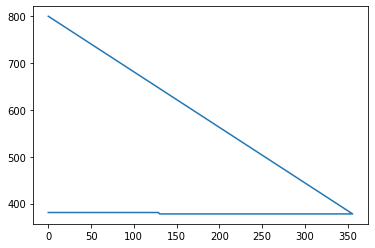

|  357      | -551.0    |  22.0     |  2.712    |  0.7653   |  0.2328   |  1.529e+0 |  2.346    |  0.1368   |  26.26    |  0.965    |  0.3805   |  2.795    |  0.2795   |  2.548    |  3.95     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.0557
    rho: 0.9
    weight_decay: 0.364605468043887
)
Batch Normalization Momentum:  0.67
Nodes:  20
LR:  0.0557
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.364605468043887
BATCH_SIZE:  126
Dropout:  0.23
Final Linear Layers:  3
average loss: 0.694837
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4990)
Class:  0  correct:  249.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.4945)
Last epoch:  69
Credit Cost:  -504


Best Score So Far:  -378


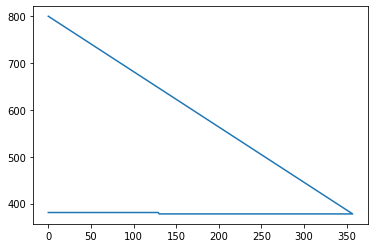

|  358      | -504.0    |  127.0    |  1.498    |  0.672    |  0.2293   |  1.032e+0 |  3.937    |  0.0557   |  20.42    |  0.1501   |  0.3646   |  1.186    |  0.7734   |  3.311    |  6.377    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.16946
    rho: 0.9
    weight_decay: 0.20800739155753653
)
Batch Normalization Momentum:  0.18
Nodes:  9
LR:  0.16946
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.20800739155753653
BATCH_SIZE:  5
Dropout:  0.29
Final Linear Layers:  3
average loss: 0.693110
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -378


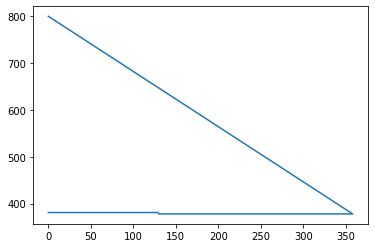

|  359      | -800.0    |  5.803    |  1.084    |  0.1792   |  0.2916   |  1.255e+0 |  3.246    |  0.1695   |  9.666    |  0.2583   |  0.208    |  1.018    |  0.9773   |  2.694    |  6.411    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.03399
    weight_decay: 0.3819628684443113
)
Batch Normalization Momentum:  0.47
Nodes:  20
LR:  0.03399
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.3819628684443113
BATCH_SIZE:  70
Dropout:  0.16
Final Linear Layers:  2
average loss: 0.693819
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5210)
Class:  0  correct:  260.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7300)
Class:  1  correct:  73.0  of  tensor(100.)
Final percentage:  tensor(0.6255)
Last epoch:  9
Credit Cost:  -374


Best Score So Far:  -374


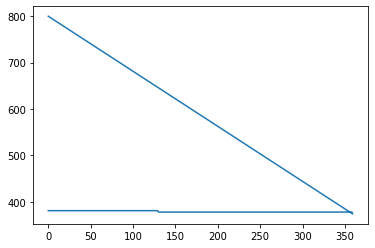

|  360      | -374.0    |  70.74    |  1.087    |  0.4668   |  0.1619   |  1.673e+0 |  2.597    |  0.03399  |  20.6     |  0.581    |  0.382    |  2.678    |  0.4429   |  2.805    |  2.111    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.15626
    weight_decay: 0.13887604599313966
)
Batch Normalization Momentum:  0.02
Nodes:  23
LR:  0.15626
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.13887604599313966
BATCH_SIZE:  35
Dropout:  0.05
Final Linear Layers:  1
average loss: 0.692439
Class:  0  accuracy:  tensor(0.5150)
Class:  0  correct:  257.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.5025)
Last epoch:  7
Credit Cost:  -497


Best Score So Far:  -374


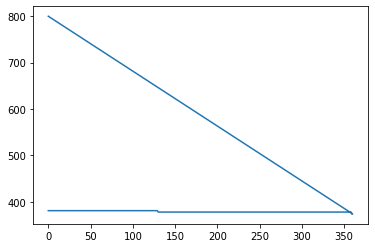

|  361      | -497.0    |  35.3     |  2.692    |  0.01606  |  0.04688  |  1.823e+0 |  1.686    |  0.1563   |  23.02    |  0.9656   |  0.1389   |  2.488    |  0.1391   |  2.144    |  3.906    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.31793
    weight_decay: 0.32246684674112785
)
Batch Normalization Momentum:  0.33
Nodes:  24
LR:  0.31793
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.32246684674112785
BATCH_SIZE:  113
Dropout:  0.01
Final Linear Layers:  3
average loss: 1.204417
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4529)
Class:  0  correct:  226.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6800)
Class:  1  correct:  68.0  of  tensor(100.)
Final percentage:  tensor(0.5665)
Last epoch:  20
Credit Cost:  -433


Best Score So Far:  -374


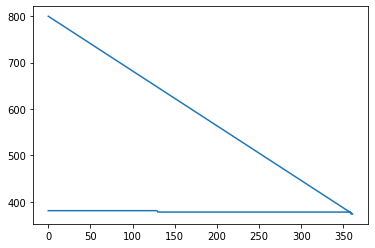

|  362      | -433.0    |  113.6    |  2.304    |  0.3302   |  0.006482 |  1.369e+0 |  3.907    |  0.3179   |  24.26    |  0.3457   |  0.3225   |  1.421    |  0.8286   |  2.076    |  1.333    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.59848
    weight_decay: 0.06655233816227393
)
Batch Normalization Momentum:  0.79
Nodes:  6
LR:  0.59848
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.06655233816227393
BATCH_SIZE:  89
Dropout:  0.0
Final Linear Layers:  2
average loss: 0.692038
Class:  0  accuracy:  tensor(0.5371)
Class:  0  correct:  268.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.5485)
Last epoch:  7
Credit Cost:  -451


Best Score So Far:  -374


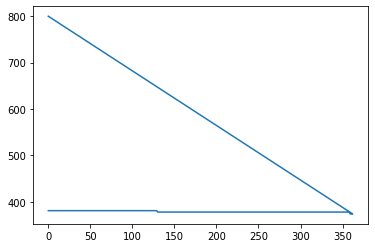

|  363      | -451.0    |  89.43    |  1.31     |  0.7908   |  0.004579 |  1.586e+0 |  2.482    |  0.5985   |  6.031    |  0.6722   |  0.06655  |  1.322    |  0.9784   |  3.412    |  3.199    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.33389
    weight_decay: 0.371155143974656
)
Batch Normalization Momentum:  0.53
Nodes:  11
LR:  0.33389
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.371155143974656
BATCH_SIZE:  108
Dropout:  0.03
Final Linear Layers:  2
average loss: 0.877486
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5010)
Class:  0  correct:  250.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.5505)
Last epoch:  18
Credit Cost:  -449


Best Score So Far:  -374


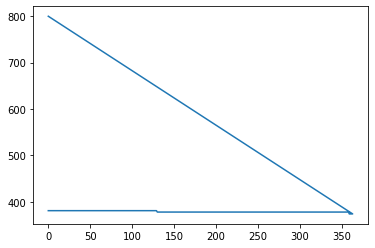

|  364      | -449.0    |  108.9    |  1.071    |  0.5303   |  0.02744  |  1.971e+0 |  2.743    |  0.3339   |  11.54    |  0.8492   |  0.3712   |  1.034    |  0.183    |  2.296    |  1.719    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.51113
    weight_decay: 0.46078320158119107
)
Batch Normalization Momentum:  0.0
Nodes:  6
LR:  0.51113
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.46078320158119107
BATCH_SIZE:  38
Dropout:  0.21
Final Linear Layers:  3
average loss: 0.693165
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6613)
Class:  0  correct:  330.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.1700)
Class:  1  correct:  17.0  of  tensor(100.)
Final percentage:  tensor(0.4157)
Last epoch:  8
Credit Cost:  -584


Best Score So Far:  -374


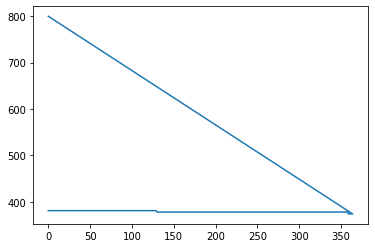

|  365      | -584.0    |  38.8     |  1.498    |  0.000602 |  0.2079   |  1.774e+0 |  3.453    |  0.5111   |  6.546    |  0.8893   |  0.4608   |  2.385    |  0.5584   |  3.81     |  3.264    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.53988
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.88
Nodes:  21
LR:  0.53988
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.3531027570061484
BATCH_SIZE:  101
Dropout:  0.08
Final Linear Layers:  1
average loss: 0.693660
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5391)
Class:  0  correct:  269.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3600)
Class:  1  correct:  36.0  of  tensor(100.)
Final percentage:  tensor(0.4495)
Last epoch:  17
Credit Cost:  -550


Best Score So Far:  -374


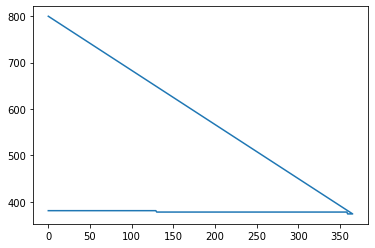

|  366      | -550.0    |  101.6    |  1.986    |  0.882    |  0.08286  |  1.015e+0 |  1.194    |  0.5399   |  21.23    |  0.7298   |  0.3531   |  2.11     |  0.3603   |  3.34     |  7.804    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.38379
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.76
Nodes:  11
LR:  0.38379
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.5517446473917395
BATCH_SIZE:  90
Dropout:  0.29
Final Linear Layers:  2
average loss: 0.692104
Class:  0  accuracy:  tensor(0.4629)
Class:  0  correct:  231.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5300)
Class:  1  correct:  53.0  of  tensor(100.)
Final percentage:  tensor(0.4965)
Last epoch:  7
Credit Cost:  -503


Best Score So Far:  -374


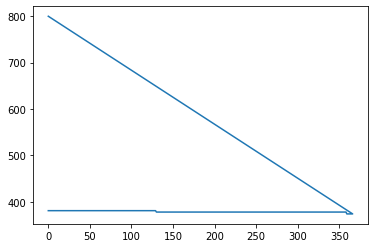

|  367      | -503.0    |  90.8     |  2.914    |  0.7611   |  0.2934   |  1.59e+03 |  2.852    |  0.3838   |  11.79    |  0.03396  |  0.5517   |  2.413    |  0.07824  |  1.444    |  7.17     |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.30209
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.06
Nodes:  4
LR:  0.30209
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.014179047078338954
BATCH_SIZE:  70
Dropout:  0.18
Final Linear Layers:  1
average loss: 0.691827
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5291)
Class:  0  correct:  264.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.5545)
Last epoch:  11
Credit Cost:  -445


Best Score So Far:  -374


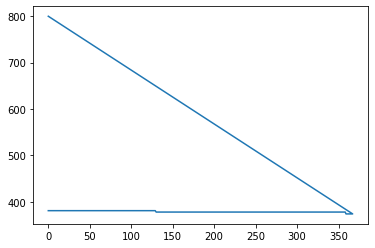

|  368      | -445.0    |  70.34    |  1.381    |  0.05539  |  0.1834   |  1.054e+0 |  1.639    |  0.3021   |  4.821    |  0.4091   |  0.01418  |  1.238    |  0.9307   |  2.671    |  7.171    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.42567
    momentum: 0.91
    nesterov: False
    weight_decay: 0.3929816614773346
)
Batch Normalization Momentum:  0.89
Nodes:  30
LR:  0.42567
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.3929816614773346
BATCH_SIZE:  50
Dropout:  0.27
Final Linear Layers:  3
average loss: 0.693347
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4790)
Class:  0  correct:  239.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5545)
Last epoch:  9
Credit Cost:  -445


Best Score So Far:  -374


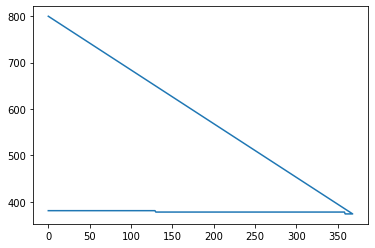

|  369      | -445.0    |  50.84    |  2.519    |  0.8874   |  0.2731   |  1.496e+0 |  3.28     |  0.4257   |  30.54    |  0.2421   |  0.393    |  1.087    |  0.9139   |  3.826    |  5.503    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.56943
    weight_decay: 0.47779479103336936
)
Batch Normalization Momentum:  0.25
Nodes:  13
LR:  0.56943
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.47779479103336936
BATCH_SIZE:  76
Dropout:  0.11
Final Linear Layers:  2
average loss: 0.693061
Class:  0  accuracy:  tensor(0.3627)
Class:  0  correct:  181.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6700)
Class:  1  correct:  67.0  of  tensor(100.)
Final percentage:  tensor(0.5164)
Last epoch:  7
Credit Cost:  -483


Best Score So Far:  -374


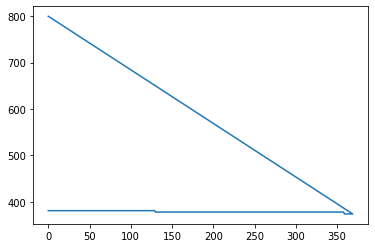

|  370      | -483.0    |  76.68    |  2.536    |  0.2468   |  0.1137   |  1.289e+0 |  2.611    |  0.5694   |  13.56    |  0.04592  |  0.4778   |  1.985    |  0.2935   |  2.244    |  8.754    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.1867
    rho: 0.9
    weight_decay: 0.42728131826979704
)
Batch Normalization Momentum:  0.68
Nodes:  6
LR:  0.1867
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.42728131826979704
BATCH_SIZE:  105
Dropout:  0.3
Final Linear Layers:  3
average loss: 0.692685
Class:  0  accuracy:  tensor(0.5391)
Class:  0  correct:  269.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.5145)
Last epoch:  7
Credit Cost:  -485


Best Score So Far:  -374


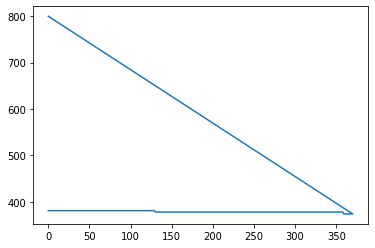

|  371      | -485.0    |  105.8    |  1.34     |  0.6783   |  0.2993   |  1.784e+0 |  3.168    |  0.1867   |  6.784    |  0.8636   |  0.4273   |  1.776    |  0.748    |  3.149    |  6.82     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.47652
    weight_decay: 0.43093217554496455
)
Batch Normalization Momentum:  0.71
Nodes:  16
LR:  0.47652
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.43093217554496455
BATCH_SIZE:  29
Dropout:  0.09
Final Linear Layers:  3
average loss: 0.693145
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


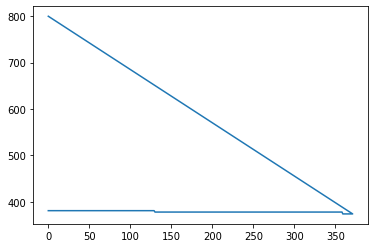

|  372      | -800.0    |  29.7     |  2.762    |  0.7118   |  0.09079  |  1.064e+0 |  3.729    |  0.4765   |  16.96    |  0.4141   |  0.4309   |  1.793    |  0.03853  |  1.903    |  3.214    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.12508
    momentum: 0.91
    nesterov: False
    weight_decay: 0.05778985868921808
)
Batch Normalization Momentum:  0.4
Nodes:  9
LR:  0.12508
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.05778985868921808
BATCH_SIZE:  124
Dropout:  0.22
Final Linear Layers:  2
average loss: 0.695489
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4269)
Class:  0  correct:  213.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.2900)
Class:  1  correct:  29.0  of  tensor(100.)
Final percentage:  tensor(0.3584)
Last epoch:  18
Credit Cost:  -641


Best Score So Far:  -374


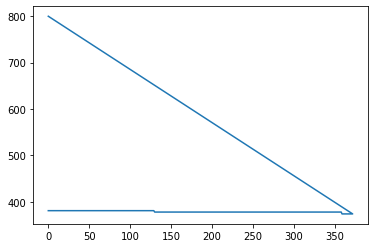

|  373      | -641.0    |  124.6    |  2.527    |  0.3997   |  0.221    |  1.303e+0 |  2.577    |  0.1251   |  9.628    |  0.4342   |  0.05779  |  2.698    |  0.9072   |  1.637    |  5.259    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.27924
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.6
Nodes:  15
LR:  0.27924
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.6735646338331358
BATCH_SIZE:  108
Dropout:  0.13
Final Linear Layers:  3
average loss: 0.695804
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4609)
Class:  0  correct:  230.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3700)
Class:  1  correct:  37.0  of  tensor(100.)
Final percentage:  tensor(0.4155)
Last epoch:  18
Credit Cost:  -584


Best Score So Far:  -374


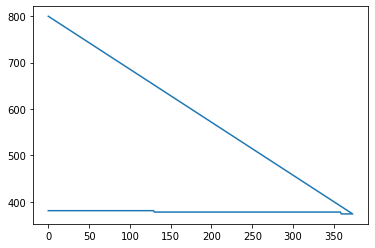

|  374      | -584.0    |  108.3    |  1.574    |  0.6046   |  0.1326   |  1.397e+0 |  3.36     |  0.2792   |  15.94    |  0.991    |  0.6736   |  1.468    |  0.2247   |  2.982    |  4.703    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.05127
    weight_decay: 0.357125248804072
)
Batch Normalization Momentum:  0.78
Nodes:  5
LR:  0.05127
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.357125248804072
BATCH_SIZE:  93
Dropout:  0.08
Final Linear Layers:  2
average loss: 0.693129
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5291)
Class:  0  correct:  264.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.5445)
Last epoch:  8
Credit Cost:  -455


Best Score So Far:  -374


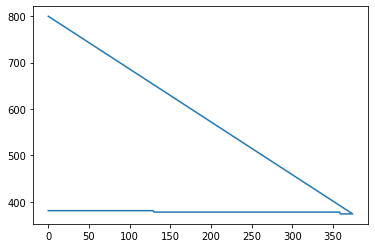

|  375      | -455.0    |  93.13    |  2.46     |  0.7755   |  0.07899  |  1.998e+0 |  2.476    |  0.05127  |  5.36     |  0.5614   |  0.3571   |  2.86     |  0.8918   |  2.392    |  2.856    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.15135
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.64
Nodes:  19
LR:  0.15135
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.2888746003567773
BATCH_SIZE:  73
Dropout:  0.15
Final Linear Layers:  1
average loss: 0.692214
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4108)
Class:  0  correct:  205.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5400)
Class:  1  correct:  54.0  of  tensor(100.)
Final percentage:  tensor(0.4754)
Last epoch:  9
Credit Cost:  -524


Best Score So Far:  -374


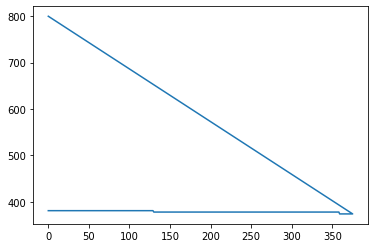

|  376      | -524.0    |  73.99    |  1.614    |  0.6441   |  0.1545   |  1.843e+0 |  1.394    |  0.1514   |  19.93    |  0.625    |  0.2889   |  2.792    |  0.8022   |  2.617    |  4.641    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.27357
    weight_decay: 0.4890048434351733
)
Batch Normalization Momentum:  0.93
Nodes:  4
LR:  0.27357
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.4890048434351733
BATCH_SIZE:  53
Dropout:  0.07
Final Linear Layers:  2
average loss: 1.017553
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5050)
Class:  0  correct:  252.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6800)
Class:  1  correct:  68.0  of  tensor(100.)
Final percentage:  tensor(0.5925)
Last epoch:  8
Credit Cost:  -407


Best Score So Far:  -374


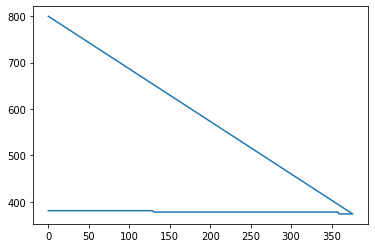

|  377      | -407.0    |  53.25    |  1.227    |  0.9279   |  0.07036  |  1.153e+0 |  2.525    |  0.2736   |  4.221    |  0.5754   |  0.489    |  1.976    |  0.07216  |  1.537    |  2.042    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.21636
    weight_decay: 0.6535652998929028
)
Batch Normalization Momentum:  0.38
Nodes:  28
LR:  0.21636
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6535652998929028
BATCH_SIZE:  76
Dropout:  0.04
Final Linear Layers:  2
average loss: 1.664466
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5230)
Class:  0  correct:  261.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5900)
Class:  1  correct:  59.0  of  tensor(100.)
Final percentage:  tensor(0.5565)
Last epoch:  16
Credit Cost:  -443


Best Score So Far:  -374


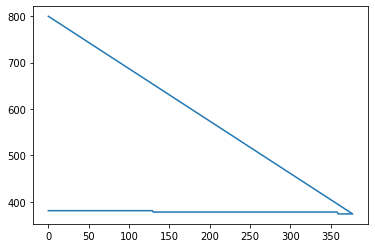

|  378      | -443.0    |  76.35    |  1.169    |  0.3802   |  0.04415  |  1.411e+0 |  2.87     |  0.2164   |  28.88    |  0.4176   |  0.6536   |  2.633    |  0.1155   |  1.311    |  2.194    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.2036
    weight_decay: 0.44815113155881564
)
Batch Normalization Momentum:  0.78
Nodes:  21
LR:  0.2036
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.44815113155881564
BATCH_SIZE:  83
Dropout:  0.16
Final Linear Layers:  3
average loss: 0.693542
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4770)
Class:  0  correct:  238.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.4885)
Last epoch:  13
Credit Cost:  -511


Best Score So Far:  -374


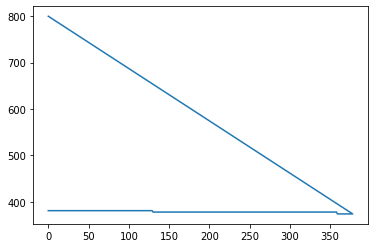

|  379      | -511.0    |  83.17    |  2.362    |  0.7821   |  0.1627   |  1.675e+0 |  3.053    |  0.2036   |  21.52    |  0.4043   |  0.4482   |  2.86     |  0.4257   |  2.513    |  3.985    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.25225
    weight_decay: 0.04065720851160465
)
Batch Normalization Momentum:  0.28
Nodes:  7
LR:  0.25225
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.04065720851160465
BATCH_SIZE:  75
Dropout:  0.25
Final Linear Layers:  1
average loss: 0.831368
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4629)
Class:  0  correct:  231.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5165)
Last epoch:  10
Credit Cost:  -483


Best Score So Far:  -374


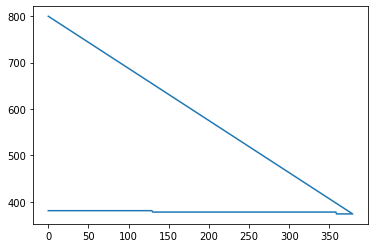

|  380      | -483.0    |  75.76    |  2.718    |  0.2808   |  0.2503   |  1.519e+0 |  1.676    |  0.2522   |  7.01     |  0.9116   |  0.04066  |  2.202    |  0.1029   |  1.937    |  2.285    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.58339
    t0: 1000000.0
    weight_decay: 0.5846258278184163
)
Batch Normalization Momentum:  0.82
Nodes:  5
LR:  0.58339
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.5846258278184163
BATCH_SIZE:  65
Dropout:  0.14
Final Linear Layers:  2
average loss: 0.693120
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


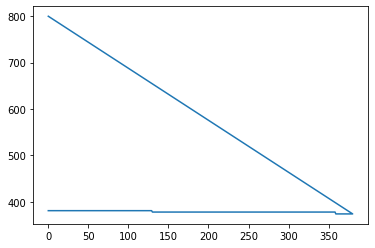

|  381      | -800.0    |  65.94    |  2.266    |  0.821    |  0.135    |  1.769e+0 |  2.78     |  0.5834   |  5.591    |  0.8157   |  0.5846   |  2.575    |  0.4503   |  2.576    |  9.859    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.15466
    momentum: 0.79
    nesterov: False
    weight_decay: 0.6659817824268698
)
Batch Normalization Momentum:  0.46
Nodes:  8
LR:  0.15466
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.6659817824268698
BATCH_SIZE:  121
Dropout:  0.16
Final Linear Layers:  1
average loss: 0.693110
Class:  0  accuracy:  tensor(0.3848)
Class:  0  correct:  192.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5900)
Class:  1  correct:  59.0  of  tensor(100.)
Final percentage:  tensor(0.4874)
Last epoch:  7
Credit Cost:  -512


Best Score So Far:  -374


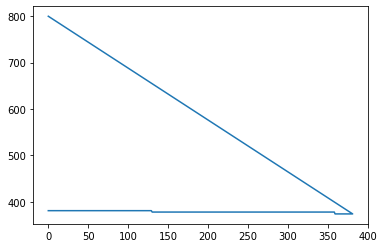

|  382      | -512.0    |  121.1    |  2.518    |  0.4557   |  0.1621   |  1.805e+0 |  1.828    |  0.1547   |  8.416    |  0.5511   |  0.666    |  1.473    |  0.7936   |  1.091    |  5.551    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.09108
    weight_decay: 0.5856658441525869
)
Batch Normalization Momentum:  0.39
Nodes:  13
LR:  0.09108
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5856658441525869
BATCH_SIZE:  39
Dropout:  0.16
Final Linear Layers:  3
average loss: 0.688430
Class:  0  accuracy:  tensor(0.4990)
Class:  0  correct:  249.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5345)
Last epoch:  7
Credit Cost:  -464


Best Score So Far:  -374


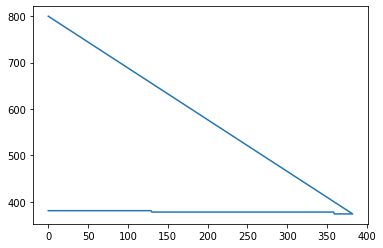

|  383      | -464.0    |  39.22    |  1.563    |  0.3881   |  0.1606   |  1.773e+0 |  3.875    |  0.09108  |  13.84    |  0.1634   |  0.5857   |  1.169    |  0.8477   |  3.215    |  8.716    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.30959
    weight_decay: 0.18696048583484406
)
Batch Normalization Momentum:  0.55
Nodes:  2
LR:  0.30959
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.18696048583484406
BATCH_SIZE:  114
Dropout:  0.09
Final Linear Layers:  1
average loss: 0.694905
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4930)
Class:  0  correct:  246.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5665)
Last epoch:  13
Credit Cost:  -433


Best Score So Far:  -374


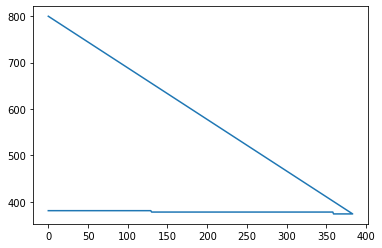

|  384      | -433.0    |  114.4    |  1.3      |  0.5511   |  0.09076  |  1.271e+0 |  1.049    |  0.3096   |  2.571    |  0.8974   |  0.187    |  1.982    |  0.6301   |  1.004    |  2.018    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.0021
    weight_decay: 0.01077755697893949
)
Batch Normalization Momentum:  0.81
Nodes:  22
LR:  0.0021
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.01077755697893949
BATCH_SIZE:  61
Dropout:  0.12
Final Linear Layers:  2
average loss: 0.693269
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4865)
Last epoch:  8
Credit Cost:  -512


Best Score So Far:  -374


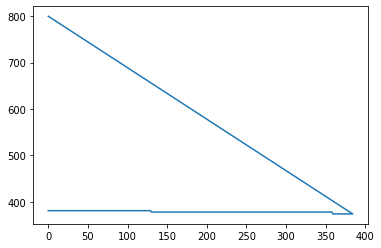

|  385      | -512.0    |  61.85    |  2.24     |  0.8115   |  0.1244   |  1.927e+0 |  2.786    |  0.002097 |  22.4     |  0.2133   |  0.01078  |  2.464    |  0.5464   |  3.343    |  1.793    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.34632
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.56
Nodes:  21
LR:  0.34632
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.3906282632559656
BATCH_SIZE:  48
Dropout:  0.15
Final Linear Layers:  1
average loss: 0.693562
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5591)
Class:  0  correct:  279.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4896)
Last epoch:  11
Credit Cost:  -510


Best Score So Far:  -374


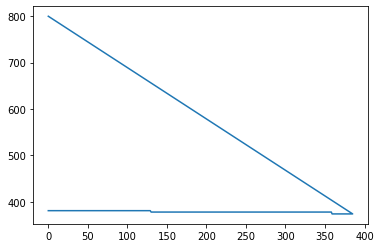

|  386      | -510.0    |  48.11    |  1.596    |  0.5633   |  0.153    |  1.782e+0 |  1.559    |  0.3463   |  21.33    |  0.4599   |  0.3906   |  2.939    |  0.7442   |  2.139    |  4.902    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.10109
    weight_decay: 0.21848298814792774
)
Batch Normalization Momentum:  0.63
Nodes:  24
LR:  0.10109
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.21848298814792774
BATCH_SIZE:  92
Dropout:  0.03
Final Linear Layers:  2
average loss: 0.691456
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4369)
Class:  0  correct:  218.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.4934)
Last epoch:  13
Credit Cost:  -505


Best Score So Far:  -374


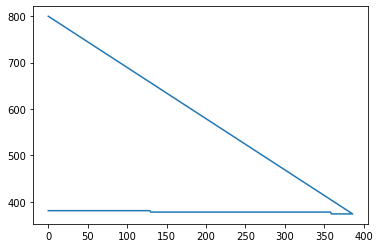

|  387      | -505.0    |  92.39    |  1.186    |  0.6314   |  0.03431  |  1.102e+0 |  2.993    |  0.1011   |  24.94    |  0.7501   |  0.2185   |  2.136    |  0.6387   |  3.426    |  2.811    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.03194
    weight_decay: 0.2407452873227871
)
Batch Normalization Momentum:  0.41
Nodes:  19
LR:  0.03194
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.2407452873227871
BATCH_SIZE:  87
Dropout:  0.15
Final Linear Layers:  3
average loss: 0.693330
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5251)
Class:  0  correct:  262.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6600)
Class:  1  correct:  66.0  of  tensor(100.)
Final percentage:  tensor(0.5925)
Last epoch:  8
Credit Cost:  -407


Best Score So Far:  -374


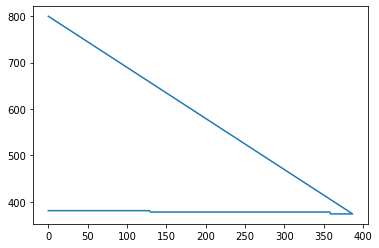

|  388      | -407.0    |  87.85    |  2.638    |  0.4102   |  0.1481   |  1.514e+0 |  3.809    |  0.03194  |  19.15    |  0.4898   |  0.2407   |  2.333    |  0.7617   |  2.615    |  1.374    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.28698
    weight_decay: 0.4865240363773279
)
Batch Normalization Momentum:  0.32
Nodes:  22
LR:  0.28698
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.4865240363773279
BATCH_SIZE:  33
Dropout:  0.14
Final Linear Layers:  2
average loss: 0.692833
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4850)
Class:  0  correct:  242.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4000)
Class:  1  correct:  40.0  of  tensor(100.)
Final percentage:  tensor(0.4425)
Last epoch:  10
Credit Cost:  -557


Best Score So Far:  -374


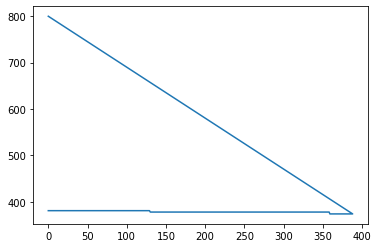

|  389      | -557.0    |  33.15    |  1.041    |  0.3245   |  0.1404   |  1.785e+0 |  2.591    |  0.287    |  22.94    |  0.01838  |  0.4865   |  1.621    |  0.5542   |  2.814    |  2.637    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.52166
    t0: 1000000.0
    weight_decay: 0.5602565010465206
)
Batch Normalization Momentum:  0.26
Nodes:  17
LR:  0.52166
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5602565010465206
BATCH_SIZE:  35
Dropout:  0.07
Final Linear Layers:  3
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


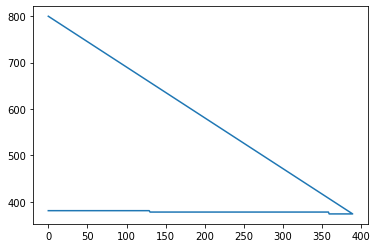

|  390      | -800.0    |  35.03    |  2.152    |  0.26     |  0.07183  |  1.359e+0 |  3.704    |  0.5217   |  17.42    |  0.05264  |  0.5603   |  1.361    |  0.6621   |  3.498    |  9.674    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.50212
    rho: 0.9
    weight_decay: 0.4534890846836155
)
Batch Normalization Momentum:  0.84
Nodes:  21
LR:  0.50212
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4534890846836155
BATCH_SIZE:  19
Dropout:  0.16
Final Linear Layers:  3
average loss: 0.693196
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4910)
Class:  0  correct:  245.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.4705)
Last epoch:  8
Credit Cost:  -529


Best Score So Far:  -374


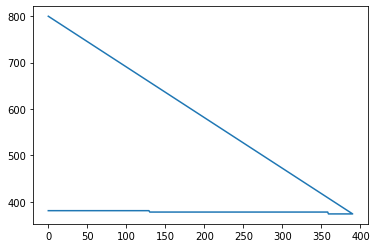

|  391      | -529.0    |  19.73    |  2.041    |  0.8421   |  0.1613   |  1.73e+03 |  3.349    |  0.5021   |  22.0     |  0.8969   |  0.4535   |  2.88     |  0.623    |  3.609    |  6.355    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.33719
    weight_decay: 0.11299997332805053
)
Batch Normalization Momentum:  0.43
Nodes:  22
LR:  0.33719
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.11299997332805053
BATCH_SIZE:  46
Dropout:  0.04
Final Linear Layers:  3
average loss: 22.125221
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5271)
Class:  0  correct:  263.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.5085)
Last epoch:  12
Credit Cost:  -491


Best Score So Far:  -374


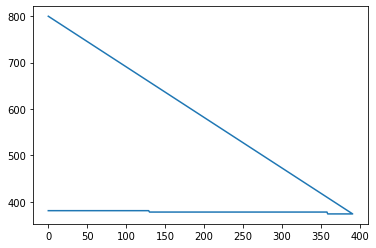

|  392      | -491.0    |  46.7     |  2.619    |  0.4281   |  0.03796  |  1.969e+0 |  3.549    |  0.3372   |  22.12    |  0.9967   |  0.113    |  2.064    |  0.3871   |  2.618    |  1.929    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.34896
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.59
Nodes:  15
LR:  0.34896
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.3011191630392311
BATCH_SIZE:  58
Dropout:  0.2
Final Linear Layers:  3
average loss: 0.692451
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4990)
Class:  0  correct:  249.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4595)
Last epoch:  10
Credit Cost:  -540


Best Score So Far:  -374


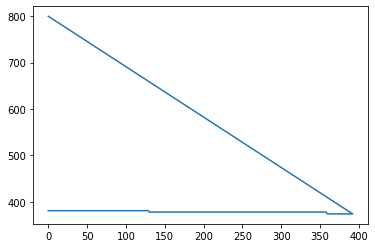

|  393      | -540.0    |  58.65    |  1.918    |  0.5899   |  0.1987   |  1.59e+03 |  3.181    |  0.349    |  15.29    |  0.4968   |  0.3011   |  1.418    |  0.2245   |  2.368    |  4.898    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.47364
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.67
Nodes:  12
LR:  0.47364
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.1520416156639432
BATCH_SIZE:  100
Dropout:  0.05
Final Linear Layers:  3
average loss: 0.692482
Class:  0  accuracy:  tensor(0.5271)
Class:  0  correct:  263.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5185)
Last epoch:  7
Credit Cost:  -481


Best Score So Far:  -374


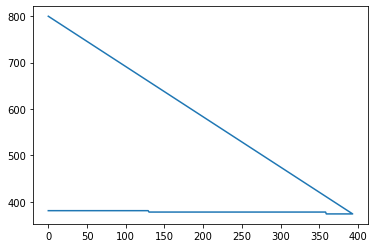

|  394      | -481.0    |  100.6    |  1.838    |  0.6666   |  0.04981  |  1.824e+0 |  3.049    |  0.4736   |  12.78    |  0.6622   |  0.152    |  1.44     |  0.24     |  1.791    |  4.672    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.19301
    t0: 1000000.0
    weight_decay: 0.3225315669984893
)
Batch Normalization Momentum:  0.63
Nodes:  20
LR:  0.19301
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.3225315669984893
BATCH_SIZE:  106
Dropout:  0.04
Final Linear Layers:  3
average loss: 0.691912
Class:  0  accuracy:  tensor(0.4850)
Class:  0  correct:  242.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5575)
Last epoch:  7
Credit Cost:  -441


Best Score So Far:  -374


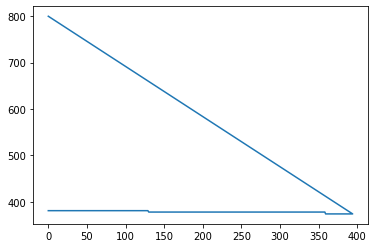

|  395      | -441.0    |  106.8    |  2.885    |  0.6261   |  0.04042  |  1.42e+03 |  3.799    |  0.193    |  20.58    |  0.9343   |  0.3225   |  1.996    |  0.9095   |  3.78     |  9.131    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.07931
    momentum: 0.86
    nesterov: False
    weight_decay: 0.6660211153636268
)
Batch Normalization Momentum:  0.58
Nodes:  8
LR:  0.07931
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6660211153636268
BATCH_SIZE:  67
Dropout:  0.05
Final Linear Layers:  1
average loss: 0.694070
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5311)
Class:  0  correct:  265.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4800)
Class:  1  correct:  48.0  of  tensor(100.)
Final percentage:  tensor(0.5055)
Last epoch:  9
Credit Cost:  -494


Best Score So Far:  -374


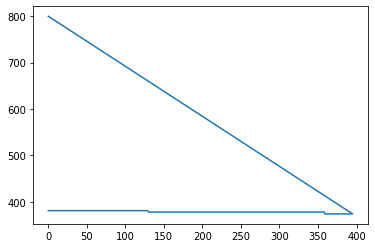

|  396      | -494.0    |  67.69    |  2.273    |  0.5831   |  0.04755  |  1.623e+0 |  1.954    |  0.07931  |  8.45     |  0.314    |  0.666    |  2.972    |  0.8582   |  2.381    |  5.186    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.33199
    weight_decay: 0.022262232199560313
)
Batch Normalization Momentum:  0.98
Nodes:  4
LR:  0.33199
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.022262232199560313
BATCH_SIZE:  98
Dropout:  0.21
Final Linear Layers:  3
average loss: 0.699284
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5150)
Class:  0  correct:  257.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6200)
Class:  1  correct:  62.0  of  tensor(100.)
Final percentage:  tensor(0.5675)
Last epoch:  15
Credit Cost:  -432


Best Score So Far:  -374


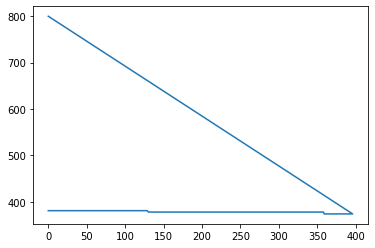

|  397      | -432.0    |  98.83    |  1.196    |  0.9841   |  0.2077   |  1.299e+0 |  3.717    |  0.332    |  4.556    |  0.109    |  0.02226  |  1.43     |  0.0509   |  2.526    |  1.746    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.13891
    weight_decay: 0.019807615686797276
)
Batch Normalization Momentum:  0.55
Nodes:  30
LR:  0.13891
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.019807615686797276
BATCH_SIZE:  58
Dropout:  0.13
Final Linear Layers:  2
average loss: 1.426627
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5371)
Class:  0  correct:  268.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.5485)
Last epoch:  11
Credit Cost:  -451


Best Score So Far:  -374


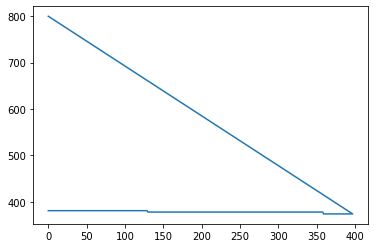

|  398      | -451.0    |  58.95    |  1.47     |  0.5541   |  0.1317   |  1.838e+0 |  2.006    |  0.1389   |  30.2     |  0.4664   |  0.01981  |  1.158    |  0.55     |  1.63     |  2.333    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.33455
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.94
Nodes:  4
LR:  0.33455
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.5686148799899593
BATCH_SIZE:  28
Dropout:  0.04
Final Linear Layers:  3
average loss: 0.693235
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4850)
Class:  0  correct:  242.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5275)
Last epoch:  8
Credit Cost:  -471


Best Score So Far:  -374


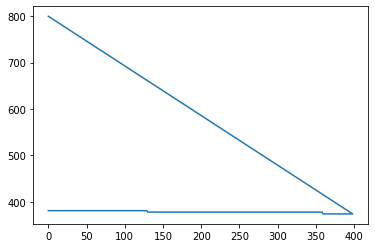

|  399      | -471.0    |  28.25    |  2.482    |  0.9395   |  0.03881  |  1.88e+03 |  3.129    |  0.3345   |  4.011    |  0.7872   |  0.5686   |  2.502    |  0.545    |  2.888    |  4.926    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.53008
    weight_decay: 0.26779153063282063
)
Batch Normalization Momentum:  0.76
Nodes:  3
LR:  0.53008
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.26779153063282063
BATCH_SIZE:  42
Dropout:  0.28
Final Linear Layers:  2
average loss: 7.095239
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5010)
Class:  0  correct:  250.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.4705)
Last epoch:  15
Credit Cost:  -529


Best Score So Far:  -374


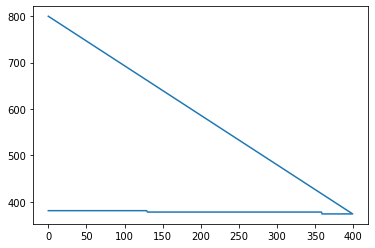

|  400      | -529.0    |  42.17    |  1.413    |  0.7631   |  0.2804   |  1.622e+0 |  2.597    |  0.5301   |  3.344    |  0.3031   |  0.2678   |  1.062    |  0.5147   |  3.812    |  8.167    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.40483
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.78
Nodes:  2
LR:  0.40483
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.10152394132704647
BATCH_SIZE:  70
Dropout:  0.08
Final Linear Layers:  2
average loss: 0.693936
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5010)
Class:  0  correct:  250.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4855)
Last epoch:  13
Credit Cost:  -514


Best Score So Far:  -374


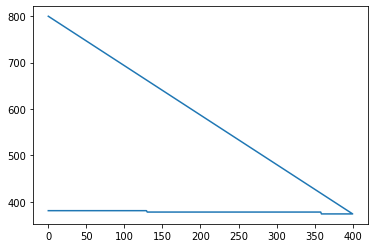

|  401      | -514.0    |  70.35    |  2.346    |  0.7774   |  0.07833  |  1.276e+0 |  2.81     |  0.4048   |  2.108    |  0.855    |  0.1015   |  2.02     |  0.5566   |  1.022    |  4.855    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.17485
    momentum: 0.66
    nesterov: False
    weight_decay: 0.03994765922040371
)
Batch Normalization Momentum:  0.89
Nodes:  14
LR:  0.17485
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.03994765922040371
BATCH_SIZE:  70
Dropout:  0.02
Final Linear Layers:  2
average loss: 0.691271
Class:  0  accuracy:  tensor(0.5150)
Class:  0  correct:  257.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.5475)
Last epoch:  7
Credit Cost:  -452


Best Score So Far:  -374


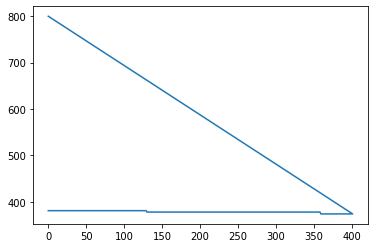

|  402      | -452.0    |  70.18    |  2.375    |  0.8941   |  0.02057  |  1.283e+0 |  2.579    |  0.1749   |  14.6     |  0.9811   |  0.03995  |  2.849    |  0.6613   |  2.491    |  5.178    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.40293
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.17
Nodes:  17
LR:  0.40293
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.40512923768333464
BATCH_SIZE:  73
Dropout:  0.19
Final Linear Layers:  2
average loss: 0.694152
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4850)
Class:  0  correct:  242.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3700)
Class:  1  correct:  37.0  of  tensor(100.)
Final percentage:  tensor(0.4275)
Last epoch:  10
Credit Cost:  -572


Best Score So Far:  -374


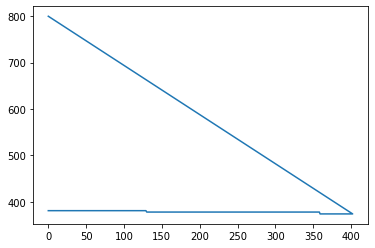

|  403      | -572.0    |  73.31    |  1.58     |  0.1701   |  0.1859   |  1.988e+0 |  2.543    |  0.4029   |  17.59    |  0.2006   |  0.4051   |  2.906    |  0.6855   |  1.082    |  4.264    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.47163
    weight_decay: 0.36640463305130194
)
Batch Normalization Momentum:  0.12
Nodes:  8
LR:  0.47163
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.36640463305130194
BATCH_SIZE:  82
Dropout:  0.28
Final Linear Layers:  3
average loss: 9.879124
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5190)
Class:  0  correct:  259.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6600)
Class:  1  correct:  66.0  of  tensor(100.)
Final percentage:  tensor(0.5895)
Last epoch:  15
Credit Cost:  -410


Best Score So Far:  -374


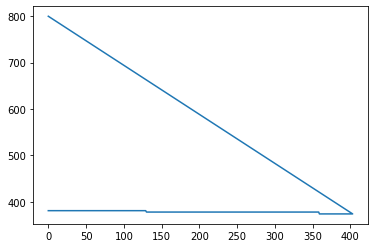

|  404      | -410.0    |  82.6     |  2.128    |  0.1201   |  0.2809   |  1.394e+0 |  3.18     |  0.4716   |  8.39     |  0.6623   |  0.3664   |  1.355    |  0.7113   |  2.616    |  2.925    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.30743
    weight_decay: 0.12501255703817052
)
Batch Normalization Momentum:  0.98
Nodes:  27
LR:  0.30743
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.12501255703817052
BATCH_SIZE:  55
Dropout:  0.16
Final Linear Layers:  1
average loss: 0.693087
Class:  0  accuracy:  tensor(0.4870)
Class:  0  correct:  243.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6600)
Class:  1  correct:  66.0  of  tensor(100.)
Final percentage:  tensor(0.5735)
Last epoch:  7
Credit Cost:  -426


Best Score So Far:  -374


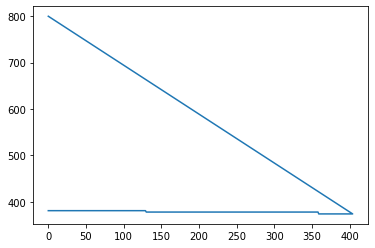

|  405      | -426.0    |  55.84    |  2.355    |  0.9838   |  0.1645   |  1.794e+0 |  1.988    |  0.3074   |  27.05    |  0.9695   |  0.125    |  2.694    |  0.9785   |  2.347    |  3.769    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.28677
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.98
Nodes:  3
LR:  0.28677
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.556522081601894
BATCH_SIZE:  117
Dropout:  0.12
Final Linear Layers:  1
average loss: 0.693950
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4735)
Last epoch:  21
Credit Cost:  -526


Best Score So Far:  -374


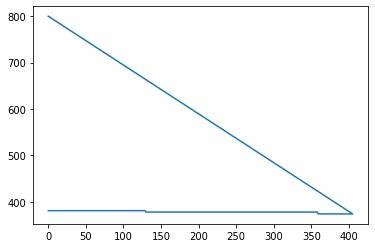

|  406      | -526.0    |  117.1    |  1.438    |  0.9784   |  0.1205   |  1.092e+0 |  1.409    |  0.2868   |  3.828    |  0.2524   |  0.5565   |  2.563    |  0.8027   |  1.138    |  7.89     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.32865
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.39
Nodes:  11
LR:  0.32865
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.4172337424647707
BATCH_SIZE:  104
Dropout:  0.26
Final Linear Layers:  3
average loss: 0.692425
Class:  0  accuracy:  tensor(0.5451)
Class:  0  correct:  272.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.5525)
Last epoch:  7
Credit Cost:  -447


Best Score So Far:  -374


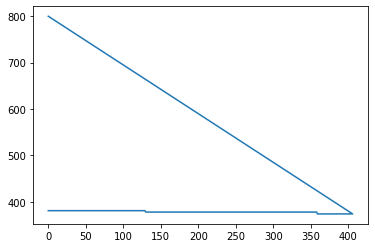

|  407      | -447.0    |  104.0    |  1.032    |  0.3874   |  0.2597   |  1.958e+0 |  3.75     |  0.3286   |  11.3     |  0.5891   |  0.4172   |  2.322    |  0.5849   |  3.595    |  4.362    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.43923
    weight_decay: 0.3809301851438893
)
Batch Normalization Momentum:  0.23
Nodes:  9
LR:  0.43923
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.3809301851438893
BATCH_SIZE:  34
Dropout:  0.05
Final Linear Layers:  3
average loss: 0.694076
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5900)
Class:  1  correct:  59.0  of  tensor(100.)
Final percentage:  tensor(0.5465)
Last epoch:  13
Credit Cost:  -453


Best Score So Far:  -374


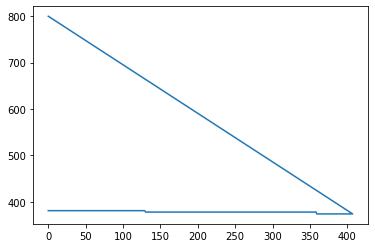

|  408      | -453.0    |  34.26    |  1.041    |  0.2304   |  0.04848  |  1.238e+0 |  3.634    |  0.4392   |  9.302    |  0.7925   |  0.3809   |  1.809    |  0.2037   |  1.929    |  1.712    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.25275
    t0: 1000000.0
    weight_decay: 0.21795973021148266
)
Batch Normalization Momentum:  0.35
Nodes:  21
LR:  0.25275
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.21795973021148266
BATCH_SIZE:  32
Dropout:  0.25
Final Linear Layers:  2
average loss: 0.693406
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4709)
Class:  0  correct:  235.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3800)
Class:  1  correct:  38.0  of  tensor(100.)
Final percentage:  tensor(0.4255)
Last epoch:  10
Credit Cost:  -574


Best Score So Far:  -374


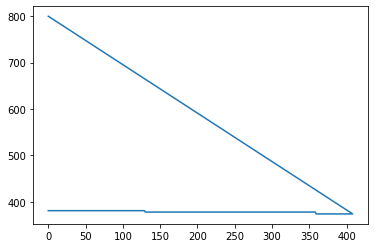

|  409      | -574.0    |  32.97    |  2.325    |  0.3475   |  0.2459   |  1.661e+0 |  2.867    |  0.2527   |  21.35    |  0.8741   |  0.218    |  1.682    |  0.8402   |  2.584    |  9.304    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.41655
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.85
Nodes:  15
LR:  0.41655
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.38561604269693284
BATCH_SIZE:  27
Dropout:  0.03
Final Linear Layers:  3
average loss: 0.693413
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4810)
Class:  0  correct:  240.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.4905)
Last epoch:  14
Credit Cost:  -509


Best Score So Far:  -374


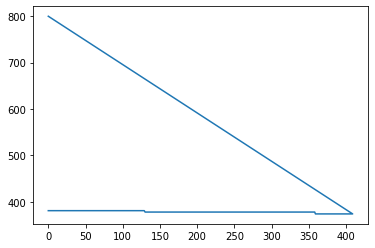

|  410      | -509.0    |  27.26    |  1.428    |  0.8538   |  0.02985  |  1.472e+0 |  3.51     |  0.4165   |  15.87    |  0.1659   |  0.3856   |  2.966    |  0.7971   |  1.164    |  7.391    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.30895
    momentum: 0.0
    nesterov: False
    weight_decay: 0.12546405150216564
)
Batch Normalization Momentum:  0.95
Nodes:  12
LR:  0.30895
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.12546405150216564
BATCH_SIZE:  125
Dropout:  0.07
Final Linear Layers:  1
average loss: 0.691860
Class:  0  accuracy:  tensor(0.4349)
Class:  0  correct:  217.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6500)
Class:  1  correct:  65.0  of  tensor(100.)
Final percentage:  tensor(0.5424)
Last epoch:  7
Credit Cost:  -457


Best Score So Far:  -374


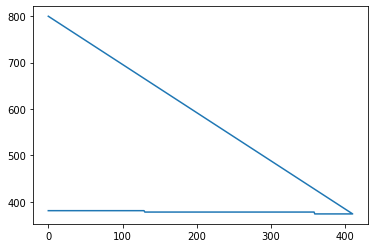

|  411      | -457.0    |  125.1    |  1.385    |  0.9468   |  0.07     |  1.819e+0 |  1.447    |  0.3089   |  12.92    |  0.6703   |  0.1255   |  2.154    |  0.002399 |  2.273    |  5.637    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.33336
    weight_decay: 0.4694045440077468
)
Batch Normalization Momentum:  0.09
Nodes:  5
LR:  0.33336
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.4694045440077468
BATCH_SIZE:  107
Dropout:  0.19
Final Linear Layers:  3
average loss: 0.854043
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5150)
Class:  0  correct:  257.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5400)
Class:  1  correct:  54.0  of  tensor(100.)
Final percentage:  tensor(0.5275)
Last epoch:  15
Credit Cost:  -472


Best Score So Far:  -374


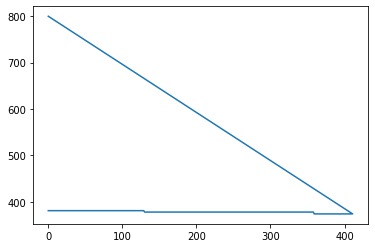

|  412      | -472.0    |  107.9    |  2.508    |  0.09097  |  0.1875   |  1.66e+03 |  3.195    |  0.3334   |  5.221    |  0.6401   |  0.4694   |  1.498    |  0.9388   |  2.353    |  8.792    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4039
    momentum: 0.51
    nesterov: False
    weight_decay: 0.25104049773116355
)
Batch Normalization Momentum:  0.54
Nodes:  2
LR:  0.4039
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.25104049773116355
BATCH_SIZE:  84
Dropout:  0.19
Final Linear Layers:  3
average loss: 0.693139
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


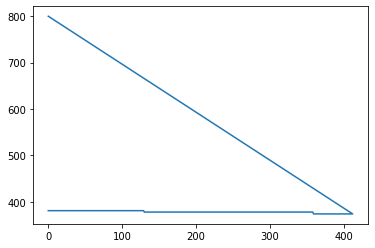

|  413      | -800.0    |  84.98    |  2.227    |  0.5439   |  0.1943   |  1.844e+0 |  3.323    |  0.4039   |  2.955    |  0.009677 |  0.251    |  1.061    |  0.5127   |  1.011    |  5.322    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.56157
    weight_decay: 0.3601319711575491
)
Batch Normalization Momentum:  0.06
Nodes:  4
LR:  0.56157
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.3601319711575491
BATCH_SIZE:  50
Dropout:  0.02
Final Linear Layers:  3
average loss: 18.567137
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5070)
Class:  0  correct:  253.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.5335)
Last epoch:  13
Credit Cost:  -466


Best Score So Far:  -374


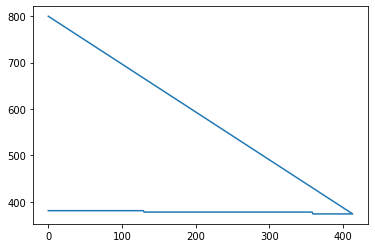

|  414      | -466.0    |  50.82    |  2.905    |  0.0553   |  0.01956  |  1.849e+0 |  3.378    |  0.5616   |  4.347    |  0.6199   |  0.3601   |  1.64     |  0.6047   |  3.745    |  1.562    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.24314
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.4
Nodes:  31
LR:  0.24314
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.2854313004786115
BATCH_SIZE:  85
Dropout:  0.25
Final Linear Layers:  3
average loss: 0.693505
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5331)
Class:  0  correct:  266.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3200)
Class:  1  correct:  32.0  of  tensor(100.)
Final percentage:  tensor(0.4265)
Last epoch:  12
Credit Cost:  -573


Best Score So Far:  -374


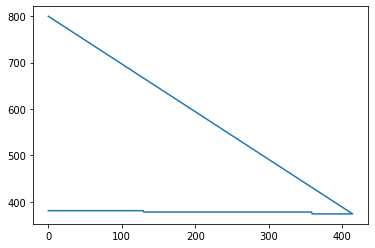

|  415      | -573.0    |  85.81    |  1.567    |  0.4014   |  0.2549   |  1.122e+0 |  3.52     |  0.2431   |  31.52    |  0.9172   |  0.2854   |  1.593    |  0.2187   |  1.651    |  7.911    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.33265
    momentum: 0.54
    nesterov: False
    weight_decay: 0.34988467055864997
)
Batch Normalization Momentum:  0.08
Nodes:  12
LR:  0.33265
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.34988467055864997
BATCH_SIZE:  97
Dropout:  0.07
Final Linear Layers:  2
average loss: 0.692674
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


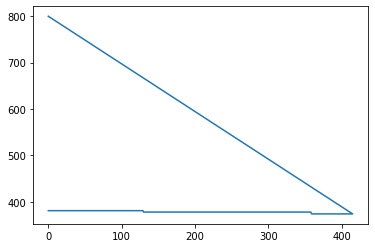

|  416      | -800.0    |  97.67    |  2.947    |  0.08248  |  0.06606  |  1.984e+0 |  2.634    |  0.3326   |  12.46    |  0.7034   |  0.3499   |  1.934    |  0.5443   |  1.075    |  5.776    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.44549
    momentum: 0.68
    nesterov: False
    weight_decay: 0.3577823207377137
)
Batch Normalization Momentum:  0.08
Nodes:  6
LR:  0.44549
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.3577823207377137
BATCH_SIZE:  20
Dropout:  0.27
Final Linear Layers:  2
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


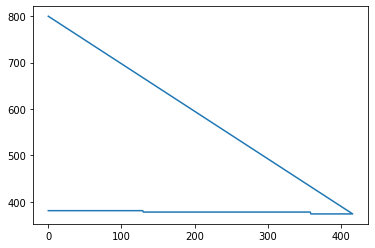

|  417      | -800.0    |  20.49    |  1.913    |  0.08145  |  0.2667   |  1.378e+0 |  2.287    |  0.4455   |  6.673    |  0.5749   |  0.3578   |  1.733    |  0.6765   |  3.376    |  5.204    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.46122
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.45
Nodes:  25
LR:  0.46122
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.3066134615307892
BATCH_SIZE:  81
Dropout:  0.04
Final Linear Layers:  2
average loss: 0.695176
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4870)
Class:  0  correct:  243.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.2900)
Class:  1  correct:  29.0  of  tensor(100.)
Final percentage:  tensor(0.3885)
Last epoch:  8
Credit Cost:  -611


Best Score So Far:  -374


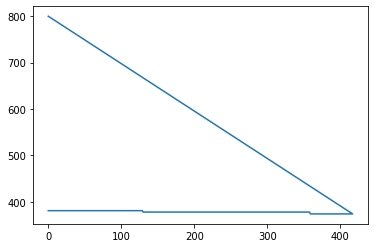

|  418      | -611.0    |  81.79    |  2.816    |  0.4524   |  0.04051  |  1.543e+0 |  2.286    |  0.4612   |  25.93    |  0.1725   |  0.3066   |  1.531    |  0.9451   |  3.801    |  4.905    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.40925
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.59
Nodes:  18
LR:  0.40925
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.1934658402268991
BATCH_SIZE:  57
Dropout:  0.08
Final Linear Layers:  3
average loss: 0.693384
Class:  0  accuracy:  tensor(0.4749)
Class:  0  correct:  237.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.4975)
Last epoch:  7
Credit Cost:  -502


Best Score So Far:  -374


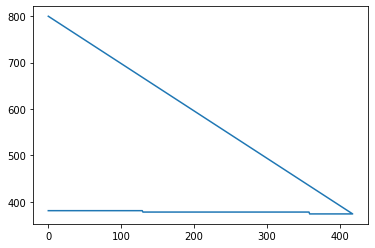

|  419      | -502.0    |  57.45    |  2.485    |  0.59     |  0.07772  |  1.483e+0 |  3.661    |  0.4093   |  18.89    |  0.876    |  0.1935   |  2.984    |  0.1978   |  3.511    |  7.674    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.10493
    t0: 1000000.0
    weight_decay: 0.2749146594494327
)
Batch Normalization Momentum:  0.23
Nodes:  31
LR:  0.10493
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.2749146594494327
BATCH_SIZE:  111
Dropout:  0.15
Final Linear Layers:  3
average loss: 0.692174
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7000)
Class:  1  correct:  70.0  of  tensor(100.)
Final percentage:  tensor(0.6085)
Last epoch:  7
Credit Cost:  -391


Best Score So Far:  -374


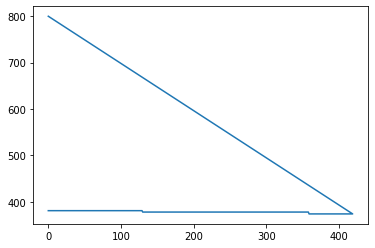

|  420      | -391.0    |  111.1    |  2.164    |  0.2301   |  0.1451   |  1.862e+0 |  3.385    |  0.1049   |  31.77    |  0.03135  |  0.2749   |  2.501    |  0.964    |  1.425    |  9.307    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.34094
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.43
Nodes:  8
LR:  0.34094
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.4048892678597778
BATCH_SIZE:  31
Dropout:  0.24
Final Linear Layers:  1
average loss: 0.695386
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5010)
Class:  0  correct:  250.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3700)
Class:  1  correct:  37.0  of  tensor(100.)
Final percentage:  tensor(0.4355)
Last epoch:  13
Credit Cost:  -564


Best Score So Far:  -374


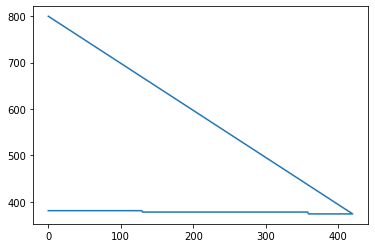

|  421      | -564.0    |  31.16    |  2.1      |  0.4285   |  0.2424   |  1.139e+0 |  1.571    |  0.3409   |  8.299    |  0.8792   |  0.4049   |  2.814    |  0.7567   |  2.42     |  7.225    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.41319
    momentum: 0.64
    nesterov: False
    weight_decay: 0.15348337207496116
)
Batch Normalization Momentum:  0.97
Nodes:  2
LR:  0.41319
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.15348337207496116
BATCH_SIZE:  11
Dropout:  0.04
Final Linear Layers:  1
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


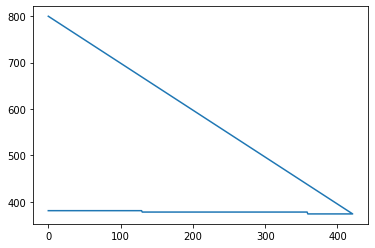

|  422      | -800.0    |  11.42    |  2.256    |  0.9742   |  0.03582  |  1.452e+0 |  1.055    |  0.4132   |  2.583    |  0.4554   |  0.1535   |  2.606    |  0.6392   |  2.992    |  5.944    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.43684
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.87
Nodes:  19
LR:  0.43684
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.5768792464660317
BATCH_SIZE:  35
Dropout:  0.13
Final Linear Layers:  2
average loss: 0.692366
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5090)
Class:  0  correct:  254.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5295)
Last epoch:  9
Credit Cost:  -470


Best Score So Far:  -374


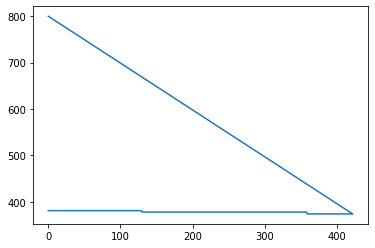

|  423      | -470.0    |  35.06    |  2.623    |  0.8713   |  0.1315   |  1.586e+0 |  2.867    |  0.4368   |  19.73    |  0.806    |  0.5769   |  2.108    |  0.8741   |  1.607    |  4.718    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.22118
    weight_decay: 0.5595736702080041
)
Batch Normalization Momentum:  0.71
Nodes:  9
LR:  0.22118
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.5595736702080041
BATCH_SIZE:  82
Dropout:  0.14
Final Linear Layers:  2
average loss: 0.693106
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5090)
Class:  0  correct:  254.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.4795)
Last epoch:  11
Credit Cost:  -520


Best Score So Far:  -374


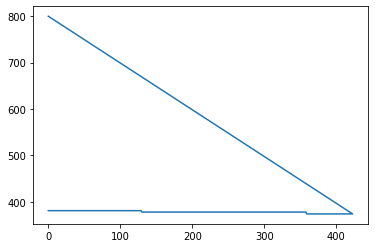

|  424      | -520.0    |  82.13    |  1.204    |  0.7115   |  0.1439   |  1.379e+0 |  2.351    |  0.2212   |  9.186    |  0.915    |  0.5596   |  1.665    |  0.1674   |  1.349    |  8.15     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.0621
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.12
Nodes:  26
LR:  0.0621
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.4454797523758958
BATCH_SIZE:  91
Dropout:  0.27
Final Linear Layers:  1
average loss: 0.689499
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4950)
Class:  0  correct:  247.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5625)
Last epoch:  13
Credit Cost:  -437


Best Score So Far:  -374


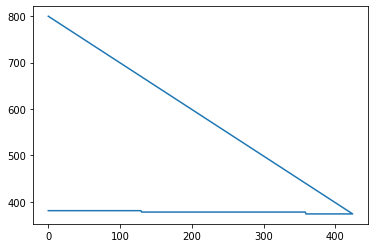

|  425      | -437.0    |  91.05    |  1.15     |  0.1154   |  0.2741   |  1.87e+03 |  1.873    |  0.0621   |  26.27    |  0.02712  |  0.4455   |  1.319    |  0.6847   |  1.502    |  4.138    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.57182
    weight_decay: 0.394509672067836
)
Batch Normalization Momentum:  0.13
Nodes:  24
LR:  0.57182
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.394509672067836
BATCH_SIZE:  19
Dropout:  0.14
Final Linear Layers:  2
average loss: 1.366265
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4950)
Class:  0  correct:  247.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4825)
Last epoch:  12
Credit Cost:  -517


Best Score So Far:  -374


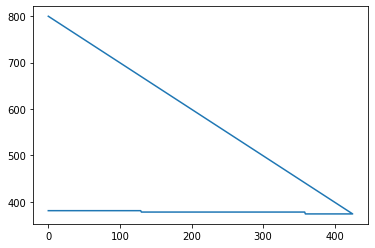

|  426      | -517.0    |  19.14    |  1.571    |  0.1278   |  0.139    |  1.649e+0 |  2.18     |  0.5718   |  24.65    |  0.5443   |  0.3945   |  1.638    |  0.5074   |  3.266    |  1.016    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.3158
    weight_decay: 0.05008503672888724
)
Batch Normalization Momentum:  0.84
Nodes:  21
LR:  0.3158
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.05008503672888724
BATCH_SIZE:  63
Dropout:  0.07
Final Linear Layers:  2
average loss: 0.694281
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4990)
Class:  0  correct:  249.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3700)
Class:  1  correct:  37.0  of  tensor(100.)
Final percentage:  tensor(0.4345)
Last epoch:  32
Credit Cost:  -565


Best Score So Far:  -374


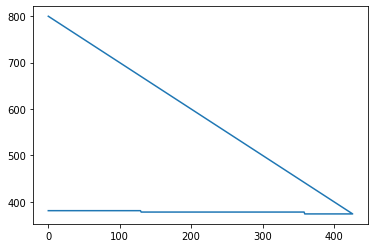

|  427      | -565.0    |  63.59    |  2.799    |  0.841    |  0.0663   |  1.736e+0 |  2.749    |  0.3158   |  21.84    |  0.6318   |  0.05009  |  1.83     |  0.1973   |  3.095    |  3.457    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.0199
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.78
Nodes:  30
LR:  0.0199
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5689948713771066
BATCH_SIZE:  58
Dropout:  0.26
Final Linear Layers:  3
average loss: 0.693979
Class:  0  accuracy:  tensor(0.4729)
Class:  0  correct:  236.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.4865)
Last epoch:  7
Credit Cost:  -513


Best Score So Far:  -374


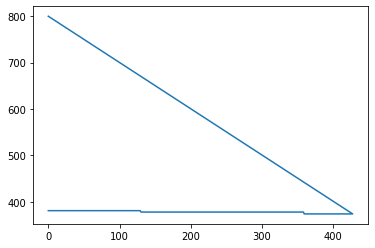

|  428      | -513.0    |  58.12    |  2.635    |  0.7752   |  0.2562   |  1.479e+0 |  3.77     |  0.0199   |  30.15    |  0.3489   |  0.569    |  2.887    |  0.8829   |  3.087    |  7.025    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.57055
    momentum: 0.39
    nesterov: False
    weight_decay: 0.6364283776882912
)
Batch Normalization Momentum:  0.1
Nodes:  19
LR:  0.57055
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.6364283776882912
BATCH_SIZE:  124
Dropout:  0.01
Final Linear Layers:  1
average loss: 0.693168
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4549)
Class:  0  correct:  227.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4375)
Last epoch:  8
Credit Cost:  -562


Best Score So Far:  -374


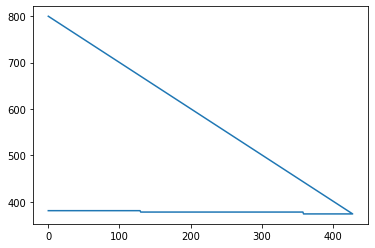

|  429      | -562.0    |  124.7    |  1.926    |  0.103    |  0.007244 |  1.881e+0 |  1.078    |  0.5705   |  19.1     |  0.6573   |  0.6364   |  2.795    |  0.3869   |  2.831    |  5.691    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.15735
    weight_decay: 0.6873313914709038
)
Batch Normalization Momentum:  0.62
Nodes:  6
LR:  0.15735
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.6873313914709038
BATCH_SIZE:  105
Dropout:  0.13
Final Linear Layers:  3
average loss: 0.691929
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5335)
Last epoch:  11
Credit Cost:  -466


Best Score So Far:  -374


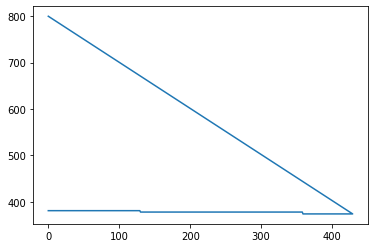

|  430      | -466.0    |  105.3    |  1.112    |  0.6207   |  0.1289   |  1.861e+0 |  3.057    |  0.1574   |  6.027    |  0.5413   |  0.6873   |  1.696    |  0.9855   |  2.549    |  2.711    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.21437
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.03
Nodes:  5
LR:  0.21437
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.04433180166721803
BATCH_SIZE:  7
Dropout:  0.18
Final Linear Layers:  3
average loss: 0.693855
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5135)
Last epoch:  17
Credit Cost:  -486


Best Score So Far:  -374


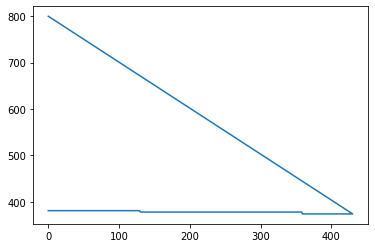

|  431      | -486.0    |  7.796    |  1.603    |  0.03473  |  0.177    |  1.702e+0 |  3.003    |  0.2144   |  5.349    |  0.641    |  0.04433  |  2.282    |  0.8269   |  1.171    |  4.199    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.41852
    weight_decay: 0.42767530479336024
)
Batch Normalization Momentum:  0.2
Nodes:  12
LR:  0.41852
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.42767530479336024
BATCH_SIZE:  80
Dropout:  0.19
Final Linear Layers:  3
average loss: 0.693102
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


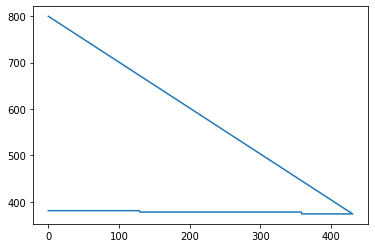

|  432      | -800.0    |  80.72    |  2.271    |  0.196    |  0.187    |  1.558e+0 |  3.648    |  0.4185   |  12.93    |  0.2259   |  0.4277   |  1.509    |  0.07506  |  3.46     |  3.049    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.43919
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.1
Nodes:  31
LR:  0.43919
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4898370686562694
BATCH_SIZE:  51
Dropout:  0.29
Final Linear Layers:  3
average loss: 0.691660
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5010)
Class:  0  correct:  250.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5105)
Last epoch:  11
Credit Cost:  -489


Best Score So Far:  -374


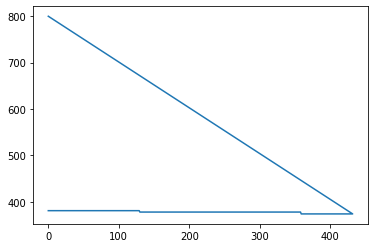

|  433      | -489.0    |  51.06    |  2.685    |  0.1021   |  0.2908   |  1.523e+0 |  3.013    |  0.4392   |  31.43    |  0.5527   |  0.4898   |  2.359    |  0.6239   |  3.39     |  4.107    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.5401
    weight_decay: 0.04214643998910074
)
Batch Normalization Momentum:  0.9
Nodes:  2
LR:  0.5401
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.04214643998910074
BATCH_SIZE:  63
Dropout:  0.17
Final Linear Layers:  1
average loss: 0.693973
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4649)
Class:  0  correct:  232.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5175)
Last epoch:  28
Credit Cost:  -482


Best Score So Far:  -374


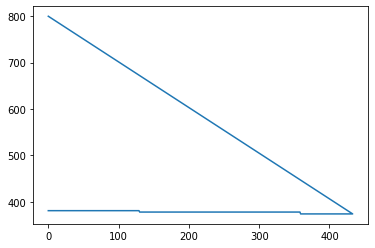

|  434      | -482.0    |  63.75    |  1.155    |  0.901    |  0.1678   |  1.525e+0 |  1.798    |  0.5401   |  2.417    |  0.09781  |  0.04215  |  1.479    |  0.4919   |  2.386    |  3.432    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.20663
    t0: 1000000.0
    weight_decay: 0.2574212856813155
)
Batch Normalization Momentum:  0.36
Nodes:  17
LR:  0.20663
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.2574212856813155
BATCH_SIZE:  72
Dropout:  0.05
Final Linear Layers:  1
average loss: 0.693405
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5070)
Class:  0  correct:  253.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5300)
Class:  1  correct:  53.0  of  tensor(100.)
Final percentage:  tensor(0.5185)
Last epoch:  10
Credit Cost:  -481


Best Score So Far:  -374


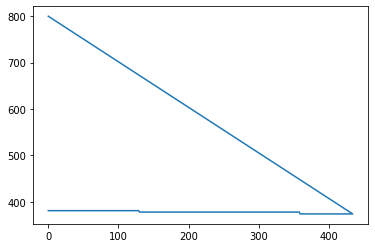

|  435      | -481.0    |  72.83    |  1.452    |  0.362    |  0.05099  |  1.664e+0 |  1.244    |  0.2066   |  17.93    |  0.5494   |  0.2574   |  2.281    |  0.1628   |  3.166    |  9.318    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.32429
    t0: 1000000.0
    weight_decay: 0.6703309508773002
)
Batch Normalization Momentum:  0.26
Nodes:  6
LR:  0.32429
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6703309508773002
BATCH_SIZE:  126
Dropout:  0.01
Final Linear Layers:  2
average loss: 0.693566
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4248)
Class:  0  correct:  212.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.4424)
Last epoch:  10
Credit Cost:  -557


Best Score So Far:  -374


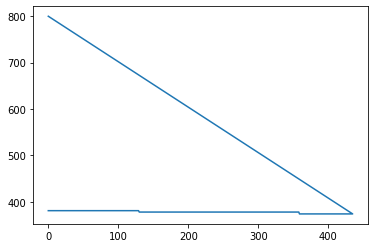

|  436      | -557.0    |  126.7    |  2.748    |  0.2583   |  0.01143  |  1.974e+0 |  2.666    |  0.3243   |  6.394    |  0.9117   |  0.6703   |  2.711    |  0.6858   |  2.154    |  9.331    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.05629
    rho: 0.9
    weight_decay: 0.37837495276510374
)
Batch Normalization Momentum:  0.58
Nodes:  24
LR:  0.05629
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.37837495276510374
BATCH_SIZE:  109
Dropout:  0.02
Final Linear Layers:  1
average loss: 0.691720
Class:  0  accuracy:  tensor(0.5952)
Class:  0  correct:  297.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5300)
Class:  1  correct:  53.0  of  tensor(100.)
Final percentage:  tensor(0.5626)
Last epoch:  7
Credit Cost:  -437


Best Score So Far:  -374


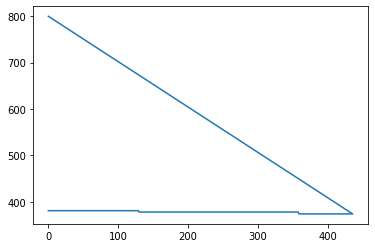

|  437      | -437.0    |  110.0    |  2.667    |  0.5782   |  0.02099  |  1.026e+0 |  1.675    |  0.05629  |  24.35    |  0.8504   |  0.3784   |  2.216    |  0.4684   |  3.796    |  6.509    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.31262
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.38
Nodes:  16
LR:  0.31262
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.2193493758066885
BATCH_SIZE:  80
Dropout:  0.02
Final Linear Layers:  3
average loss: 0.692053
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5671)
Class:  0  correct:  283.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5386)
Last epoch:  12
Credit Cost:  -461


Best Score So Far:  -374


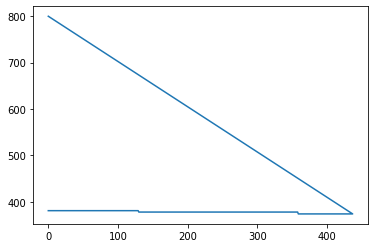

|  438      | -461.0    |  80.92    |  2.707    |  0.3799   |  0.01923  |  1.74e+03 |  3.524    |  0.3126   |  16.03    |  0.09943  |  0.2193   |  1.373    |  0.74     |  1.479    |  7.155    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.03018
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.7
Nodes:  8
LR:  0.03018
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.09888201410553449
BATCH_SIZE:  58
Dropout:  0.24
Final Linear Layers:  2
average loss: 0.696163
Class:  0  accuracy:  tensor(0.4689)
Class:  0  correct:  234.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.4645)
Last epoch:  7
Credit Cost:  -535


Best Score So Far:  -374


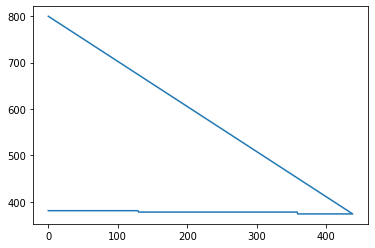

|  439      | -535.0    |  58.64    |  1.008    |  0.6953   |  0.2379   |  1.338e+0 |  2.427    |  0.03018  |  8.797    |  0.6959   |  0.09888  |  1.459    |  0.6878   |  1.204    |  7.557    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.12252
    weight_decay: 0.4305992303516737
)
Batch Normalization Momentum:  0.32
Nodes:  17
LR:  0.12252
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.4305992303516737
BATCH_SIZE:  81
Dropout:  0.16
Final Linear Layers:  1
average loss: 0.698235
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4329)
Class:  0  correct:  216.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5300)
Class:  1  correct:  53.0  of  tensor(100.)
Final percentage:  tensor(0.4814)
Last epoch:  9
Credit Cost:  -518


Best Score So Far:  -374


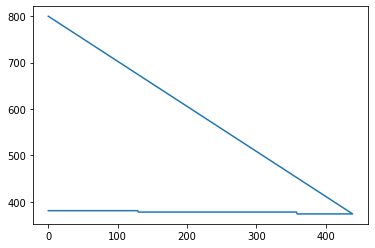

|  440      | -518.0    |  81.8     |  2.298    |  0.3183   |  0.1615   |  1.079e+0 |  1.851    |  0.1225   |  17.34    |  0.6519   |  0.4306   |  1.266    |  0.1784   |  2.487    |  1.18     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.02635
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.16
Nodes:  26
LR:  0.02635
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.658178846629067
BATCH_SIZE:  95
Dropout:  0.28
Final Linear Layers:  3
average loss: 0.694725
Class:  0  accuracy:  tensor(0.5351)
Class:  0  correct:  267.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3900)
Class:  1  correct:  39.0  of  tensor(100.)
Final percentage:  tensor(0.4625)
Last epoch:  7
Credit Cost:  -537


Best Score So Far:  -374


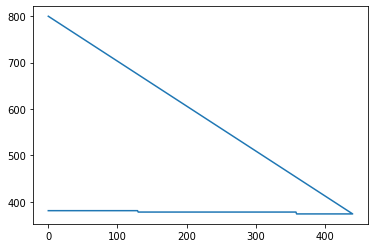

|  441      | -537.0    |  95.28    |  2.179    |  0.1572   |  0.2752   |  1.544e+0 |  3.983    |  0.02635  |  26.39    |  0.07823  |  0.6582   |  1.719    |  0.6599   |  3.137    |  7.411    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.00569
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.22
Nodes:  3
LR:  0.00569
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6116359790773163
BATCH_SIZE:  90
Dropout:  0.24
Final Linear Layers:  3
average loss: 0.694558
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5050)
Class:  0  correct:  252.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.2900)
Class:  1  correct:  29.0  of  tensor(100.)
Final percentage:  tensor(0.3975)
Last epoch:  11
Credit Cost:  -602


Best Score So Far:  -374


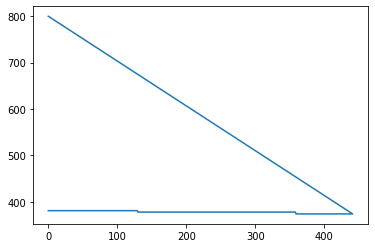

|  442      | -602.0    |  90.05    |  1.023    |  0.2183   |  0.2392   |  1.787e+0 |  3.397    |  0.005689 |  3.24     |  0.07468  |  0.6116   |  1.95     |  0.7244   |  1.653    |  7.022    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.0817
    rho: 0.9
    weight_decay: 0.0783792199665777
)
Batch Normalization Momentum:  0.28
Nodes:  18
LR:  0.0817
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.0783792199665777
BATCH_SIZE:  59
Dropout:  0.03
Final Linear Layers:  3
average loss: 0.693667
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5050)
Class:  0  correct:  252.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5300)
Class:  1  correct:  53.0  of  tensor(100.)
Final percentage:  tensor(0.5175)
Last epoch:  49
Credit Cost:  -482


Best Score So Far:  -374


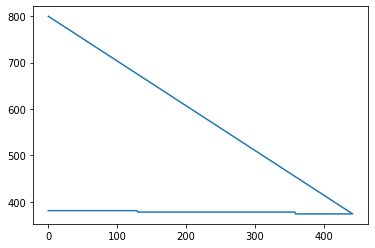

|  443      | -482.0    |  59.06    |  2.967    |  0.2834   |  0.03255  |  1.547e+0 |  3.037    |  0.0817   |  18.18    |  0.7439   |  0.07838  |  2.563    |  0.5387   |  1.031    |  6.296    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.1331
    t0: 1000000.0
    weight_decay: 0.2299028556443626
)
Batch Normalization Momentum:  0.98
Nodes:  30
LR:  0.1331
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.2299028556443626
BATCH_SIZE:  103
Dropout:  0.12
Final Linear Layers:  3
average loss: 0.692367
Class:  0  accuracy:  tensor(0.5591)
Class:  0  correct:  279.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.5146)
Last epoch:  7
Credit Cost:  -484


Best Score So Far:  -374


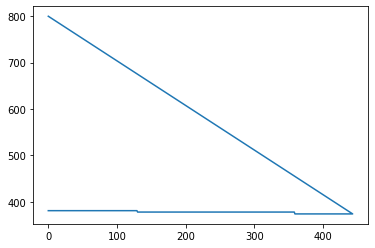

|  444      | -484.0    |  103.8    |  2.972    |  0.9814   |  0.1242   |  1.037e+0 |  3.902    |  0.1331   |  30.65    |  0.9644   |  0.2299   |  2.518    |  0.6256   |  3.531    |  9.58     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.37093
    weight_decay: 0.08547848544458897
)
Batch Normalization Momentum:  0.72
Nodes:  4
LR:  0.37093
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.08547848544458897
BATCH_SIZE:  29
Dropout:  0.18
Final Linear Layers:  2
average loss: 0.699717
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4689)
Class:  0  correct:  234.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4695)
Last epoch:  9
Credit Cost:  -530


Best Score So Far:  -374


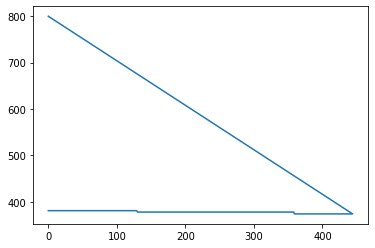

|  445      | -530.0    |  29.52    |  1.815    |  0.7213   |  0.177    |  1.941e+0 |  2.336    |  0.3709   |  4.475    |  0.231    |  0.08548  |  2.526    |  0.01908  |  3.814    |  8.515    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.53404
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.26
Nodes:  18
LR:  0.53404
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.3224218310052301
BATCH_SIZE:  88
Dropout:  0.04
Final Linear Layers:  1
average loss: 0.693128
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4910)
Class:  0  correct:  245.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5005)
Last epoch:  9
Credit Cost:  -499


Best Score So Far:  -374


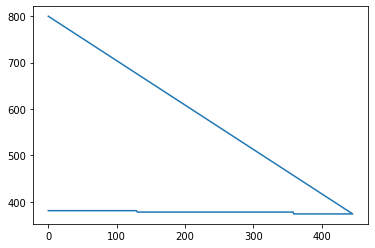

|  446      | -499.0    |  88.2     |  1.057    |  0.2553   |  0.04088  |  1.711e+0 |  1.208    |  0.534    |  18.63    |  0.1042   |  0.3224   |  1.283    |  0.4189   |  3.134    |  7.26     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.23167
    rho: 0.9
    weight_decay: 0.3543321317193579
)
Batch Normalization Momentum:  0.08
Nodes:  26
LR:  0.23167
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.3543321317193579
BATCH_SIZE:  47
Dropout:  0.03
Final Linear Layers:  1
average loss: 0.693362
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4890)
Class:  0  correct:  244.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5495)
Last epoch:  11
Credit Cost:  -450


Best Score So Far:  -374


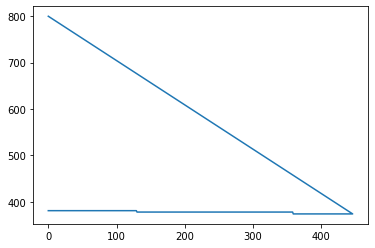

|  447      | -450.0    |  47.17    |  1.694    |  0.07536  |  0.02625  |  1.05e+03 |  1.223    |  0.2317   |  26.49    |  0.3415   |  0.3543   |  2.241    |  0.5794   |  1.4      |  6.569    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.42668
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.67
Nodes:  8
LR:  0.42668
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.17473605640834214
BATCH_SIZE:  68
Dropout:  0.14
Final Linear Layers:  1
average loss: 0.695043
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4890)
Class:  0  correct:  244.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.4745)
Last epoch:  12
Credit Cost:  -525


Best Score So Far:  -374


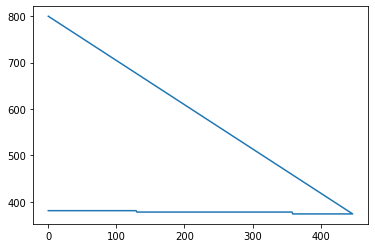

|  448      | -525.0    |  68.77    |  2.495    |  0.6689   |  0.1437   |  1.956e+0 |  1.78     |  0.4267   |  8.049    |  0.6633   |  0.1747   |  1.41     |  0.3665   |  2.521    |  7.122    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.08182
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.75
Nodes:  16
LR:  0.08182
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.47267139324029184
BATCH_SIZE:  42
Dropout:  0.1
Final Linear Layers:  1
average loss: 0.695270
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5090)
Class:  0  correct:  254.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3600)
Class:  1  correct:  36.0  of  tensor(100.)
Final percentage:  tensor(0.4345)
Last epoch:  10
Credit Cost:  -565


Best Score So Far:  -374


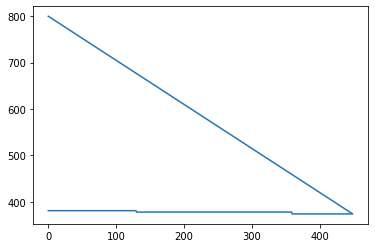

|  449      | -565.0    |  42.39    |  1.761    |  0.7533   |  0.09901  |  1.064e+0 |  1.138    |  0.08182  |  16.09    |  0.3843   |  0.4727   |  1.19     |  0.1602   |  3.898    |  4.816    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.29273
    weight_decay: 0.42629790261955036
)
Batch Normalization Momentum:  0.97
Nodes:  16
LR:  0.29273
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.42629790261955036
BATCH_SIZE:  117
Dropout:  0.04
Final Linear Layers:  3
average loss: 0.692923
Class:  0  accuracy:  tensor(0.4990)
Class:  0  correct:  249.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3900)
Class:  1  correct:  39.0  of  tensor(100.)
Final percentage:  tensor(0.4445)
Last epoch:  7
Credit Cost:  -555


Best Score So Far:  -374


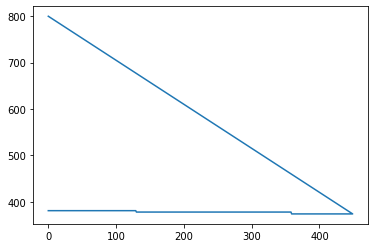

|  450      | -555.0    |  117.6    |  1.466    |  0.9727   |  0.03795  |  1.78e+03 |  3.932    |  0.2927   |  16.7     |  0.1758   |  0.4263   |  1.483    |  0.7096   |  2.417    |  3.089    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.03268
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.1
Nodes:  2
LR:  0.03268
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6556790310208787
BATCH_SIZE:  61
Dropout:  0.03
Final Linear Layers:  3
average loss: 0.694144
Class:  0  accuracy:  tensor(0.4248)
Class:  0  correct:  212.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.4624)
Last epoch:  7
Credit Cost:  -537


Best Score So Far:  -374


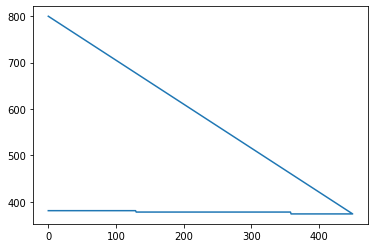

|  451      | -537.0    |  61.12    |  1.049    |  0.09616  |  0.03044  |  1.389e+0 |  3.141    |  0.03268  |  2.375    |  0.1482   |  0.6557   |  2.723    |  0.3985   |  1.482    |  4.19     |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.46743
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.47
Nodes:  27
LR:  0.46743
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6576683533441431
BATCH_SIZE:  119
Dropout:  0.12
Final Linear Layers:  3
average loss: 0.693166
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4549)
Class:  0  correct:  227.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.4875)
Last epoch:  11
Credit Cost:  -512


Best Score So Far:  -374


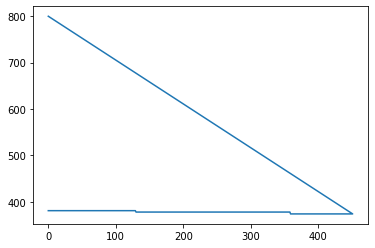

|  452      | -512.0    |  119.9    |  2.281    |  0.4664   |  0.1207   |  1.897e+0 |  3.911    |  0.4674   |  27.0     |  0.3075   |  0.6577   |  1.901    |  0.1775   |  2.783    |  7.15     |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.20167
    weight_decay: 0.38422283420532216
)
Batch Normalization Momentum:  0.7
Nodes:  22
LR:  0.20167
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.38422283420532216
BATCH_SIZE:  58
Dropout:  0.08
Final Linear Layers:  2
average loss: 0.732715
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4990)
Class:  0  correct:  249.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5245)
Last epoch:  9
Credit Cost:  -474


Best Score So Far:  -374


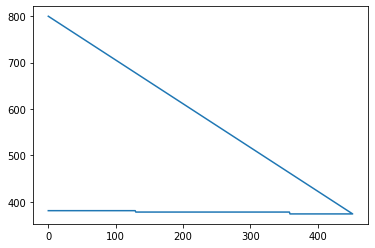

|  453      | -474.0    |  58.23    |  1.743    |  0.6973   |  0.07792  |  1.686e+0 |  2.719    |  0.2017   |  22.3     |  0.04381  |  0.3842   |  2.185    |  0.2843   |  2.065    |  8.759    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.26853
    rho: 0.9
    weight_decay: 0.062043641287665326
)
Batch Normalization Momentum:  0.1
Nodes:  3
LR:  0.26853
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.062043641287665326
BATCH_SIZE:  80
Dropout:  0.07
Final Linear Layers:  3
average loss: 0.696142
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4810)
Class:  0  correct:  240.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3100)
Class:  1  correct:  31.0  of  tensor(100.)
Final percentage:  tensor(0.3955)
Last epoch:  51
Credit Cost:  -604


Best Score So Far:  -374


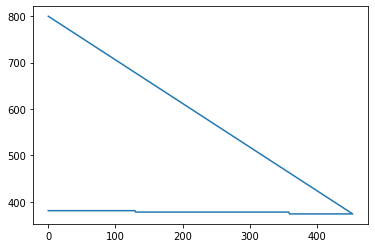

|  454      | -604.0    |  80.8     |  2.273    |  0.1036   |  0.07138  |  1.719e+0 |  3.091    |  0.2685   |  3.178    |  0.0513   |  0.06204  |  2.72     |  0.1347   |  2.968    |  6.187    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.43655
    rho: 0.9
    weight_decay: 0.06184096711330121
)
Batch Normalization Momentum:  0.18
Nodes:  11
LR:  0.43655
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.06184096711330121
BATCH_SIZE:  94
Dropout:  0.22
Final Linear Layers:  2
average loss: 0.692133
Class:  0  accuracy:  tensor(0.5511)
Class:  0  correct:  275.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5400)
Class:  1  correct:  54.0  of  tensor(100.)
Final percentage:  tensor(0.5456)
Last epoch:  7
Credit Cost:  -454


Best Score So Far:  -374


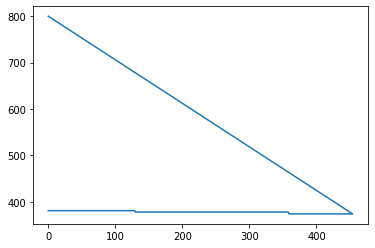

|  455      | -454.0    |  94.1     |  2.159    |  0.1776   |  0.2202   |  1.595e+0 |  2.633    |  0.4365   |  11.42    |  0.07147  |  0.06184  |  1.652    |  0.2294   |  3.237    |  6.463    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.09092
    rho: 0.9
    weight_decay: 0.689348939126313
)
Batch Normalization Momentum:  0.91
Nodes:  3
LR:  0.09092
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.689348939126313
BATCH_SIZE:  15
Dropout:  0.25
Final Linear Layers:  3
average loss: 0.694496
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4930)
Class:  0  correct:  246.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3400)
Class:  1  correct:  34.0  of  tensor(100.)
Final percentage:  tensor(0.4165)
Last epoch:  17
Credit Cost:  -583


Best Score So Far:  -374


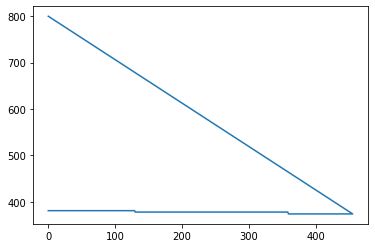

|  456      | -583.0    |  15.83    |  2.433    |  0.9069   |  0.2473   |  1.673e+0 |  3.322    |  0.09092  |  3.965    |  0.7475   |  0.6893   |  1.478    |  0.5563   |  1.242    |  6.045    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.58612
    rho: 0.9
    weight_decay: 0.28703675972436915
)
Batch Normalization Momentum:  0.56
Nodes:  15
LR:  0.58612
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.28703675972436915
BATCH_SIZE:  59
Dropout:  0.2
Final Linear Layers:  3
average loss: 0.693730
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4770)
Class:  0  correct:  238.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3700)
Class:  1  correct:  37.0  of  tensor(100.)
Final percentage:  tensor(0.4235)
Last epoch:  13
Credit Cost:  -576


Best Score So Far:  -374


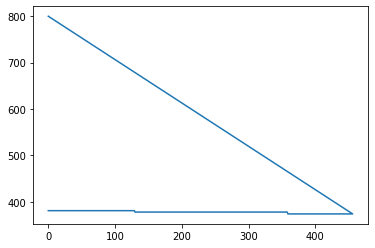

|  457      | -576.0    |  59.85    |  1.479    |  0.5597   |  0.1962   |  1.912e+0 |  3.34     |  0.5861   |  15.28    |  0.1417   |  0.287    |  2.577    |  0.2089   |  1.53     |  6.799    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01293
    weight_decay: 0.5108763464557693
)
Batch Normalization Momentum:  0.69
Nodes:  5
LR:  0.01293
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.5108763464557693
BATCH_SIZE:  121
Dropout:  0.12
Final Linear Layers:  1
average loss: 0.693351
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4409)
Class:  0  correct:  220.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6600)
Class:  1  correct:  66.0  of  tensor(100.)
Final percentage:  tensor(0.5504)
Last epoch:  9
Credit Cost:  -449


Best Score So Far:  -374


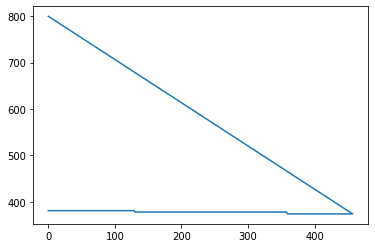

|  458      | -449.0    |  121.4    |  1.814    |  0.6899   |  0.1212   |  1.35e+03 |  1.398    |  0.01293  |  5.59     |  0.4444   |  0.5109   |  1.107    |  0.2195   |  1.093    |  8.492    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.09936
    weight_decay: 0.21436377796847708
)
Batch Normalization Momentum:  0.78
Nodes:  3
LR:  0.09936
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.21436377796847708
BATCH_SIZE:  51
Dropout:  0.08
Final Linear Layers:  3
average loss: 0.693597
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4669)
Class:  0  correct:  233.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6600)
Class:  1  correct:  66.0  of  tensor(100.)
Final percentage:  tensor(0.5635)
Last epoch:  8
Credit Cost:  -436


Best Score So Far:  -374


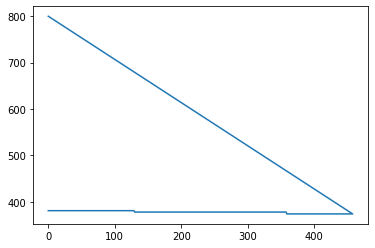

|  459      | -436.0    |  51.35    |  1.566    |  0.7758   |  0.08367  |  1.281e+0 |  3.796    |  0.09936  |  3.137    |  0.9551   |  0.2144   |  1.824    |  0.7888   |  2.065    |  1.943    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.43612
    t0: 1000000.0
    weight_decay: 0.6376614402926893
)
Batch Normalization Momentum:  0.2
Nodes:  4
LR:  0.43612
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.6376614402926893
BATCH_SIZE:  101
Dropout:  0.04
Final Linear Layers:  1
average loss: 0.693143
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


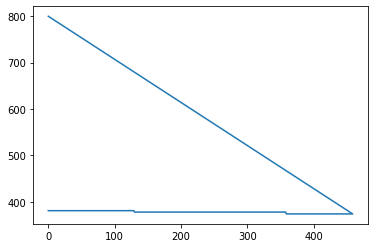

|  460      | -800.0    |  101.8    |  1.258    |  0.1961   |  0.04191  |  1.222e+0 |  1.704    |  0.4361   |  4.857    |  0.6679   |  0.6377   |  2.254    |  0.3335   |  3.51     |  9.078    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.31224
    weight_decay: 0.5456403965903093
)
Batch Normalization Momentum:  0.57
Nodes:  30
LR:  0.31224
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5456403965903093
BATCH_SIZE:  65
Dropout:  0.04
Final Linear Layers:  3
average loss: 6.444511
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4790)
Class:  0  correct:  239.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6700)
Class:  1  correct:  67.0  of  tensor(100.)
Final percentage:  tensor(0.5745)
Last epoch:  17
Credit Cost:  -425


Best Score So Far:  -374


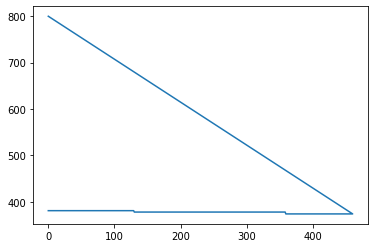

|  461      | -425.0    |  65.19    |  2.121    |  0.5749   |  0.03983  |  1.373e+0 |  3.427    |  0.3122   |  30.19    |  0.6156   |  0.5456   |  1.494    |  0.5537   |  3.424    |  2.373    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.19626
    weight_decay: 0.22895166491550914
)
Batch Normalization Momentum:  0.19
Nodes:  16
LR:  0.19626
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.22895166491550914
BATCH_SIZE:  70
Dropout:  0.19
Final Linear Layers:  3
average loss: 0.787285
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5471)
Class:  0  correct:  273.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5285)
Last epoch:  12
Credit Cost:  -471


Best Score So Far:  -374


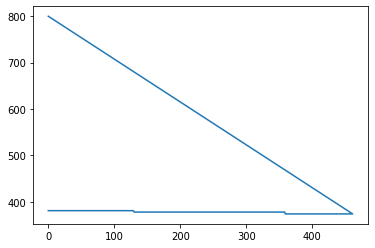

|  462      | -471.0    |  70.98    |  2.214    |  0.1852   |  0.1911   |  1.068e+0 |  3.331    |  0.1963   |  16.48    |  0.3825   |  0.229    |  2.965    |  0.8702   |  1.904    |  2.444    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.51558
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.64
Nodes:  6
LR:  0.51558
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.06558574907334051
BATCH_SIZE:  69
Dropout:  0.07
Final Linear Layers:  1
average loss: 0.693215
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5050)
Class:  0  correct:  252.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5575)
Last epoch:  16
Credit Cost:  -442


Best Score So Far:  -374


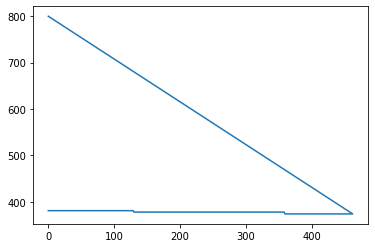

|  463      | -442.0    |  69.63    |  1.275    |  0.6433   |  0.06989  |  1.097e+0 |  1.066    |  0.5156   |  6.281    |  0.4031   |  0.06559  |  1.235    |  0.3711   |  1.495    |  7.463    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.36085
    weight_decay: 0.3802569605887154
)
Batch Normalization Momentum:  0.83
Nodes:  22
LR:  0.36085
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.3802569605887154
BATCH_SIZE:  19
Dropout:  0.02
Final Linear Layers:  2
average loss: 0.739449
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5411)
Class:  0  correct:  270.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.5155)
Last epoch:  10
Credit Cost:  -484


Best Score So Far:  -374


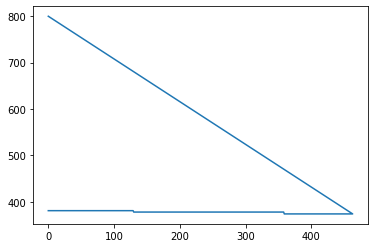

|  464      | -484.0    |  19.61    |  2.47     |  0.833    |  0.0248   |  1.04e+03 |  2.476    |  0.3609   |  22.52    |  0.4783   |  0.3803   |  2.094    |  0.7066   |  1.467    |  1.195    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01514
    weight_decay: 0.6186385743277738
)
Batch Normalization Momentum:  0.02
Nodes:  21
LR:  0.01514
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6186385743277738
BATCH_SIZE:  66
Dropout:  0.18
Final Linear Layers:  3
average loss: 0.693186
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4910)
Class:  0  correct:  245.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.4605)
Last epoch:  9
Credit Cost:  -539


Best Score So Far:  -374


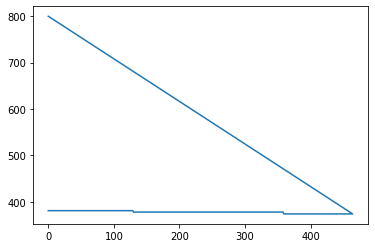

|  465      | -539.0    |  67.0     |  2.898    |  0.0249   |  0.1838   |  1.494e+0 |  3.692    |  0.01514  |  21.79    |  0.6559   |  0.6186   |  2.067    |  0.6837   |  2.234    |  8.431    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.25459
    weight_decay: 0.36387610394964276
)
Batch Normalization Momentum:  0.14
Nodes:  22
LR:  0.25459
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.36387610394964276
BATCH_SIZE:  88
Dropout:  0.05
Final Linear Layers:  1
average loss: 4.006793
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4970)
Class:  0  correct:  248.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5335)
Last epoch:  18
Credit Cost:  -466


Best Score So Far:  -374


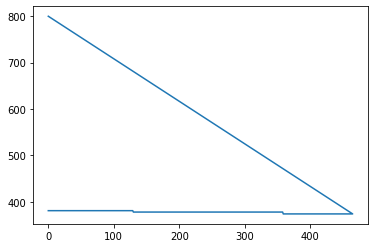

|  466      | -466.0    |  88.94    |  1.215    |  0.1385   |  0.04742  |  1.121e+0 |  1.689    |  0.2546   |  22.12    |  0.3369   |  0.3639   |  2.634    |  0.8757   |  3.106    |  8.502    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.29692
    t0: 1000000.0
    weight_decay: 0.6121116923046392
)
Batch Normalization Momentum:  0.91
Nodes:  20
LR:  0.29692
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.6121116923046392
BATCH_SIZE:  42
Dropout:  0.01
Final Linear Layers:  1
average loss: 0.693158
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4529)
Class:  0  correct:  226.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.4815)
Last epoch:  8
Credit Cost:  -518


Best Score So Far:  -374


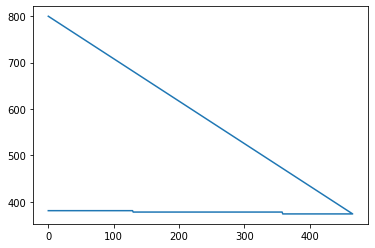

|  467      | -518.0    |  42.33    |  2.573    |  0.9075   |  0.01152  |  1.446e+0 |  1.717    |  0.2969   |  20.52    |  0.2096   |  0.6121   |  1.509    |  0.7065   |  3.548    |  9.382    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.01344
    weight_decay: 0.19560898086169926
)
Batch Normalization Momentum:  0.62
Nodes:  24
LR:  0.01344
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.19560898086169926
BATCH_SIZE:  122
Dropout:  0.18
Final Linear Layers:  2
average loss: 0.693250
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4930)
Class:  0  correct:  246.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5065)
Last epoch:  9
Credit Cost:  -493


Best Score So Far:  -374


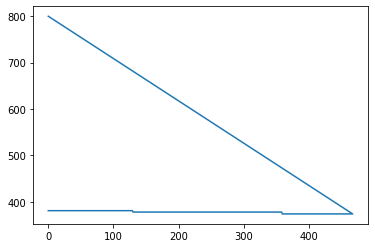

|  468      | -493.0    |  122.5    |  2.354    |  0.6222   |  0.1788   |  1.485e+0 |  2.078    |  0.01344  |  24.46    |  0.3939   |  0.1956   |  2.547    |  0.6537   |  3.72     |  2.147    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.02417
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.35
Nodes:  27
LR:  0.02417
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4926600869161719
BATCH_SIZE:  51
Dropout:  0.1
Final Linear Layers:  1
average loss: 0.692485
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5190)
Class:  0  correct:  259.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5400)
Class:  1  correct:  54.0  of  tensor(100.)
Final percentage:  tensor(0.5295)
Last epoch:  16
Credit Cost:  -470


Best Score So Far:  -374


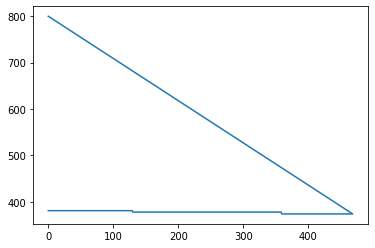

|  469      | -470.0    |  51.41    |  2.149    |  0.351    |  0.1044   |  1.484e+0 |  1.214    |  0.02417  |  27.22    |  0.008354 |  0.4927   |  1.887    |  0.9598   |  3.422    |  4.593    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.51729
    weight_decay: 0.6444746469597917
)
Batch Normalization Momentum:  0.36
Nodes:  4
LR:  0.51729
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.6444746469597917
BATCH_SIZE:  52
Dropout:  0.06
Final Linear Layers:  2
average loss: 34.258144
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5050)
Class:  0  correct:  252.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6500)
Class:  1  correct:  65.0  of  tensor(100.)
Final percentage:  tensor(0.5775)
Last epoch:  15
Credit Cost:  -422


Best Score So Far:  -374


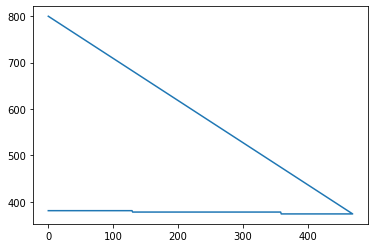

|  470      | -422.0    |  52.83    |  1.256    |  0.3609   |  0.06125  |  1.316e+0 |  2.681    |  0.5173   |  4.946    |  0.8294   |  0.6445   |  1.445    |  0.1988   |  3.298    |  1.185    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.59827
    weight_decay: 0.17526492309722289
)
Batch Normalization Momentum:  0.8
Nodes:  14
LR:  0.59827
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.17526492309722289
BATCH_SIZE:  64
Dropout:  0.01
Final Linear Layers:  1
average loss: 343.834595
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4489)
Class:  0  correct:  224.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7300)
Class:  1  correct:  73.0  of  tensor(100.)
Final percentage:  tensor(0.5894)
Last epoch:  12
Credit Cost:  -410


Best Score So Far:  -374


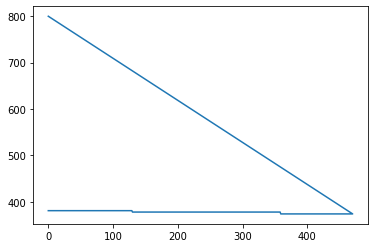

|  471      | -410.0    |  64.75    |  1.045    |  0.7992   |  0.007308 |  1.161e+0 |  1.736    |  0.5983   |  14.62    |  0.07312  |  0.1753   |  1.819    |  0.4161   |  1.365    |  1.085    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.45643
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.08
Nodes:  25
LR:  0.45643
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.6193485291214816
BATCH_SIZE:  105
Dropout:  0.12
Final Linear Layers:  2
average loss: 0.693728
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4970)
Class:  0  correct:  248.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4800)
Class:  1  correct:  48.0  of  tensor(100.)
Final percentage:  tensor(0.4885)
Last epoch:  10
Credit Cost:  -511


Best Score So Far:  -374


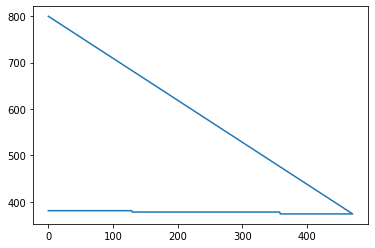

|  472      | -511.0    |  105.1    |  1.481    |  0.08259  |  0.1171   |  1.433e+0 |  2.567    |  0.4564   |  25.64    |  0.4694   |  0.6193   |  1.157    |  0.3521   |  2.076    |  7.391    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.00829
    rho: 0.9
    weight_decay: 0.2701713532806287
)
Batch Normalization Momentum:  0.11
Nodes:  10
LR:  0.00829
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.2701713532806287
BATCH_SIZE:  108
Dropout:  0.18
Final Linear Layers:  2
average loss: 0.693123
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4629)
Class:  0  correct:  231.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.4765)
Last epoch:  11
Credit Cost:  -523


Best Score So Far:  -374


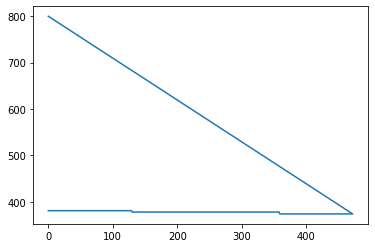

|  473      | -523.0    |  108.8    |  2.439    |  0.1097   |  0.1798   |  1.51e+03 |  2.81     |  0.008289 |  10.65    |  0.05275  |  0.2702   |  2.511    |  0.2732   |  2.836    |  6.641    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.0766
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.14
Nodes:  31
LR:  0.0766
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.47739485848234997
BATCH_SIZE:  35
Dropout:  0.02
Final Linear Layers:  1
average loss: 0.691230
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4509)
Class:  0  correct:  225.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.5155)
Last epoch:  16
Credit Cost:  -484


Best Score So Far:  -374


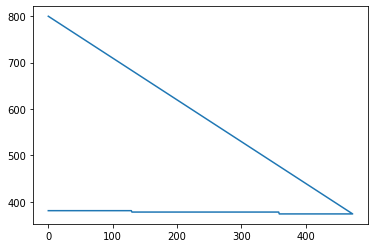

|  474      | -484.0    |  35.2     |  1.945    |  0.1421   |  0.02101  |  1.793e+0 |  1.537    |  0.0766   |  31.01    |  0.05653  |  0.4774   |  1.746    |  0.1718   |  1.816    |  7.578    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.12644
    weight_decay: 0.3351713224556662
)
Batch Normalization Momentum:  0.34
Nodes:  18
LR:  0.12644
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.3351713224556662
BATCH_SIZE:  110
Dropout:  0.12
Final Linear Layers:  3
average loss: 0.698144
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4589)
Class:  0  correct:  229.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.4595)
Last epoch:  11
Credit Cost:  -540


Best Score So Far:  -374


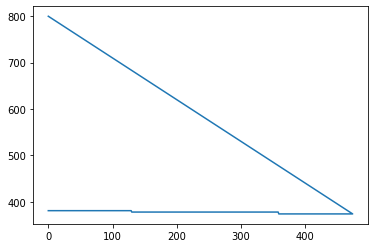

|  475      | -540.0    |  110.1    |  1.535    |  0.3437   |  0.1229   |  1.827e+0 |  3.242    |  0.1264   |  18.29    |  0.7662   |  0.3352   |  2.105    |  0.2104   |  2.971    |  1.648    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.48154
    weight_decay: 0.08160597703354351
)
Batch Normalization Momentum:  0.6
Nodes:  20
LR:  0.48154
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.08160597703354351
BATCH_SIZE:  48
Dropout:  0.28
Final Linear Layers:  2
average loss: 105.326019
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4409)
Class:  0  correct:  220.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.5104)
Last epoch:  12
Credit Cost:  -489


Best Score So Far:  -374


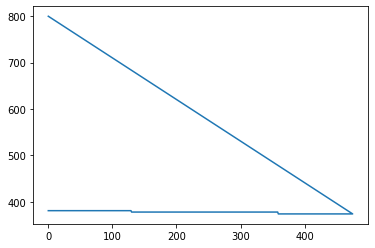

|  476      | -489.0    |  48.85    |  1.797    |  0.6027   |  0.2846   |  1.219e+0 |  2.627    |  0.4815   |  20.09    |  0.7384   |  0.08161  |  2.663    |  0.3082   |  2.307    |  1.763    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.29745
    rho: 0.9
    weight_decay: 0.04390217458666365
)
Batch Normalization Momentum:  0.48
Nodes:  20
LR:  0.29745
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.04390217458666365
BATCH_SIZE:  89
Dropout:  0.03
Final Linear Layers:  1
average loss: 0.692344
Class:  0  accuracy:  tensor(0.4649)
Class:  0  correct:  232.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6900)
Class:  1  correct:  69.0  of  tensor(100.)
Final percentage:  tensor(0.5775)
Last epoch:  7
Credit Cost:  -422


Best Score So Far:  -374


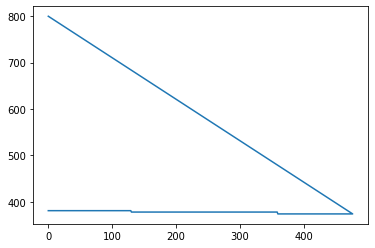

|  477      | -422.0    |  89.21    |  2.686    |  0.4789   |  0.03041  |  1.103e+0 |  1.346    |  0.2975   |  20.66    |  0.0342   |  0.0439   |  2.963    |  0.2882   |  2.425    |  6.669    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.42606
    momentum: 0.43
    nesterov: False
    weight_decay: 0.622893602897991
)
Batch Normalization Momentum:  0.11
Nodes:  16
LR:  0.42606
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.622893602897991
BATCH_SIZE:  92
Dropout:  0.27
Final Linear Layers:  3
average loss: 0.693120
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


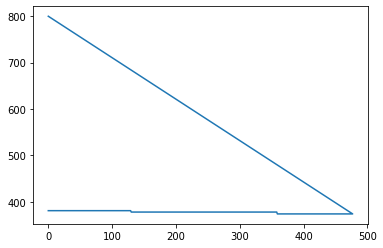

|  478      | -800.0    |  92.65    |  1.218    |  0.1086   |  0.2736   |  1.324e+0 |  3.164    |  0.4261   |  16.06    |  0.09213  |  0.6229   |  2.661    |  0.4274   |  2.363    |  5.908    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.21922
    weight_decay: 0.5504167866325576
)
Batch Normalization Momentum:  0.47
Nodes:  25
LR:  0.21922
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5504167866325576
BATCH_SIZE:  50
Dropout:  0.09
Final Linear Layers:  1
average loss: 5.777178
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4649)
Class:  0  correct:  232.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5525)
Last epoch:  15
Credit Cost:  -447


Best Score So Far:  -374


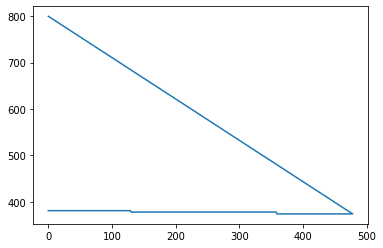

|  479      | -447.0    |  50.93    |  2.004    |  0.4679   |  0.08576  |  1.872e+0 |  1.141    |  0.2192   |  25.22    |  0.4855   |  0.5504   |  1.96     |  0.9796   |  3.643    |  1.07     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.18984
    weight_decay: 0.6488173201582839
)
Batch Normalization Momentum:  0.34
Nodes:  11
LR:  0.18984
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.6488173201582839
BATCH_SIZE:  62
Dropout:  0.22
Final Linear Layers:  1
average loss: 1.336622
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5932)
Class:  0  correct:  296.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3900)
Class:  1  correct:  39.0  of  tensor(100.)
Final percentage:  tensor(0.4916)
Last epoch:  11
Credit Cost:  -508


Best Score So Far:  -374


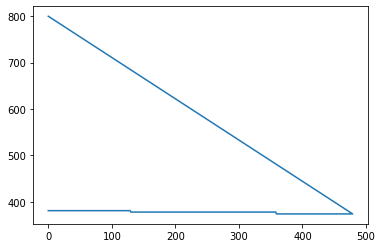

|  480      | -508.0    |  62.91    |  2.706    |  0.3401   |  0.2187   |  1.418e+0 |  1.286    |  0.1898   |  11.39    |  0.6542   |  0.6488   |  2.4      |  0.3198   |  3.043    |  1.756    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.09484
    rho: 0.9
    weight_decay: 0.608730012622777
)
Batch Normalization Momentum:  0.69
Nodes:  9
LR:  0.09484
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.608730012622777
BATCH_SIZE:  50
Dropout:  0.2
Final Linear Layers:  1
average loss: 0.693798
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4449)
Class:  0  correct:  222.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4800)
Class:  1  correct:  48.0  of  tensor(100.)
Final percentage:  tensor(0.4624)
Last epoch:  29
Credit Cost:  -537


Best Score So Far:  -374


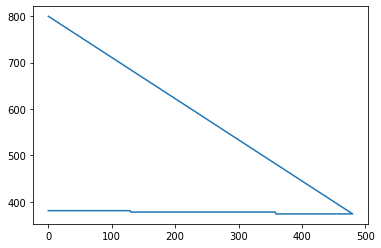

|  481      | -537.0    |  50.56    |  1.378    |  0.6861   |  0.1986   |  1.353e+0 |  1.54     |  0.09484  |  9.11     |  0.3288   |  0.6087   |  1.243    |  0.1665   |  2.108    |  6.433    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.19562
    weight_decay: 0.21045252971449616
)
Batch Normalization Momentum:  0.83
Nodes:  9
LR:  0.19562
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.21045252971449616
BATCH_SIZE:  10
Dropout:  0.2
Final Linear Layers:  1
average loss: 0.693422
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5251)
Class:  0  correct:  262.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4975)
Last epoch:  8
Credit Cost:  -501


Best Score So Far:  -374


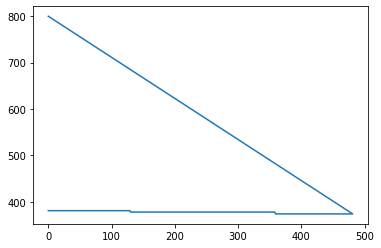

|  482      | -501.0    |  10.92    |  1.488    |  0.8256   |  0.1989   |  1.351e+0 |  1.341    |  0.1956   |  9.335    |  0.7101   |  0.2105   |  2.348    |  0.4085   |  2.046    |  8.065    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.04477
    rho: 0.9
    weight_decay: 0.5599365090478109
)
Batch Normalization Momentum:  0.58
Nodes:  7
LR:  0.04477
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.5599365090478109
BATCH_SIZE:  26
Dropout:  0.1
Final Linear Layers:  3
average loss: 0.692169
Class:  0  accuracy:  tensor(0.4709)
Class:  0  correct:  235.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6700)
Class:  1  correct:  67.0  of  tensor(100.)
Final percentage:  tensor(0.5705)
Last epoch:  7
Credit Cost:  -429


Best Score So Far:  -374


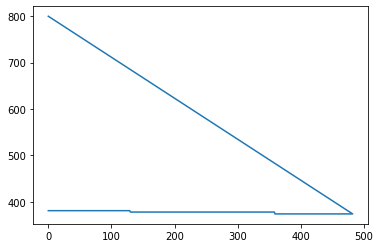

|  483      | -429.0    |  26.99    |  1.909    |  0.5777   |  0.09636  |  1.706e+0 |  3.744    |  0.04477  |  7.443    |  0.5091   |  0.5599   |  2.256    |  0.01949  |  1.987    |  6.878    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.23491
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.05
Nodes:  27
LR:  0.23491
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.6046643940850543
BATCH_SIZE:  89
Dropout:  0.19
Final Linear Layers:  3
average loss: 0.692749
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4890)
Class:  0  correct:  244.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.4995)
Last epoch:  8
Credit Cost:  -500


Best Score So Far:  -374


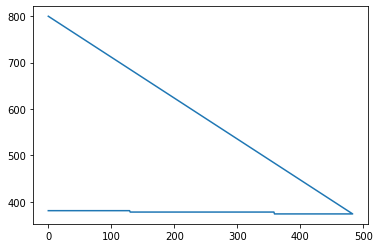

|  484      | -500.0    |  89.21    |  1.96     |  0.0532   |  0.1883   |  1.504e+0 |  3.169    |  0.2349   |  27.07    |  0.3079   |  0.6047   |  1.029    |  0.7551   |  3.474    |  7.121    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.52156
    weight_decay: 0.6778010673651432
)
Batch Normalization Momentum:  0.35
Nodes:  12
LR:  0.52156
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.6778010673651432
BATCH_SIZE:  115
Dropout:  0.07
Final Linear Layers:  3
average loss: 2.143359
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5411)
Class:  0  correct:  270.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5300)
Class:  1  correct:  53.0  of  tensor(100.)
Final percentage:  tensor(0.5355)
Last epoch:  15
Credit Cost:  -464


Best Score So Far:  -374


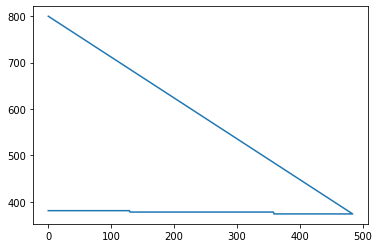

|  485      | -464.0    |  115.9    |  1.401    |  0.3484   |  0.06874  |  1.845e+0 |  3.232    |  0.5216   |  12.43    |  0.1546   |  0.6778   |  1.893    |  0.7226   |  2.956    |  2.284    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.56389
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.96
Nodes:  3
LR:  0.56389
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.5901204629592438
BATCH_SIZE:  108
Dropout:  0.1
Final Linear Layers:  1
average loss: 0.690948
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5311)
Class:  0  correct:  265.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5505)
Last epoch:  9
Credit Cost:  -449


Best Score So Far:  -374


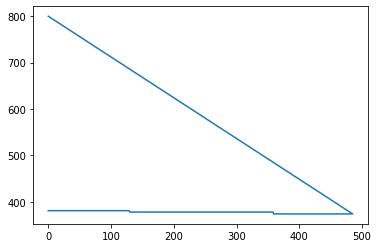

|  486      | -449.0    |  108.7    |  2.947    |  0.9566   |  0.1009   |  1.926e+0 |  1.398    |  0.5639   |  3.323    |  0.4093   |  0.5901   |  2.445    |  0.7137   |  1.829    |  4.787    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.39663
    weight_decay: 0.6205801323336929
)
Batch Normalization Momentum:  0.5
Nodes:  3
LR:  0.39663
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6205801323336929
BATCH_SIZE:  77
Dropout:  0.16
Final Linear Layers:  3
average loss: 0.803737
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4449)
Class:  0  correct:  222.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.5024)
Last epoch:  13
Credit Cost:  -497


Best Score So Far:  -374


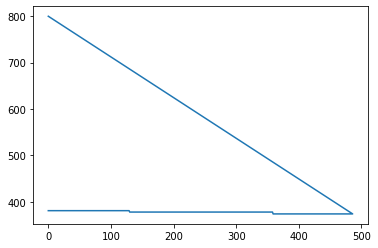

|  487      | -497.0    |  77.1     |  1.774    |  0.5009   |  0.1621   |  1.824e+0 |  3.168    |  0.3966   |  3.077    |  0.1561   |  0.6206   |  2.524    |  0.1786   |  1.195    |  2.463    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.40901
    momentum: 0.19
    nesterov: False
    weight_decay: 0.6650453140495945
)
Batch Normalization Momentum:  0.75
Nodes:  12
LR:  0.40901
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.6650453140495945
BATCH_SIZE:  107
Dropout:  0.24
Final Linear Layers:  3
average loss: 0.693042
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


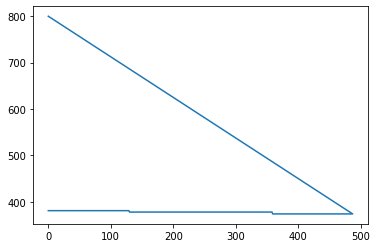

|  488      | -800.0    |  107.8    |  2.936    |  0.7476   |  0.2354   |  1.029e+0 |  3.615    |  0.409    |  12.47    |  0.4996   |  0.665    |  1.108    |  0.1898   |  1.449    |  5.839    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.02812
    t0: 1000000.0
    weight_decay: 0.4950921049432768
)
Batch Normalization Momentum:  0.51
Nodes:  18
LR:  0.02812
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.4950921049432768
BATCH_SIZE:  33
Dropout:  0.25
Final Linear Layers:  1
average loss: 0.692955
Class:  0  accuracy:  tensor(0.4589)
Class:  0  correct:  229.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6700)
Class:  1  correct:  67.0  of  tensor(100.)
Final percentage:  tensor(0.5645)
Last epoch:  7
Credit Cost:  -435


Best Score So Far:  -374


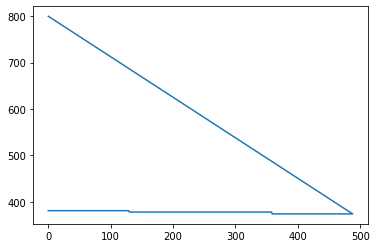

|  489      | -435.0    |  33.22    |  1.153    |  0.5098   |  0.2509   |  1.682e+0 |  1.11     |  0.02812  |  18.14    |  0.1421   |  0.4951   |  1.492    |  0.4356   |  2.855    |  9.745    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.02723
    weight_decay: 0.2860652260102327
)
Batch Normalization Momentum:  0.35
Nodes:  6
LR:  0.02723
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.2860652260102327
BATCH_SIZE:  28
Dropout:  0.05
Final Linear Layers:  3
average loss: 0.691972
Class:  0  accuracy:  tensor(0.4749)
Class:  0  correct:  237.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4800)
Class:  1  correct:  48.0  of  tensor(100.)
Final percentage:  tensor(0.4775)
Last epoch:  7
Credit Cost:  -522


Best Score So Far:  -374


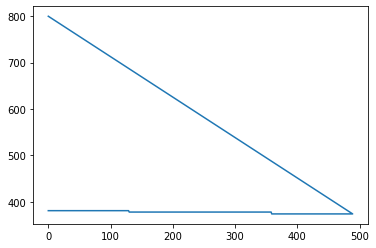

|  490      | -522.0    |  28.43    |  2.815    |  0.3473   |  0.04858  |  1.421e+0 |  3.516    |  0.02723  |  6.109    |  0.5898   |  0.2861   |  1.952    |  0.8138   |  1.5      |  3.895    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.53847
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.52
Nodes:  19
LR:  0.53847
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.02051638459042367
BATCH_SIZE:  29
Dropout:  0.06
Final Linear Layers:  1
average loss: 0.692878
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4709)
Class:  0  correct:  235.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4800)
Class:  1  correct:  48.0  of  tensor(100.)
Final percentage:  tensor(0.4755)
Last epoch:  11
Credit Cost:  -524


Best Score So Far:  -374


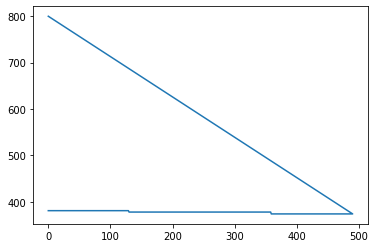

|  491      | -524.0    |  29.48    |  1.198    |  0.5191   |  0.06377  |  1.904e+0 |  1.138    |  0.5385   |  19.63    |  0.8609   |  0.02052  |  1.663    |  0.4961   |  1.649    |  4.799    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.13876
    momentum: 0.43
    nesterov: False
    weight_decay: 0.43108877817143904
)
Batch Normalization Momentum:  0.92
Nodes:  17
LR:  0.13876
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.43108877817143904
BATCH_SIZE:  7
Dropout:  0.02
Final Linear Layers:  3
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


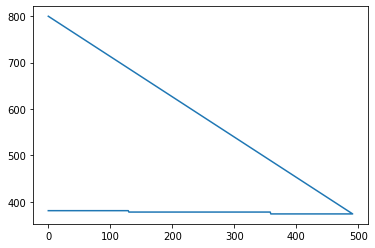

|  492      | -800.0    |  7.662    |  2.168    |  0.9204   |  0.02274  |  1.842e+0 |  3.236    |  0.1388   |  17.54    |  0.3141   |  0.4311   |  1.424    |  0.4315   |  3.359    |  5.194    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.24557
    weight_decay: 0.04941205889862503
)
Batch Normalization Momentum:  0.93
Nodes:  13
LR:  0.24557
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.04941205889862503
BATCH_SIZE:  87
Dropout:  0.3
Final Linear Layers:  1
average loss: 0.715341
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4950)
Class:  0  correct:  247.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5025)
Last epoch:  17
Credit Cost:  -497


Best Score So Far:  -374


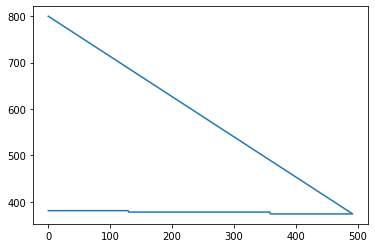

|  493      | -497.0    |  87.52    |  2.761    |  0.9288   |  0.2954   |  1.884e+0 |  1.728    |  0.2456   |  13.24    |  0.1529   |  0.04941  |  1.589    |  0.8514   |  1.117    |  2.937    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.29265
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.56
Nodes:  18
LR:  0.29265
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.004084653832992575
BATCH_SIZE:  46
Dropout:  0.24
Final Linear Layers:  3
average loss: 0.693411
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4930)
Class:  0  correct:  246.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4565)
Last epoch:  11
Credit Cost:  -543


Best Score So Far:  -374


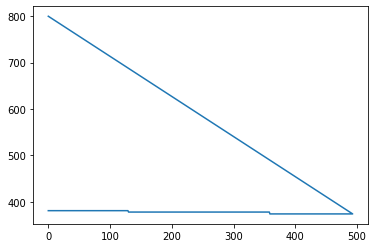

|  494      | -543.0    |  46.97    |  2.29     |  0.5575   |  0.2389   |  1.687e+0 |  3.66     |  0.2927   |  18.08    |  0.837    |  0.004085 |  1.483    |  0.2193   |  2.679    |  7.451    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.33588
    rho: 0.9
    weight_decay: 0.6829603715737756
)
Batch Normalization Momentum:  0.73
Nodes:  4
LR:  0.33588
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6829603715737756
BATCH_SIZE:  35
Dropout:  0.22
Final Linear Layers:  3
average loss: 0.692255
Class:  0  accuracy:  tensor(0.5391)
Class:  0  correct:  269.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6700)
Class:  1  correct:  67.0  of  tensor(100.)
Final percentage:  tensor(0.6045)
Last epoch:  7
Credit Cost:  -395


Best Score So Far:  -374


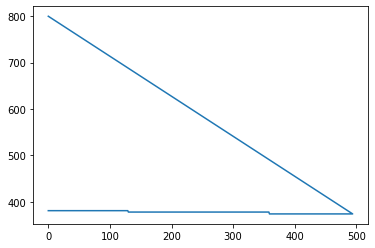

|  495      | -395.0    |  35.31    |  2.007    |  0.7319   |  0.2167   |  1.468e+0 |  3.112    |  0.3359   |  4.352    |  0.9519   |  0.683    |  1.322    |  0.4136   |  2.853    |  6.107    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.05257
    weight_decay: 0.10271679864719892
)
Batch Normalization Momentum:  0.67
Nodes:  12
LR:  0.05257
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.10271679864719892
BATCH_SIZE:  50
Dropout:  0.03
Final Linear Layers:  1
average loss: 0.693896
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5611)
Class:  0  correct:  280.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.5256)
Last epoch:  10
Credit Cost:  -474


Best Score So Far:  -374


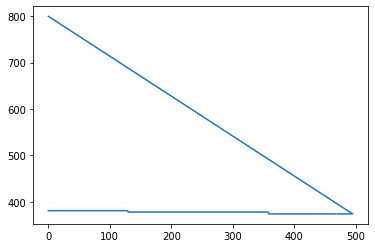

|  496      | -474.0    |  50.47    |  2.798    |  0.6704   |  0.03379  |  1.67e+03 |  1.652    |  0.05257  |  12.8     |  0.05051  |  0.1027   |  1.902    |  0.9734   |  3.517    |  1.119    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.37829
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.2
Nodes:  7
LR:  0.37829
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.4077831324504373
BATCH_SIZE:  111
Dropout:  0.09
Final Linear Layers:  2
average loss: 0.692518
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4369)
Class:  0  correct:  218.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.5084)
Last epoch:  19
Credit Cost:  -490


Best Score So Far:  -374


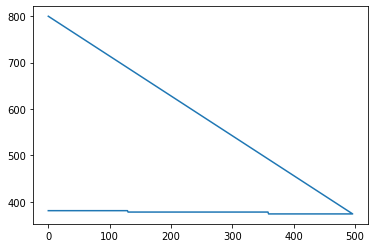

|  497      | -490.0    |  111.7    |  1.564    |  0.1957   |  0.09289  |  1.529e+0 |  2.443    |  0.3783   |  7.003    |  0.3745   |  0.4078   |  2.613    |  0.3648   |  3.51     |  4.747    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.2911
    rho: 0.9
    weight_decay: 0.42452102035481126
)
Batch Normalization Momentum:  0.36
Nodes:  21
LR:  0.2911
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.42452102035481126
BATCH_SIZE:  120
Dropout:  0.2
Final Linear Layers:  2
average loss: 0.693449
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4449)
Class:  0  correct:  222.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4800)
Class:  1  correct:  48.0  of  tensor(100.)
Final percentage:  tensor(0.4624)
Last epoch:  20
Credit Cost:  -537


Best Score So Far:  -374


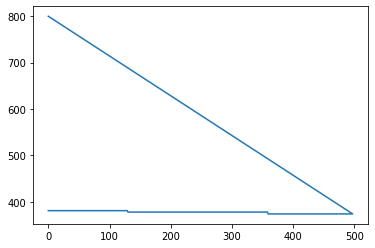

|  498      | -537.0    |  120.9    |  1.59     |  0.3649   |  0.1958   |  1.583e+0 |  2.059    |  0.2911   |  21.93    |  0.05723  |  0.4245   |  2.486    |  0.786    |  1.639    |  6.764    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.33653
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.07
Nodes:  12
LR:  0.33653
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.6338333021446272
BATCH_SIZE:  94
Dropout:  0.27
Final Linear Layers:  3
average loss: 0.693875
Class:  0  accuracy:  tensor(0.5030)
Class:  0  correct:  251.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3700)
Class:  1  correct:  37.0  of  tensor(100.)
Final percentage:  tensor(0.4365)
Last epoch:  7
Credit Cost:  -563


Best Score So Far:  -374


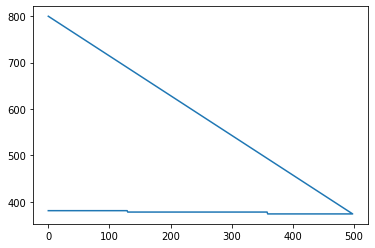

|  499      | -563.0    |  94.66    |  1.189    |  0.06937  |  0.2658   |  1.361e+0 |  3.103    |  0.3365   |  12.13    |  0.346    |  0.6338   |  1.902    |  0.4777   |  3.928    |  4.701    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.09613
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.38
Nodes:  11
LR:  0.09613
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.586924184891959
BATCH_SIZE:  49
Dropout:  0.05
Final Linear Layers:  2
average loss: 0.692597
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5230)
Class:  0  correct:  261.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5215)
Last epoch:  17
Credit Cost:  -478


Best Score So Far:  -374


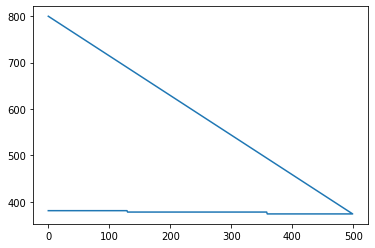

|  500      | -478.0    |  49.81    |  1.159    |  0.3839   |  0.05338  |  1.131e+0 |  2.099    |  0.09613  |  11.23    |  0.6876   |  0.5869   |  1.607    |  0.3496   |  3.185    |  7.993    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.58731
    rho: 0.9
    weight_decay: 0.32090161006858137
)
Batch Normalization Momentum:  0.41
Nodes:  5
LR:  0.58731
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.32090161006858137
BATCH_SIZE:  59
Dropout:  0.16
Final Linear Layers:  1
average loss: 0.692868
Class:  0  accuracy:  tensor(0.5070)
Class:  0  correct:  253.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5135)
Last epoch:  7
Credit Cost:  -486


Best Score So Far:  -374


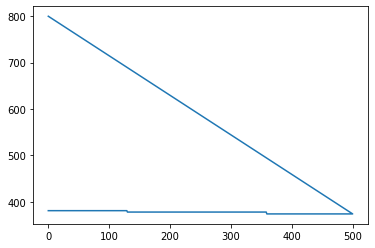

|  501      | -486.0    |  59.83    |  1.369    |  0.4124   |  0.163    |  1.011e+0 |  1.112    |  0.5873   |  5.292    |  0.959    |  0.3209   |  1.748    |  0.1066   |  2.252    |  6.234    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.13685
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.94
Nodes:  26
LR:  0.13685
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6508306469282664
BATCH_SIZE:  89
Dropout:  0.04
Final Linear Layers:  3
average loss: 0.692691
Class:  0  accuracy:  tensor(0.5451)
Class:  0  correct:  272.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5400)
Class:  1  correct:  54.0  of  tensor(100.)
Final percentage:  tensor(0.5425)
Last epoch:  7
Credit Cost:  -457


Best Score So Far:  -374


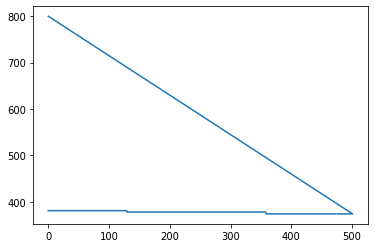

|  502      | -457.0    |  89.16    |  2.629    |  0.9438   |  0.03717  |  1.146e+0 |  3.927    |  0.1368   |  26.69    |  0.5422   |  0.6508   |  2.309    |  0.3534   |  2.88     |  4.873    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.47842
    momentum: 0.43
    nesterov: False
    weight_decay: 0.6278213141813059
)
Batch Normalization Momentum:  0.86
Nodes:  12
LR:  0.47842
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.6278213141813059
BATCH_SIZE:  41
Dropout:  0.02
Final Linear Layers:  1
average loss: 0.693148
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


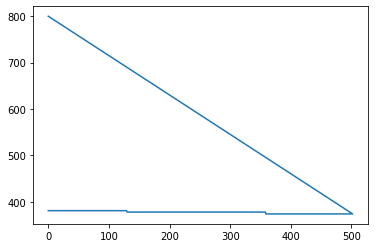

|  503      | -800.0    |  41.83    |  2.577    |  0.8638   |  0.01966  |  1.966e+0 |  1.133    |  0.4784   |  12.54    |  0.1586   |  0.6278   |  2.679    |  0.4295   |  2.192    |  5.397    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.04058
    momentum: 0.15
    nesterov: False
    weight_decay: 0.42550130866047375
)
Batch Normalization Momentum:  0.77
Nodes:  10
LR:  0.04058
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.42550130866047375
BATCH_SIZE:  53
Dropout:  0.21
Final Linear Layers:  3
average loss: 0.693368
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5090)
Class:  0  correct:  254.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.4995)
Last epoch:  23
Credit Cost:  -500


Best Score So Far:  -374


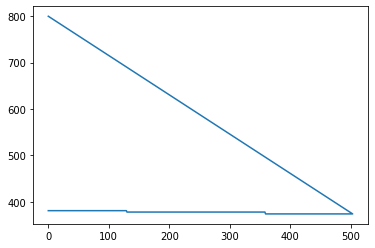

|  504      | -500.0    |  53.84    |  1.895    |  0.7701   |  0.2138   |  1.943e+0 |  3.74     |  0.04058  |  10.55    |  0.9175   |  0.4255   |  1.359    |  0.152    |  1.012    |  5.013    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.41877
    t0: 1000000.0
    weight_decay: 0.5552150404629376
)
Batch Normalization Momentum:  0.13
Nodes:  8
LR:  0.41877
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.5552150404629376
BATCH_SIZE:  10
Dropout:  0.13
Final Linear Layers:  2
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  7
Credit Cost:  -800


Best Score So Far:  -374


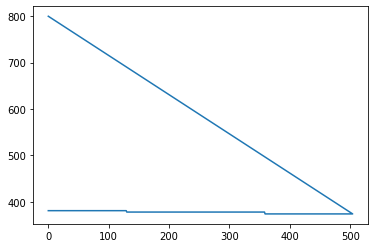

|  505      | -800.0    |  10.72    |  2.122    |  0.1262   |  0.1328   |  1.516e+0 |  2.93     |  0.4188   |  8.58     |  0.8079   |  0.5552   |  2.536    |  0.7674   |  1.291    |  9.517    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.04174
    weight_decay: 0.29410853586506225
)
Batch Normalization Momentum:  0.69
Nodes:  12
LR:  0.04174
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.29410853586506225
BATCH_SIZE:  76
Dropout:  0.2
Final Linear Layers:  1
average loss: 0.693171
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5190)
Class:  0  correct:  259.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.5495)
Last epoch:  9
Credit Cost:  -450


Best Score So Far:  -374


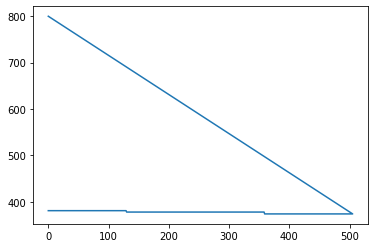

|  506      | -450.0    |  76.21    |  2.13     |  0.6859   |  0.2044   |  1.439e+0 |  1.027    |  0.04174  |  12.62    |  0.06032  |  0.2941   |  1.048    |  0.03752  |  3.093    |  8.617    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.59142
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.72
Nodes:  21
LR:  0.59142
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.03220010223031172
BATCH_SIZE:  123
Dropout:  0.09
Final Linear Layers:  3
average loss: 0.690309
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5291)
Class:  0  correct:  264.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5845)
Last epoch:  9
Credit Cost:  -415


Best Score So Far:  -374


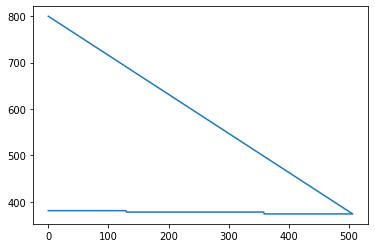

|  507      | -415.0    |  123.1    |  2.926    |  0.7205   |  0.08972  |  1.373e+0 |  3.853    |  0.5914   |  21.35    |  0.1345   |  0.0322   |  2.269    |  0.5178   |  1.256    |  7.702    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.12693
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.32
Nodes:  15
LR:  0.12693
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.19820230172586656
BATCH_SIZE:  112
Dropout:  0.18
Final Linear Layers:  1
average loss: 0.695348
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4910)
Class:  0  correct:  245.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4805)
Last epoch:  14
Credit Cost:  -519


Best Score So Far:  -374


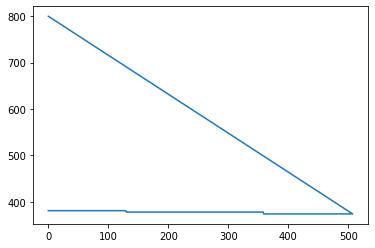

|  508      | -519.0    |  112.2    |  2.19     |  0.3194   |  0.1774   |  1.008e+0 |  1.241    |  0.1269   |  15.93    |  0.1175   |  0.1982   |  1.102    |  0.6599   |  3.984    |  4.676    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.24776
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.72
Nodes:  19
LR:  0.24776
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.08658152399238699
BATCH_SIZE:  113
Dropout:  0.21
Final Linear Layers:  3
average loss: 0.691418
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5210)
Class:  0  correct:  260.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7000)
Class:  1  correct:  70.0  of  tensor(100.)
Final percentage:  tensor(0.6105)
Last epoch:  10
Credit Cost:  -389


Best Score So Far:  -374


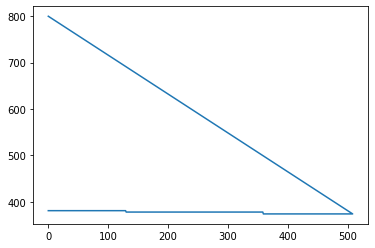

|  509      | -389.0    |  113.9    |  1.909    |  0.7168   |  0.2095   |  1.501e+0 |  3.571    |  0.2478   |  19.98    |  0.08331  |  0.08658  |  2.418    |  0.003299 |  1.848    |  7.788    |


In [ ]:


if OPTIMIZATION_PLUGIN == 'Bayesian' :
    from bayes_opt import BayesianOptimization
    
    #def black_box_function(x, y):
    def objective(SCI_RELU, SCI_BIAS, SCI_loss_type,
                  SCI_optimizer, SCI_LR, SCI_MM, 
                  SCI_REGULARIZATION, SCI_EPOCHS, SCI_BATCH_SIZE, 
                  SCI_DROPOUT, SCI_L_SECOND, SCI_BN_MOMENTUM, SCI_SGD_MOMENTUM, SCI_LINEARITY):
        #global device, MaxCredit  , SCI_REGULARIZATION, SCI_DROPOUT, SCI_L_SECOND, SCI_EPOCHS, SCI_BN
        global count, CreditVector, CreditVec, device, MaxCredit

        
        SCI_BATCH_SIZE = int(SCI_BATCH_SIZE)                    # integer between 4 and 256
        SCI_MM = round(SCI_MM,3)                                # real with three decimals between (0.001, 0.999)
        #SCI_REGULARIZATION = round(SCI_REGULARIZATION,3)        # real with three decimals between (0.001, 0.7)
        SCI_LR = round(SCI_LR,5)                                # real with five decimals between(1e-4, 7e-1)            
        SCI_DROPOUT = round(SCI_DROPOUT,2)                      # real with two decimals between (0, 0.4)
        SCI_L_SECOND = int(SCI_L_SECOND)                        # integer between 2 and 64
        SCI_EPOCHS = int(SCI_EPOCHS)                            # integer between (100, 500)
        SCI_BN_MOMENTUM = round(SCI_BN_MOMENTUM,2)              # real with two decimals between (0, 0.99)
        SCI_SGD_MOMENTUM = round(SCI_SGD_MOMENTUM,2)            # real with two decimals between (0, 0.99) 
        #SCI_optimizer = int(SCI_optimizer)                      # integer between 1 and 4
        SCI_loss_type = int(SCI_loss_type)                      # integer between 1 and 3 ('CrossEntropyLoss', 'MultiMarginLoss','NLLLoss')
        SCI_LINEARITY = int(SCI_LINEARITY)
        if int(SCI_RELU) == 1 :                                 # integer between 1 and 2 ('True', 'False')
            SCI_RELU = True      
        else:
            SCI_RELU = False      
        if int(SCI_BIAS) == 1 :                                 # integer between 1 and 2 ('True', 'False')
            SCI_BIAS = True      
        else:
            SCI_BIAS = False  
 
        SCI_REGULARIZATION = float(str(SCI_REGULARIZATION))
        
        cnn = CNN6(L_FIRST, SCI_L_SECOND, KERNEL_X,
                   SCI_BIAS, SCI_BN_MOMENTUM, SCI_RELU,
                   SCI_DROPOUT, dataset.CLASSES, SCI_LINEARITY)     

        optimizer = Utillities.optimization_algorithms(SCI_optimizer,cnn, SCI_LR, SCI_SGD_MOMENTUM,
                                                       SCI_REGULARIZATION)
        
        if GPU_SELECT == 2:
            if torch.cuda.device_count() > 1:
                cnn = nn.DataParallel(cnn,device_ids=[0, 1], dim = 0) 
            cnn = cnn.cuda()                
        if GPU_SELECT == 1:
            cnn.to(device)  
        if GPU_SELECT == 0:
            cnn.to(device)        

        cnn.apply(CNN6.weights_reset)        
        cnn.share_memory()
     
        loss_func = nn.CrossEntropyLoss()

        def create_loss(LOSS):   
            print('*** LOSS ******:',  LOSS)
            if LOSS == 1:
                loss_func = nn.CrossEntropyLoss()
                print('*********  CrossEntropyLoss')
            if LOSS == 2:
                loss_func = nn.MultiMarginLoss()
                print('*********  MMLoss')                               
            if LOSS == 3:
                loss_func = nn.NLLLoss() 
                print('*********  NLLLoss')                 
            return loss_func

        MM = float(str(SCI_MM))

        LR = float(str(SCI_LR))
        train_losses = []         # to track the training loss as the model trains
        output = 0
        loss = 0
        accuracy = 0
        early_stopping.counter = 0
        early_stopping.best_score = None
        early_stopping.early_stop = False
        early_stopping.verbose = False  
        TEST_RESULTS = torch.zeros(1,2)
    
        loss_type = create_loss(SCI_loss_type)
    
        Utillities.listing(optimizer, SCI_SGD_MOMENTUM, SCI_BN_MOMENTUM, 
                           SCI_L_SECOND, SCI_LR, SCI_RELU, 
                           SCI_BIAS, SCI_loss_type, SCI_REGULARIZATION, 
                           SCI_BATCH_SIZE, SCI_DROPOUT, SCI_LINEARITY)

    
        # Data Loader for easy mini-batch return in training
        SCI_BATCH_SIZE = int(SCI_BATCH_SIZE)
        train_loader = Data.DataLoader(dataset = dataset.train_dataset, batch_size = SCI_BATCH_SIZE, shuffle = True, num_workers = 0, drop_last=True, pin_memory=True)
        validation_loader = Data.DataLoader(dataset = dataset.validation_dataset, batch_size = 144, shuffle = True, num_workers = 0, drop_last=True, pin_memory=True)    
        test_loader = Data.DataLoader(dataset = dataset.test_dataset, batch_size = 599, shuffle = True, num_workers = 0, drop_last=True, pin_memory=True)
    
        for epoch in range(SCI_EPOCHS):
            loss = None        
            cnn.train().cuda()
            for step, (train_data, train_target) in enumerate(train_loader):   
                train_data, train_target = train_data.to(device), train_target.to(device)
                output, temp = cnn(train_data)                # forward pass: compute predicted outputs by passing inputs to the model     
                loss = loss_func(output, train_target)
                train_losses.append(loss.item())              # record training loss 
                loss.backward()                               # backward pass: compute gradient of the loss with respect to model parameters
                optimizer.zero_grad()
                optimizer.step()                              # perform a single optimization step (parameter update)
      
            cnn.eval().cuda()                 # switch to evaluation (no change) mode           
            valid_loss = 0
            accuracy = 0
            running_loss = 0.0
            with torch.no_grad():
                for step, (validation_data, validation_target) in enumerate(validation_loader):
                    validation_data, validation_target = validation_data.to(device), validation_target.to(device)
                    output, temp = cnn(validation_data)            # forward pass: compute predicted outputs by passing inputs to the model
                    valid_loss += loss_func(output, validation_target).item()
                    #ps = torch.exp(output)
                    #equality = (validation_target[0].data == ps.max(dim=1)[1])
                    #accuracy += equality.type(torch.FloatTensor).mean()    
                    #print('valid_loss: ', valid_loss)                    
                    # print statistics
                running_loss += valid_loss
                if epoch % 100 == 0: 
                    print('average loss: %.6f' %(running_loss))
                    running_loss = 0.0
                   
            train_losses = []
            early_stopping(valid_loss, cnn)
        
            if early_stopping.early_stop:
                if os.path.exists('checkpoint.pt'):
                    #cnn = TheModelClass(*args, **kwargs)
                    print("Loaded the model with the lowest Validation Loss!")
                    cnn.load_state_dict(torch.load('checkpoint.pt'))  # Choose whatever GPU device number you want
                    cnn.to(device)
                break
      
        cnn.eval()
        class_correct = list(0. for i in range(1000))
        class_total = list(0. for i in range(1000))
        with torch.no_grad():
            for (test_data, test_target) in test_loader:
                test_data, test_target = test_data.to(device), test_target.to(device)
                outputs, temp = cnn(test_data)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == test_target).squeeze()
                for i in range(test_target.size(0)):
                    label = test_target[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(dataset.CLASSES):
            TEST_RESULTS[0,i] = class_correct[i] / dataset.TESTED_ELEMENTS[i]
            print('Class: ',i,' accuracy: ', TEST_RESULTS[0,i])   
            print('Class: ',i,' correct: ', class_correct[i],' of ',dataset.TESTED_ELEMENTS[i])
        percent = (TEST_RESULTS[0,0]+TEST_RESULTS[0,1])/2
        print('Final percentage: ',percent)
    
        CreditCost = int((1 - TEST_RESULTS[0,0]) * dataset.TESTED_ELEMENTS[0] + (1 - TEST_RESULTS[0,1]) * dataset.TESTED_ELEMENTS[1] * 5)
        
        if TEST_RESULTS[0,0] == 0 or TEST_RESULTS[0,1] == 0 :
            CreditCost = CreditCost + 300
    
        print('Last epoch: ', epoch)
        print('Credit Cost: ',-CreditCost)
        #list(cnn.parameters())
    
        if os.path.exists('checkpoint.pt'):  
            os.remove('checkpoint.pt') 

        print()
        
        
        print()
        
        if -CreditCost > MaxCredit : 
            MaxCredit = -CreditCost
        print('Best Score So Far: ',MaxCredit)    
        
        CreditVector[count] = MaxCredit    
        CreditVec[count] = count
        # plot the data
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(CreditVec, -CreditVector, color='tab:blue')
        #print(CreditVec, -CreditVector)
        count = count + 1
        # display the plot
        plt.show()
        
        return -CreditCost
    
    
    optimizer = BayesianOptimization(
        f=objective,
        #pbounds=pbounds,
        pbounds={'SCI_RELU': (1,2.99), 
                 'SCI_BIAS': (1,2.99), 
                 'SCI_loss_type': (1, 3.99), 
                 'SCI_optimizer': (1, 9.99),
                 'SCI_LR': (0.001, 0.6), 
                 'SCI_MM': (0.001, 0.999), 
                 'SCI_REGULARIZATION': (0.0001, 0.7), 
                 'SCI_EPOCHS': (1000, 2000), 
                 'SCI_BATCH_SIZE': (4, 128), 
                 'SCI_DROPOUT': (0, 0.3), 
                 'SCI_L_SECOND': (2, 32), 
                 'SCI_BN_MOMENTUM': (0, 0.99), 
                 'SCI_SGD_MOMENTUM': (0, 0.99), 
                 'SCI_LINEARITY': (1,3.99)},
        verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1,
    )
        

    #optimizer.maximize(
        #n_iter=TRIALS, acq="ucb", kappa=0.1
    #)
    
    
    optimizer.maximize(
        init_points = RANDOM_STARTS,
        n_iter = TRIALS,
        #acq="ucb", kappa=0.1
        
        acq="ei", xi=1e-4
    )
    
    
    print(optimizer.max)
    
    for i, res in enumerate(optimizer.res):
        print("Iteration {}: \n\t{}".format(i, res))

In [ ]:
if OPTIMIZATION_PLUGIN == 'GradDescent' :
    import pandas as pd
    import matplotlib.pyplot as plt
    import torch
    import torch.optim as optim
    from torch.autograd import Variable
    from Utillities import Utillities
    from cnn_model import CNN6      

    #SCI_LR = 0.2
    SCI_REGULARIZATION = 0.03
    SCI_EPOCHS = 200
    SCI_RELU = 'True'
    SCI_BIAS = 'True'
    SCI_BN_MOMENTUM = 0.1
    
    
    SCI_loss_type = torch.randint(3, 4, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_loss_type: ',SCI_loss_type)    
    SCI_SGD_MOMENTUM = torch.rand(1, requires_grad=True)
    print('SCI_SGD_MOMENTUM: ', SCI_SGD_MOMENTUM)
    SCI_BATCH_SIZE   = torch.randint(128, 256, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_BATCH_SIZE: ',SCI_BATCH_SIZE)
    SCI_L_SECOND   = torch.randint(4, 32, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_L_SECOND: ',SCI_L_SECOND)
    SCI_optimizer   = torch.randint(6, 11, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_optimizer: ',SCI_optimizer)    
    SCI_DROPOUT      = torch.rand(1, requires_grad=True)    
    print('SCI_DROPOUT: ',SCI_DROPOUT)   
    SCI_LR      = torch.rand(1, requires_grad=True)    
    print('SCI_LR: ',SCI_LR) 
    

    def objective(SCI_SGD_MOMENTUM, SCI_DROPOUT, SCI_BATCH_SIZE, SCI_L_SECOND, SCI_optimizer, LINEARITY, SCI_loss_type, SCI_LR):
        global SCI_REGULARIZATION, SCI_EPOCHS, SCI_RELU
        global SCI_BIAS, SCI_BN_MOMENTUM, device, MaxCredit, count, CreditVector, CreditVec
        
        SCI_SGD_MOMENTUM = SCI_SGD_MOMENTUM/10
        DROPOUT = (SCI_DROPOUT/2).item()
        if SCI_DROPOUT < 0 :
            DROPOUT = 0
            
        if SCI_BATCH_SIZE < 2 :
            SCI_BATCH_SIZE = 64            

        BATCH_SIZE = int(SCI_BATCH_SIZE)
        
        if SCI_L_SECOND < 4 :
            SCI_L_SECOND = 64
            
        
        L_SECOND = int(SCI_L_SECOND)
        
        def create_loss(LOSS):   
            print('*** LOSS ******:',  LOSS)
            if LOSS == 1:
                loss_func = nn.CrossEntropyLoss()
                print('*********  CrossEntropyLoss')
            if LOSS == 2:
                loss_func = nn.MultiMarginLoss()
                print('*********  MMLoss')                               
            if LOSS == 3:
                loss_func = nn.NLLLoss() 
                print('*********  NLLLoss')                 
            return loss_func

        SCI_LR = SCI_LR.item() / 3
        print('SCI_LR: ', SCI_LR)
        print('SCI_LR type: ', type(SCI_LR))


        
        loss_type = int(SCI_loss_type)
        loss_func = create_loss(loss_type)
        print('LOSS FUNCTION IS: ',loss_func)

        REGULARIZATION = float(str(SCI_REGULARIZATION))

        cnn = CNN6(L_FIRST, L_SECOND, KERNEL_X, SCI_BIAS, SCI_BN_MOMENTUM, SCI_RELU, DROPOUT, dataset.CLASSES, LINEARITY)     

        optimizer1 = Utillities.optimization_algorithms(SCI_optimizer.detach().numpy(),cnn, SCI_LR, SCI_SGD_MOMENTUM, SCI_REGULARIZATION)
        
        if GPU_SELECT == 2:
            if torch.cuda.device_count() > 1:
                cnn = nn.DataParallel(cnn,device_ids=[0, 1], dim=0) 
            cnn = cnn.cuda()
        if GPU_SELECT == 1:
            cnn.to(device)  
        if GPU_SELECT == 0:
            cnn.to(device)        

        cnn.apply(CNN6.weights_reset)
        cnn.share_memory()


        train_losses = []         # to track the training loss as the model trains
        output = 0
        loss = 0
        accuracy = 0
        early_stopping.counter = 0
        early_stopping.best_score = None
        early_stopping.early_stop = False
        early_stopping.verbose = False  
        TEST_RESULTS = torch.zeros(1,2)

    
        Utillities.listing(optimizer1, SCI_SGD_MOMENTUM, SCI_BN_MOMENTUM, L_SECOND, SCI_LR, SCI_RELU, SCI_BIAS, loss_type, REGULARIZATION, BATCH_SIZE, DROPOUT, LINEARITY)

        train_loader = Data.DataLoader(dataset = dataset.train_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)
        validation_loader = Data.DataLoader(dataset = dataset.validation_dataset, batch_size = 144, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)    
        test_loader = Data.DataLoader(dataset = dataset.test_dataset, batch_size = 599, shuffle = False, num_workers = 0, pin_memory=True, drop_last=True)
    
        for epoch in range(SCI_EPOCHS):
            loss = None        
            cnn.train().cuda()
            for step, (train_data, train_target) in enumerate(train_loader):   
                train_data, train_target = train_data.to(device), train_target.to(device)
                output, temp = cnn(train_data)                   
                loss = loss_func(output, train_target)
                train_losses.append(loss.item())            
                loss.backward()                             
                optimizer1.zero_grad()
                optimizer1.step()                           
      
            cnn.eval().cuda()                   
            valid_loss = 0
            accuracy = 0
            with torch.no_grad():
                for step, (validation_data, validation_target) in enumerate(validation_loader):
                    validation_data, validation_target = validation_data.to(device), validation_target.to(device)
                    output, temp = cnn(validation_data)            # forward pass: compute predicted outputs by passing inputs to the model
                    valid_loss += loss_func(output, validation_target).item()  
               
            train_losses = []
            early_stopping(valid_loss, cnn)
       
            if early_stopping.early_stop:
                if os.path.exists('checkpoint.pt'):
                    print("Loaded the model with the lowest Validation Loss!")
                    cnn.load_state_dict(torch.load('checkpoint.pt', map_location="cuda:1"))  # Choose whatever GPU device number you want
                    cnn.to(device)
                break
      
        cnn.eval()
        class_correct = list(0. for i in range(1000))
        class_total = list(0. for i in range(1000))
        with torch.no_grad():
            for (test_data, test_target) in test_loader:
                test_data, test_target = test_data.to(device), test_target.to(device)
                outputs, temp = cnn(test_data)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == test_target).squeeze()
                for i in range(test_target.size(0)):
                    label = test_target[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(dataset.CLASSES):
            TEST_RESULTS[0,i] = class_correct[i] / dataset.TESTED_ELEMENTS[i]
            print('Class: ',i,' accuracy: ', TEST_RESULTS[0,i])
            print('Class: ',i,' correct: ', class_correct[i])
        percent = (TEST_RESULTS[0,0]+TEST_RESULTS[0,1])/2
        print('Final percentage: ',percent)
    
        CreditCost = (1 - TEST_RESULTS[0,0]) * dataset.TESTED_ELEMENTS[0] + (1 - TEST_RESULTS[0,1]) * dataset.TESTED_ELEMENTS[1] * 5
    
        if TEST_RESULTS[0,0] == 0 or TEST_RESULTS[0,1] == 0 :
            CreditCost = CreditCost + 300
    
        print('Last epoch: ', epoch)
   
        if os.path.exists('checkpoint.pt'):  
            os.remove('checkpoint.pt') 

        print()
        torch.cuda.empty_cache()
        print()
        
        CreditCost = CreditCost + (SCI_SGD_MOMENTUM + SCI_DROPOUT + SCI_BATCH_SIZE + SCI_L_SECOND + SCI_optimizer + SCI_loss_type+ SCI_LR)/1000
        print('Credit Cost: ',CreditCost)
        
        
        if -CreditCost > MaxCredit : 
            MaxCredit = -CreditCost
        print('Best Score So Far: ',MaxCredit)   
        
        CreditVector[count] = MaxCredit    
        CreditVec[count] = count
        # plot the data
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(CreditVec, -CreditVector, color='tab:orange')
        #print(CreditVec, -CreditVector)
        count = count + 1
        # display the plot
        plt.show()
             
        return CreditCost

    
    def loss(y_predicted, expected):
        return (y_predicted - expected).sum()
            
    
    expected = 250
    
    optim_alg = optim.Adadelta([       
        {'params': SCI_SGD_MOMENTUM, 'lr': 0.9},
        {'params': SCI_DROPOUT, 'lr': 1e-2},
        {'params': SCI_BATCH_SIZE, 'lr': 1},
        {'params': SCI_L_SECOND, 'lr': 1},
        {'params': SCI_optimizer, 'lr': 0.9},
        {'params': SCI_loss_type, 'lr': 0.6}, 
        {'params': SCI_LR, 'lr': 0.1}   
        ]) 
    
    LINEARITY = 2
    # Main optimization loop
    for t in range(RANDOM_STARTS + TRIALS):
        optim_alg.zero_grad()
        y_predicted = objective(SCI_SGD_MOMENTUM, SCI_DROPOUT, SCI_BATCH_SIZE, SCI_L_SECOND, SCI_optimizer, LINEARITY, SCI_loss_type, SCI_LR)
        current_loss = loss(y_predicted, expected)
        current_loss.backward()
        optim_alg.step()
        print(f"t = {t}, loss = {current_loss}, SCI_DROPOUT = {SCI_DROPOUT.detach().numpy()}, SCI_SGD_MOMENTUM = {SCI_SGD_MOMENTUM.item()}, SCI_BATCH_SIZE = {SCI_BATCH_SIZE.detach().numpy()}, SCI_L_SECOND = {SCI_L_SECOND.detach().numpy()}, SCI_optimizer = {SCI_optimizer.detach().numpy()}, SCI_loss_type = {SCI_loss_type.detach().numpy()}, SCI_LR = {SCI_LR.detach().numpy()}")
    

In [ ]:
end.record()

#print('Minimum Credit Cost: ',Min_Credit_Cost)

print()
print('Total execution time (minutes): ',start.elapsed_time(end)/60000)

torch.cuda.empty_cache()

if GET_STATS:
    pr.disable()
    s = io.StringIO()
    sortby = SortKey.CUMULATIVE
    ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    ps.print_stats()
    print(s.getvalue())